# 05_WindForcing

Relation to large-scale patterns of atm. forcing

In [379]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
# from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.ticker as mticker

from scipy import stats


# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units

# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import timeseries.analyze as tanalyze
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import data_NSIDC.icedrift as icedrift
import data_UniBremen.SIC as unisic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1627]:
def Pease_Model_v2(event_df, wf=0.02, ta=35, poly_dir=145, Hi = 25 * units('cm'), show_plot = False):


    def convert_to_k(T):

        if T.units == 'degree_Celsius':
            T = T.to('degree_Kelvin')
        elif T.units == 'delta_degree_Celsius':
            print('T!! should not be delta deg C')
        return T


    def find_Qlu(Tw, sigma, eo):
        Tw = convert_to_k(Tw)
        qlu = sigma * eo * Tw**4
        return qlu.to('W/m2')


    def find_Qld(Ta, sigma, ea):
        Ta = convert_to_k(Ta)
        qld = sigma * ea * Ta**4
        return qld.to('W/m2')


    def find_Qs(Ta, Tw, rho_a, Cpa, Va):

        Ta = Ta.magnitude * units('delta_degree_Celsius')
        Tw = Tw.magnitude * units('delta_degree_Celsius')

        Ch = 2e-3 # sensible heat coefficient

        qs = rho_a * Ch * Cpa * Va * (Ta-Tw)

        return qs.to('W/m2')


    def open_Qr(event_df):
        # determine event year to open
        event_year = pd.to_datetime(event_df.time.values[-1]).year
        if pd.to_datetime(event_df.time.values[-1]).month == 12:
            event_year+=1

        # grab shortwave downward data
        with xr.open_dataset(f'../data/forcing/regional_daily_era_ssrd_{event_year}_v7.nc') as ds_sw:
            down_shortwave = ds_sw.ssrd.sel(time=event_df.time.values).values * units('W/m2')

        qr = (1-0.05)*(down_shortwave) # short wave radiation absorbed (5% albedo)

        return qr
    
    
    
    # wind component that extends polynya
    wind_angle = (poly_dir+ta)*units('degree')
    wind_comp = vectors.comp_along_theta(event_df['u10'].values, event_df['v10'].values, wind_angle)
    wind_speed = np.sqrt(event_df['u10'].values**2 + event_df['v10'].values**2) * units('m/s')

    # daily ice drift
    Vi = wf * wind_comp*units('m/s').to('km/day')

    # air temperature
    Ta = event_df['t2m'].values * units('degC')

    # water temperature
    Tw = -1.8 * units('degC')

    # surface heat balance
    #-----------------------
    # define positive upward
    Qlu = find_Qlu(Tw, cst['sigma_sb'], 0.98)
    Qld = -find_Qld(Ta, cst['sigma_sb'], 0.95)
    Qs = -find_Qs(Ta, Tw, cst['rho_a'], cst['Cp_a'], wind_speed)
    Qr = -open_Qr(event_df) # short wave radiation absorbed (5% albedo)

    Qnet = Qlu+Qld+Qs+Qr

    # heat flux to ice production rate
    #-----------------------------------
    Fi = (Qnet / (cst['L_i']*cst['rho_i'])).to('cm/day')
    
    
    if show_plot:
        fig, ax = plt.subplots(figsize=(3,3))
        ax.plot(Qs, label='sensible')
        ax.axhline(Qlu, label='lw u', c='b')
        ax.plot(Qld, label='lw d')
        ax.plot(Qr, label='shortwave')
        ax.plot(Qnet, c='k', label='net')
        ax.legend()
        
        
        
    # iteratively solve for the length
    #---------------------------------
    Xp = np.array([0]) * units('m')

    for tt in range(len(event_df)):

        # current length
        X_curr = Xp[-1]

        # change in length
        dXdt = Vi[tt] - X_curr * Fi[tt] / Hi
        dX = dXdt * units('day')


        Xnew = X_curr + dX
        Xp = np.append(Xp, Xnew)


    X_num = Xp[1:].to('km')

    # solve for limiting width
    #---------------------------------
    X_max = (Vi * Hi / Fi).to('km')
    # time to reach 95% of limiting size
    t95 = (3 * Hi / Fi).to('day')
    
    if show_plot:
        fig, ax = plt.subplots(figsize=(8,3))
        ax.plot(event_df.time, np.cumsum(Vi.magnitude), marker='.', c='k', label='Fi=0')
        ax.plot(event_df.time, X_num.to('km'), label='iter')
        ax.plot(event_df.time, X_max.to('km'), label='limiting width')
        ax.bar(event_df.time, event_df.length_145max, color='lightgray', label='obs')
        plt.legend()

    X_zip = np.cumsum(Vi*units('day'))
    
    return X_num, X_max, t95, X_zip

In [2]:
def open_daily_winds(year, lat_range, lon_range, time_range = None):
    
    ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
    ds.close()
    if time_range == None:
        ds = ds.sel(latitude = lat_range, longitude = lon_range)
    else:
        ds = ds.sel(time = time_range, latitude = lat_range, longitude = lon_range)
        
    return ds

def open_daily_t2m(year, lat_range, lon_range, time_range = None):
    
    ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily_t2m/ERA5_T2m_daily_{year}.nc')
    ds.close()
    
    if time_range == None:
        ds = ds.sel(latitude = lat_range, longitude = lon_range)
    else:
        ds = ds.sel(valid_time = time_range, latitude = lat_range, longitude = lon_range)
    
    return ds


def open_daily_drift(year, lat_range, lon_range, time_range = None):
    
    if type(time_range) == pd.Timestamp or type(time_range) == datetime:
        dates = time_range
    elif time_range == None:
        dates = pd.to_datetime(pd.date_range(datetime(year,1,1),datetime(year,12,31), freq='1D'))
    else:
        dates = pd.to_datetime(pd.date_range(time_range.start, time_range.stop, freq='1D'))
        
    drift = icedrift.open_local_file(dates, crop = [180,310,80,220],include_units = False)
    
    
    drift2 = {}
    drift2['u'] = drift['u']
    drift2['v'] = drift['v']
    drift2['e'] = drift['e']
    drift2['n'] = drift['n']
    
    drift2['proj'] = drift['proj']
    drift2['xx'] = drift['xx']
    drift2['yy'] = drift['yy']
    drift2['lon'] = drift['lon']
    drift2['lat'] = drift['lat']
    
    drift2['s'] = np.sqrt(drift['e']**2+drift['n']**2)

    return drift2



In [3]:

def Pease_Model(ua, va, Ta, wf = 0.02,  Hi = 25 * units('cm')):
    
    def convert_to_k(T):
    
        if T.units == 'degree_Celsius':
            T = T.to('degree_Kelvin')
        elif T.units == 'delta_degree_Celsius':
            print('T!! should not be delta deg C')
        return T

    def find_Qlu(Tw, sigma, eo):
        Tw = convert_to_k(Tw)
        qlu = sigma * eo * Tw**4
        return qlu.to('W/m2')


    def find_Qld(Ta, sigma, ea):
        Ta = convert_to_k(Ta)
        qld = sigma * ea * Ta**4
        return qld.to('W/m2')


    def find_Qs(Ta, Tw, rho_a, Cpa, Va):

        Ta = Ta.magnitude * units('delta_degree_Celsius')
        Tw = Tw.magnitude * units('delta_degree_Celsius')

        Ch = 2e-3 # sensible heat coefficient

        qs = rho_a * Ch * Cpa * Va * (Ta-Tw)

        return qs.to('W/m2')


    # ua : east wind (m/s) 
    # va : north wind (m/s) 
    # Ua : wind speed (m/s)

    # constants
    Tw = -1.8 * units('degC')

    # variables from ERA5
    sa = np.sqrt(ua**2+va**2)

    # ice drift rate
    Vi = wf * ua.to('cm/s').to('km/day')

    # define positive upward
    Qlu = find_Qlu(Tw, cst['sigma_sb'], 0.98)
    Qld = -find_Qld(Ta, cst['sigma_sb'], 0.95)
    Qs = -find_Qs(Ta, Tw, cst['rho_a'], cst['Cp_a'], sa)

    # new ice growth rate from heat balance
    Qnet = Qlu + Qld + Qs
    Fi = (Qnet / (cst['L_i'] * cst['rho_i'])).to('cm/hour')
    
    # limiting width
    Xpmax = (Vi * Hi / Fi).to('km')
    
    # time to reach 95% of limiting size
    t95 = (3 * Hi / Fi).to('day')
     
    return Xpmax, t95

In [4]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

## Reference grids

In [5]:
# grids = {}

# # ERA5
# #-----
# # era_lat_range = slice(74,68)
# # era_lon_range = slice(-165,-125)

# era_lat_range = slice(90,65)
# era_lon_range = slice(-180,180)
# ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_2024_daily.nc')
# ds.close()
# ds = ds.sel(latitude = era_lat_range, longitude = era_lon_range)
# longrid, latgrid = np.meshgrid(ds.longitude, ds.latitude)

# grids['era'] = {}
# grids['era']['lat'] = latgrid
# grids['era']['lon'] = longrid


# # PPD drift
# #----------
# drift = icedrift.open_local_file(datetime(2023,1,1), crop = [200,300,110,200],include_units = False)
# drift['lon'][drift['lon']>180]-=360
# grids['ppd'] = {}
# grids['ppd']['lat'] = drift['lat']
# grids['ppd']['lon'] = drift['lon']
# grids['ppd']['xx'] = drift['xx']
# grids['ppd']['yy'] = drift['yy']


# open regional bounding coordinates
df = pd.read_csv('../data/coastal_region_bounds_v7.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))


# from shapely.geometry import Point

# for key in grids.keys():
#     print(key)
    
#     grids[key]['region'] = np.full(grids[key]['lon'].shape, False)

#     for ii in range(np.shape(grids[key]['region'])[0]):
#         for jj in range(np.shape(grids[key]['region'])[1]):

#             lon, lat = grids[key]['lon'][ii,jj], grids[key]['lat'][ii,jj]
#             if lon > 180:
#                 lon-=360

#             if reg_poly.contains(Point(lon, lat)):
                
#                 if lon > -160:
#                     grids[key]['region'][ii,jj] = True
                

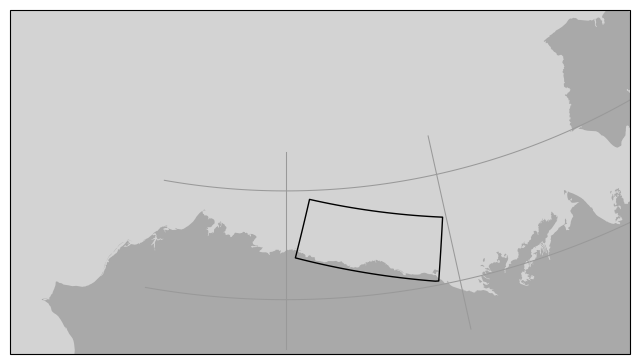

In [11]:

# initialize map
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))
ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-800000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


# for key in ['era', 'ppd']:
#     ax.scatter(grids[key]['lon'][grids[key]['region']], grids[key]['lat'][grids[key]['region']], 
#                zorder=100, s = 10, transform=ccrs.PlateCarree())



line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [69.25,72]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-150,-137.5]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    


In [13]:
# ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/SBSpolynya_data/open_freqs_2002-2025_M1.nc')

In [14]:
# sic = unisic.open_local_file(datetime(2020,1,1), res='6250', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', crop=[0, None, 0, None], coordinates=False, area=False, include_units=False, quiet=True)


In [15]:

# key = 'era'
# mainpath = '../data/forcing/'
# filename = f"dailymaps_{key}_v0.nc"
# ds = xr.open_dataset(mainpath+filename)

In [12]:
c1 = [140/255,210/255,245/255]
c2 = [110/255,170/255,215/255]
c3 = [80/255,130/255,185/255]
c4 = [50/255,100/255,145/255]


In [13]:
df = pd.read_csv('../data/compiled_stats.csv')

df['esei'] = vectors.comp_along_theta(df['ui'], df['vi'], 145*units('degree')) * units('cm/s').to('km/day')
df['ese10'] = 0.02*vectors.comp_along_theta(df['u10'], df['v10'], 180*units('degree'))* units('m/s').to('km/day')
# df['ese10'][df.year>=2016] = 1.3*df['ese10'][df.year>=2016]




df['si_km'] = df['si'] * units('cm/s').to('km/day')

df['e10'] = - df['u10']
# manually modify this for now since I set too strict of threshold

for cat in ['a10', 'ai', 'centermass_direction', 'max_length_direction']:
    df[f'{cat}_r'] = 90-df[f'{cat}']
    df[f'{cat}_r'][df[f'{cat}_r']<0]+=360

df['up'] = df['centermass_length'].values * np.cos(df['centermass_direction'].values*np.pi/180)
df['vp'] = df['centermass_length'].values * np.sin(df['centermass_direction'].values*np.pi/180)
                     
    
vi = (df['ui'].values, df['vi'].values)
vw = (df['u10'].values, df['v10'].values)
vp = (df['up'].values, df['vp'].values )
                              
df['ta_wi'] = vectors.turning_angle(vw,vi).magnitude
df['ta_ip'] = vectors.turning_angle(vi,vp).magnitude
df['ta_wp'] = vectors.turning_angle(vw,vp).magnitude




# identify base period
dfb = df[df['2003_2023']]

dfr = df[df.year >= 2003]



/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/810645748.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/810645748.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/810645748.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [14]:
for month in [12,1,2,3,4]:
    
    cond = ((dfr['sequence']!=-999)&((dfr['season_start_flag']==False)&(dfr['season_end_flag']==False)))
    cond = cond & (dfr['month']==month)
    
    print(dfr['time'][cond][dfr['extent'][cond] == np.max(dfr['extent'][cond])])
    print(dfr['sequence'][cond][dfr['extent'][cond] == np.max(dfr['extent'][cond])])
    

4851    2019-12-12
Name: time, dtype: object
4851    117
Name: sequence, dtype: int64
5489    2024-01-14
Name: time, dtype: object
5489    148
Name: sequence, dtype: int64
5232    2022-02-28
Name: time, dtype: object
5232    133
Name: sequence, dtype: int64
5697    2025-03-11
Name: time, dtype: object
5697    158
Name: sequence, dtype: int64
4368    2016-04-12
Name: time, dtype: object
4368    85
Name: sequence, dtype: int64


In [15]:
cond = ((dfr['sequence']!=-999)&((dfr['season_start_flag']==False)&(dfr['season_end_flag']==False)))
all_ss = list(set(dfr['sequence'][cond]))


Text(0, 0.5, 'Cumulative polynya extent (km^2)')

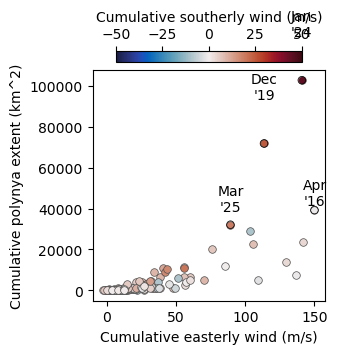

In [16]:
fig, ax = plt.subplots(figsize=(3,3))

import matplotlib.colors as colors
cnorm = colors.Normalize(vmin=-50, vmax=50)


for ss in all_ss:
    
    ii = np.where((dfr['sequence'] == ss)&(dfr['first_day'] == True))[0][0]
    ff = np.where((dfr['sequence'] == ss)&(dfr['final_day'] == True))[0][0]

#     cond = (dfr['sequence'] == ss)&(dfr['final_day']==False)
#     cum_wind = -np.cumsum(0.02*dfr['u10'][ii:ff+1]*units('m/s').to('km/day').magnitude)
    
#     cum_u_wind = -np.cumsum(0.02*dfr['u10'][ii:ff+1]*units('m/s').to('km/day').magnitude)
#     cum_v_wind = np.cumsum(0.02*dfr['v10'][ii:ff+1]*units('m/s').to('km/day').magnitude)
#     cum_wind = np.sqrt(cum_u_wind**2+cum_v_wind**2)
    
    size = 100
    
    mean_u = np.mean(dfr['u10'][ii:ff+1])
    mean_v = np.mean(dfr['v10'][ii:ff+1])
    
    
    sum_u = np.sum(-dfr['u10'][ii:ff+1])
    sum_v = np.sum(dfr['v10'][ii:ff+1])
    sum_s = np.sqrt(sum_u**2+sum_v**2)
    
    
    mean_s = np.sqrt(mean_u**2+mean_v**2)
    
    lengths = dfr['length_145max'][ii:ff+1]
    tot_ext = np.sum(dfr['extent'][ii:ff+1])
    event_duration = dfr['event_day'][ii:ff+1]
    
    cmap = cmocean.cm.balance
    edgecolor = [0.3,0.3,0.3]
    lw = 0.5
    size = 30
    
    angle = vectors.vector_angle(mean_u, mean_v).magnitude
    
#     plt.scatter(sum_u, sum_v, c=tot_ext,  cmap=cmap,  norm = cnorm, s=size, edgecolor=edgecolor, lw=lw)

    X = sum_u



    cmesh = plt.scatter(X, tot_ext, c=sum_v,  cmap=cmap,  norm = cnorm, s=size, edgecolor=edgecolor, lw=lw)

    
#     if tot_ext > 30000:
#         print(dfr['time'][ii:ff])
    
    
    lift = 20000
    if ss == 148:  
        plt.text(X, tot_ext+lift, "Jan\n'24", va='bottom', ha='center')
        plt.scatter(X, tot_ext,  facecolor='None', s=size, edgecolor='k', lw=lw)
    if ss == 117:  
        plt.text(X, tot_ext+lift, "Dec\n'19", va='bottom', ha='center')
        plt.scatter(X, tot_ext,  facecolor='None', s=size, edgecolor='k', lw=lw)
    if ss == 158:  
        plt.text(X, tot_ext+5000, "Mar\n'25", va='bottom', ha='center')
        plt.scatter(X, tot_ext,  facecolor='None', s=size, edgecolor='k', lw=lw)
#     if ss == 133:  
#         plt.text(X, tot_ext+1400, "Feb\n'22", va='bottom', ha='center')
#         plt.scatter(X, tot_ext,  facecolor='None', s=size, edgecolor='k', lw=lw)
    if ss == 85:  
        plt.text(X, tot_ext+1000, "Apr\n'16", va='bottom', ha='center')
        plt.scatter(X, tot_ext,  facecolor='None', s=size, edgecolor='k', lw=lw)
        
# ax.set_yscale('log')
# ax.set_xscale('log')
plotter.add_colorbar(fig, ax, [cmesh], cb_placement='top', cb_orientation='auto', cb_width='auto', 
             cb_length_fraction=[0.1, 0.9], cb_pad=0.025, cb_ticks='auto', cb_ticklabels='auto', cb_extend='neither',
             cb_label='Cumulative southerly wind (m/s)', labelpad='auto', cb_label_placement='auto', cb_tick_placement='auto', 
             tick_kwargs=None, cb_labelsize=plt.rcParams["font.size"], draw_edges=False, edge_params=['k', 2])

# colors.LogNorm(vmin=data.min(), vmax=data.max())
ax.set_xlabel('Cumulative easterly wind (m/s)')
ax.set_ylabel('Cumulative polynya extent (km^2)')

# ax.set_ylim(0,500000)
# ax.set_xlim(-10,180)

# fig.savefig('../figures/results/cum_force_size.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [11]:
# cnorm = colors.LogNorm(vmin=0.01, vmax=10e6)
# cnorm = colors.Normalize(vmin=500, vmax=5*10e3)

<>:176: SyntaxWarning: invalid escape sequence '\m'
<>:176: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/1564126474.py:176: SyntaxWarning: invalid escape sequence '\m'
  ax.text(date+2*db, all_YY.max()+25, '$\mathrm{10^4\;km^2}$ polynya extent',
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/1564126474.py:149: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([date2], all_YY[years2==2003]-1.5, marker='v', s=100, c=line_kwargs['color'], clip_on=False, zorder=10000)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/1564126474.py:150: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequen

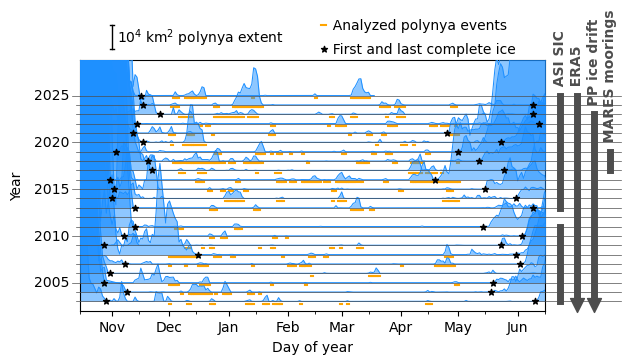

In [17]:
fig, ax = plt.subplots(figsize=(6,3.25))


years2 = np.arange(2003,2026)

all_YY = []

sizes_over_time = np.array([])


for yy, year in enumerate(years2):
    
    YY = yy * 4
    all_YY.append(YY)
    
    
    if year == 2012:
        sizes_over_time = np.append(sizes_over_time, np.full(274, np.nan))
        
    else:
    
        # open polynya data and crop to time range
        #-----------------------------------------
        DSo = xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v6.nc')
        time_range = slice(datetime(year-1,10,1), datetime(year,1,1,0) + timedelta(days=119+62))
        DSo = DSo.sel(time = time_range)

        # find first and last closure dates
        dt_og = (pd.to_datetime(DSo.time.values) - datetime(year,1,1)).days
        water_area = (DSo.polynya_extent + DSo.other_polynya_extent)/1000

        # first/last day of compact conditions
        closure_ind = np.where(water_area == 0)[0][0]
        breakup_ind = np.where(water_area == 0)[0][-1]

        # re-define dt
    #     dt = (pd.to_datetime(DS.time.values) - datetime(year,1,1)).days
        # plot polynya data
    #     ax.bar(dt_og, DSo.polynya_extent/1000, bottom=YY, color='lightgray', alpha=0.5)

        tim = pd.to_datetime(np.array([datetime(2025,1,1) + timedelta(days=dd) for dd in dt_og]))
        if year%4 == 0:
            tim_i = tim
        ext = water_area

        
        if len(ext) < 274:
            sizes_over_time = np.append(sizes_over_time, np.append(ext, np.full(274 -len(ext), np.nan)))
        else:
            sizes_over_time = np.append(sizes_over_time, ext)
                                        
        ext, _ = tseries.linear_interpolate(tim, tim, ext, max_dt = 7 * units('day'))

    #     ax.plot(tim, YY+ext, color=colors['blue3'], alpha=0.5, lw=0.5, zorder=yy)
    
#         plot_color = [0.3,0.3,0.3]
        plot_color = 'dodgerblue'
        ax.fill_between(tim, YY, YY+ext, color=plot_color, lw=0, alpha=0.5, zorder=2*yy)
        ax.plot(tim, YY+ext, color=plot_color, lw=0.75, alpha=1, zorder=2*yy)
        
        
#         ax.bar(tim, ext, bottom=YY, color=plot_color, lw=0, alpha=0.65, width=tim[1]-tim[0], zorder=yy)
        
        sc = 'k'
        ax.scatter(tim[closure_ind], YY, marker='*', color=sc, s=20, zorder=1000)
        
        if year!=2025:
            ax.scatter(tim[breakup_ind], YY, marker='*', color=sc, s=20, zorder=1000)

    

        # re-define dt
        closure_ind = np.where(pd.to_datetime(DSo.time.values) == datetime(year-1,12,1))[0][0]
        breakup_ind = np.where(pd.to_datetime(DSo.time.values) == datetime(year,4,30))[0][0]
        DS = DSo.sel(time = slice(DSo.time[closure_ind],DSo.time[breakup_ind]))
        dt = (pd.to_datetime(DS.time.values) - datetime(year,1,1)).days
        ext = DS.polynya_extent.values/1000
        tim = np.array([datetime(2025,1,1) + timedelta(days=dd) for dd in dt])

        ext, _ = tseries.linear_interpolate(tim, tim, ext, max_dt = 3 * units('day'))
        
        ec = 'orange'
        for st in tim[ext>0]:
            ax.plot([st, st+timedelta(hours=25)], [YY-1,YY-1], 
                       color=ec, lw=1.5, alpha=1, zorder=-1)

    
    if year%5 ==0:
        color1 = [0.3,0.3,0.3]
        ax.text(datetime(2024,10,10), YY, year, va='center', ha='right', clip_on=False)
        ax.plot([datetime(2024,10,11),datetime(2024,10,15)], [YY,YY], c=color1, lw=0.5, zorder=100, clip_on=False)
        ax.plot([datetime(2025,6,15),datetime(2025,7,25)], [YY,YY],  c=color1, lw=0.5, zorder=100, clip_on=False)
        ax.axhline(YY, c=color1, lw=0.5, zorder=100)
        
    else:
        color2 = [0.3,0.3,0.3]
        ax.plot([datetime(2024,10,13),datetime(2024,10,15)], [YY,YY], 
            c=color2, lw=0.5, zorder=100, clip_on=False)
        ax.plot([datetime(2025,6,15),datetime(2025,7,25)], [YY,YY], 
            c=color2, lw=0.5, zorder=100, clip_on=False)
        ax.axhline(YY, c=color2, lw=0.5, zorder=100)#-100)
    
ax.set_ylim(-4,YY+15)
    
ax.set_yticks([])

# xvals = [-61,-31,0,30,58,89,119,150]
# ticklabs = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
# for tt, lab in zip(xvals, ticklabs):
#     ax.text(tt, -26, f'1 {lab}', ha='center')


ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Display month abbreviations
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=[15,]))

ax.set_xlim(datetime(2024,10,15),datetime(2025,6,15))
    
ax.set_xlabel('Day of year')

    
all_YY = np.array(all_YY)

# label SIC record
date1 = datetime(2025,6,23)
date2 = datetime(2025,7,2)
date3 = datetime(2025,7,11)
date4 = datetime(2025,7,19)

line_kwargs = {'clip_on':False, 'lw':5, 'color': [0.3,0.3,0.3], 'zorder':1000}
dot_kwargs = {'clip_on':False, 'marker':'o', 's':15, 'c':line_kwargs['color'], 'zorder':1000}
x_kwargs = {'clip_on':False, 'marker':'x', 's':30, 'c':line_kwargs['color'], 'zorder':1000}

# draw lines
for date, pair in zip([date1, date1, date2, date3, date4],
                      ([2003, 2011], [2013, 2025], [2003, 2025], [2003, 2023], [2017, 2019])):
#     ax.plot([date, date], [all_YY[years2==pair[0]], all_YY[years2==pair[1]]], **line_kwargs)

    ax.plot([date, date], [all_YY[years2==pair[0]], all_YY[years2==pair[1]]], **line_kwargs)

# draw markers on their own
# for date, year, kwarg in zip([date1, date1, date1, date2, date3, date4, date4],
#                              [2003, 2025, 2012,2025, 2023, 2017, 2019], 
#                              [dot_kwargs, dot_kwargs, x_kwargs,dot_kwargs,
#                               dot_kwargs,dot_kwargs,dot_kwargs]):
#     ax.scatter([date], all_YY[years2==year], **kwarg)
    
# arrow markers
ax.scatter([date2], all_YY[years2==2003]-1.5, marker='v', s=100, c=line_kwargs['color'], clip_on=False, zorder=10000)
ax.scatter([date3], all_YY[years2==2003]-1.5, marker='v', s=100, c=line_kwargs['color'], clip_on=False, zorder=10000)

    
# text labels
for date, year, label in zip([date1, date2, date3, date4],
                             [2025, 2025, 2023, 2019],
                             ['  ASI SIC', '  ERA5', '  PP ice drift', "  MARES moorings"]):
    ax.text(date, all_YY[years2==year], label, ha='center',weight='bold', va='bottom',c=[0.3,0.3,0.3], rotation=90)



ax.scatter(tim[-70], all_YY.max()+20, marker='*', color=sc, s=20, clip_on=False, zorder=1000)
ax.text(tim[-70], all_YY.max()+20, '  First and last complete ice', ha='left', va='center', clip_on=False, zorder=1000)


st = tim[-72]
ax.plot([st, st+timedelta(hours=72)], [YY+30,YY+30], 
                       color=ec, lw=1.5, alpha=1, clip_on=False, zorder=1000)
ax.text(tim[-70], all_YY.max()+30, '  Analyzed polynya events', ha='left', va='center', clip_on=False, zorder=1000)


date = datetime(2024,11,1)
db = timedelta(hours=30)
ax.plot([date, date], [all_YY.max()+20, all_YY.max()+30], lw=1,c='k',  clip_on=False)
ax.plot([date-db, date+db], [all_YY.max()+20, all_YY.max()+20], lw=1,c='k',  clip_on=False)
ax.plot([date-db, date+db], [all_YY.max()+30, all_YY.max()+30], lw=1,c='k',  clip_on=False)
ax.text(date+2*db, all_YY.max()+25, '$\mathrm{10^4\;km^2}$ polynya extent', 
        ha='left', va='center', clip_on=False, zorder=1000)


# color=[0.6,0.6,0.6]
# ax.plot([datetime(2024,12,4), datetime(2025,4,29)], 
#         [all_YY.max()+25, all_YY.max()+25], lw=7, c=color, clip_on=False)
# for date in [datetime(2024,12,1), datetime(2025,4,30)]:
#     ax.plot([date,date], [all_YY.min()-3, all_YY.max()+25], 
#             lw=2, ls='solid', alpha=0.5, c=color, clip_on=False)


ax.set_ylabel('Year', labelpad=40)

# fig.savefig('../figures/results/identified_events_v2.png', dpi=400, bbox_inches='tight', pad_inches=0)


time_grid, year_grid = np.meshgrid(tim_i, years2)
sizes_over_time = np.reshape(sizes_over_time, (len(years2), int(len(sizes_over_time)/len(years2))))

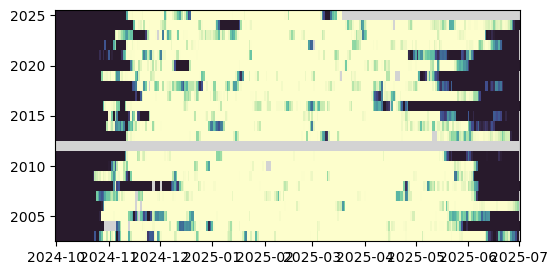

In [23]:
fig, ax = plt.subplots(figsize=(6,3))
ax.patch.set_facecolor('lightgray')

bounds = np.array([0,1,155,545,1700,5000,10e6])/1000
# cmap = matplotlib.colors.ListedColormap(['whitesmoke', c1,c2,c3,c4,'k'])

cmap = matplotlib.colors.ListedColormap(['white', 
                                         cmocean.cm.haline(0.9),
                                         cmocean.cm.haline(0.6),
                                         cmocean.cm.haline(0.3),
                                         cmocean.cm.haline(0.1),
                                         'k'])
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# plt.pcolormesh(time_grid, year_grid, sizes_over_time,
#                cmap=cmap, norm=norm)

plt.pcolormesh(time_grid, year_grid, sizes_over_time,
               cmap=cmocean.cm.deep, vmin=0, vmax=5)
#                vmin=0.0, vmax=2, cmap=cmocean.cm.haline_r)




In [24]:
colors = {}
colors['blue1'] = [45/255,150/255,250/255]
colors['blue2'] = [111/255,170/255,220/255]
colors['blue3'] = [0/255,129/255,243/255]

In [25]:
all_polynya_sizes = daily_data['pol']['extent'][daily_data['pol']['extent']>0]

plt.hist(all_polynya_sizes)

NameError: name 'daily_data' is not defined

## Grab stats over time by month and year

In [26]:


def plot_angles(ax, X, cond, clip):
    label_nums(ax, X, np.sum(cond), clip)
    plot_dist(ax, X-0.15, *angle_distribution(dfb, cond, 'atm'), clip, bins = np.arange(0,361,7.5), yscale=1)
    plot_dist(ax, X+0.15, *angle_distribution(dfb, cond, 'ice'), clip, bins = np.arange(0,361,7.5), yscale=1)
    
#     plot_point(ax, X-0.15, *speed_distribution(df_base, cond, 'atm'))
#     plot_point(ax, X+0.15, *speed_distribution(df_base, cond, 'ice'))    
    
        
def plot_temps(ax, X, cond, clip):
    plot_dist(ax, X, *temp_distribution(df_base, cond), clip, bins = np.arange(-40,0,2), yscale=1)

def plot_msls(ax, X, cond, clip):
    plot_dist(ax, X, *msl_distribution(df_base, cond), clip, bins = np.arange(980,1060,4), yscale=1)
    
def plot_speeds(ax, X, cond, clip):
    plot_dist(ax, X-0.15, *speed_distribution(dfb, cond, 'atm'), clip, bins = np.arange(0,20,1), yscale=1)
    plot_dist(ax, X+0.15, *speed_distribution(dfb, cond, 'ice'), clip, bins = np.arange(0,40,2), yscale=0.5)    

#     plot_point(ax, X-0.15, *speed_distribution(df_base, cond, 'atm'))
#     plot_point(ax, X+0.15, *speed_distribution(df_base, cond, 'ice'))    
    
    
def plot_dist(ax, X, y, Y, color, bg_color, clip, bins = np.arange(0,40,2), yscale = 1, scale = 5, show_mode = False):
    
    h = plotter.quick_hist(y, bin_edges=bins)
    
    if show_mode == True:
        ax.scatter(X, h['centers'][np.argmax(h['prob'])], marker='s', edgecolor=color, facecolor='None',clip_on=clip)
    else:
        ax.scatter(X, yscale*Y, marker='o', edgecolor=color, facecolor='None', s=40, clip_on=clip, zorder=100)
        
#     ax.scatter(X, h['centers'][np.argmax(h['prob'])], marker='o', edgecolor='None', facecolor=color, s=20, clip_on=clip)
    ax.fill_betweenx(yscale*h['edges'][:-1], X - scale*h['prob']/2, X + scale*h['prob']/2, 
                     lw=0, color=bg_color, alpha=0.5, zorder=-1, clip_on=clip)   
    
#     ax.barh(h['centers'], scale*h['prob'], height=h['w'], left= X - scale*h['prob']/2, align='center', 
#             color=bg_color, alpha=0.5, zorder=-1, clip_on=clip)
    

def plot_point(ax, X, y, Y, color, bg_color):
    ax.scatter(X, Y, c=color, clip_on=False)
    ax.scatter(np.linspace(X-0.05,X+0.05, len(y)), y, c=bg_color, s=1, zorder=-1, clip_on=False)

    
def size_distribution(df, cond):

    all_sizes = df['extent'][cond]/1000
    mean_size = np.nanmean(all_sizes)
    print(mean_size)
    color = 'k'
    bg_color = 'gray'

    return all_sizes, mean_size, color, bg_color


def msl_distribution(df, cond):

    all_ = df['msl'][cond]/100
    mean_ = np.nanmean(all_)
    color = 'k'
    bg_color = 'gray'

    return all_, mean_, color, bg_color

def temp_distribution(df, cond):

    all_ = df['t2m'][cond]
    mean_ = np.nanmean(all_)
    color = 'k'
    bg_color = 'gray'

    return all_, mean_, color, bg_color


def speed_distribution(df, cond, group):
    
    if group == 'atm':
        all_speeds = df['s10'][cond]
        mean_speed = np.nanmean(all_speeds)
        color = 'dodgerblue'
        bg_color = 'dodgerblue'
    else:
        all_speeds = df['si'][cond] #* units('cm/s').to('km/day').magnitude
        mean_speed = np.nanmean(all_speeds)
        color = 'r'
        bg_color = 'lightcoral'

    return all_speeds, mean_speed, color, bg_color

def angle_distribution(df, cond, group):

    if group == 'atm':
        U = df['u10'][cond]
        V = df['v10'][cond]
        color = 'dodgerblue'
        bg_color = 'dodgerblue'
    else:
        U = df['ui'][cond]
        V = df['vi'][cond]
        color = 'r'
        bg_color = 'lightcoral'

    all_angles = np.array([vectors.vector_angle(u,v).magnitude for u,v in zip(U,V)])
    mean_angle = vectors.vector_angle(np.nanmean(U), np.nanmean(V)).magnitude
    
    if mean_angle < 0:
        mean_angle+=360
    all_angles[all_angles<0] += 360

    return all_angles, mean_angle, color, bg_color

def label_nums(ax, x, N, clip):
    ax.text(x, -10, N, ha='center',va='bottom', size=5, clip_on=clip)
    
    


### Identify which days to include for each event

In [43]:


all_ese = []
all_ese_mn = []
all_ese_std = []
all_ese75 = []
all_ese50 = []
all_ese25 = []

all_len_mn = []
all_len_std = []

all_len75 = []
all_len50 = []
all_len25 = []

all_ff = []

#=============
L = 12

DF = dfr
#=============

print(len(list(set(DF['sequence'][DF['event_length']>=L]))))
print(len(list(set(DF['sequence'][DF['event_length']<=L]))))

shoulder = (DF['season_start_flag'] + DF['season_end_flag'])

# shoulder = (DF['year']<2017)
# shoulder[(DF['year']>2018)] = True


# for multi-day events, ignore last days of sequences
not_last_day = (DF['final_day']==False)
not_last_day[DF['single_day']==True] = True

# not_last_day[DF['event_length']<12] = False

day_bef = 1
days_before = range(-day_bef, 0)
bef_cond = [((DF['day_before_event'] == dd)&(shoulder==False)) for dd in days_before]

days_during = np.arange(1,L+1)
dur_cond = [(((DF['event_day'] == dd)&(shoulder==False))&(not_last_day==True)) for dd in days_during]

day_aft = 3
days_after = np.arange(1,day_aft+1)
aft_cond = [((DF['day_after_event'] == ff)&(shoulder==False)) for dd in days_after]


all_days = np.concatenate((days_before, days_during-1, L-1+days_after))
all_conds = bef_cond + dur_cond + aft_cond



lengths_by_day = {}


for day, condition in zip(all_days, all_conds):

    ESE = np.nanmean(DF['esei'][condition])
    
    all_ff.append(day)
    all_ese.append(ESE)
    all_ese_mn.append(np.nanmean(DF['esei'][condition]))
    all_ese_std.append(np.nanstd(DF['esei'][condition]))
    
    all_ese75.append(np.nanpercentile(DF['esei'][condition], 75))
    all_ese50.append(np.nanpercentile(DF['esei'][condition], 50))
    all_ese25.append(np.nanpercentile(DF['esei'][condition], 25))
    
    all_ese.append(ESE)
    
    
    length_var = 'length_max'
    
    all_len_mn.append(np.nanmean(DF[length_var][condition]))
    all_len_std.append(np.nanstd(DF[length_var][condition]))
    
    all_len75.append(np.nanpercentile(DF[length_var][condition], 75))
    all_len50.append(np.nanpercentile(DF[length_var][condition], 50))
    all_len25.append(np.nanpercentile(DF[length_var][condition], 25))
    
    lengths_by_day[day] =DF[length_var][condition] 
    

all_ese = np.array(all_ese)
all_ese_mn = np.array(all_ese_mn)
all_ese_std = np.array(all_ese_std)
all_ese75 = np.array(all_ese75)
all_ese50 = np.array(all_ese50)
all_ese25 = np.array(all_ese25)

all_len_mn = np.array(all_len_mn)
all_len_std = np.array(all_len_std)

all_len75 = np.array(all_len75)
all_len50 = np.array(all_len50)
all_len25 = np.array(all_len25)

all_ff = np.array(all_ff)


8
157


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_25477/1016021736.py:60: RuntimeWarning: Mean of empty slice
  ESE = np.nanmean(DF['esei'][condition])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_25477/1016021736.py:64: RuntimeWarning: Mean of empty slice
  all_ese_mn.append(np.nanmean(DF['esei'][condition]))
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_25477/1016021736.py:76: RuntimeWarning: Mean of empty slice
  all_len_mn.append(np.nanmean(DF[length_var][condition]))


In [1485]:
#===============
DF = dfr
#===============

shoulder = (DF['season_start_flag'] + DF['season_end_flag'])


wind_comp = vectors.comp_along_theta(DF['u10'].values, DF['v10'].values, wind_angle)

wind_event = dir_conds(DF, 'wind')
# wind_event = speed_conds(DF, 'wind') & dir_conds(DF, 'wind')
# wind_event =(wind_comp>0)
#  speed_conds(DF, 'wind') & 


In [1486]:

# determine sequences to evaluate
# omit any that intersect with beginning/end of ice season
# and make sure strong wind occur for at least part of event

initial_cond = ((DF.sequence!=-999)&(shoulder==False))&wind_event
all_seqs = np.array(list(set(DF.sequence[initial_cond])))


# print(len(all_seqs))

evaluate = {}

all_days = np.array([])

for ss in all_seqs:
    
    # current event
    event = (DF.sequence==ss)
    
    # if first day of event has weak winds, omit
    if wind_event[event].values[0]==False:
        print(f'{ss}: weak winds to start, omit')
        
    # otherwise, proceed
    else:
        evaluate[ss] = {}
        evaluate[ss]['max_ll'] = 0
        evaluate[ss]['start'] = DF.time[event].values[0] # start time
        evaluate[ss]['si'] = np.where(DF.time == DF.time[event].values[0])[0][0] # start index
        
        day_before = pd.to_datetime(DF.time[event].values[0]) - timedelta(days=1)
        evaluate[ss]['dbi'] = np.where(pd.to_datetime(DF.time) == day_before)[0][0] # day before

        # cannot go 2 days before becuase data missing for some events (e.g. '2019-12-02')
#         day2_before = pd.to_datetime(DF.time[event].values[0]) - timedelta(days=2)
#         evaluate[ss]['2dbi'] = np.where(pd.to_datetime(DF.time) == day2_before)[0][0] # 2 days before

        for ii in range(len(wind_event[event].values)):
            if wind_event[event].values[ii] == True:
                evaluate[ss]['max_ll'] = DF.event_day[event].values[ii] # maximum event day w/ cont. winds
                evaluate[ss]['end'] = DF.time[event].values[ii]         # end time
                evaluate[ss]['fi'] = np.where(DF.time == DF.time[event].values[ii])[0][0] # end index
            else:
                break

    #     evaluate[ss]['max_ll'] = np.max(DF.event_day[event][wind_event[event].values == True])

        all_days = np.append(all_days, evaluate[ss]['max_ll'])

10: weak winds to start, omit
93: weak winds to start, omit
96: weak winds to start, omit
109: weak winds to start, omit
114: weak winds to start, omit


(array([74., 22., 18.,  5.,  2.,  0.,  5.,  1.,  1.,  1.]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <BarContainer object of 10 artists>)

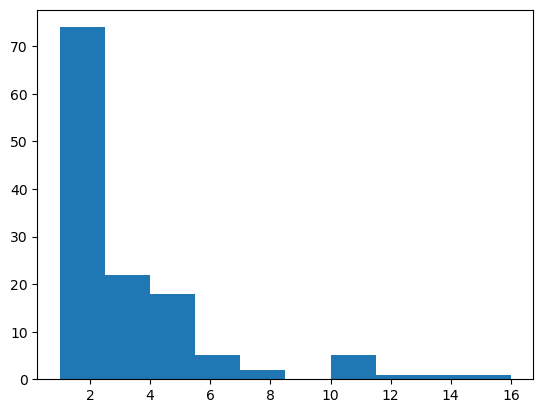

In [1561]:
plt.hist(all_days)
# plt.ylim(0,10)

In [1498]:
evaluate.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 37, 38, 39, 40, 41, 42, 43, 46, 48, 49, 50, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 87, 88, 90, 91, 92, 94, 95, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 110, 112, 113, 115, 116, 117, 120, 122, 123, 124, 125, 126, 127, 129, 130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160])

(dx/dt)(n) = (du(np1) - du(nm1)) / (2N)

du(np1) = ((2N) * (dx/dt)(n)) + du(nm1)

hmmmm the dx/dt @ n depends on x(n), 


In [1554]:
# # actual lengthening
# tot_dXdt = np.append(X_num[0], np.diff(X_num.to('km')))

# # lengthening from ice only
# Vi_only = Vi*units('day')

# # estimated actual ice productio
# plt.plot(Fi)n based on the differences
# Fi_est = ((Vi_only - tot_dXdt)*Hi/X_num)/units('day')

In [1559]:
ev = 19

dbi = evaluate[ev]['dbi']
si = evaluate[ev]['si']
fi = evaluate[ev]['fi']

print(evaluate[ev])



{'max_ll': 1, 'start': '2005-01-23', 'si': 356, 'dbi': 355, 'end': '2005-01-23', 'fi': 356}
16.803622375488278 kilometer / day
1.5147434071039712 kilometer / day


In [1642]:
across = {}

#========
lmax = 7
#========


cats = ['Fi=0', 'Xlim', 'Xp', 'Xo']

across[f'-1'] = {}
for cat in cats:
    across[f'-1'][cat] = np.array([])


for ll in range(1, lmax+1):
    across[f'{ll}'] = {}
    for cat in cats:
        across[f'{ll}'][cat] = np.array([])

across[f'{lmax+1}+'] = {}
for cat in cats:
    across[f'{lmax+1}+'][cat] = np.array([])

In [1643]:

for ev in list(evaluate.keys()):
    
    # open data from event
    dbi = evaluate[ev]['dbi']
    si = evaluate[ev]['si']
    fi = evaluate[ev]['fi']

    # grab conditions over event
    event_df = DF[dbi:fi+1]
    
    
    # model params
    wf = 0.02 # wind factor
    ta = 35   # CW turning angle wind to ice, degrees
    poly_dir = 145  #  polynya direction, degrees CCW from E
    Hi = 15 * units('cm')

    # run model
    X_num, X_max, t95, X_zip = Pease_Model_v2(event_df, wf=wf, ta=ta, poly_dir=poly_dir, Hi = Hi, show_plot = False)
    
    # save output
    for ll, Xp, Xm, Xz, Xo in zip(event_df.event_day.values, X_num, X_max, X_zip, event_df.length_145max.values):

        # determine key to save to
        if ll == -999:
            key = '-1'
        elif ll > lmax:
            key = f'{lmax+1}+'
        else:
            key = f'{ll}'

        across[key]['Fi=0'] = np.append(across[key]['Fi=0'], Xz)
        across[key]['Xlim'] = np.append(across[key]['Xlim'], Xm)
        across[key]['Xp'] = np.append(across[key]['Xp'], Xp)
        across[key]['Xo'] = np.append(across[key]['Xo'], Xo)

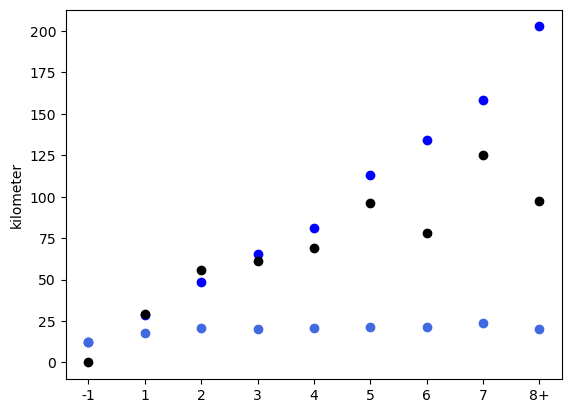

In [1649]:
fig, ax = plt.subplots()

for ll in across.keys():
    ax.scatter(ll, np.nanpercentile(across[ll]['Fi=0'], 50), c='b')
#     ax.scatter(ll, np.nanpercentile(across[ll]['Xlim'], 50), c='royalblue')
    ax.scatter(ll, np.nanpercentile(across[ll]['Xp'], 50), c='royalblue')
    
    ax.scatter(ll, np.nanpercentile(across[ll]['Xo'], 50), c='k')

In [1639]:
across.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, '-1', '8+'])

In [1595]:
X_num

<Quantity([16.0658454  21.92318896 23.43776514 23.34521389], 'kilometer')>

In [ ]:
evaluate[ev]['dbi']

In [ ]:
all_days

In [1599]:
across

{1: {'Fi=0': array([], dtype=float64)},
 2: {'Fi=0': array([], dtype=float64)},
 3: {'Fi=0': array([], dtype=float64)},
 4: {'Fi=0': array([], dtype=float64)},
 5: {'Fi=0': array([], dtype=float64)},
 6: {'Fi=0': array([], dtype=float64)},
 7: {'Fi=0': array([], dtype=float64)},
 '-1': {'Fi=0': array([], dtype=float64)},
 '8+': {'Fi=0': array([], dtype=float64)}}

29.89207331093914
32.00266724250214
32.117305278661256
32.50034337669014
33.01559329866435
35.383028989549004
35.32942830666985
35.2899824441427
28.707999425255643
30.708658011916363


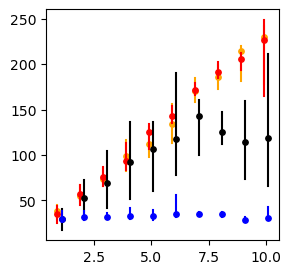

In [854]:
fig, ax = plt.subplots(figsize=(3,3))


#===============
DF = dfr
#===============

shoulder = (DF['season_start_flag'] + DF['season_end_flag'])


# shoulder = np.array([True if month in [3,4] else False for month in DF.month])
# shoulder[DF['season_start_flag']] = True


# shoulder = np.array([True if year not in [2017,2018] else False for year in DF.year])
# shoulder[DF['season_start_flag']] = True


not_last_day = (DF.final_day == False)
not_last_day[DF.single_day == True] = True
# not_last_day[DF.s10<5] = False

# plt.xlim(-50,400)
# plt.ylim(-50,400)

# plt.plot([0,400], [0,400])

# current event day

all_days = np.array([])
all_lengths = np.array([])
all_wind_lengths = np.array([])
all_ice_lengths = np.array([])
all_lat_lengths = np.array([])
all_day_lengths = np.array([])


percentiles = [5,25,50,75,95]


grouplen = {}

grouplen['wind'] = {}
grouplen['obs'] = {}
grouplen['lat'] = {}
grouplen['ice'] = {}

for group in grouplen.keys():
    for per in percentiles:
        grouplen[group][per] = np.array([])
        
        
for group in grouplen.keys():
    grouplen[group]['all'] = {}
    for dd in range(1,20):
        grouplen[group]['all'][dd] = np.array([])
    
nums = np.array([])
days = np.array([])

all_ice1 = np.array([])
all_win1 = np.array([])
all_lat1 = np.array([])

all_ice2 = np.array([])
all_win2 = np.array([])
all_lat2 = np.array([])

all_diff_win_len = np.array([])

LLMAX = 10

last_seqs = list(set(DF.sequence.values))

for ll in np.arange(1,LLMAX+1):
    
    # check if within last sequences
    within_last = np.array([True if seq in last_seqs else False for seq in DF.sequence.values])
#     current_seqs = list(set(DF.sequence[cond].values))
    
    if ll < LLMAX:
        cond = ((DF.event_day == ll) & (shoulder==False))
        cond = (cond &within_last)&(DF.s10>6.5)
    else:
        cond = ((DF.event_day >= ll) & (shoulder==False))#&(DF['season_start_flag']==False))#
        cond = (cond &within_last)&(DF.s10>6.5)
        
    last_seqs = list(set(DF.sequence[cond].values))
    
    llday_ind = np.where(cond)[0]
    
    all_final_ice = np.array([])
    all_final_win = np.array([])
    all_final_len = np.array([])
    all_final_lat = np.array([])
    
    if len(llday_ind) > 1:
        
        for ll_ind in llday_ind:

            # find indices
            si = ll_ind-ll+1
            fi = ll_ind

            #=============================
    #         LENGTH = DF.width + 6.25

    #         LENGTH = (6.25 + DF.length_145max-DF.length_145min)
            LENGTH = (DF.length_145max)
#             LENGTH = (DF.extent)/(DF.width595+6.25)
    #         LENGTH = DF.length_max
    #         LENGTH = DF.length_145
            #=============================

            event_days = DF.event_day[si:fi+1].values
            event_lengths = LENGTH[si:fi+1].values

            coincident_drift = np.cumsum(DF.esei[si:fi+1].values)
            precede_drift = np.cumsum(DF.esei[si-2:fi+1].values)#[1:]

            coincident_wind = np.cumsum(DF.ese10[si:fi+1].values)
            precede_wind = np.cumsum(DF.ese10[si-2:fi+1].values)#[1:]
        
        
#             if np.sum(DF.s10[si:fi+1]>3) == len(DF.s10[si:fi+1]):

            if ll == 1:
                all_win2 = np.append(all_win2, precede_wind[0])
                all_ice2 = np.append(all_ice2, precede_drift[0])
                all_win1 = np.append(all_win1, precede_wind[1])
                all_ice1 = np.append(all_ice1, precede_drift[1])
#                 all_win1 = np.append(all_win1, precede_wind[1])

    #         plt.scatter(precede_wind[-1], event_lengths[-1])



            # Pease model for latent heat widths
            ua = -DF['u10'][si:fi+1].values*units('m/s')
            va = DF['v10'][si:fi+1].values*units('m/s')
            Ta = DF['t2m'][si:fi+1].values*units('degC')
            Xpmax, t95 = Pease_Model(ua, va, Ta, wf = 0.02,  Hi = 25 * units('cm'))


            ua = -DF['u10'][si-2:fi+1].values[0]*units('m/s')
            va = DF['v10'][si-2:fi+1].values[0]*units('m/s')
            Ta = DF['t2m'][si-2:fi+1].values[0]*units('degC')
            Xpmax2, t952 = Pease_Model(ua, va, Ta, wf = 0.02,  Hi = 25 * units('cm'))
            all_lat2 = np.append(all_lat2, Xpmax2.magnitude)
            
            ua = -DF['u10'][si-1:fi+1].values[0]*units('m/s')
            va = DF['v10'][si-1:fi+1].values[0]*units('m/s')
            Ta = DF['t2m'][si-1:fi+1].values[0]*units('degC')
            Xpmax2, t952 = Pease_Model(ua, va, Ta, wf = 0.02,  Hi = 25 * units('cm'))
            all_lat1 = np.append(all_lat1, Xpmax2.magnitude)

            final_ice = precede_drift[-1]
            final_win = precede_wind[-1]
            final_len = event_lengths[-1]
            final_lat = Xpmax[-1].magnitude

            all_final_ice = np.append(all_final_ice, final_ice)
            all_final_win = np.append(all_final_win, final_win)
            all_final_len = np.append(all_final_len, final_len)
            all_final_lat = np.append(all_final_lat, final_lat)

            if ll < LLMAX:
                all_days = np.append(all_days, ll)
            else:
                all_days = np.append(all_days, LLMAX)

            all_lengths = np.append(all_lengths, final_len)
            all_ice_lengths = np.append(all_ice_lengths, final_ice)
            all_wind_lengths = np.append(all_wind_lengths, final_win)
            all_lat_lengths = np.append(all_lat_lengths, final_lat)
            all_day_lengths = np.append(all_day_lengths, ll)


#             plt.scatter(ll-0.1, final_win, c='lightcoral', s=1, alpha=1)
    #         plt.scatter(ll-0.1, final_ice, c='lightskyblue', s=1, alpha=1)
#             plt.scatter(ll+0.1, final_len, c='darkgray', s=1, alpha=1)

        plt.scatter(ll-0.1, np.nanmedian(all_final_ice), c='orange', s=15)
        plt.plot([ll-0.1, ll-0.1], 
                [np.nanpercentile(all_final_ice,25), 
                 np.nanpercentile(all_final_ice,75)], c='orange')

        plt.scatter(ll-0.1, np.nanmedian(all_final_win), c='r', s=15)
        plt.plot([ll-0.1, ll-0.1], 
                [np.nanpercentile(all_final_win,25), 
                 np.nanpercentile(all_final_win,75)], c='r')

    # #     plt.scatter(ll-0.1, np.nanmean(all_final_ice), c='b', s=15)
        plt.scatter(ll+0.1, np.nanmedian(all_final_len), c='k', s=15)
        plt.plot([ll+0.1, ll+0.1], 
                [np.nanpercentile(all_final_len,25), 
                 np.nanpercentile(all_final_len,75)], c='k')


        print(np.nanmedian(all_final_lat))
        plt.scatter(ll+0.1, np.nanmedian(all_final_lat), c='b', s=15)
        plt.plot([ll+0.1, ll+0.1], 
                [np.nanpercentile(all_final_lat,25), 
                 np.nanpercentile(all_final_lat,75)], c='b')
        
        # save to master lists
        for per in percentiles:
            grouplen['wind'][per] = np.append(grouplen['wind'][per], np.nanpercentile(all_final_win, per))
        grouplen['wind']['all'][ll] = np.append(grouplen['wind']['all'][ll], all_final_win)
        
        for per in percentiles:
            grouplen['ice'][per] = np.append(grouplen['ice'][per], np.nanpercentile(all_final_ice, per))
        grouplen['ice']['all'][ll] = np.append(grouplen['ice']['all'][ll], all_final_win)
        
        
        for per in percentiles:
            grouplen['obs'][per] = np.append(grouplen['obs'][per], np.nanpercentile(all_final_len, per))
        grouplen['obs']['all'][ll] = np.append(grouplen['obs']['all'][ll], all_final_len)
        
        for per in percentiles:
            grouplen['lat'][per] = np.append(grouplen['lat'][per], np.nanpercentile(all_final_lat, per))
        grouplen['lat']['all'][ll] = np.append(grouplen['lat']['all'][ll], all_final_lat)
        
        days = np.append(days, ll)
        nums = np.append(nums, len(llday_ind))

    # plt.ylim(0,250)

    # plt.plot([0,300], [0,300])
    
    
cat = 'wind'
for per in percentiles:
    grouplen[cat][per] = np.append(np.array([np.nanpercentile(all_win2, per),
                                             np.nanpercentile(all_win1, per)]), grouplen[cat][per])
    
    
# cat = 'ice'
# for per in percentiles:
#     grouplen[cat][per] = np.append(np.array([np.nanpercentile(all_ice0, per)]), grouplen[cat][per])
    
cat = 'lat'
for per in percentiles:
    grouplen[cat][per] = np.append(np.array([np.nanpercentile(all_lat2, per),
                                             np.nanpercentile(all_lat1, per)]), grouplen[cat][per])

In [859]:
DF.time[si:fi+1].values

array(['2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12',
       '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16',
       '2024-01-17', '2024-01-18'], dtype=object)

In [857]:
ds_sw

<xarray.Dataset>
Dimensions:  (time: 151)
Coordinates:
  * time     (time) datetime64[ns] 2002-12-01 2002-12-02 ... 2003-04-30
Data variables:
    ssrd     (time) float64 ...

In [856]:
ds_sw = xr.open_dataset('../data/forcing/regional_daily_era_ssrd_2003_v7.nc')

In [42]:
list(set(DF.sequence[cond].values))

[96]

0.9391200256094657 0.8819464225007235
LinregressResult(slope=1.1853554597291165, intercept=5.305937901476128, rvalue=0.9391200256094657, pvalue=4.239941568579613e-21, stderr=0.06691792009222282, intercept_stderr=5.2993335787278895)


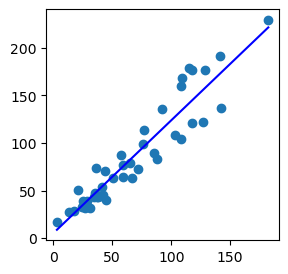

In [43]:
fig, ax = plt.subplots(figsize=(3,3))

x = all_wind_lengths
y = all_ice_lengths
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
res = stats.linregress(x_nn,y_nn)
R = res.rvalue
ax.scatter(x,y)
x_line = np.array([x_nn.min(), x_nn.max()])
y_line = res.intercept + res.slope*x_line
print(R, R**2)
print(res)
ax.plot(x_line, y_line, c='b')




In [38]:
cat = 'wind'
grouplen[cat][50][2::2]

array([ 34.4741678 ,  75.53811703, 115.27479643, 169.7616373 ,
       196.65609892])

Text(10, 9, 'Latent-heat (Pease)')

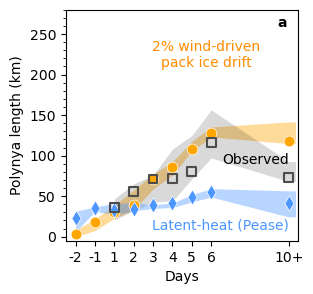

In [44]:
fig, ax = plt.subplots(figsize=(3,3))



for xx, cat, color, color2, fillc,lab, mr, zo, al, LW, S in zip([np.append(np.array([-1,0]),days), days, 
                                        np.append(np.array([-1,0]),days),], ['wind', 'obs', 'lat'], 
                              ['white', [0.3,0.3,0.3], 'white'][::-1], 
                              [[75/255,150/255,255/255], 'None', 'orange'][::-1], 
                                [[75/255,150/255,255/255], 'k', 'orange'][::-1],                           
                             ['Wind-driven ice drift', 'observed', 'Latent-heat estimate'],
                                               ['d', 's', 'o'][::-1], [0,1,0], [0.4,0.15,0.4], [0.5,1.5,0.5],
                                                          [60,40,60]):

    ax.fill_between(np.append(xx, xx[-1]+0.35), 
                    np.append(grouplen[cat][25], grouplen[cat][25][-1]), 
                    np.append(grouplen[cat][75], grouplen[cat][75][-1]), lw=0, color=fillc, alpha=al, zorder=-1)
    ax.scatter(xx, grouplen[cat][50], 
               edgecolor=color, 
               facecolor = color2, lw=LW, marker=mr, label=lab, zorder=zo, s=S)
    
    
    
    
# plt.legend()
#     for dd in days:
#         yy = grouplen[cat]['all'][dd]
#         ax.scatter(np.full(len(yy), dd), yy, c=color2, s=1, zorder=-1)


ax.set_xticks(np.append(np.array([-1,0]),days))
ax.set_xticklabels(np.concatenate((np.array([-2,-1]),days[:-1].astype(int), np.array(['10+']))))

# ax.bar(days, nums/2, bottom=250, color='k', clip_on=False)
# for dd, n in zip(days, nums):
#     ax.text(dd, 250+n/2, f'{n:.0f}', c='k', ha='center', va='bottom', clip_on=False)

ax.set_ylim(-5,280)
ax.set_ylabel('Polynya length (km)')
ax.set_xlabel('Days')
ax.set_xlim(-1.5,10.5)
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))

ax.text(0.95,0.975, 'a', weight='bold',  ha='right', va='top', transform=ax.transAxes)

# plt.axhline(6.25, zorder=-1, ls='dashed', c='darkgray')

plt.text(5.75, 210, '2% wind-driven\npack ice drift', ha='center', c='darkorange')
plt.text(10, 90, 'Observed', ha='right', c='k')
plt.text(10, 9, 'Latent-heat (Pease)', ha='right', c=[75/255,150/255,255/255])

# fig.savefig('../figures/results/timeseries_lengthening.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [40]:
nums

array([87., 47., 29., 15., 10.,  6.,  5.,  5.,  4., 12.])

In [279]:
cat = 'wind'
np.append(grouplen[cat][50][2::2], grouplen[cat][50][-1])

array([ 35.50381821,  75.51196037, 125.48660916, 171.30080786,
       205.45987047, 226.16189264])

In [280]:
cat = 'lat'
np.append(grouplen[cat][50][2::2], grouplen[cat][50][-1])

array([29.89207331, 32.11730528, 33.0155933 , 35.32942831, 28.70799943,
       30.70865801])

In [281]:
cat = 'obs'
np.append(grouplen[cat][50][0::2], grouplen[cat][50][-1])

array([ 29.38230774,  68.75966641, 106.3567456 , 143.28681747,
       114.46666782, 118.17654774])

In [466]:
# wind = np.array([29.67029984, 81.62365485, 159.8473894, 174.82151541])
# latt = np.array([29.93782605, 33.22366475,  35.32942831, 33.74427032])
# obss = np.array([29.38230774, 76.14685572, 107.23015109, 83.90562419])

#1,3,5,7,9,10
wind = np.array([ 29.67029984,  67.30876868, 109.61464417, 159.8473894 ,
       174.98362253, 174.82151541])
latt = np.array([29.93782605, 31.42361067, 35.39719611, 35.32942831, 30.46279759,
       33.74427032])
obss = np.array([ 29.38230774,  65.42651291,  91.78538272, 107.23015109,
       114.46666782,  83.90562419])

In [423]:
print(nums)

[119.  70.  45.  32.  21.  16.   9.   9.   8.  26.]


In [314]:
def bias(x, y): 
    return np.nansum(x-y)/len(y)

In [292]:
days

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

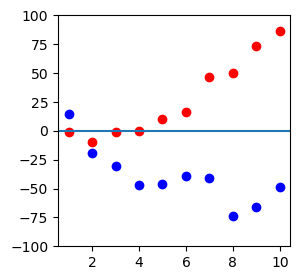

In [343]:
fig, ax = plt.subplots(figsize=(3,3))

for dd in days:
    ax.scatter(dd, bias(all_wind_lengths[all_days==dd], all_lengths[all_days==dd]), c='r')
    ax.scatter(dd, bias(all_lat_lengths[all_days==dd], all_lengths[all_days==dd]), c='b')
    
plt.ylim(-100,100)

plt.axhline(0)

In [280]:
bias(all_lengths, all_lat_lengths)

32.100505607639676

In [287]:
bias(all_lengths[all_days>1], all_wind_lengths[all_days>1])

-0.9550686091171288

In [274]:
np.nanmean(all_lengths-all_lat_lengths)/len(all_lengths)

0.09042395945813993

In [276]:
np.nanmean(all_lengths-all_wind_lengths)/len(all_lengths)

0.005539978451333075

In [277]:
np.sqrt(np.nanmean((all_lengths-all_wind_lengths)**2))/len(all_lengths)

0.14560241360579618

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  8.,  9., 24., 23., 37., 28., 40.,
        22., 22., 19., 18., 13., 17., 10.,  6.,  7.,  5.,  2.,  6.,  6.,
         3.,  1.,  1.,  3.,  5.,  1.,  3.,  2.,  1.,  0.,  2.,  3.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]),
 array([-4.00000000e+00, -3.90000000e+00, -3.80000000e+00, -3.70000000e+00,
        -3.60000000e+00, -3.50000000e+00, -3.40000000e+00, -3.30000000e+00,
        -3.20000000e+00, -3.10000000e+00, -3.00000000e+00, -2.90000000e+00,
        -2.80000000e+00, -2.70000000e+00, -2.60000000e+00, -2.50000000e+00,
        -2.40000000e+00, -2.30000000e+00, -2.20000000e+00, -2.10000000e+00,
        -2.00000000e+00, -1.90000000e+00, -1.80000000e+00, -1.70000000e+00,
        -1.60000000e+00, -1.50000000e+00, -1.40000000e+00, -1.30000000e+00,
        -1.2000

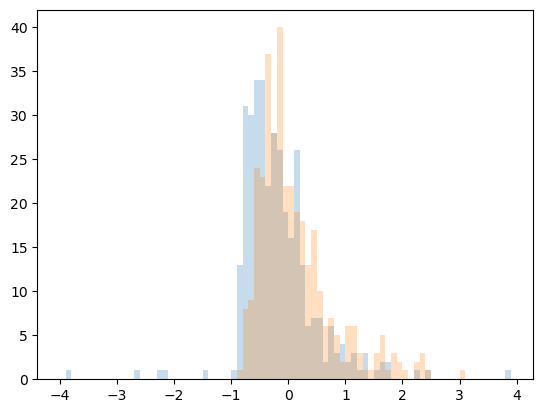

In [263]:
plt.hist((all_lat_lengths-all_lengths)/all_lengths, bins=np.arange(-4,4,0.1), alpha=0.25)
plt.hist((all_wind_lengths-all_lengths)/all_lengths, bins=np.arange(-4,4,0.1), alpha=0.25)

In [239]:
np.nanpercentile(all_lengths - all_lat_lengths, 50)

8.29386061355914

(array([35., 23., 13., 16.,  7., 16.,  8.,  5.,  6.,  3.,  4.,  5.,  2.,
         0.,  1.,  1.,  2.,  0.,  3.]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.,
        65., 70., 75., 80., 85., 90., 95.]),
 <BarContainer object of 19 artists>)

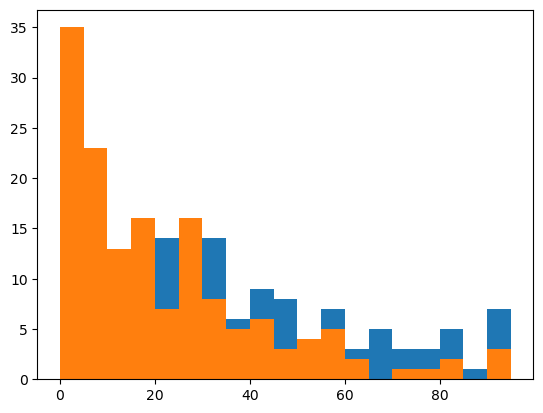

In [237]:
plt.hist((all_lengths - all_lat_lengths), bins=np.arange(0,100,5))
plt.hist((all_lengths - all_wind_lengths), bins=np.arange(0,100,5))

In [224]:
119+70+45+32+21+16+9+9+8+26

355

In [179]:
len(all_win0)

119

In [165]:
all_win0

array([], dtype=float64)

In [100]:
grouplen['wind']['all'][dd]

array([], dtype=float64)

In [101]:
dd

19

In [28]:
llday_ind

array([], dtype=int64)

In [29]:
np.nanmax(DF.event_length)

19

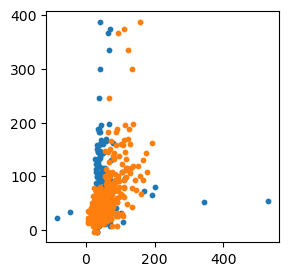

In [200]:
fig, ax = plt.subplots(figsize=(3,3))

bins = np.arange(0,400,10)

# plt.hist(all_wind_lengths, bins = bins, alpha=0.5);
# plt.hist(all_lengths, bins = bins, alpha=0.5);

# plt.hist((all_lengths/all_wind_lengths)[all_lengths>150], bins = bins, alpha=0.5);
# plt.hist((all_lengths/all_wind_lengths)[all_lengths<100], bins = bins, alpha=0.5);

# plt.hist((all_lengths), bins = bins, alpha=0.5);
# plt.hist((all_wind_lengths), bins = bins, alpha=0.5);
# plt.hist((all_lat_lengths), bins = bins, alpha=0.5);

plt.scatter(all_lat_lengths[all_day_lengths<=7], all_lengths[all_day_lengths<=7], s=10)
plt.scatter(all_wind_lengths[all_day_lengths<=7], all_lengths[all_day_lengths<=7], s=10)

# plt.hist((all_wind_lengths/all_wind_lengths)[all_lengths>150], bins = bins, alpha=0.5);

In [1869]:
np.nanmedian((all_lengths/all_wind_lengths)[all_wind_lengths > 120])

0.6362354483035922

In [1868]:
np.nanmedian((all_lengths/all_wind_lengths)[all_wind_lengths < 120])

1.068187679324145

In [1883]:
e = ((all_lengths-all_wind_lengths)/all_lengths)[all_wind_lengths < 120]
np.sqrt(np.nanmean(e**2))

1.3314961638221465

In [1884]:
e = ((all_lengths-all_wind_lengths)/all_lengths)[all_wind_lengths > 120]
np.sqrt(np.nanmean(e**2))

1.7425848398475718

In [1875]:
np.sqrt(np.nanmean(((all_lengths-all_wind_lengths)[all_wind_lengths > 120])**2))

92.81053213927167

0.5959884168877386 0.3552021930643529
LinregressResult(slope=0.7120836235553182, intercept=17.777608284793672, rvalue=0.5959884168877386, pvalue=8.709470421431265e-34, stderr=0.05241825401868929, intercept_stderr=4.4107462622952225)
0.5719117415057008 0.3270830400720835
LinregressResult(slope=0.9970572236125814, intercept=3.426427865600708, rvalue=0.5719117415057008, pvalue=1.3739202633200546e-26, stderr=0.08427049882934678, intercept_stderr=4.99134433398515)
-0.02412715767420838 0.0005821197374361124
LinregressResult(slope=-0.053798155088696425, intercept=141.96969736754406, rvalue=-0.02412715767420838, pvalue=0.872111697405049, stderr=0.3322986070572787, intercept_stderr=56.707125925607265)


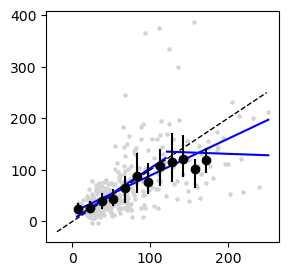

In [201]:
fig, ax = plt.subplots(figsize=(3,3))

length_bins = np.arange(0,450,15)


X = all_wind_lengths#[all_wind_lengths<=50]
Y = all_lengths#[all_wind_lengths<=50]



for bb in range(len(length_bins)-1):
    
    lmin = length_bins[bb]
    lmax = length_bins[bb+1]
    lmid = (lmin+lmax)/2
    
    within_range = (X > lmin) & (X <= lmax)
    
    if np.sum(within_range) > 5:
        ax.scatter(lmid, np.nanmedian(Y[within_range]), c='k', zorder=100)

        ax.plot([lmid, lmid], 
                [np.nanpercentile(Y[within_range], 25), 
                 np.nanpercentile(Y[within_range], 75)], c='k', zorder=100)
        
#     within_range = (Y > lmin) & (Y <= lmax)
#     if np.sum(within_range) > 5:
#         ax.scatter( np.nanmedian(X[within_range]), lmid, marker='s', c='royalblue', zorder=100)
#         ax.plot([np.nanpercentile(X[within_range], 25), 
#                  np.nanpercentile(X[within_range], 75)],[lmid, lmid],  c='royalblue', zorder=100)
    
# ax.scatter(all_lengths, all_wind_lengths, s=1)
ax.scatter(X, Y, c='lightgray', zorder=-1, s=5)
plt.plot([-20,250], [-20,250], lw=1, c='k', ls='dashed')

# plt.xlim(-10,240)
# plt.ylim(-10,240)

# plt.xlim(-5,50)
# plt.ylim(-5,100)

x = X
y = Y
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
res = stats.linregress(x_nn,y_nn)
R = res.rvalue
# ax.scatter(x,y)
x_line = np.array([x_nn.min(), x_nn.max()])
y_line = res.intercept + res.slope*x_line
print(R, R**2)
print(res)
ax.plot(x_line, y_line, c='b')



X = all_wind_lengths[(all_wind_lengths>0)&(all_wind_lengths<120)]
Y = all_lengths[(all_wind_lengths>0)&(all_wind_lengths<120)]
# ax.scatter(X,Y, c='b', s=5)

x = X
y = Y
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
res = stats.linregress(x_nn,y_nn)
R = res.rvalue
# ax.scatter(x,y)
x_line = np.array([x_nn.min(), x_nn.max()])
y_line = res.intercept + res.slope*x_line
print(R, R**2)
print(res)
ax.plot(x_line, y_line, c='b')


X = all_wind_lengths[(all_wind_lengths>120)&(all_wind_lengths<400)]
Y = all_lengths[(all_wind_lengths>120)&(all_wind_lengths<400)]
# ax.scatter(X,Y, c='gray',  s=5)

x = X
y = Y
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
res = stats.linregress(x_nn,y_nn)
R = res.rvalue
# ax.scatter(x,y)
x_line = np.array([x_nn.min(), x_nn.max()])
y_line = res.intercept + res.slope*x_line
print(R, R**2)
print(res)
ax.plot(x_line, y_line, c='b')



In [1968]:
DF.sequence[(DF.event_length>10)*(DF.final_day==True)]

2441     12
3039     33
4332     82
4372     85
4386     86
4564     96
4858    117
5332    140
5493    148
Name: sequence, dtype: int64

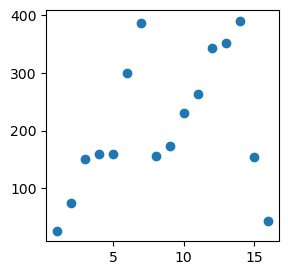

In [1981]:
fig, ax = plt.subplots(figsize=(3,3))

ax.scatter(DF.event_day[(DF.event_length==16)&(DF.year==2024)], 
           DF.length_145max[(DF.event_length==16)&(DF.year==2024)])

In [1978]:
DF.time[(DF.event_length==16)]

5317    2022-12-24
5318    2022-12-25
5319    2022-12-26
5320    2022-12-27
5321    2022-12-28
5322    2022-12-29
5323    2022-12-30
5324    2022-12-31
5325    2023-01-01
5326    2023-01-02
5327    2023-01-03
5328    2023-01-04
5329    2023-01-05
5330    2023-01-06
5331    2023-01-07
5332    2023-01-08
5478    2024-01-03
5479    2024-01-04
5480    2024-01-05
5481    2024-01-06
5482    2024-01-07
5483    2024-01-08
5484    2024-01-09
5485    2024-01-10
5486    2024-01-11
5487    2024-01-12
5488    2024-01-13
5489    2024-01-14
5490    2024-01-15
5491    2024-01-16
5492    2024-01-17
5493    2024-01-18
Name: time, dtype: object

(0.0, 250.0)

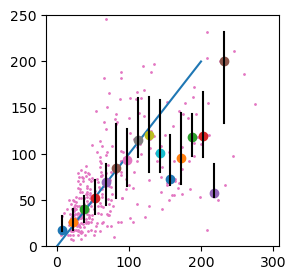

In [1855]:
fig, ax = plt.subplots(figsize=(3,3))

length_bins = np.arange(0,250,15)

for bb in range(len(length_bins)-1):
    
    lmin = length_bins[bb]
    lmax = length_bins[bb+1]
    lmid = (lmin+lmax)/2
    
    within_range = (all_wind_lengths > lmin) & (all_wind_lengths <= lmax)
    
    ax.scatter(lmid, np.nanmedian(all_lengths[within_range]), zorder=100)
    
    ax.plot([lmid, lmid], 
            [np.nanpercentile(all_lengths[within_range], 25), 
             np.nanpercentile(all_lengths[within_range], 75)], c='k', zorder=100)
    
ax.scatter(all_wind_lengths, all_lengths, s=1)
plt.plot([0,200], [0,200])

plt.ylim(0,250)


(-150.0, 300.0)

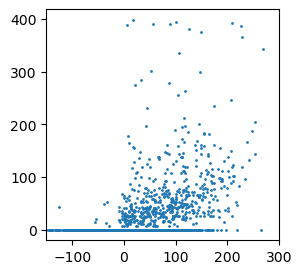

In [376]:
fig, ax = plt.subplots(figsize=(3,3))

# ax.scatter(DF.ese10, DF.length_145, s=1)

ws = -(DF.u10*DF.u10)*np.sign(DF.u10)

lag = 1
ax.scatter(ws[:-lag], DF.length_145[lag:], s=1)
ax.set_xlim(-150,300)

In [364]:
length_bins = np.arange(0,410,20)

#========================
LENGTHS = DF.length_145
# LENGTHS = DF.extent/(DF.width595+6.25)
#========================

cum_drifts = {}
cum_lengths = {}

all_drifts = np.array([])
all_lengths = np.array([])

for bb in range(len(length_bins)-1):
    
    
    
    within_range = ((LENGTHS > length_bins[bb]) & (LENGTHS <= length_bins[bb+1]))
    cond2 = ((DF.final_day==False) & (DF.season_start_flag ==False))
    cond2 = cond2 & ((DF.year >= 2017)&(DF.year <= 2019))
    
    cum_lengths[bb] = LENGTHS[within_range&cond2]
    all_lengths = np.append(all_lengths, LENGTHS[within_range&cond2])
    cum_drifts[bb] = np.array([])
    
    matches = DF[within_range&cond2].index
    
    for match in matches:
    
        # through day before
        DD = DF.loc[match].event_day
        cum_drift = np.cumsum(DF.loc[match-DD+1:match].ese10).values[-1]
        cum_drifts[bb] = np.append(cum_drifts[bb], cum_drift)
        all_drifts = np.append(all_drifts, cum_drift)

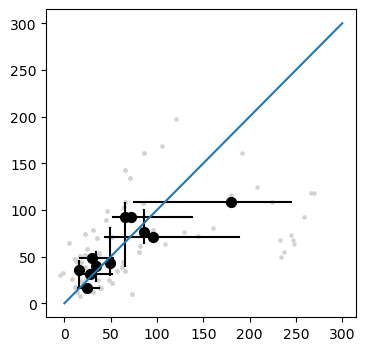

In [365]:
fig, ax = plt.subplots(figsize=(4,4))

for bb in cum_drifts.keys():
    
    ax.scatter(cum_drifts[bb], cum_lengths[bb], s=5, c='lightgray', zorder=-1)
    
    if (len(cum_lengths[bb])) > 3:

        ax.scatter(np.nanmedian(cum_drifts[bb]), 
                   np.nanmedian(cum_lengths[bb]),
                   
                    s=50, c='k')

        ax.plot([np.nanpercentile(cum_drifts[bb], 25), np.nanpercentile(cum_drifts[bb], 75)], 
                [np.nanmedian(cum_lengths[bb]), np.nanmedian(cum_lengths[bb])],
                  c='k')



for bb in range(len(length_bins)-1):
    
    within_range = ((all_drifts > length_bins[bb]) & (all_drifts <= length_bins[bb+1]))
    
    if np.sum(within_range) > 5:

        curr_drifts = all_drifts[within_range]
        curr_lengths = all_lengths[within_range]

        ax.scatter(curr_drifts, curr_lengths, s=5, c='lightgray', zorder=-1)


    #     ax.scatter(cum_drifts[bb],cum_lengths[bb], s=5, c='lightgray', zorder=-1)

        ax.scatter(np.nanmedian(curr_drifts),
                   np.nanmedian(curr_lengths), 
                    s=50, c='k')

        ax.plot([np.nanmedian(curr_drifts), np.nanmedian(curr_drifts)],
                [np.nanpercentile(curr_lengths, 25), np.nanpercentile(curr_lengths, 75)], 
                  c='k')

    
# plt.scatter(all_drifts, all_lengths, s=5, c='darkgray')

#     ax.scatter(np.nanmedian(cum_drifts[bb]), 
#                np.nanmedian(cum_lengths[bb]), s=50, c='k')
    
ax.plot([0,300], [0,300])

# plt.xlim(0,250)
# plt.ylim(0,250)

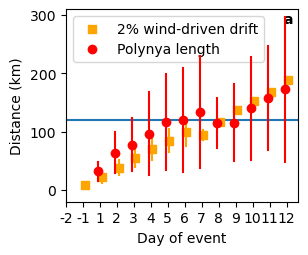

In [192]:

fig, ax = plt.subplots(figsize=(3,2.5))


buff = 0.1

# ax.scatter(np.arange(-int_bf,L)+buff, mean_drifts, marker='s', edgecolor='k',
#            facecolor='k',zorder=100, label='Pack ice advection')
# for xx, mi, ma in zip(range(-int_bf,L),  mean_drifts+std_drifts ,  mean_drifts-std_drifts):
#     ax.plot([xx+buff,xx+buff], [mi, ma], c='k')
    
C = 'orange'
ax.scatter(np.arange(-int_bf,L)+buff, mean_winds, marker='s', edgecolor=C,
           facecolor=C,zorder=100, label='2% wind-driven drift')
for xx, mi, ma in zip(range(-int_bf,L),  mean_winds+std_winds ,  mean_winds-std_winds):
    ax.plot([xx+buff,xx+buff], [mi, ma], c=C)
    
C = 'r'
ax.plot(all_ff-buff, all_len_mn, c=C, label='Polynya length', marker='o', lw=0, zorder=100)
for xx, mi, ma in zip(all_ff,  all_len_mn+all_len_std , all_len_mn-all_len_std):
    ax.plot([xx-buff,xx-buff], [mi, ma], c=C, zorder=100)


ax.set_ylim(-20,310)
ax.set_xticks(np.arange(-2,12));
ax.set_xticklabels(np.append(np.array([-2,-1]), np.arange(1,13)));

plt.legend()

ax.set_ylabel('Distance (km)')
ax.set_xlabel('Day of event')

ax.text(0.975,0.985,f'a', weight='bold', 
                ha='right', va='top', transform=ax.transAxes)

plt.axhline(120)
# fig.savefig('../figures/results/polynya_growth.png', dpi=400, bbox_inches='tight', pad_inches=0)

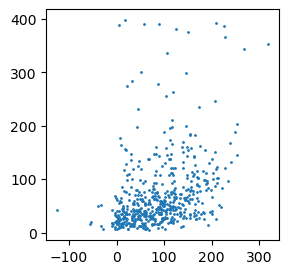

In [171]:
fig, ax = plt.subplots(figsize=(3,3))

ws = -DF.u10*DF.u10*np.sign(DF.u10)

lag = 1
plt.scatter(ws.values[:-lag], DF.length_145.values[lag:], s=1)

### Define direction ranges

In [1773]:
# wind_dir_cond = (DF['a10_r'] > 260) & (DF['a10_r'] < 300)
# ice_dir_cond = (DF['ai_r'] > 270) & (DF['ai_r'] < 315)
# wind_speed_cond = DF['s10'] > 7


# dir_conds = {}
# dir_conds['wind'] = (DF['a10_r'] > 260) & (DF['a10_r'] < 300)
# dir_conds['ice'] = (DF['ai_r'] > 270) & (DF['ai_r'] < 315)

# dir_conds = {}
# dir_conds['wind'] = (DF['a10_r'] > 260) & (DF['a10_r'] < 300)
# dir_conds['ice'] = (DF['ai_r'] > 270) & (DF['ai_r'] < 315)


def dir_conds(dff, cat):
    
    if cat == 'wind':
        
#         dir_cond = (dff['a10_r'] > 260) & (dff['a10_r'] < 305)
#         dir_cond = (dff['a10_r'] > 260) & (dff['a10_r'] < 300)
        dir_cond = (dff['a10_r'] > 260) & (dff['a10_r'] < 305)
        
    elif cat == 'ice':
        
        dir_cond = (dff['ai_r'] > 270) & (dff['ai_r'] < 315)
#         dir_cond = (dff['ai_r'] > 270) & (dff['ai_r'] < 315)

    elif cat == 'poly':
        
        dir_cond = (dff['centermass_direction_r'] > 280) & (dff['centermass_direction_r'] < 330)
        
    return dir_cond

def speed_conds(dff, cat):
    
    if cat == 'wind':
        speed_cond = (dff['s10'] > 6)

#         speed_cond = np.copy(dff['s10'] > 8.5)
#         speed_cond[dff.year>=2016] = np.copy(dff['s10'][dff.year>=2016] > 6)

#         speed_cond = np.copy(dff['s10'] > 7.5)
#         speed_cond[dff.year>=2016] = np.copy(dff['s10'][dff.year>=2016] > 5.5)
        
#         years = np.arange(2003,2026)
#         ws_thresh = np.linspace(9,5.5, len(years))
#         speed_cond = np.copy(dff['s10'] > 10)
#         for year in years:
#             speed_cond[dff.year==year] = (dff['s10'][dff.year==year] > ws_thresh[years==year][0])


    elif cat == 'ice':
        speed_cond = (dff['si_km'] > 10)

    return speed_cond

speed_bins = {}
speed_bins['wind'] = np.arange(0,17,1)
speed_bins['ice'] = np.arange(0,35,2)



In [1651]:
np.sum(dir_conds(DF[DF.extent>0], 'poly'))/np.sum(DF.extent>0)

0.8994413407821229

In [1652]:
np.sum(dir_conds(DF[DF.extent>0], 'wind'))/np.sum(DF.extent>0)

0.7988826815642458

In [1653]:
np.sum(dir_conds(DF[DF.extent>0], 'ice'))/np.sum(DF.extent>0)

0.6815642458100558

<>:151: SyntaxWarning: invalid escape sequence '\m'
<>:151: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/1890841741.py:151: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Polynya\nextent\n($\\times\mathrm{10^3\;km^2}$)', rotation=0, labelpad=25, va='center')


13
133


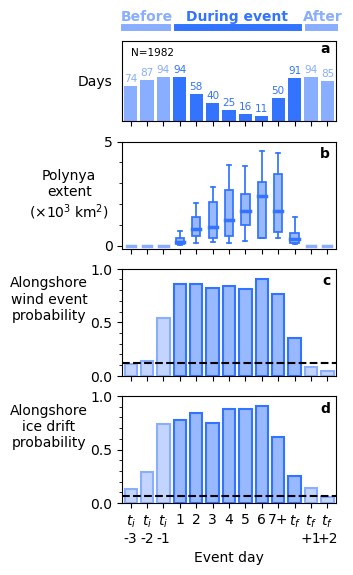

In [1774]:
fig, axs = plt.subplots(4,1,figsize=(2.75,6), gridspec_kw={'height_ratios':[0.75,1,1,1]})


#=============
L = 6
#=============


#=============
DF = dfb
#=============
print(len(list(set(DF['sequence'][DF['event_length']>L]))))
print(len(list(set(DF['sequence'][DF['event_length']<=L]))))

shoulder = (DF['season_start_flag'] + DF['season_end_flag'])


comp_ = (DF.extent==0)
comp_[(DF.day_before_event>=-3)]=False
comp_[(DF.day_after_event<=2)&(DF.day_after_event>-999)]=False

def plot_percentiles(ax, x, data, c='r'):
    ax.scatter(x, np.nanpercentile(data, 50), s=10, c=c)
    ax.scatter(x, np.nanpercentile(data, 25), s=5, c=c)
    ax.scatter(x, np.nanpercentile(data, 75), s=5, c=c)
    
def plot_means(ax, x, data, c='r'):
    ax.scatter(x, np.nanmean(data), s=10, c=c)
    ax.scatter(x, np.nanmean(data)+np.nanstd(data), s=5, c=c)
    ax.scatter(x, np.nanmean(data)-np.nanstd(data), s=5, c=c)
    
    
days_before = np.array([-4,-3,-2,-1])
labels_before = np.array(['$t_{i}$'f'\n{dd}' for dd in days_before])
conds_before = [(DF['day_before_event'] == dd)&(DF['before_event_length']>1) for dd in days_before]

days_during = np.arange(1,L+1)
labels_during = np.array([f'{dd}' for dd in days_during])
conds_during = [((DF['event_day'] == dd)&(shoulder==False))&(DF['final_day'] == False) for dd in days_during]
conds_during[0] = ((DF['event_day'] == 1)&(DF['season_start_flag']==False))&(DF['single_day']==False)


days_more = np.array([L+1])
labels_more = np.array([f'{L+1}+'])
conds_more = [((DF['event_day'] > L)&(DF['final_day'] == False))&(shoulder==False)]

# conds_more = [((df['final_day'] == True)&(df['first_day']==False))]

day_final = np.array([L+2])
labels_final = np.array(['$t_{f}$'])
conds_final = [((DF['final_day'] == True)&(shoulder==False))&(DF['single_day']==False)]   

days_after = np.array([1,2,3])
labels_after = np.array(['$t_{f}$'f'\n+{dd}' for dd in days_after])
conds_after = [(DF['day_after_event'] == dd)&(DF['after_event_length']>1) for dd in days_after]   


x_values = np.concatenate((1+days_before, days_during, days_more, day_final, 2+L+days_after))
x_labels = np.concatenate((labels_before, labels_during, labels_more, labels_final, labels_after))
all_cond = np.concatenate((conds_before, conds_during, conds_more, conds_final, conds_after))

    
    
color1 = [50/255,115/255, 255/255]   
color2 = [137/255,173/255, 255/255]   
    
    
ax = axs[0]
# ax.axhline(len(list(set(df.sequence))), c='lightgray', zorder=-10)
ax.set_ylim(0,170)
ax.set_yticks([])
ax.set_ylabel('Days', rotation=0, labelpad=20, va='center')
for dd, cond in zip(x_values[1:-1], all_cond[1:-1]):
    
    if (dd >0)&(dd < 9):
        ax.bar(dd, np.sum(cond), color=color1)
        ax.text(dd, np.sum(cond)+5, np.sum(cond), 
                color=color1, va='bottom', ha='center', size=7.5)
    else:
        ax.bar(dd, np.sum(cond), color=color2)
        ax.text(dd, np.sum(cond)+5, np.sum(cond), 
                color=color2, va='bottom', ha='center', size=7.5)
ax.text(-2, 140, f'N={np.sum(comp_):.0f}', c='k', size = 7.5,zorder=0)


for ax in axs:
    ax.set_xlim(x_values.min()-0.75+1.25, x_values.max()+0.75-1.25)
    ax.set_xticks(x_values[1:-1])
    ax.set_xticklabels([])
axs[-1].set_xticklabels(x_labels[1:-1]);
# plt.xticks(fontsize=9)



for ax in axs[2:]:
    ax.set_ylim(0,1)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))


axs[2].set_ylabel('Alongshore\nwind event\nprobability', rotation=0, labelpad=30)
axs[3].set_ylabel('Alongshore\nice drift\nprobability', rotation=0, labelpad=30)

ax = axs[2]

for ax, cat in zip(axs[2:], ['wind', 'ice']):
    
    wind_prob = np.array([])
    for dd, cond in zip(x_values, all_cond):
        cond1 = cond & (dir_conds(DF, cat))& speed_conds(DF, cat)
        wind_prob = np.append(wind_prob, np.sum(cond1)/np.sum(cond))
        
    width = 0.75    
        
    ax.bar(x_values[4:-3], wind_prob[4:-3], width=width,color = color1, ls='solid',  alpha=0.5, zorder=1)
    ax.bar(x_values[:4], wind_prob[:4],width=width, color = color2, ls='solid',  alpha=0.5, zorder=1)
    ax.bar(x_values[-3:], wind_prob[-3:],width=width, color = color2, ls='solid',  alpha=0.5, zorder=1)
    
    
    ax.bar(x_values[4:-3], wind_prob[4:-3], width=width,facecolor='None', edgecolor = color1, ls='solid', lw=1.5, alpha=1, zorder=1)
    ax.bar(x_values[:4], wind_prob[:4], width=width,facecolor='None', edgecolor = color2, ls='solid', lw=1.5, alpha=1, zorder=1)
    ax.bar(x_values[-3:], wind_prob[-3:], width=width,facecolor='None', edgecolor = color2, ls='solid', lw=1.5, alpha=1, zorder=1)
    
#     ax.plot(x_values, wind_prob, color = 'k', ls='solid', marker='s', alpha=1, zorder=1)

    cond = comp_
    cond1 = cond & (dir_conds(DF, cat)&speed_conds(DF, cat))
    ax.axhline(np.sum(cond1)/np.sum(cond), ls='dashed', lw=1.5,  c = 'k', zorder=2)




    
axs[-1].set_xlabel('Event day')

for aa, ax in enumerate(axs):
#     ax.text(1.01, 0.95, '(a)', ha='left', va='top', weight='bold', clip_on=False, transform = ax.transAxes)
    if aa == 0:
        ax.text(0.975, 0.99, f'{chr(97+aa)}', 
                ha='right', va='top', weight='bold', clip_on=False, transform = ax.transAxes)

    else:
        ax.text(0.975, 0.95, f'{chr(97+aa)}', 
                ha='right', va='top', weight='bold', clip_on=False, transform = ax.transAxes)

    
C = 'k'

ax = axs[1]
ax.set_ylim(-0.15,5)
ax.set_ylabel('Polynya\nextent\n($\\times\mathrm{10^3\;km^2}$)', rotation=0, labelpad=25, va='center')
VAR = 'extent'
for dd, cond in zip(x_values, all_cond):
    
    bf=0.25
    
    if (dd >= 1)&(dd<9):
        color = color1
    else:
        color = color2
        
#     ax.scatter(np.linspace(dd-bf,dd+bf, np.sum(cond)), DF[VAR][cond]/10e2,
#                c=color, s=5, zorder=1)
    
    LW = 1.25
    
    bottom = np.nanpercentile(DF[VAR][cond], 25)/10e2
    middle = np.nanpercentile(DF[VAR][cond], 50)/10e2
    top = np.nanpercentile(DF[VAR][cond], 75)/10e2
    high = np.nanpercentile(DF[VAR][cond], 90)/10e2
    low = np.nanpercentile(DF[VAR][cond], 10)/10e2
    height=(top-bottom)
    rectangle = patches.Rectangle((dd-bf, bottom), 2*bf, height, lw=LW, edgecolor='None', facecolor=color, alpha=0.5)
    ax.add_patch(rectangle)
    rectangle = patches.Rectangle((dd-bf, bottom), 2*bf, height, lw=LW, edgecolor=color, facecolor='None')
    ax.add_patch(rectangle)
#     ax.plot(rectangle)
    
    ax.plot([dd-bf,dd+bf],[middle, middle], c = color, lw=2*LW, zorder=1)
    ax.plot([dd,dd],[top, high], c = color, lw=LW, zorder=1)
    ax.plot([dd,dd],[low, bottom], c = color, lw=LW, zorder=1)
    
    bb = bf/2
    ax.plot([dd-bb,dd+bb],[high, high], c = color, lw=LW, zorder=1)
    ax.plot([dd-bb,dd+bb],[low, low], c = color, lw=LW, zorder=1)
    
#     ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 25)/10e2,
#             np.nanpercentile(DF[VAR][cond], 75)/10e2], c=color, zorder=1)
    
#     ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 10)/10e2,
#             np.nanpercentile(DF[VAR][cond], 90)/10e2], c=color, zorder=1)

ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    
    
# Get the y-axis tick labels
xtick_labels = axs[-1].get_xticklabels()

# Change the color of specific y-axis tick labels
# for i, label in enumerate(xtick_labels):
#     if (i >=3)&(i<11):  # Change every other y-axis label to green
#         label.set_color(color1)
#     else:
#         label.set_color(color2)

        
ax = axs[0]

yy = 200
ax.plot([0.8,8.2], [yy,yy], c=color1, lw=5, clip_on=False)
ax.text(4.5,yy+7, 'During event', weight='bold', c=color1, va='bottom', ha='center', clip_on=False)
ax.plot([-2.4,0.2], [yy,yy], c=color2, lw=5, clip_on=False)
ax.text(-1,yy+7, 'Before', weight='bold', c=color2, va='bottom', ha='center', clip_on=False)
ax.plot([8.8,10.4], [yy,yy], c=color2, lw=5, clip_on=False)
ax.text(9.75,yy+7, 'After', weight='bold', c=color2, va='bottom', ha='center', clip_on=False)
fig.savefig('../figures/results/comp_time.png', dpi=400, bbox_inches='tight')

<>:112: SyntaxWarning: invalid escape sequence '\m'
<>:127: SyntaxWarning: invalid escape sequence '\m'
<>:147: SyntaxWarning: invalid escape sequence '\m'
<>:202: SyntaxWarning: invalid escape sequence '\m'
<>:112: SyntaxWarning: invalid escape sequence '\m'
<>:127: SyntaxWarning: invalid escape sequence '\m'
<>:147: SyntaxWarning: invalid escape sequence '\m'
<>:202: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/505133768.py:112: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Polynya\nextent\n($\\times\mathrm{10^3\;km^2}$)')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/505133768.py:127: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Wind speed\n($\mathrm{m\;s^{-1}}$)')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/505133768.py:147: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Ice speed\n($\mathrm{km\;d^{-1}}$)')
/var/folders/p8/hz449fpx6nsc

13
133


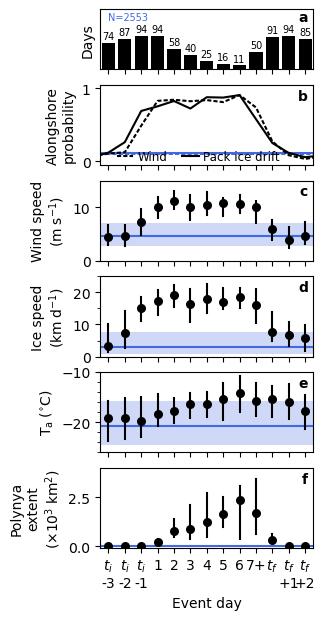

In [386]:
fig, axs = plt.subplots(6,1,figsize=(2.75,7), gridspec_kw={'height_ratios':[0.75,1,1,1,1,1]})


#=============
L = 6
#=============

var = 't2m'

#=============
DF = dfb
#=============
print(len(list(set(DF['sequence'][DF['event_length']>L]))))
print(len(list(set(DF['sequence'][DF['event_length']<=L]))))

shoulder = (DF['season_start_flag'] + DF['season_end_flag'])


comp_ = (DF.extent==0)

def plot_percentiles(ax, x, data, c='r'):
    ax.scatter(x, np.nanpercentile(data, 50), s=10, c=c)
    ax.scatter(x, np.nanpercentile(data, 25), s=5, c=c)
    ax.scatter(x, np.nanpercentile(data, 75), s=5, c=c)
    
def plot_means(ax, x, data, c='r'):
    ax.scatter(x, np.nanmean(data), s=10, c=c)
    ax.scatter(x, np.nanmean(data)+np.nanstd(data), s=5, c=c)
    ax.scatter(x, np.nanmean(data)-np.nanstd(data), s=5, c=c)
    
    
    
days_before = np.array([-4,-3,-2,-1])
labels_before = np.array(['$t_{i}$'f'\n{dd}' for dd in days_before])
conds_before = [(DF['day_before_event'] == dd)&(DF['before_event_length']>1) for dd in days_before]

days_during = np.arange(1,L+1)
labels_during = np.array([f'{dd}' for dd in days_during])
conds_during = [((DF['event_day'] == dd)&(shoulder==False))&(DF['final_day'] == False) for dd in days_during]
conds_during[0] = ((DF['event_day'] == 1)&(DF['season_start_flag']==False))&(DF['single_day']==False)


days_more = np.array([L+1])
labels_more = np.array([f'{L+1}+'])
conds_more = [((DF['event_day'] > L)&(DF['final_day'] == False))&(shoulder==False)]

# conds_more = [((df['final_day'] == True)&(df['first_day']==False))]

day_final = np.array([L+2])
labels_final = np.array(['$t_{f}$'])
conds_final = [((DF['final_day'] == True)&(shoulder==False))&(DF['single_day']==False)]   

days_after = np.array([1,2,3])
labels_after = np.array(['$t_{f}$'f'\n+{dd}' for dd in days_after])
conds_after = [(DF['day_after_event'] == dd)&(DF['after_event_length']>1) for dd in days_after]   


x_values = np.concatenate((1+days_before, days_during, days_more, day_final, 2+L+days_after))
x_labels = np.concatenate((labels_before, labels_during, labels_more, labels_final, labels_after))
all_cond = np.concatenate((conds_before, conds_during, conds_more, conds_final, conds_after))






    
ax = axs[0]
# ax.axhline(len(list(set(df.sequence))), c='lightgray', zorder=-10)
ax.set_ylim(0,170)
ax.set_yticks([])
ax.set_ylabel('Days')
for dd, cond in zip(x_values[1:-1], all_cond[1:-1]):
    ax.bar(dd, np.sum(cond), color='k')
    ax.text(dd, np.sum(cond)+5, np.sum(cond), 
            color='k', va='bottom', ha='center', size=7)
ax.text(-2, 140, f'N={np.sum(comp_):.0f}', c='royalblue', size = 7,zorder=0)


for ax in axs:
    ax.set_xlim(x_values.min()-0.75+1.25, x_values.max()+0.75-1.25)
    ax.set_xticks(x_values[1:-1])
    ax.set_xticklabels([])
axs[-1].set_xticklabels(x_labels[1:-1]);
# plt.xticks(fontsize=9)

# for dd, cond in zip(x_values, all_cond):
#     angles = np.copy(df['a10'][cond])
#     angles[angles<0]+=360
#     angle_of_mean = vectors.vector_angle(np.nanmean(df['u10'][cond]), np.nanmean(df['v10'][cond])).magnitude
#     if angle_of_mean < 0:
#         angle_of_mean+=360
#     plot_dist(ax, dd, angles, angle_of_mean, 
#           'r', 'lightcoral', False, bins = np.arange(0, 361,10), yscale = 1, scale=3, show_mode=False)
    
# for dd, cond in zip(x_values, all_cond):
#     angles = np.copy(df['ai'][cond])
#     angles[angles<0]+=360
#     angle_of_mean = vectors.vector_angle(np.nanmean(df['ui'][cond]), np.nanmean(df['vi'][cond])).magnitude
#     if angle_of_mean < 0:
#         angle_of_mean+=360
#     plot_dist(ax, dd, angles, angle_of_mean, 
#           'b', 'dodgerblue', False, bins = np.arange(0, 361,10), yscale = 1, scale=3)


# plt.axhline(165, c='k', ls='dashed', zorder=-1)

C = 'k'

ax = axs[5]
ax.set_ylim(-0.1,4)
ax.set_ylabel('Polynya\nextent\n($\\times\mathrm{10^3\;km^2}$)')
VAR = 'extent'
for dd, cond in zip(x_values, all_cond):
    ax.scatter(dd,np.nanpercentile(DF[VAR][cond], 50)/10e2, facecolor = 'k', edgecolor=C, s=30, zorder=1)
#     ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 5)/10e2,
#             np.nanpercentile(DF[VAR][cond], 95)/10e2], c='darkgray', zorder=1)
    ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 25)/10e2,
            np.nanpercentile(DF[VAR][cond], 75)/10e2], c=C, zorder=1)
ax.axhline(0, c='royalblue', zorder=-1)
    
    
C = 'k'

ax = axs[2]
ax.set_ylim(0,15)
ax.set_ylabel('Wind speed\n($\mathrm{m\;s^{-1}}$)')
VAR = 's10'
for dd, cond in zip(x_values, all_cond):
    ax.scatter(dd,np.nanpercentile(DF[VAR][cond], 50), facecolor = C, edgecolor=C, s=30, zorder=1)
#     ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 5),
#             np.nanpercentile(DF[VAR][cond], 95)], c='darkgray', zorder=1)
    ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 25),
            np.nanpercentile(DF[VAR][cond], 75)], c=C, zorder=1)
    
ax.axhline(np.nanpercentile(DF[VAR][DF.extent==0], 50), c='royalblue', zorder=-1)
ax.fill_between(x=ax.get_xlim(), 
                y1=np.nanpercentile(DF[VAR][DF.extent==0], 25), 
                y2=np.nanpercentile(DF[VAR][DF.extent==0], 75), 
                color='royalblue',  lw=0,
                interpolate=True, alpha=0.25, zorder=-2)
# ax.axhline(7, c='gray', ls='dotted', zorder=1)
# ax.text(7.35, 7.5, '$\mathrm{7\;m\;s^{-1}}$', c='gray',size = 9.5, zorder=0)

ax = axs[3]
ax.set_ylim(0,25)
ax.set_ylabel('Ice speed\n($\mathrm{km\;d^{-1}}$)')
VAR = 'si_km'
for dd, cond in zip(x_values, all_cond):
    ax.scatter(dd,np.nanpercentile(DF[VAR][cond], 50), facecolor = C, edgecolor=C, s=30, zorder=1)
#     ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 5),
#             np.nanpercentile(DF[VAR][cond], 95)], c='darkgray', zorder=1)
    ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 25),
            np.nanpercentile(DF[VAR][cond], 75)], c=C, zorder=1)
    
ax.axhline(np.nanpercentile(DF[VAR][DF.extent==0], 50), c='royalblue', zorder=-1)
ax.fill_between(x=ax.get_xlim(), 
                y1=np.nanpercentile(DF[VAR][DF.extent==0], 25), 
                y2=np.nanpercentile(DF[VAR][DF.extent==0], 75), 
                color='royalblue',  lw=0,
                interpolate=True, alpha=0.25, zorder=-2)

# ax.axhline(10, c='gray', ls='dotted', zorder=0)
# ax.text(3, 5.25, '$\mathrm{10\;km\;d^{-1}}$', c='gray', size = 9.5,zorder=0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))

ax = axs[1]
ax.set_ylabel('Alongshore\nprobability')
ax.set_ylim(-0.05,1.05)
ax.plot([-1.5,-0.5],[.075,.075], c='k', ls='dashed', dashes=(2, 1), zorder=1)
ax.plot([2.5,3.5],[.075,.075], c='k', ls='solid', zorder=1)
ax.text(-0.25, 0.15, 'Wind', size = 8.5, va = 'top', ha='left', c='k', zorder=0)
ax.text(3.75, 0.15, 'Pack ice drift', size = 8.5,va = 'top', ha='left',  c='k', zorder=0)


ice_prob = np.array([])
wind_prob = np.array([])
for dd, cond in zip(x_values, all_cond):
    
    cond1 = cond & (dir_conds(DF, 'ice')&speed_conds(DF, 'ice'))
    cond2 = cond & (dir_conds(DF, 'wind')&speed_conds(DF, 'wind'))
    
    ice_prob = np.append(ice_prob, np.sum(cond1)/np.sum(cond))
    wind_prob = np.append(wind_prob, np.sum(cond2)/np.sum(cond))
    
ax.plot(x_values, ice_prob, color = 'k', alpha=1, zorder=1)
ax.plot(x_values, wind_prob, color = 'k', ls='dashed', dashes=(2, 1), alpha=1, zorder=1)

    
cond = comp_
cond1 = cond & (dir_conds(DF, 'ice')&speed_conds(DF, 'ice'))
cond2 = cond & (dir_conds(DF, 'wind')&speed_conds(DF, 'wind'))
ax.axhline(np.sum(cond2)/np.sum(cond), c = 'royalblue', zorder=-2)
ax.axhline(np.sum(cond1)/np.sum(cond), c = 'royalblue', ls='dashed',dashes=(2, 1), zorder=-2)



    
ax = axs[4]
ax.set_ylim(-26,-10)
ax.set_ylabel('$\mathrm{T_{a}\;(^{\circ}C}$)')
VAR = 't2m'
for dd, cond in zip(x_values, all_cond):
    ax.scatter(dd,np.nanpercentile(DF[VAR][cond], 50), facecolor = C, edgecolor=C, s=30, zorder=1)
#     ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 5),
#             np.nanpercentile(DF[VAR][cond], 95)], c='darkgray', zorder=1)
    ax.plot([dd,dd],[np.nanpercentile(DF[VAR][cond], 25),
            np.nanpercentile(DF[VAR][cond], 75)], c=C, zorder=1)
    
ax.axhline(np.nanpercentile(DF[VAR][DF.extent==0], 50), c='royalblue', zorder=-1)
ax.fill_between(x=ax.get_xlim(), 
                y1=np.nanpercentile(DF[VAR][DF.extent==0], 25), 
                y2=np.nanpercentile(DF[VAR][DF.extent==0], 75), 
                color='royalblue',  lw=0,
                interpolate=True, alpha=0.25, zorder=-2)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
    
    
    
    
axs[-1].set_xlabel('Event day')
#     plot_dist(ax, dd, df['t2m'][cond], np.nanmean(df['t2m'][cond]), 
#           'r', 'lightcoral', True, bins = np.arange(-36,4,2), yscale = 1)
    
    
# ax = axs[4]
# ax.set_ylim(-500,10000)
# for dd, cond in zip(x_values, all_cond):
#     ax.axhline(np.nanmean(df['extent'][df.extent==0]), c='r', zorder=-1)
#     plot_dist(ax, dd, df['extent'][cond], np.nanmean(df['extent'][cond]), 
#           'r', 'lightcoral', True, bins = np.arange(0,25000,500), yscale = 1)


for aa, ax in enumerate(axs):
#     ax.text(1.01, 0.95, '(a)', ha='left', va='top', weight='bold', clip_on=False, transform = ax.transAxes)
    if aa == 0:
        ax.text(0.975, 0.99, f'{chr(97+aa)}', ha='right', va='top', weight='bold', clip_on=False, transform = ax.transAxes)

    else:
        ax.text(0.975, 0.95, f'{chr(97+aa)}', ha='right', va='top', weight='bold', clip_on=False, transform = ax.transAxes)

    
# plt.ylim(-10,300)
#     plt.scatter(dd, np.nanmean(df['esei'][(df['event_day'] == dd)&(shoulder==False)]), color = 'k')


# fig.savefig('../figures/results/comp_time_v4.png', dpi=400, bbox_inches='tight')

In [1327]:

#=============
DF = dfb
#=============

# not_last_day = (DF.final_day == False)
# not_last_day[DF.single_day == True] == True

not_last_day = (DF.final_day == False)
not_last_day[DF.single_day == True] = True

print(np.nanpercentile(DF.si_km[((DF.extent > 0)&(not_last_day))+(DF.day_before_event==-1)], 25))
print(np.nanpercentile(DF.s10[((DF.extent > 0)&(not_last_day))+(DF.day_before_event==-1)], 25))

# print(np.nanpercentile(DF.si_km[((DF.extent > 0)&(not_last_day))], 25))
# print(np.nanpercentile(DF.s10[((DF.extent > 0)&(not_last_day))], 25))



10.97569646345195
6.508233014464062


In [1255]:
np.nanpercentile(DF.s10[DF.extent == 0], 85)

8.368934065296683

In [2025]:
cond = (DF.extent==0)
cond1 = cond & (dir_conds(DF, 'wind') & speed_conds(DF, 'wind'))
cond2 = cond & (dir_conds(DF, 'wind'))
# ax.axhline(dd,np.sum(cond2)/np.sum(cond), color = 'royalblue', alpha=0.2,  zorder=1)
# ax.axhline(dd,np.sum(cond1)/np.sum(cond), color = 'royalblue', zorder=1)

In [2016]:
dir_conds(DF, 'wind') & speed_conds(DF, 'wind')

2269    False
2270    False
2271    False
2272    False
2273    False
        ...  
5743     True
5744    False
5745    False
5746    False
5747    False
Length: 3479, dtype: bool

In [108]:
def plot_dist(ax, X, y, Y, color, bg_color, clip, bins = np.arange(0,40,2), yscale = 1):
    h = plotter.quick_hist(y, bin_edges=bins)
    
    ax.scatter(X, yscale*Y, marker='o', edgecolor=color, facecolor='None', s=40, clip_on=clip, zorder=100)
#     ax.scatter(X, h['centers'][np.argmax(h['prob'])], marker='s', edgecolor=color, facecolor='None',clip_on=clip)
#     ax.scatter(X, h['centers'][np.argmax(h['prob'])], marker='o', edgecolor='None', facecolor=color, s=20, clip_on=clip)
    scale = 5
    ax.fill_betweenx(yscale*h['edges'][:-1], X - scale*h['prob']/2, X + scale*h['prob']/2, 
                     lw=0, color=bg_color, alpha=0.5, zorder=-1, clip_on=clip)   

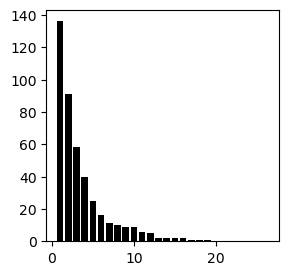

In [124]:
fig, ax = plt.subplots(figsize=(3,3))

# plt.ylim(-1,170)


all_ese = []
all_ese_std = []
all_ese75 = []
all_ese25 = []
all_ff = []

for L in range(1,27):
    num_events = np.sum((df['event_day'] == L)&(shoulder==False))
    ax.bar(L, num_events, color='k')

In [1655]:
# def wind_dir_cond(df):
    
# #     return (df['a10'] > -120) & (df['a10'] < 0)
    
# #     return (df['a10'] > 120) + (df['a10'] < -145)


#     return (df['a10'] > 145) + (df['a10'] < -170)
# #     return (df['a10'] > 140) + (df['a10'] < -160)

# def wind_speed_cond(df):
    
#     speed_cond = (df['s10'] > 7)

# #     speed_cond = (df['s10'] > 5.8)
    
# #     speed_thresh = [7,7.7,8.2,8.7,8]
# #     speed_thresh = [7,7.75,8.25,8.75,8]
# #     speed_cond = (df['s10'] > 9)
    
# #     for month, thresh in zip([12,1,2,3,4], speed_thresh):
# #         speed_cond[(df['s10'] > thresh) & (df.month==month)]=True
    

    
# #     speed_cond = (df['s10'] > 9)
# #     speed_cond = np.full(len(df['s10']), False)
# #     for year, speed_thresh in zip(np.arange(2003,2025), ws_threshes):#np.linspace(10,7,len(np.arange(2003,2024)))):
# #         speed_cond[(df['s10'] > speed_thresh) & (df.year==year)]=True
# #     for year, speed_thresh in zip(np.arange(2003,2025), np.linspace(8,4.5,len(np.arange(2003,2025)))):
# #         speed_cond[(df['s10'] > speed_thresh) & (df.year==year)]=True
        
        
#     return speed_cond


# def wind_cond(df):
#     return wind_dir_cond(df)&wind_speed_cond(df)

    
    
#     return angle_cond&speed_cond

# def ice_dir_cond(df):
#     return (df['ai'] > 135)

# #     return (df['ai'] > 130)# & (df['ai'] < 170)

# def ice_speed_cond(df):
#     return (df['si'] > 15)
# #     return (df['si'] > 11.6)
# #     speed_cond = (df['si'] > 10)

# def ice_cond(df):

#     return ice_dir_cond(df)&ice_speed_cond(df)


In [124]:
14*units('cm/s').to('km/day')

# 15*units('km/day').to('cm/s')

<Quantity(12.096, 'kilometer / day')>

In [71]:
wind_durations = []
ice_durations = []
pol_durations = []

for year in years:

    df_year = df[df.year==year]
    wind_dates = pd.to_datetime(df_year.time[wind_cond(df_year)].values)
    wind_seqs = tseries.dates_to_sequences(wind_dates, dt_max=1*units('day'))

    for ss in wind_seqs:
        
        wind_durations.append(len(wind_seqs[ss]))
         
    ice_dates = pd.to_datetime(df_year.time[ice_cond(df_year)].values)
    ice_seqs = tseries.dates_to_sequences(ice_dates, dt_max=1*units('day'))

    for ss in ice_seqs:
        
        ice_durations.append(len(ice_seqs[ss]))
        
    pol_dates = pd.to_datetime(df_year.time[df_year.extent>0].values)
    pol_seqs = tseries.dates_to_sequences(pol_dates, dt_max=1*units('day'))

    for ss in pol_seqs:
        
        pol_durations.append(len(pol_seqs[ss]))
        

In [677]:
wind_seqs

{}

Text(0, 0.5, 'Frequency (%)')

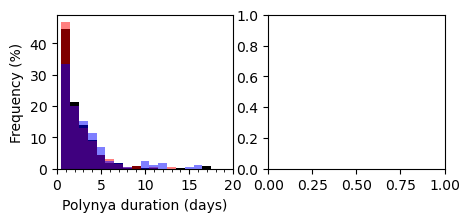

In [856]:
fig, axs = plt.subplots(1,2,figsize=(5,2))

bins = np.arange(0.5,30,1)
x = wind_durations
h = plotter.quick_hist(x, bin_edges = bins)
ax = axs[0]
ax.bar(h['centers'], 100*h['counts']/np.sum(h['counts']), align='center', width = np.diff(bins), 
       color='k')

x = ice_durations
h = plotter.quick_hist(x, bin_edges = bins)
ax = axs[0]
ax.bar(h['centers'], 100*h['counts']/np.sum(h['counts']), align='center', width = np.diff(bins), 
       color='r', alpha=0.5)


x = pol_durations
h = plotter.quick_hist(x, bin_edges = bins)
ax = axs[0]
ax.bar(h['centers'], 100*h['counts']/np.sum(h['counts']), align='center', width = np.diff(bins), 
       color='b', alpha=0.5)


# ax.set_xticks([1,5,10,15,20])
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_xlabel('Polynya duration (days)')
ax.set_xlim(0,20)
ax.set_ylabel('Frequency (%)')

In [105]:
# 20*units('km/day').to('cm/s')

11.6*units('cm/s').to('km/day')

<Quantity(10.0224, 'kilometer / day')>

In [364]:
yearss = np.arange(2003,2026)

-0.3638191927935925 0.1323644050449812
LinregressResult(slope=-0.05744192242524946, intercept=125.24303039972114, rvalue=-0.3638191927935925, pvalue=0.0960206595261915, stderr=0.03288493916042277, intercept_stderr=66.23363098719192)
0.45990042909220447 0.2115084046791938
LinregressResult(slope=0.01863860974511249, intercept=-36.74895874635517, rvalue=0.45990042909220447, pvalue=0.04132524528088272, stderr=0.008482267845058438, intercept_stderr=17.07531028726321)


Text(0.05, 0.7, 'slope=0.2')

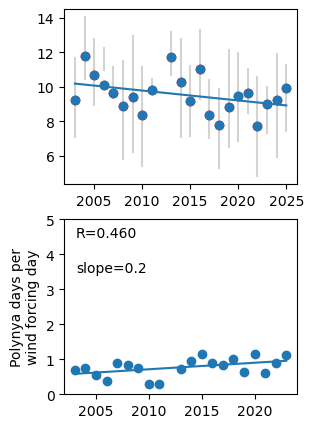

In [108]:
fig, axs = plt.subplots(2,1,figsize=(3,5))

all_ws = []


ax = axs[0]
for year in yearss[yearss!=2012]:
    
#     ax.scatter(year, np.nanpercentile(dfr.s10[(dfr.extent>0)&(dfr.year==year)&(dfr['final_day']==False)], 25), c='k', s=1)
#     ax.scatter(year, np.nanpercentile(dfr.s10[(dfr.extent>0)&(dfr.year==year)&(dfr['final_day']==False)], 50), c='k')
#     ax.scatter(year, np.nanpercentile(dfr.s10[(dfr.extent>0)&(dfr.year==year)&(dfr['final_day']==False)], 75), c='k', s=1)
    
    
    
    size_cond = (dfr.extent>0)&(dfr['final_day']==False)
    size_cond[(dfr['single_day']==True)] = True
    
    speeds = dfr.s10[size_cond&(dfr.year==year)]
    
    ax.scatter(year, np.nanmean(speeds), c='r')
    
    
    ax.plot([year,year], [np.nanpercentile(speeds, 25), np.nanpercentile(speeds, 75)], c='lightgray', zorder=-1)
    
    
#     all_ws.append(np.nanmean(dfr.s10[(dfr.extent>0)&(dfr.year==year)]))

    all_ws.append(np.nanmean(speeds))
    
    
x = yearss[yearss!=2012]
y = np.array(all_ws)


x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
res = stats.linregress(x_nn,y_nn)
R = res.rvalue
ax.scatter(x,y)
x_line = np.array([x_nn.min(), x_nn.max()])
y_line = res.intercept + res.slope*x_line
print(R, R**2)
print(res)
ax.plot(x_line, y_line)

ws_threshes = res.intercept + res.slope*np.arange(2003,2025)

ax = axs[1]

time_cond = ((yearss<2024)&(yearss!=2012))#&(yearss!=2016)

x = yearss[time_cond]
y = (all_pe/all_ie)[time_cond]


x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
res = stats.linregress(x_nn,y_nn)
R = res.rvalue
ax.scatter(x,y)
x_line = np.array([x_nn.min(), x_nn.max()])
y_line = res.intercept + res.slope*x_line
print(R, R**2)
print(res)
ax.plot(x_line, y_line)

ax.set_ylabel('Polynya days per\nwind forcing day')
ax.set_ylim(0,5)
ax.text(0.05,0.9, f'R={res.rvalue:.3f}', transform=ax.transAxes)
ax.text(0.05,0.7, f'slope={10*res.slope:.1f}', transform=ax.transAxes)

0.5338812668090688 0.28502920704965606
LinregressResult(slope=0.031079905309936064, intercept=-60.959945414373244, rvalue=0.5338812668090688, pvalue=0.015326402696743702, stderr=0.01160226825665196, intercept_stderr=23.356056910394788)
0.6328538721117899 0.40050402344688574
LinregressResult(slope=0.031056410761336008, intercept=-61.69774100063413, rvalue=0.6328538721117899, pvalue=0.0015725434458863383, stderr=0.008496224100505186, intercept_stderr=17.112264344238262)


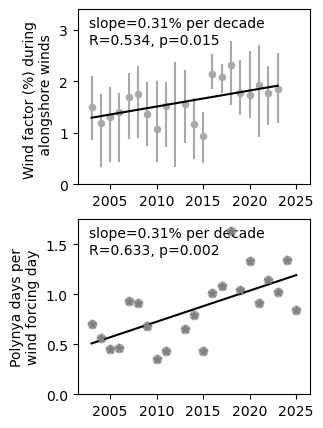

In [145]:
fig, axs = plt.subplots(2,1,figsize=(3,5))

all_ws = []


ax = axs[0]
x = yearss[time_cond]
y = (per50_wf)[time_cond]


x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
res = stats.linregress(x_nn,y_nn)
R = res.rvalue
ax.scatter(x,y, c='darkgray', s=20)
x_line = np.array([x_nn.min(), x_nn.max()])
y_line = res.intercept + res.slope*x_line
print(R, R**2)
print(res)
ax.plot(x_line, y_line ,c='k')

ax.text(0.05,0.8, f'R={res.rvalue:.3f}, p={res.pvalue:.3f}', transform=ax.transAxes)
ax.text(0.05,0.9, f'slope={res.slope*10:.2f}% per decade', transform=ax.transAxes)
ax.set_ylabel('Wind factor (%) during \n alongshore winds')
ax.set_ylim(0,3.4)


for p25, p75, y in zip(per25_wf, per75_wf, yearss):
    ax.plot([y,y], [p25, p75], c='darkgray', zorder=-1)
    
    
ax = axs[1]

time_cond = ((yearss<2026)&(yearss!=2012))#&(yearss!=2016)
# time_cond = ((yearss<2026)&(yearss!=2012))&(yearss!=2015)

x = yearss[time_cond]
y = (all_pe/all_we)[time_cond]
ax.scatter(x,y, c='gray', marker='*', zorder=100)

# time_cond = ((yearss<2026)&(yearss!=2012))#&(yearss!=2016)
# # time_cond = ((yearss<2026)&(yearss!=2012))&(yearss!=2015)

# x = yearss[time_cond]
# y = (all_pe/all_we)[time_cond]


x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
res = stats.linregress(x_nn,y_nn)
R = res.rvalue
ax.scatter(x,y, c='darkgray')
x_line = np.array([x_nn.min(), x_nn.max()])
y_line = res.intercept + res.slope*x_line
print(R, R**2)
print(res)
ax.plot(x_line, y_line, c='k')

ax.set_ylabel('Polynya days per\nwind forcing day')
ax.set_ylim(0,1.75)
ax.text(0.05,0.8, f'R={res.rvalue:.3f}, p={res.pvalue:.3f}', transform=ax.transAxes)
ax.text(0.05,0.9, f'slope={res.slope*10:.2f}% per decade', transform=ax.transAxes)
# ax.text(0.05,0.7, f'slope={10*res.slope:.1f}', transform=ax.transAxes)

for ax in axs:
    ax.set_xlim(2001.5,2026.5)
    
# fig.savefig('../figures/results/trends_in_wf.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [119]:
0.286*0.286

0.08179599999999998

In [ ]:
0.286*0.286

In [106]:
11.574074074/2

5.787037037

In [92]:
10 * units('km/day').to('cm/s')

<Quantity(11.5740741, 'centimeter / second')>

In [89]:
15 * units('cm/s').to('km/day')

<Quantity(12.96, 'kilometer / day')>

<BarContainer object of 22 artists>

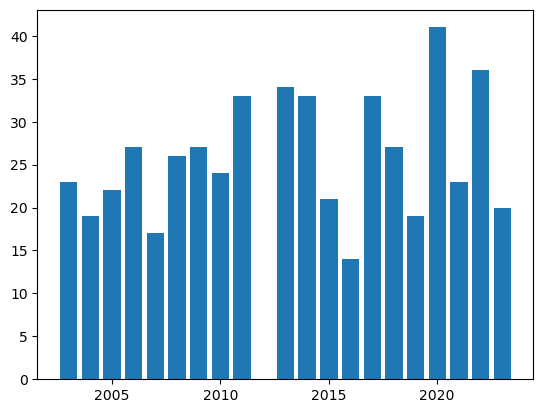

In [69]:
plt.bar(yearss[time_cond], per50_wf_numconsidered[time_cond])

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_9842/3577872852.py:57: RuntimeWarning: Mean of empty slice
  meant = np.sum(np.nanmean(dfr.t2m[yearr_cond]))


Text(2003.25, 87, '  Pack drift events (R=0.904)')

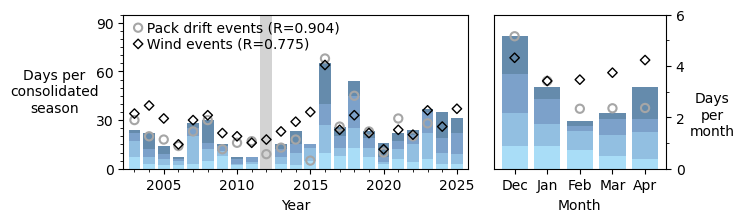

In [143]:
fig, axs = plt.subplots(1,2,figsize=(7,2), gridspec_kw={'width_ratios':[2,1]})

years = np.arange(2003,2026)
months = np.array([12,1,2,3,4])

# total events per year
annual_counts = [np.sum([pol_stats['counts'][month][year][0] for month in months]) for year in years]


mar1_kw = {'edgecolor': 'k', 'facecolor':'None', 'lw':1., 'marker':'D', 'zorder':10, 's':23}
mar2_kw = {'edgecolor': [0.65,0.65,0.65], 'facecolor':'None', 'lw':1.5, 'marker':'o', 's':35}


all_ie = []
all_pe = []
all_we = []
per50_wf = []
per50_wf_numconsidered = []
per25_wf = []
per75_wf = []
all_wf = []
all_nc = []
all_t2m = []

yearss = np.arange(2003,2026)

for yy, year in enumerate(yearss):
    
    month_colors = ['royalblue','skyblue','mediumpurple', 'lightcoral','r']
    
    yearr_cond = (dfr.year == year) 
#     yearr_cond = (dfr.year == year) & ([True if month in [12,1,2] else False for month in dfr.month])
#     yearr_cond = (dfr.year == year) & ([True if month in [3,4] else False for month in dfr.month])
    
    my_sizes = dfr['extent'][(dfr.extent>0)&(yearr_cond)].values
    
    num_events = len(dfr['extent'][((dfr.extent>0)&(yearr_cond))])
    all_pe.append(num_events)
    
    cts_by_size = {}
    for q, bnd in zip(['q1','q2','q3','q4'],
                      [(0,155), (155,545), (545,1715), (1715,100000)]):
        cts_by_size[q] = np.sum((my_sizes > bnd[0]) & (my_sizes <= bnd[1]))
        
   

    ax = axs[0]
    last_num = 0
    for color, q in zip([c1,c2,c3,c4],['q1','q2','q3','q4']):
        current_num = cts_by_size[q]       
        ax.bar(year, current_num, bottom = last_num, color=color, alpha=0.75)
        last_num+=current_num
        
    if year <= 2025:
        total_WE = np.sum(wind_cond(dfr[yearr_cond]))
        ax.scatter(year, total_WE, **mar1_kw)
        meant = np.sum(np.nanmean(dfr.t2m[yearr_cond]))
        all_we.append(total_WE)
        all_t2m.append(meant)
    else:
        all_we.append(np.nan)
        all_t2m.append(np.nan)
    
    if year <= 2023:
        total_IE = np.sum(ice_cond(dfr[yearr_cond]))
        ax.scatter(year, total_IE, **mar2_kw)
        all_ie.append(total_IE)
        
        WF = (dfr.si/dfr.s10)[(yearr_cond & (dfr.s10>3))&(wind_dir_cond(dfr))]
        
        all_nc.append(len(WF))
        
#         WF = (dfr.si/dfr.s10)[(yearr_cond & (dfr.s10>3))]
        
        all_wf.append(np.nanmean(WF))
        per50_wf.append(np.nanmedian(WF))
        per50_wf_numconsidered.append(len(WF))
        per25_wf.append(np.nanpercentile(WF, 25))
        per75_wf.append(np.nanpercentile(WF, 75))
    else:
        all_nc.append(np.nan)
        all_ie.append(np.nan)
        all_wf.append(np.nan)
        per50_wf.append(np.nan)
        per50_wf_numconsidered.append(np.nan)
        per25_wf.append(np.nan)
        per75_wf.append(np.nan)
        
ax.set_ylim(0,95)
ax.bar(2012, ax.get_xlim()[-1], color='lightgray', zorder=-11)
ax.set_xlim(2002.25,2025.75)
ax.set_ylabel('Days per\nconsolidated\nseason', rotation=0, labelpad=30, va='center')
ax.set_xlabel('Year')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(30))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))


for mm, month in enumerate(months):

    monthb_cond = (dfb.month == month)#&(dfb.season_end_flag==False)
    my_sizes = dfb['extent'][(dfb.extent>0)&(monthb_cond)].values
#     days_per_year_ice = np.sum(monthb_cond)/len(years[:-2])
    days_per_year_ice = np.sum(monthb_cond)/len(list(set(dfb.year[monthb_cond])))
    
    cts_by_size = {}
    for q, bnd in zip(['q1','q2','q3','q4'],[(0,155), (155,545), (545,1715), (1715,100000)]):
        cts_by_size[q] = np.sum((my_sizes > bnd[0]) & (my_sizes <= bnd[1]))

    ax = axs[1]
    last_num = 0
    for color, q in zip([c1,c2,c3,c4],['q1','q2','q3','q4']):
        current_num = cts_by_size[q]/days_per_year_ice
        ax.bar(mm, current_num, bottom = last_num, color=color, alpha=0.75)
        last_num+=current_num
        
    total_WE = np.sum(wind_cond(dfb[(dfb.month==month)]))
    ax.scatter(mm, total_WE/days_per_year_ice, **mar1_kw)
    
    total_IE = np.sum(ice_cond(dfb[dfb.month==month]))
    ax.scatter(mm, total_IE/days_per_year_ice, **mar2_kw)
        

    
ax.set_ylabel('Days\nper\nmonth', rotation=0, labelpad=20, va='center')
ax.set_xlabel('Month')
ax.set_xticks(range(len(months)))
ax.set_xticklabels(['Dec','Jan','Feb','Mar','Apr'])
ax.set_ylim(0,6)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))


#     ax.scatter(year, cts_by_size['q1'])
#     ax.scatter(year, cts_by_size['q2'])
    
#     for mm, month in enumerate(months):
        
#         current_num = np.sum(pol_stats['counts'][month][year])            
#         ax.bar(year, current_num, bottom = last_num, color=month_colors[mm], alpha=0.75)
#         last_num += current_num


# plt.scatter(years, annual_counts, c='k')
        
# axs[0].set_ylim(2,18)


all_ie = np.array(all_ie)
all_pe = np.array(all_pe)
all_we = np.array(all_we)
all_t2m = np.array(all_t2m)
all_wf = np.array(all_wf)
per25_wf = np.array(per25_wf)
per50_wf = np.array(per50_wf)
per50_wf_numconsidered = np.array(per50_wf_numconsidered)
per75_wf = np.array(per75_wf)

plt.subplots_adjust(wspace=0.1)


x = all_ie[((yearss>=2003)&(yearss<2024))&(yearss!=2012)]
y = all_pe[((yearss>=2003)&(yearss<2024))&(yearss!=2012)]
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
resp = stats.linregress(x_nn,y_nn)
Rp = resp.rvalue

x = all_we[((yearss>=2003)&(yearss<2024))&(yearss!=2012)]
y = all_pe[((yearss>=2003)&(yearss<2024))&(yearss!=2012)]
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
resa = stats.linregress(x_nn,y_nn)
Rw = resa.rvalue


ax = axs[0]
ax.scatter(2003.25,77, **mar1_kw)
ax.text(2003.25,77, f'  Wind events (R={Rw:.3f})', va='center')
ax.scatter(2003.25,87, **mar2_kw)
ax.text(2003.25,87, f'  Pack drift events (R={Rp:.3f})', va='center')


# fig.savefig('../figures/results/occurence_stats.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [21]:
wind_cond

array([False, False, False, ..., False, False, False])

In [805]:
len(list(set(dfb.year[monthb_cond])))

11

In [800]:
years[:-2][10:]

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [790]:
np.nanmean(dfr.s10[(df.extent>0)&(df.year>=2016)])

8.586905653149833

In [792]:
np.nanmean(dfr.s10[(df.extent>0)&(df.year<2005)])

9.451045320292847

0.9058458836221714 0.8205567648752325
LinregressResult(slope=0.9803326123390298, intercept=-5.857028262021746, rvalue=0.9058458836221714, pvalue=3.9077492529007874e-08, stderr=0.10805538819334855, intercept_stderr=3.556893863131427)


Text(0, 0.5, 'Polynya days per wind forcing')

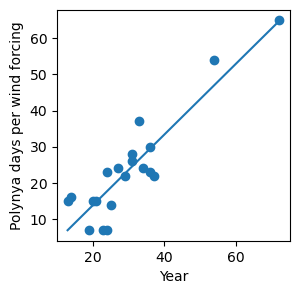

In [139]:
fig, ax = plt.subplots(figsize=(3,3))


time_cond = ((yearss<2024)&(yearss!=2012))#&(yearss!=2016)

x = all_ie[time_cond]
y = (all_pe)[time_cond]

# x = all_ie[time_cond]- y_line_i[time_cond]
# y = (all_pe)[time_cond]- y_line_p[time_cond]

# x = all_we[time_cond]- y_line_w[time_cond]
# y = (all_pe)[time_cond]- y_line_p[time_cond]

# x = all_we[time_cond]
# y = (all_pe)[time_cond]- y_line_p[time_cond]

# x = yearss[time_cond]
# y = (all_we)[time_cond] 


# x = all_wf[time_cond]
# y = (all_pe/all_we)[time_cond]


# x = all_we[time_cond]
# y = (all_pe)[time_cond]


x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
res = stats.linregress(x_nn,y_nn)
R = res.rvalue
ax.scatter(x,y)
x_line = np.array([x_nn.min(), x_nn.max()])
y_line = res.intercept + res.slope*x_line
print(R, R**2)
print(res)
ax.plot(x_line, y_line)


# y_line_i = res.intercept + res.slope*yearss

# y_line_p = res.intercept + res.slope*yearss
# y_line_w = res.intercept + res.slope*yearss

# ax.plot([0,80], [0,80], c='lightgray', zorder=-1)
# ax.set_xlim(0,80)
# ax.set_ylim(0,80)

ax.set_xlabel('Year')
ax.set_ylabel('Polynya days per wind forcing')


In [31]:
0.75*0.75

0.5625

In [744]:
np.sum(dfb[dfb.extent==0].ui > 0)/len(dfb.ui)

0.2654282115869018

In [745]:
np.sum(dfb[dfb.extent==0].ui < 0)/len(dfb.ui)

0.5371536523929471

In [746]:
np.sum(dfb[dfb.extent==0].u10 < 0)/len(dfb.u10)

0.4493073047858942

In [741]:
np.sum(dfb.ui > 0)/len(dfb.ui)

0.2899874055415617

In [742]:
np.sum(dfb.u10 > 0)/len(dfb.u10)

0.38003778337531485

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_70521/2231333989.py:20: RuntimeWarning: invalid value encountered in scalar divide
  ax.scatter(dd, np.sum(cond2)/np.sum(cond1), c='b')


(-0.05, 1.0)

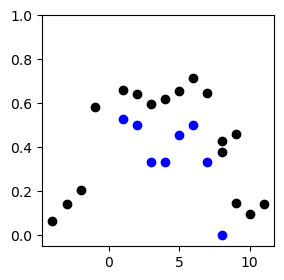

In [823]:
fig, ax = plt.subplots(figsize=(3,3))

#============
DF = dfr
#============

# &ice_cond(DF)
forc_cond = (wind_dir_cond(DF)&ice_dir_cond(DF))

for dd in [1,2,3,4,5,6,7,8,9]:
    
    cond1 = (DF.event_day == dd)
    cond2 = forc_cond & cond1
    
    ax.scatter(dd, np.sum(cond2)/np.sum(cond1), c='k')
    
    cond1 = (DF.event_day == dd)&(DF.event_length<=dd)
    cond2 = forc_cond & cond1
    
    ax.scatter(dd, np.sum(cond2)/np.sum(cond1), c='b')
    
    
for dd in [8]:
    
    cond1 = (DF.final_day == True)&(DF.single_day==False)
    cond2 = forc_cond & cond1
    
    ax.scatter(dd, np.sum(cond2)/np.sum(cond1), c='k')
    
    
for bb in [-4,-3,-2,-1]:
    
    cond1 = (DF.day_before_event == bb)
    cond2 = forc_cond & cond1
    
    ax.scatter(bb, np.sum(cond2)/np.sum(cond1), c='k')

    
for ff in [1,2,3]:
    
    cond1 = (DF.day_after_event == ff)
    cond2 = forc_cond & cond1
    
    ax.scatter(ff+dd, np.sum(cond2)/np.sum(cond1), c='k')

    
    


ax.set_ylim(-0.05,1)

In [687]:
DF.keys()

Index(['time', 'month', 'year', 'pre_2003', '2003_2023', 'compact', 'open',
       'q1', 'q2', 'q3', 'q4', 'extent', 'length95', 'length', 'width595',
       'width', 'ai', 'si', 'ui', 'vi', 'a10', 's10', 'u10', 'v10', 't2m',
       'msl', 'year_start', 'year_end', 'missing_sic', 'sequence', 'event_day',
       'day_before_event', 'day_after_event', 'overlap_flag', 'single_day',
       'season_start_flag', 'season_end_flag', 'first_day', 'final_day',
       'peak_day', 'event_length', 'after_event_length',
       'before_event_length'],
      dtype='object')

In [578]:
dfb['s10']

2420    6.346693
2421    7.142179
2422    3.541392
2423    6.322195
2424    4.594415
          ...   
5591    4.418390
5592    4.058508
5593    2.379839
5594    5.100697
5595    8.265788
Name: s10, Length: 3176, dtype: float64

In [600]:
np.sum(wind_dir_cond(dfb[dfb.extent>0]))/np.sum(dfb.extent>0)

0.7885835095137421

In [ ]:
np.sum(wind_dir_cond(dfb[dfb.extent>0]))/np.sum(dfb.extent>0)

In [596]:
cond1 = dfb['s10'][dfb.extent==0] > 7.5
cond2 = dfb['si'][dfb.extent==0] > 15

np.sum(cond1&cond2)/np.sum(dfb.extent==0)

0.06703253626029008

In [751]:
cond1 = wind_dir_cond(dfb[dfb.extent>0])
cond2 = ice_dir_cond(dfb[dfb.extent>0])

np.sum(cond1+cond2)/np.sum(dfb.extent>0)

0.86892177589852

In [754]:
cond1 = wind_dir_cond(dfb)
cond2 = ice_dir_cond(dfb)

np.sum(dfb[cond1&cond2].extent>0)/np.sum(cond1&cond2)

0.41435768261964734

In [760]:
cond1 = wind_cond(dfb)
cond2 = ice_cond(dfb)

np.sum(dfb[cond1&cond2].extent>0)/np.sum(cond1&cond2)

0.6708860759493671

In [756]:
cond1 = wind_cond(dfb)
cond2 = ice_cond(dfb)

np.sum(dfb[cond1].extent>0)/np.sum(cond1)

0.5346153846153846

In [758]:
np.sum(dfb[cond2].extent>0)/np.sum(cond2)

0.5483193277310925

In [656]:
cond1 = wind_dir_cond(dfb[dfb.extent==0])
cond2 = ice_dir_cond(dfb[dfb.extent==0])

np.sum(cond1&cond2)/np.sum(dfb.extent==0)

0.17444139553116425

In [653]:
cond1 = wind_dir_cond(dfb)
cond2 = ice_dir_cond(dfb)

np.sum(cond1&cond2)/len(cond1)

0.25

In [626]:
x = dfb.u10.values[dfb.extent==0]
y = dfb.v10.values[dfb.extent==0]
    
xp = x[np.isfinite(x)&np.isfinite(y)]
yp = y[np.isfinite(x)&np.isfinite(y)]

varell = tanalyze.variance_ellipses(xp,yp)
xm = vectors.comp_along_theta(xp, yp, varell['theta_m'] * units('rad'))
ym = vectors.comp_along_theta(xp, yp, (varell['theta_m']+np.pi/2) * units('rad'))

x2 = varell['xe']+ np.nanmean(xp)
y2 = varell['ye']+ np.nanmean(yp)

# convert
zenith = np.sqrt(x2**2 + y2**2)
azim = vectors.vector_angle(x2, y2).magnitude * np.pi/180

# convert
zenith_mean = np.sqrt(np.nanmean(xp)**2 + np.nanmean(yp)**2)
azim_mean = vectors.vector_angle(np.nanmean(xp), np.nanmean(yp)).magnitude * np.pi/180

print(azim_mean*180/np.pi, 180+varell['theta_m']*180/np.pi)

-145.23057461411858 180.20367460026523


In [605]:
varell

{'sxx': 72.96459448438875,
 'syy': 17.618230671272556,
 'sxy': -22.788888792298824,
 'theta_m': -0.3444536840264556,
 's11': 81.14024030233537,
 's22': 9.442584853325947,
 'a': 9.007787758508488,
 'b': 3.072878919405375,
 'xe': array([ 8.47867098,  8.52741297,  8.54181808,  8.52182831,  8.46752414,
         8.37912424,  8.25698456,  8.10159692,  7.91358701,  7.69371188,
         7.44285689,  7.16203213,  6.85236841,  6.51511261,  6.15162275,
         5.76336248,  5.35189519,  4.9188777 ,  4.46605362,  3.99524633,
         3.50835159,  3.00732995,  2.49419886,  1.97102451,  1.43991354,
         0.90300454,  0.36245947, -0.1795451 , -0.72082671, -1.2592058 ,
        -1.79251451, -2.31860541, -2.83536009, -3.34069778, -3.83258366,
        -4.30903708, -4.76813953, -5.20804236, -5.62697424, -6.02324829,
        -6.39526884, -6.7415379 , -7.06066116, -7.35135363, -7.6124448 ,
        -7.84288334, -8.04174136, -8.20821812, -8.34164329, -8.4414796 ,
        -8.50732505, -8.53891451, -8.536120

In [594]:
np.sum(dfb.extent[ice_cond(dfb)]>0)/np.sum(ice_cond(dfb))

0.5483193277310925

In [577]:
np.sum(cond1+cond2)/np.sum(dfb.extent>0)

0.733615221987315

In [575]:
np.sum(dfb['s10'][dfb.extent>0] > 7.5) / np.sum(dfb.extent>0)

0.6363636363636364

In [576]:
np.sum(dfb['si'][dfb.extent>0] > 15) / np.sum(dfb.extent>0)

0.6109936575052854

In [538]:
np.nanpercentile(dfb['s10'][ice_cond(dfb)], 25)

7.272265883528034

In [ ]:
np.nanmean(dfb['s10'][dfb.si >= 15])

In [523]:
15*units('cm/s').to('km/day')

<Quantity(12.96, 'kilometer / day')>

In [500]:
for cat in ['si', 's10']:
    
    print(cat)
    print(f'm+-std: {np.nanmean(dfr[cat]):.2f} +- {np.nanstd(dfr[cat]):.2f}')
    print(f'25th per: {np.nanpercentile(dfr[cat], 25):.2f}')
    print(f'50th per: {np.nanpercentile(dfr[cat], 50):.2f}')
    print(f'75th per: {np.nanpercentile(dfr[cat], 75):.2f}')
    print()
    
    
print('EXTENT > 0') 
for cat in ['si', 's10']:
    
    print(cat)
    print(f'm+-std: {np.nanmean(dfr[cat][dfr.extent>0]):.2f} +- {np.nanstd(dfr[cat][dfr.extent>0]):.2f}')
    print(f'25th per: {np.nanpercentile(dfr[cat][dfr.extent>0], 25):.2f}')
    print(f'40th per: {np.nanpercentile(dfr[cat][dfr.extent>0], 40):.2f}')
    print(f'50th per: {np.nanpercentile(dfr[cat][dfr.extent>0], 50):.2f}')
    print(f'75th per: {np.nanpercentile(dfr[cat][dfr.extent>0], 75):.2f}')
    print()

si
m+-std: 7.49 +- 7.63
25th per: 1.35
50th per: 4.39
75th per: 11.95

s10
m+-std: 5.71 +- 3.34
25th per: 3.05
50th per: 5.15
75th per: 7.82

EXTENT > 0
si
m+-std: 16.90 +- 8.06
25th per: 10.38
40th per: 15.16
50th per: 17.47
75th per: 23.07

s10
m+-std: 8.75 +- 3.58
25th per: 6.09
40th per: 7.88
50th per: 9.13
75th per: 11.19



In [133]:
DF.keys()

Index(['time', 'month', 'year', 'pre_2003', '2003_2023', 'compact', 'open',
       'q1', 'q2', 'q3', 'q4', 'extent', 'length_145', 'length_max',
       'centermass_length', 'length_p95', 'centermass_direction',
       'max_length_direction', 'width595', 'width', 'ai', 'si', 'ui', 'vi',
       'a10', 's10', 'u10', 'v10', 't2m', 'msl', 'year_start', 'year_end',
       'missing_sic', 'sequence', 'event_day', 'day_before_event',
       'day_after_event', 'overlap_flag', 'single_day', 'season_start_flag',
       'season_end_flag', 'first_day', 'final_day', 'peak_day', 'event_length',
       'after_event_length', 'before_event_length', 'esei', 'ese10'],
      dtype='object')

a10_r
[260 265 270 275 280 285 290 295 300]
0.7961783439490446
[255 260 265 270 275 280 285 290 295]
0.8046709129511678
ai_r
[270 275 280 285 290 295 300 305 310]
0.7770700636942676
[260 265 270 275 280 285 290 295 300 305 310]
0.8386411889596603
centermass_direction_r
[290 295 300 305 310 315 320 325]
0.8222698072805139
[280 285 290 295 300 305 310 315 320 325]
0.9036402569593146


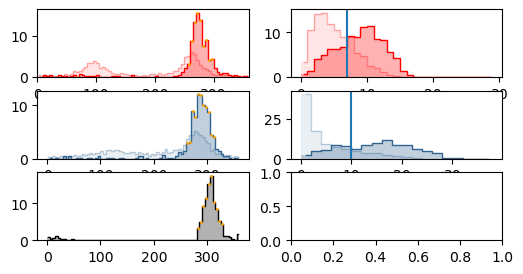

In [324]:

# create plot
fig, AXS = plt.subplots(3,2, figsize=(6,3), subplot_kw={'projection': None})


#============
# DF = df[(df.year>=1987)&(df.year<2026)]
DF = dfb
# DF = df[(df.year>=2016)&(df.year<2024)]
# DF = df[(df.year>=2003)&(df.year<2016)]
#============

ccolor = c4
bcolor = 'red'

not_final_day = (DF.final_day == False)
not_final_day[DF.first_day==True] = True

bins = np.arange(0,361,5)
comp_ = (DF.extent==0)
# comp_ = (DF.extent>0)
open_ = (DF.extent>0)#&(not_final_day)
# open_strict = (DF.extent>0)&(DF.final_day == False)
# base_cond = (daily_data['ppd']['year'] >= 2003)&(daily_data['ppd']['year'] < 2024)


axs = AXS.ravel()

for ax, group, color in zip([axs[0], axs[2], axs[4]], 
                            ['a10_r', 'ai_r', 'centermass_direction_r'],
                            [bcolor, ccolor, 'k']):
    
#     x = DF[f'a{group}'][comp_]
#     x[x<0]+=360
#     h = plotter.quick_hist(x, bin_edges = bins)


    x = DF[f'{group}'][open_]
    h2 = plotter.quick_hist(x, bin_edges = bins)


    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, 100*h2['prob'], width=width, bottom=0.0, alpha=0.3, color=color, zorder=-1)
    ax.step(theta, 100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=-1)

    
    if group != 'centermass_direction_r':
        x = DF[f'{group}'][comp_]
        h = plotter.quick_hist(x, bin_edges = bins)

        theta = h['centers']
        width = h['w']
        ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.1, color=color, zorder=-1)
        ax.step(theta, 100*h['prob'], where='mid', alpha=0.3, color=color,lw=1, zorder=-1)

    # Plot bars
#     theta = h['centers']
#     width = h['w']
#     ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.6, color=ccolor, zorder=0)
#     ax.step(theta, 100*h['prob'], where='mid', alpha=1, color=ccolor,lw=1, zorder=0)
    
    print(group)
#     ax.axvline((90-165)+360, c='k', ls='dashed')
#     ax.axvline((90-165-180)+360, c='k', ls='dashed')
    
    
    
    COND = (h2['prob']>1.25*h['prob'])&(h2['prob']>0.02)
    print(h2['edges'][:-1][COND])
    print(np.sum(h2['prob'][COND]))
#     print(h2['centers'][np.argmax(h2['prob'])])
    
    COND = (h2['prob']>0.025)
    print(h2['edges'][:-1][COND])
    print(np.sum(h2['prob'][COND]))
    
    ax.scatter(h2['centers'][COND], 100*h2['prob'][COND], s=1, c='orange')
    
#     ax.set_ylim(0,20)
    
#     ax.set_xlim(0,360)

    
ax = axs[0]
# ax.axvline((90-165)+360, c='k', ls='dashed')

ax.set_xlim(0,360)


for ax, group, color, bins in zip([axs[1], axs[3]], 
                            ['s10', 'si_km',],
                            [bcolor, ccolor], [np.arange(0,30,1), np.arange(0,40,2)]):
    
    
    x = DF[f'{group}'][open_]
    h2 = plotter.quick_hist(x, bin_edges = bins)


    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, 100*h2['prob'], width=width, bottom=0.0, alpha=0.3, color=color, zorder=-1)
    ax.step(theta, 100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=-1)
    
    x = DF[f'{group}'][comp_]
    h = plotter.quick_hist(x, bin_edges = bins)

    theta = h['centers']
    width = h['w']
    ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.1, color=color, zorder=-1)
    ax.step(theta, 100*h['prob'], where='mid', alpha=0.3, color=color,lw=1, zorder=-1)
    
ax = axs[1]
ax.axvline(7)

ax = axs[3]
ax.axvline(10)

10
260
270
280
290
300
310
320


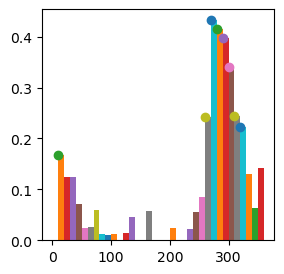

In [323]:
fig, ax = plt.subplots(figsize=(3,3))

bins = np.arange(0,361,10)

not_final_day = (DF.final_day == False)
not_final_day[DF.first_day==True] = True

#===========
DF = dfb
#===========

var = 'a10_r'
# var = 'ai_r'

tot = 0
for bb in range(len(bins)-1):
    
    bbmin = bins[bb]
    bbmax = bins[bb+1]
    dbb = np.diff(bins)[0]
    bbmid = bbmin + dbb/2
    
#     within_range = ((DF[var] >= bbmin) & (DF[var] < bbmax)) & (DF['s10']>6.5)
    within_range = ((DF[var] >= bbmin) & (DF[var] < bbmax))# & (DF['si_km']>11.5)
    
#     frac = np.sum((DF.extent[within_range]>0)&(not_final_day[within_range]))/np.sum(within_range)
    frac = np.sum((DF.extent[within_range]>0))/np.sum(within_range)
    
    plt.bar(bbmin, frac, width = dbb, align='edge')
    
    if frac > 0.15:
        ax.scatter(bbmin, frac)
        print(bbmin)
        tot+=frac

In [ ]:
270-310

In [ ]:
270-340

In [ ]:
260-320

In [350]:
WITHIN = ((DF['a10_r'] > 260) & (DF['a10_r'] < 305))# & (DF['s10']>6.5)
np.sum(DF.extent[WITHIN]>0)/np.sum(DF.extent>0)

0.7961783439490446

In [351]:
WITHIN = (DF['ai_r'] > 270) & (DF['ai_r'] < 315) #& (DF['si_km']>11.5)
np.sum(DF.extent[WITHIN]>0)/np.sum(DF.extent>0)

0.7770700636942676

In [346]:
WITHIN = ((DF['a10_r'] > 260) & (DF['a10_r'] < 305)) & (DF['s10']>6.5)
np.sum(WITHIN&(DF.extent>0))/np.sum(WITHIN)

0.48822605965463106

In [348]:
WITHIN = ((DF['ai_r'] > 270) & (DF['ai_r'] < 315)) & (DF['si_km']>11.5)
np.sum(WITHIN&(DF.extent>0))/np.sum(WITHIN)

0.5100182149362478

In [582]:
tot

2.2938361994332017

In [590]:
260 - 330

-70

In [2378]:
305-260

45

In [2379]:
315-270

45

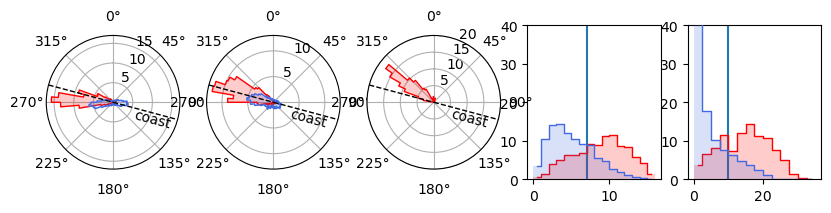

In [1632]:

# create plot
fig, AXS = plt.subplots(1,5, figsize=(10,2), subplot_kw={'projection': None})

axs = AXS.ravel()
# Override specific subplots to be polar using add_subplot
fig.delaxes(axs[0])
fig.delaxes(axs[1])
fig.delaxes(axs[2])
axs[0] = fig.add_subplot(1,5, 1, projection='polar')
axs[1] = fig.add_subplot(1,5, 2, projection='polar')
axs[2] = fig.add_subplot(1,5, 3, projection='polar')

for ax in [axs[0], axs[1], axs[2]]:
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(zorder=-1)

#============
DF = dfb

# DF = df[(df.year>=2003)&(df.year<2016)]
# DF = df[(df.year>=2016)&(df.year<2026)]
#============

ccolor = c2
bcolor = 'red'

bins = np.arange(0,361,5)
comp_ = (DF.extent==0)
# open_ = (DF.extent>0)&(not_last_day)
open_ = (DF.extent>0)#&(not_last_day)

# open_ = DF.day_before_event == -1
# open_ = ((DF.extent>0)&(not_last_day)) + (DF.day_before_event == -1)
# open_strict = (open_)&(DF.final_day == False)
# base_cond = (daily_data['ppd']['year'] >= 2003)&(daily_data['ppd']['year'] < 2024)
#  'centermass_direction_r'
for ax, group, cond, color, scale in zip([axs[0], axs[0], ], 
                            ['a10_r', 'a10_r',], [open_ , comp_], 
                            ['r', 'royalblue', ], [1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers'] * np.pi/180
    width = h2['w']* np.pi/180
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
    
    
    
for ax, group, cond, color, scale in zip([axs[1], axs[1], ], 
                            ['ai_r', 'ai_r',], [open_ , comp_], 
                            ['r', 'royalblue', ], [1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers'] * np.pi/180
    width = h2['w']* np.pi/180
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
ax = axs[2]
x = DF[f'centermass_direction_r'][open_]
h2 = plotter.quick_hist(x, bin_edges = bins)
color = 'r'
scale = 1
theta = h2['centers'] * np.pi/180
width = h2['w']* np.pi/180
ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
    
    
    
axs[0].set_ylim(0,17)
axs[1].set_ylim(0,13)
axs[2].set_ylim(0,20)
for ax, R in zip([axs[0], axs[1], axs[2]], [5,3,5]):
    th = (90+15)*np.pi/180
    ax.plot([th, th], [0,ax.get_ylim()[1]], c='k', ls='dashed', lw=1, zorder=100)
    ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='k', ls='dashed', lw=1, zorder=100)
    ax.text((90+15)*np.pi/180, R, 'coast', rotation = -15, va='top')
    
    
    
    
# SPEEDS

bins = np.arange(0,17,1)
for ax, group, cond, color in zip([axs[3], axs[3], ], 
                            ['s10', 's10',], [open_ , comp_], 
                            ['r', 'royalblue', ]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)
    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, 100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, 100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
ax.axvline(7) 
    
bins = np.arange(0,36,2.5)
for ax, group, cond, color in zip([axs[4], axs[4], ], 
                            ['si_km', 'si_km',], [open_ , comp_], 
                            ['r', 'royalblue', ]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)
    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, 100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, 100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
ax.axvline(10) 

for ax in [axs[3], axs[4]]:
    ax.set_ylim(0,40)

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_35446/2857542963.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['N','','E','','S','','W '])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_35446/2857542963.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['N','','E','','S','','W '])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_35446/2857542963.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['N','','E','','S','','W '])


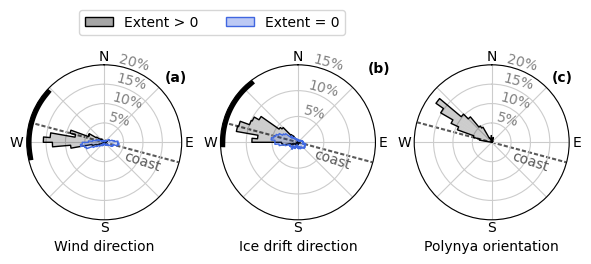

In [1445]:

# create plot
fig, axs = plt.subplots(1,3, figsize=(7,3), subplot_kw={'projection': 'polar'})

# axs = AXS.ravel()
# # Override specific subplots to be polar using add_subplot
# fig.delaxes(axs[0])
# fig.delaxes(axs[1])
# fig.delaxes(axs[2])
# axs[0] = fig.add_subplot(1,5, 1, projection='polar')
# axs[1] = fig.add_subplot(1,5, 2, projection='polar')
# axs[2] = fig.add_subplot(1,5, 3, projection='polar')

for ax in axs:
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(zorder=-1)
    ax.set_xticklabels(['N','','E','','S','','W '])
    ax.grid(color=[0.8,0.8,0.8])
    ax.tick_params(axis='x', pad=-5)

#============
DF = dfb

# DF = df[(df.year>=2003)&(df.year<2016)]
# DF = df[(df.year>=2016)&(df.year<2026)]
#============

ccolor = c2
bcolor = 'red'

bins = np.arange(0,361,5)
comp_ = (DF.extent==0)
open_ = (DF.extent>0)

for ax, group, cond, color, scale in zip([axs[0], axs[0], ], 
                            ['a10_r', 'a10_r',], [open_ , comp_], 
                            ['k', 'royalblue', ], [1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers'] * np.pi/180
    width = h2['w']* np.pi/180
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
    
    
    
for ax, group, cond, color, scale in zip([axs[1], axs[1], ], 
                            ['ai_r', 'ai_r',], [open_ , comp_], 
                            ['k', 'royalblue', ], [1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers'] * np.pi/180
    width = h2['w']* np.pi/180
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
ax = axs[2]
x = DF[f'centermass_direction_r'][open_]
h2 = plotter.quick_hist(x, bin_edges = bins)
color = 'k'
scale = 1
theta = h2['centers'] * np.pi/180
width = h2['w']* np.pi/180
ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
    
    
ax = axs[0]
ax.set_ylim(0,20)
ax.set_yticks([5,10,15,20])

ax = axs[1]
ax.set_ylim(0,15)
ax.set_yticks([5,10,15])

ax = axs[2]
ax.set_ylim(0,20)
ax.set_yticks([5,10,15,20])

for ax in axs:
    ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()])
    ax.tick_params(axis='y', labelrotation=-15, colors='gray')
    ax.set_rlabel_position(10)
    
for ax, R in zip([axs[0], axs[1], axs[2]], [5,3,5]):
    th = (90+15)*np.pi/180
    ls_kw = {'c':[0.35,0.35,0.35], 'ls':'dashed', 'dashes':(2, 1), 'lw':1.5, 'zorder':-100}
    ax.plot([th, th], [0,ax.get_ylim()[1]], **ls_kw)
    ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], **ls_kw)
    ax.text((90+15+5)*np.pi/180, R, 'coast', color=[0.35,0.35,0.35], rotation = -18, va='top')
    
    
    
    
    


    
axs[0].text(np.pi/4, 22, '(a)', weight='bold', clip_on=False)
axs[1].text(np.pi/4, 19, '(b)', weight='bold', clip_on=False)
axs[2].text(np.pi/4, 22, '(c)', weight='bold', clip_on=False)


ax = axs[0]
th1 = 260*np.pi/180
th2 = 310*np.pi/180
ax.plot(np.linspace(th1,th2,20), np.full(20,ax.get_ylim()[1]), c=color, ls='solid', lw=7)
ax.set_xlabel('Wind direction') 

ax = axs[1]
th1 = 270*np.pi/180
th2 = 320*np.pi/180
ax.plot(np.linspace(th1,th2,20), np.full(20,ax.get_ylim()[1]), c=color, ls='solid', lw=7)
ax.set_xlabel('Ice drift direction') 
    
ax = axs[2]
# th1 = 290*np.pi/180
# th2 = 325*np.pi/180
# ax.plot(np.linspace(th1,th2,20), np.full(20,ax.get_ylim()[1]), c=color, ls='solid', lw=5)
ax.set_xlabel('Polynya orientation') 

patch1 = mpatches.Patch(edgecolor=(0,0,0,1), facecolor=(0,0,0,0.35),  label='Extent > 0')
patch2 = mpatches.Patch(edgecolor=(0.25,0.4,0.88,1), facecolor=(0.25,0.4,0.88,0.35),  label='Extent = 0')  
axs[0].legend(handles=[patch1, patch2], ncols=2, bbox_to_anchor=(2.1,1.4))

plt.subplots_adjust(wspace=0.25)

# fig.savefig('../figures/results/forcing_distributions.png', dpi=400, bbox_inches='tight')

In [2443]:
325-290

35

In [2286]:
[f'{tick:.0f}%' for tick in ax.get_yticks()]

['5%', '10%', '15%', '20%']

In [2284]:
[f'{tick:.0f}%' for tick in ax.get_yticks()]

['5%', '10%', '15%', '20%']

<>:128: SyntaxWarning: invalid escape sequence '\m'
<>:144: SyntaxWarning: invalid escape sequence '\m'
<>:128: SyntaxWarning: invalid escape sequence '\m'
<>:144: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/1911932392.py:128: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Wind\nspeed\n($\mathrm{m\;s^{-1}}$)', c=wind_color, rotation=0, labelpad=20, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/1911932392.py:144: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Ice drift\nspeed\n($\mathrm{km\;d^{-1}}$)', c=ice_color, rotation=0, labelpad=25, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60907/1911932392.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['N','','E','','S','','W ']);
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipyker

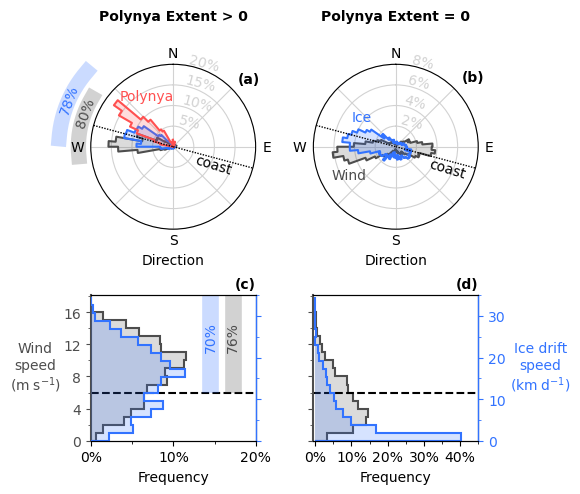

In [1804]:

# create plot
fig, AXS = plt.subplots(2,2, figsize=(5,5), subplot_kw={'projection': None}, gridspec_kw={'height_ratios':[1.25,1]})

axs = AXS.ravel()
# Override specific subplots to be polar using add_subplot
fig.delaxes(axs[0])
fig.delaxes(axs[1])
axs[0] = fig.add_subplot(2,2, 1, projection='polar')
axs[1] = fig.add_subplot(2,2, 2, projection='polar')


grid_color = [0.825,0.825,0.825]


for ax in axs[:2]:
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(zorder=-1)
    ax.set_xticklabels(['N','','E','','S','','W ']);
    ax.grid(color=grid_color)
    ax.tick_params(axis='x', pad=-2.5)

#============
DF = dfb

# DF = df[(df.year>=2003)&(df.year<2016)]
# DF = df[(df.year>=2016)&(df.year<2026)]
#============

bins = np.arange(0,361,5)
comp_ = (DF.extent==0)
open_ = (DF.extent>0)

#============
# ice_color = [25/255,135/255,255/255]#'royalblue'
ice_color = [0.19607843137254902, 0.45098039215686275, 1.0]
# wind_color = 'r'
# wind_color = [255/255,135/255,0/255] # orange
# wind_color = [255/255,80/255,80/255]
wind_color = [0.3,0.3,0.3]
#============

for ax, group, cond, color, scale in zip([axs[0], axs[0], axs[0]], 
                            ['a10_r', 'ai_r', 'centermass_direction_r'], [open_ , open_, open_], 
                            [wind_color, ice_color, [255/255,80/255,80/255]], [1,1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers'] * np.pi/180
    width = h2['w']* np.pi/180
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1.5, zorder=3)
    
    
for ax, group, cond, color, scale in zip([axs[1], axs[1]], 
                            ['a10_r', 'ai_r', ], [comp_ , comp_,], 
                            [wind_color, ice_color,], [1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers'] * np.pi/180
    width = h2['w']* np.pi/180
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1.5, zorder=3)
    
      
    
axs[0].set_ylim(0,20)
axs[1].set_ylim(0,8)
axs[1].set_yticks([2,4,6,8])
for ax in axs[:2]:
    ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()])
#     ax.set_yticklabels([f'{tick:.0f}%' if tt%2==1 else '' for tt, tick in enumerate(ax.get_yticks())])
    ax.tick_params(axis='y', labelrotation=-15, colors=grid_color, pad=5)
    ax.set_rlabel_position(10)

for ax, R in zip([axs[0], axs[1]], [5,3.25,]):
    th = (90+15)*np.pi/180
    ax.plot([th, th], [0,ax.get_ylim()[1]], c='k', ls='dashed',dashes=(1,1), lw=1, zorder=100)
    ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='k', ls='dashed',dashes=(1,1), lw=1, zorder=100)
    ax.text((90+17)*np.pi/180, R, 'coast', rotation = -17, va='top')

    
# SPEED BINS
#_________________

bins = np.arange(0,17,1)
for ax, group, cond, color in zip([axs[2], axs[3], ], 
                            ['s10', 's10',], [open_ , comp_], 
                            [wind_color,wind_color, ]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)
    theta = h2['centers']
    width = h2['w']
    ax.barh(theta, 100*h2['prob'], height=width, left=0.0, alpha=0.2, color=color, zorder=-100)
    ax.stairs(100*h2['prob'], edges=h2['edges'],orientation='horizontal', alpha=1, color=color,lw=1.5, zorder=-100)



bins = np.arange(0,35,1.92)
ax2 = axs[2].twinx()
ax3 = axs[3].twinx()
for ax, group, cond, color in zip([ax2, ax3, ], 
                            ['si_km', 'si_km',], [open_ , comp_], 
                            [ice_color, ice_color, ]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)
    theta = h2['centers']
    width = h2['w']
    ax.barh(theta, 100*h2['prob'], height=width, left=0.0, alpha=0.2, color=color, zorder=-100)
    ax.stairs(100*h2['prob'], edges=h2['edges'], orientation='horizontal', alpha=1, color=color,lw=1.5, zorder=-100)



for ax in axs[2:]:
    ax.set_ylim(0,18.14)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(4))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
    ax.spines['left'].set_color(wind_color)
    ax.spines['left'].set_linewidth(1.5)
    ax.tick_params(axis='y', which='both', color=wind_color, labelcolor=wind_color)
    
ax = axs[2]
ax.set_ylabel('Wind\nspeed\n($\mathrm{m\;s^{-1}}$)', c=wind_color, rotation=0, labelpad=20, va='center')
ax = axs[3]
ax.set_yticklabels([])


for ax in [ax2,ax3]:
    ax.set_ylim(0,35)
    ax.yaxis.tick_right()
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.spines['right'].set_color(ice_color)
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_color('None')
    ax.tick_params(axis='y', which='both', color=ice_color, labelcolor=ice_color)
    
ax = ax3
ax.set_ylabel('Ice drift\nspeed\n($\mathrm{km\;d^{-1}}$)', c=ice_color, rotation=0, labelpad=25, va='center')
ax = ax2
ax.set_yticklabels([])
    
    
    
axs[2].set_xlim(-0.05,20)   
axs[3].set_xlim(-0.5,45)   
for ax in axs[2:]:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.set_xlabel('Frequency')
    ax.set_xticklabels([f'{tick:.0f}%' for tick in ax.get_xticks()])

axs[0].text(0.5, 1.25, 'Polynya Extent > 0', weight='bold', ha='center', va='bottom', transform=axs[0].transAxes)
axs[1].text(0.5, 1.25, 'Polynya Extent = 0', weight='bold', ha='center', va='bottom', transform=axs[1].transAxes)

axs[0].text(np.pi/4, 22, '(a)', weight='bold', clip_on=False)
axs[1].text(np.pi/4, 9, '(b)', weight='bold', clip_on=False)

axs[2].text(1, 1.05, '(c)', weight='bold', ha='right', clip_on=False, transform=axs[2].transAxes)
axs[3].text(1, 1.05, '(d)', weight='bold', ha='right', clip_on=False, transform=axs[3].transAxes)

buffer = 4 # shorten because line too wide

ax = axs[0]
th1 = (270+buffer)*np.pi/180
th2 = (315-buffer)*np.pi/180
ax.plot(np.linspace(th1,th2,15), np.full(15,27.75), alpha=0.25, c=ice_color, ls='solid', lw=11, clip_on=False, zorder=-1000)
ax.text((285)*np.pi/180, 29, '78%', c=ice_color, rotation = 70, va='bottom')
th1 = (260+buffer)*np.pi/180
th2 = (305-buffer)*np.pi/180
ax.plot(np.linspace(th1,th2,15), np.full(15,23), alpha=0.25, c=wind_color, ls='solid', lw=11, clip_on=False, zorder=-1000)
ax.text((280)*np.pi/180, 24.5, '80%', c=wind_color, rotation = 70, va='bottom')
ax.set_xlabel('Direction') 
ax = axs[1]
ax.set_xlabel('Direction') 

for ax, xx,ll in zip(axs[2:], [14,23], ['73%', '31%']):
    ax.axhline(6,c='k', ls='dashed')
#     ax.axhline(6.5,c=ice_color, ls='dashed', dashes=(5,5))
    
# ax = axs[3]
# ax.text(25, 7.25, '$\mathrm{6.5\;m\;s^{-1}}$', c=wind_color, ha='center');
# ax.text(25, 4.25, '$\mathrm{10\;km\;d^{-1}}$', c=ice_color, ha='center');
    
    
axs[1].text(243*np.pi/180, 7, 'Wind', c=wind_color)
axs[1].text(300*np.pi/180, 5, 'Ice', c=ice_color)

axs[0].text(311*np.pi/180, 17.35, 'Polynya', c=[255/255,80/255,80/255])

plt.subplots_adjust(hspace=0.35, wspace=0.35)


ax = axs[2]
ax.plot([14.5,14.5],[7.1,30], alpha=0.25, c=ice_color, ls='solid', lw=12,)
ax.text(14.5, 11, '70%', c=ice_color, rotation = 90, va='bottom', ha='center')
ax.plot([17.25,17.25],[7.1,30], alpha=0.25, c=wind_color, ls='solid', lw=12,)
ax.text(17.25, 11, '76%', c=wind_color,rotation = 90, va='bottom', ha='center')

fig.savefig('../figures/results/forcing_distributions.png', dpi=400, bbox_inches='tight')

In [1781]:
6 * (0.019290123456790122*100) * units('cm/s').to('km/day')

<Quantity(10.0, 'kilometer / day')>

In [1768]:
1*(0.0192901234*100)

1.92901234

In [1777]:
35 / (0.0192901234*100)

19.444444444444446

In [1764]:
10*units('km/day').to('m/s') / 6

<Quantity(0.0192901235, 'meter / second')>

In [1782]:
np.sum(speed_conds(DF[DF.extent>0], 'ice'))/np.sum(DF.extent>0)

0.7006369426751592

In [1783]:
np.sum(speed_conds(DF[DF.extent>0], 'wind'))/np.sum(DF.extent>0)

0.7622080679405521

In [813]:
np.sum(dir_conds(DF[DF.extent>0], 'ice'))/np.sum(DF.extent>0)

0.7770700636942676

In [812]:
np.sum(dir_conds(DF[DF.extent>0], 'wind'))/np.sum(DF.extent>0)

0.7961783439490446

In [702]:
0.0178 * 1 * units('m/s').to('km/day')

<Quantity(1.53792, 'kilometer / day')>

In [742]:
26*units('km/day').to('cm/s').to('m/s') * (1/0.0178)

<Quantity(16.9059509, 'meter / second')>

In [ ]:
30*units('km/day').to('cm/s').to('m/s') * (1/0.0178)

In [699]:
30.75*units('km/day').to('cm/s').to('m/s') * (1/0.0178)

<Quantity(19.9945381, 'meter / second')>

In [691]:
10*units('km/day').to('cm/s').to('m/s') * (1/0.0178)

<Quantity(6.50228881, 'meter / second')>

In [721]:
np.sum(speed_conds(DF[DF.extent==0], 'ice'))/np.sum(DF.extent==0)

0.18527222875048963

In [723]:
np.sum(speed_conds(DF[DF.extent>0], 'ice'))/np.sum(DF.extent>0)

0.7006369426751592

In [665]:
np.sum(speed_conds(DF[DF.extent>0], 'ice'))/np.sum(DF.extent>0)

0.7006369426751592

In [666]:
color1

[0.19607843137254902, 0.45098039215686275, 1.0]

In [168]:
0.02*20*units('m/s').to('cm/s').to('km/day')

<Quantity(34.56, 'kilometer / day')>

In [135]:
0.02*1*units('m/s').to('cm/s').to('km/day')

<Quantity(1.728, 'kilometer / day')>

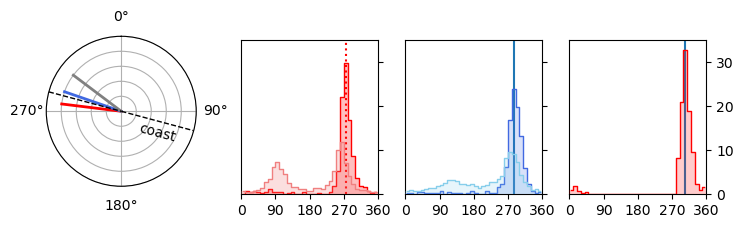

In [2371]:

# create plot
fig, AXS = plt.subplots(1,3, figsize=(6,2), subplot_kw={'projection': None})

axs = AXS.ravel()
# Override specific subplots to be polar using add_subplot
# fig.delaxes(axs[0])
# fig.delaxes(axs[1])
# fig.delaxes(axs[2])
# axs[0] = fig.add_subplot(1,5, 1, projection='polar')
# axs[1] = fig.add_subplot(1,5, 2, projection='polar')
# axs[2] = fig.add_subplot(1,5, 3, projection='polar')

# for ax in [axs[0]]:
#     ax.set_theta_zero_location("N")
#     ax.set_theta_direction(-1)
#     ax.grid(zorder=-1)






#============
DF = dfb

# DF = df[(df.year>=2003)&(df.year<2016)]
# DF = df[(df.year>=2016)&(df.year<2026)]
#============


for ax in [axs[0], axs[1]]:
    ax.set_xlim(0,360)

ccolor = c2
bcolor = 'red'

bins = np.arange(0,361,10)
comp_ = (DF.extent==0)
# open_ = (DF.extent>0)&(not_last_day)
open_ = (DF.extent>0)#&(not_last_day)

# open_ = DF.day_before_event == -1
# open_ = ((DF.extent>0)&(not_last_day)) + (DF.day_before_event == -1)
# open_strict = (open_)&(DF.final_day == False)
# base_cond = (daily_data['ppd']['year'] >= 2003)&(daily_data['ppd']['year'] < 2024)
#  'centermass_direction_r'
for ax, group, cond, color, alpha in zip([axs[0], axs[0], ], 
                            ['a10_r', 'a10_r',], [open_ , comp_], 
                            ['r', 'lightcoral', ], [1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, 100*h2['prob'], width=width, bottom=0.0, alpha=0.25, color=color, zorder=3)
    ax.step(theta, 100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
    
    
    
for ax, group, cond, color, scale in zip([axs[1], axs[1], ], 
                            ['ai_r', 'ai_r',], [open_ , comp_], 
                            ['royalblue', 'skyblue', ], [1,1]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
for ax, group, cond, color, scale in zip([axs[2], ], 
                            ['centermass_direction_r', ], [open_ ], 
                            ['r', ], [1,]):

    x = DF[f'{group}'][cond]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers']
    width = h2['w']
    ax.bar(theta, scale*100*h2['prob'], width=width, bottom=0.0, alpha=0.2, color=color, zorder=3)
    ax.step(theta, scale*100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=3)
    
for ax in axs:
    ax.set_xlim(0,360)
    ax.set_xticks([0,90,180,270,360])
    ax.set_ylim(0,35)
    ax.yaxis.tick_right()
    
for ax in axs[:-1]:
    ax.set_yticklabels([])

    
    
ax = axs[0]
ax.axvline((90-173)+360, c='r', ls='dotted')

ax = axs[1]
ax.axvline((90-165)+360)

ax = axs[2]
ax.axvline((90-145)+360)

# axs[0].set_ylim(0,20)
# axs[1].set_ylim(0,15)
# axs[2].set_ylim(0,20)
# for ax, R in zip([axs[0], axs[1], axs[2]], [5,3,5]):
#     th = (90+15)*np.pi/180
#     ax.plot([th, th], [0,ax.get_ylim()[1]], c='k', ls='dashed', lw=1, zorder=100)
#     ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='k', ls='dashed', lw=1, zorder=100)
#     ax.text((90+15)*np.pi/180, R, 'coast', rotation = -15, va='top')
    
    
AX = fig.add_axes([-0.45, 0.15, 0.75, 0.75], projection='polar') # inset polar axes
ax = AX
ax.set_ylim(0,10)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_yticklabels([])
ax.set_xticks(np.array([0,90,180,270])*(np.pi/180))


th = (90+15)*np.pi/180
ax.plot([th, th], [0,ax.get_ylim()[1]], c='k', ls='dashed', lw=1, zorder=100)
ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='k', ls='dashed', lw=1, zorder=100)
ax.text((90+15)*np.pi/180, 5, 'coast', rotation = -15, va='top', ha='center')

th = (90-173+360)*np.pi/180
ax.plot([th, th], [0,0.8*ax.get_ylim()[1]], c='r', ls='solid', lw=2, zorder=3)
# ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='r', ls='dashed', lw=1, zorder=100)
# ax.text((90+173)*np.pi/180, 0, 'coast', rotation = -15, va='top', ha='center')

th = (90-161+360)*np.pi/180
ax.plot([th, th], [0,0.8*ax.get_ylim()[1]], c='royalblue', ls='solid', lw=2, zorder=3)
# ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='royalblue', ls='dashed', lw=1, zorder=100)

th = (90-143+360)*np.pi/180
ax.plot([th, th], [0,0.8*ax.get_ylim()[1]], c='gray', ls='solid', lw=2, zorder=3)
# ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='gray', ls='dashed', lw=1, zorder=100)

In [2343]:
print(vectors.vector_angle(np.nanmean(DF['u10'][open_]), np.nanmean(DF['v10'][open_])))
print(vectors.vector_angle(np.nanmean(DF['ui'][open_]), np.nanmean(DF['vi'][open_])))
print(vectors.vector_angle(np.nanmean(DF['up'][open_]), np.nanmean(DF['vp'][open_])))

173.3737593024387 degree
161.75337988688685 degree
143.01459107603304 degree


In [1625]:
DF.up[COND]

2269   -38.204756
2278   -21.594618
2279   -16.129223
2290   -13.010949
2291   -25.661554
          ...    
5407     5.895805
5413     0.890385
5414   -30.744152
5415   -30.194390
5416   -17.019778
Name: up, Length: 471, dtype: float64

In [ ]:
df

In [353]:
DF = dfb

COND = DF.extent>0
A10 = vectors.vector_angle(np.nanmean(DF.u10[COND]), np.nanmean(DF.v10[COND]))
Ai = vectors.vector_angle(np.nanmean(DF.ui[COND]), np.nanmean(DF.vi[COND]))
Ap = vectors.vector_angle(np.nanmean(DF.up[COND]), np.nanmean(DF.vp[COND]))

print(A10)
print(Ai)
print(Ap)

173.3737593024387 degree
161.75337988688685 degree
143.01459107603304 degree


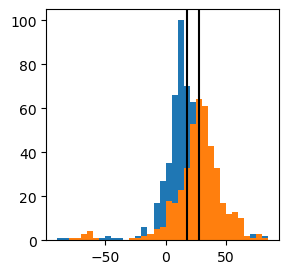

In [354]:
fig, ax = plt.subplots(figsize=(3,3))
plt.hist(DF['ta_wi'][open_], bins=np.arange(-90,90,5))
plt.hist(DF['ta_wp'][open_], bins=np.arange(-90,90,5))
plt.axvline(18, c='k')
plt.axvline(28, c='k')

In [2464]:
np.nanmedian(DF['ta_ip'][open_])

18.310160999317887

In [2463]:
np.nanmedian(DF['ta_wp'][open_])

28.500028176940397

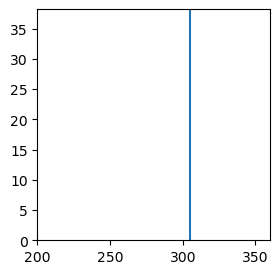

In [1422]:

#============
# DF = df[(df.year>=1987)&(df.year<2026)]
DF = dfb
# DF = df[(df.year>=2016)&(df.year<2024)]
# DF = df[(df.year>=2003)&(df.year<2016)]
#============

fig, ax = plt.subplots(figsize=(3,3))
x = DF[f'centermass_direction_r'][(DF.extent>0)]
h = plotter.quick_hist(x, bin_edges = bins)


theta = h['centers']
width = h['w']
ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.1, color=color, zorder=-1)
ax.step(theta, 100*h['prob'], where='mid', alpha=0.3, color=color,lw=1, zorder=-1)
    

x = DF[f'max_length_direction_r'][(DF.extent>0)]
h = plotter.quick_hist(x, bin_edges = bins)


theta = h['centers']
width = h['w']
ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.1, color='r', zorder=-1)
ax.step(theta, 100*h['prob'], where='mid', alpha=0.3, color='r',lw=1, zorder=-1)
    
    
ax.set_xlim(200,360)
ax.axvline((90-145)+360)

In [936]:
(90-165)+360

285

In [937]:
(90-145)+360

305

In [938]:
np.nanmedian(DF[f'max_length_direction_r'][(DF.extent>0)])

301.52934204516964

In [939]:
np.nanmedian(DF[f'centermass_direction_r'][(DF.extent>0)])

305.7704628259503

In [1203]:
10*units('km/day').to('m/s')/0.02

<Quantity(5.78703704, 'meter / second')>

In [1204]:
np.linspace(8,6, len(years))

array([8.        , 7.90909091, 7.81818182, 7.72727273, 7.63636364,
       7.54545455, 7.45454545, 7.36363636, 7.27272727, 7.18181818,
       7.09090909, 7.        , 6.90909091, 6.81818182, 6.72727273,
       6.63636364, 6.54545455, 6.45454545, 6.36363636, 6.27272727,
       6.18181818, 6.09090909, 6.        ])

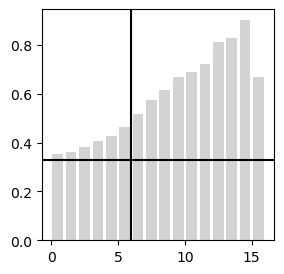

In [1274]:

# likelihoods = np.array([])

fig, ax = plt.subplots(figsize=(3,3))

# all_wind_dir = np.sum(wind_dir_cond)
# all_ice_dir = np.sum(ice_dir_cond)

cat = 'wind'
scat = 's10'

# cat = 'ice'
# scat = 'si_km'

all_dir = np.sum(dir_conds(DF, cat))

for bb in range(len(speed_bins[cat])-1):
    
    bmin = speed_bins[cat][bb]
    bmax = speed_bins[cat][bb+1]
    bmid = (bmax+bmin)/2
    
    not_last_day = (DF.final_day == False)
    not_last_day[DF.single_day == True] = True

    speed_range = (DF[scat] > bmin) & (DF[scat] > bmax)
#     speed_range = (DF[scat] < bmax)


    COND = speed_range & (dir_conds(DF, cat)==True)
    total_counts = np.sum(COND)
    open_counts = np.sum((DF['extent'][COND].values > 0))#&not_last_day[COND])
#     db_counts = np.sum(DF['day_before_event'][COND].values == -1)
    
#     plt.bar(bmid, (db_counts+open_counts)/total_counts, color='gray', width = 0.8*(bmax-bmin))
    plt.bar(bmid, (open_counts)/total_counts, color='lightgray', width = 0.8*(bmax-bmin))
    
    
#     plt.bar(bmid, 10*(total_counts/all_dir), bottom = 1, color='k', alpha=0.1, width = 0.8*(bmax-bmin))
    
plt.axvline(6, c='k')
plt.axhline(0.33, c='k')

In [1690]:
0.02 * 6 * units('m/s').to('km/day')

<Quantity(10.368, 'kilometer / day')>

In [1206]:

np.nanpercentile(DF.si[(DF['extent'] == 0)], 75)

9.048566991439179

In [1207]:
np.nanpercentile(DF.si[(DF['extent'] > 0)], 30)

11.697253499171095

In [1208]:
np.nanpercentile(DF.s10[(DF['extent'] > 0)], 30)

6.952249333466214

In [1741]:
years = np.arange(2003,2026)

#================
DF = dfr
#================


months = [12,1,2,3,4]
monthly = {}
monthly['pol_cts_no12'] = {}
monthly['pol_cts_no122425'] = {}
monthly['win_cts'] = {}
monthly['win_cts_no12'] = {}
monthly['win_cts_no2425'] = {}
monthly['win_cts_no122425'] = {}
monthly['ice_cts_no2425'] = {}
monthly['ice_cts_no122425'] = {}
monthly['tot_cts'] = {}
monthly['tot_cts_no12'] = {}
monthly['tot_cts_no2425'] = {}
monthly['tot_cts_no122425'] = {}

for key in monthly:
    for month in months:
        monthly[key][month] = 0

        
years = np.arange(2003,2026)
annual = {}
annual['pol_cts'] = {}
annual['win_cts'] = {}
annual['ice_cts'] = {}

for key in annual:
    for year in years:
        annual[key][year] = 0



pol_counts = np.array([])
win_counts = np.array([])
ice_counts = np.array([])

wind_factors = {}
wind_factors[25] = np.array([])
wind_factors[50] = np.array([])
wind_factors[75] = np.array([])

wf_match_years = np.array([])
years_match_wf = np.array([])

wind_speeds = {}
wind_speeds[25] = np.array([])
wind_speeds[50] = np.array([])
wind_speeds[75] = np.array([])

ice_speeds = {}
ice_speeds[25] = np.array([])
ice_speeds[50] = np.array([])
ice_speeds[75] = np.array([])

air_temps = {}
air_temps[25] = np.array([])
air_temps[50] = np.array([])
air_temps[75] = np.array([])

for year in years:
    
    
    year_cond = (DF.year == year)
    
    
    
    # EVENT COUNTS
    #------------------------------
    
    # polynyas
    #----------
    
    pol_cond = (DF.extent > 0)
    
    if year in [2012]:
        annual['pol_cts'][year] += np.nan
        pol_counts= np.append(pol_counts, np.nan)
    
    else:
        num_pol = np.sum(pol_cond&year_cond)
        annual['pol_cts'][year] += num_pol
        
        pol_counts= np.append(pol_counts, num_pol)

    # save monthly counts
    for month in months:
        month_cond = (DF.month == month)
        
        if year not in [2012]:
            monthly['pol_cts_no12'][month] += np.sum((year_cond&month_cond)&pol_cond)
            monthly['tot_cts_no12'][month] += np.sum(year_cond&month_cond)

        if year not in [2024,2025]: 
            monthly['pol_cts_no122425'][month] += np.sum((year_cond&month_cond)&pol_cond)
            monthly['tot_cts_no122425'][month] += np.sum(year_cond&month_cond)
    
    # winds
    #----------
    
    wind_cond = (dir_conds(DF, 'wind'))&(DF['s10'] > 6)
    num_win = len(DF[year_cond&wind_cond])
    win_counts= np.append(win_counts, num_win)
    
    
    annual['win_cts'][year] += np.sum(year_cond&wind_cond)
    
#     if year in [2012]:
#         annual['win_cts_no12'][year] += np.nan
#     else:
#         annual['win_cts_no12'][year] += np.sum(year_cond&wind_cond)
#         if year in [2024, 2025]:
#             annual['win_cts_no122425'][year] += np.nan
#         else:
#             annual['win_cts_no122425'][year] += np.sum(year_cond&wind_cond)
        
        
    for month in months:
        
        month_cond = (DF.month == month)
        monthly['win_cts'][month] += np.sum((year_cond&month_cond)&wind_cond)
        monthly['tot_cts'][month] += np.sum(year_cond&month_cond)

        if year not in [2012]:
            monthly['win_cts_no12'][month] += np.sum((year_cond&month_cond)&wind_cond)
        if year not in [2024, 2025]:
            monthly['tot_cts_no2425'][month] += np.sum((year_cond&month_cond))
            monthly['win_cts_no2425'][month] += np.sum((year_cond&month_cond)&wind_cond)
        if year not in [2012, 2024,2025]: 
            monthly['win_cts_no122425'][month] += np.sum((year_cond&month_cond)&wind_cond)

    # ice
    #----------
    
    ice_cond = (dir_conds(DF, 'ice'))&(DF['si_km'] > 10)
    
    annual['ice_cts'][year] += np.sum(year_cond&ice_cond)
    
    for month in months:
        
        month_cond = (DF.month == month)
        if year not in [2024,2025]:
            monthly['ice_cts_no2425'][month] += np.sum((year_cond&month_cond)&ice_cond)
        if year not in [2012, 2024, 2025]:
            monthly['ice_cts_no122425'][month] += np.sum((year_cond&month_cond)&ice_cond)
                
                
    
    if year > 2023:
        ice_counts= np.append(ice_counts, np.nan)
    else:
        num_ice = len(DF[(DF.year == year)&((dir_conds(DF, 'ice'))&(DF['si_km'] > 8.5))])
        ice_counts= np.append(ice_counts, num_ice)
    
#     wind_dir_cond
    all_ws = DF.s10[(DF.year == year)&(DF.extent>0)]
    for key in ice_speeds.keys():
        wind_speeds[key] = np.append(wind_speeds[key], np.nanpercentile(all_ws, key))
        
        
    all_t2m = DF.t2m[(DF.year == year)&(DF.extent>0)]
    for key in ice_speeds.keys():
        air_temps[key] = np.append(air_temps[key], np.nanpercentile(all_t2m, key))
            
    # ice speeds
    if year > 2023:
        for key in ice_speeds.keys():
            ice_speeds[key] = np.append(ice_speeds[key],  np.nan)
    else:
        all_is = DF.si[(DF.year == year)&(DF.extent>0)]
        for key in ice_speeds.keys():
            ice_speeds[key] = np.append(ice_speeds[key], np.nanpercentile(all_is, key))

    # wind factors
    if year > 2023:
        for key in wind_factors.keys():
            wind_factors[key] = np.append(wind_factors[key],  np.nan)
    else:
        all_wf = (DF.si/DF.s10)[((DF.year == year)&(dir_conds(DF, 'wind')))&(DF['s10']>3)]
        
        wf_match_years = np.append(wf_match_years, all_wf)
        years_match_wf = np.append(years_match_wf, np.full(len(all_wf), year))
        
        for key in ice_speeds.keys():
            wind_factors[key] = np.append(wind_factors[key], np.nanpercentile(all_wf, key))


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [1742]:
annual['win_cts_no12'] = annual['win_cts'].copy()
annual['win_cts_no12'][2012] = np.nan

annual['win_cts_no2425'] = annual['win_cts'].copy()
annual['win_cts_no2425'][2024] = np.nan
annual['win_cts_no2425'][2025] = np.nan

annual['win_cts_no122425'] = annual['win_cts'].copy()
annual['win_cts_no122425'][2012] = np.nan
annual['win_cts_no122425'][2024] = np.nan
annual['win_cts_no122425'][2025] = np.nan

annual['ice_cts_no12'] = annual['ice_cts'].copy()
annual['ice_cts_no12'][2012] = np.nan

annual['ice_cts_no2425'] = annual['ice_cts'].copy()
annual['ice_cts_no2425'][2024] = np.nan
annual['ice_cts_no2425'][2025] = np.nan

annual['ice_cts_no122425'] = annual['ice_cts'].copy()
annual['ice_cts_no122425'][2012] = np.nan
annual['ice_cts_no122425'][2024] = np.nan
annual['ice_cts_no122425'][2025] = np.nan




In [1743]:
all_ice_cts = np.array([annual['ice_cts_no2425'][key] for key in annual['ice_cts_no2425'].keys()])
all_pol_cts = np.array([annual['pol_cts'][key] for key in annual['pol_cts'].keys()])
# all_win_cts = np.array([annual['win_cts_no122425'][key] for key in annual['win_cts_no122425'].keys()])
all_win_cts = np.array([annual['win_cts_no122425'][key] for key in annual['win_cts_no122425'].keys()])

years_no12 = np.append(np.arange(2003,2012), np.arange(2013,2026))
years_no122425 = np.append(np.arange(2003,2012), np.arange(2013,2024))

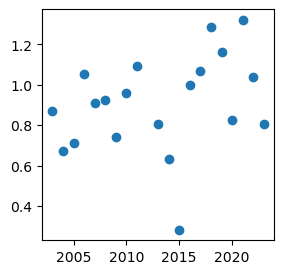

In [1744]:
fig, ax = plt.subplots(figsize=(3,3))
plt.scatter(years, all_ice_cts/all_win_cts)
# plt.scatter(years, all_pol_cts/all_win_cts)

In [1745]:
annual['ice_cts'][2012]

15

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


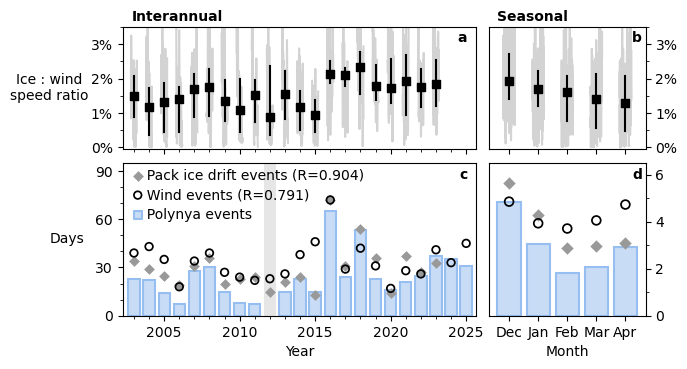

In [1750]:
fig, AXS = plt.subplots(2,2,figsize=(6.75,3.75), gridspec_kw={'width_ratios':[2.25,1], 'height_ratios':[1,1.25]})

axs = AXS.ravel()

years = np.arange(2003,2026)
months = [12,1,2,3,4]

# total events per year
# annual_counts = [np.sum([pol_stats['counts'][month][year][0] for month in months]) for year in years]


# mar1_kw = {'edgecolor': 'k', 'facecolor':'None', 'lw':1.25, 'marker':'P', 'zorder':10, 's':23}
# mar1_kw = {'edgecolor': 'k', 'facecolor':'k', 'lw':1, 'marker':'D', 'zorder':10, 's':30}
# mar2_kw = {'edgecolor': [0.35,0.35,0.35], 'facecolor':'lightgray', 'lw':1.5, 'marker':'o', 's':35}

C = [0.6,0.6,0.6]

mar1_kw = {'edgecolor': 'k', 'facecolor':'None', 'lw':1.25, 'marker':'o', 'zorder':10, 's':30}
mar2_kw = {'edgecolor': C, 'facecolor':C, 'lw':0, 'marker':'D', 's':30}

mar1_kw_L = {'edgecolor': 'k', 'facecolor':'None', 'lw':1.25, 'marker':'o', 'zorder':10, 's':40}
mar2_kw_L = {'edgecolor': C, 'facecolor':C, 'lw':0, 'marker':'D', 's':40}

# mar2_kw = {'edgecolor': 'None', 'facecolor':[0.65,0.65,0.65], 'lw':1.5, 'marker':'x', 's':30}

mar3_kw = {'facecolor':[200/255,220/255,245/255],'edgecolor':[150/255,190/255,240/255], 
           'lw':1.5, 'marker':'s', 's':40}
# bar_kw = {'facecolor':[166/255,205/255,255/255],'edgecolor':[130/255,175/255,235/255], 'lw':0, "alpha":1}

# bar_kw = {'facecolor':[220/255,230/255,247/255],'edgecolor':[130/255,175/255,235/255], 'lw':1.5, "alpha":1}
bar_kw = {'facecolor':[200/255,220/255,245/255],'edgecolor':[150/255,190/255,240/255], 'lw':1.5, "alpha":1}
# bar_kw = {'color':'lightcoral', "alpha":1}

ax = axs[2]

for yy, year in enumerate(years):
    year
    
    ax.bar(year, annual['pol_cts'][year], width=0.75, **bar_kw)
    ax.scatter(year, annual['win_cts'][year], **mar1_kw)
    
    
    ax.scatter(year, annual['ice_cts_no2425'][year], **mar2_kw)


        
ax.set_ylim(0,95)
ax.bar(2012, ax.get_xlim()[-1], color=[0.9,0.9,0.9], zorder=-11)
ax.set_xlim(2002.25,2025.75)
ax.set_ylabel('Days', rotation=0, labelpad=20, va='center')
ax.set_xlabel('Year')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(30))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))

ax = axs[3]

for mm, month in enumerate(months):
    month
#     monthly['pol_cts'] = {}
# monthly['win_cts'] = {}
# monthly['ice_cts'] = {}
# monthly['tot_cts'] = {}
# monthly['tot_cts_no12'] = {}

#     ax.bar(mm, monthly['pol_cts_no12'][month]/monthly['tot_cts_no12'][month], alpha=0.5, color='b')


    total_days = monthly['tot_cts_no122425'][month]
    
    ax.bar(mm, len(years_no122425)*monthly['pol_cts_no122425'][month]/total_days, **bar_kw)
    ax.scatter(mm, len(years_no122425)*monthly['win_cts_no122425'][month]/total_days, **mar1_kw_L)
    ax.scatter(mm, len(years_no122425)*monthly['ice_cts_no122425'][month]/total_days, **mar2_kw_L)

# ax.set_ylabel('Days\nper\nmonth', rotation=0, labelpad=20, va='center')
ax.set_xlabel('Month')
ax.set_xticks(range(len(months)))
ax.set_xticklabels(['Dec','Jan','Feb','Mar','Apr'])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_ylim(0,6.5)

plt.subplots_adjust(wspace=0.1)


x = all_ice_cts
y = all_pol_cts
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
resp = stats.linregress(x_nn,y_nn)
Rp = resp.rvalue

x = all_win_cts
y = all_pol_cts
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
resa = stats.linregress(x_nn,y_nn)
Rw = resa.rvalue


ax = axs[2]
ax.scatter(2003.25,75, **mar1_kw)
ax.text(2003.25,75, f'  Wind events (R={Rw:.3f})', va='center')
ax.scatter(2003.25,87, **mar2_kw)
ax.text(2003.25,87, f'  Pack ice drift events (R={Rp:.3f})', va='center')
ax.scatter(2003.25,62.5, **mar3_kw)
ax.text(2003.25,62.5, f'  Polynya events', va='center')



ax = axs[0]
DF = dfb
for year in years:
    all_wf = (DF.si/DF.s10)[((DF.year == year)&(dir_conds(DF, 'wind')))&(DF['s10']>3)]
#     ax.scatter(year, np.nanmedian(all_wf), marker='*', c='k')
    
    bf = 0.2
    ax.plot(np.linspace(year-bf, year+bf,len(all_wf)), all_wf, c='lightgray',  zorder=-1)
#     ax.scatter(np.linspace(year-bf, year+bf,len(all_wf)), all_wf, c='lightgray', s=5, zorder=-1)
    ax.scatter(year, np.nanmedian(all_wf), marker='s', c='k')
    ax.plot([year,year], [np.nanpercentile(all_wf,25), np.nanpercentile(all_wf,75)], c='k')
#     print(year, np.nanmedian(all_wf))
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_xticklabels([])
ax.set_ylabel('Ice : wind\nspeed ratio', rotation=0, labelpad=30, va='center')
    
ax = axs[1]
# ax.set_ylim(-0.1,4.5)
DF = df[((df.year>=2003)&(df.year<=2023))&(df.year!=2012)]
for mm, month in enumerate(months):
    
    all_wf = (DF.si/DF.s10)[((DF.month == month)&(dir_conds(DF, 'wind')))&(DF['s10']>3)]
#     ax.scatter(year, np.nanmedian(all_wf), marker='*', c='k')
    bf = 0.2
    ax.plot(np.linspace(mm-bf, mm+bf,len(all_wf)), all_wf, c='lightgray', zorder=-1)
    ax.scatter(mm, np.nanmedian(all_wf), marker='s', c='k')
    ax.plot([mm,mm], [np.nanpercentile(all_wf,25), np.nanpercentile(all_wf,75)], c='k')
    
ax.set_xticks(range(len(months)))
ax.set_xticklabels([])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")


# ax.text(0.95, 1.05, 'Years\n2003-2011,\n2013-2023', 
#         weight='bold', size=9,
#         ha='right', va='bottom', clip_on=False, transform=ax.transAxes)

# ax.scatter(years, wind_factors[50])

for ax in axs[:-2]:
    ax.set_ylim(-0.1,5)
for ax in AXS[:,1]:
    ax.set_xlim(-0.7,4.7)
for ax in AXS[:,0]:
    ax.set_xlim(2002.25,2025.65)
    
def percent_format(x, pos):
    return f"{x:.0f}%" # Formats as percentage with 0 decimal places

for ax in AXS[0,:]:   
    ax.set_ylim(-0.05,3.5)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(percent_format))

plt.subplots_adjust(hspace=0.1, wspace=0.05)

for aa, ax in enumerate(axs):
    ax.text(0.975, 0.965, f'{chr(97+aa)}', weight='bold', ha='right', va='top', transform=ax.transAxes)

axs[0].text(0.025,1.05, 'Interannual', weight='bold', clip_on=False, transform = axs[0].transAxes)
axs[1].text(0.05,1.05, 'Seasonal', weight='bold', clip_on=False, transform = axs[1].transAxes)


# fig.savefig('../figures/results/occurrence_stats.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [1748]:
0.904 **2

0.817216

In [1738]:
0.01 * 6.5 * units('m/s').to('km/day')

<Quantity(5.616, 'kilometer / day')>

In [1215]:
np.sqrt(0.817)

0.9038805230781334

In [1216]:
np.sqrt(0.631)

0.79435508432942

In [1121]:
11*units('km/day').to('cm/s')

<Quantity(12.7314815, 'centimeter / second')>

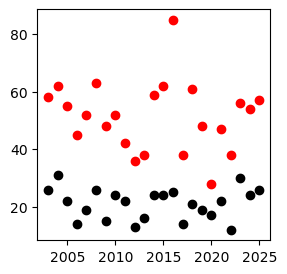

In [589]:
ax = axs[0]
ax.set_ylim(-0.1,4)
DF = dfr

fig, ax = plt.subplots(figsize=(3,3))
for year in years:
    
    e_events = (DF.year == year)&(dir_conds(DF, 'wind'))
    
    
    month_cond = (DF.month==12)+(DF.month==1)
                
    ax.scatter(year, np.sum(month_cond&e_events), c='k')
                                       
        

    ax.scatter(year, np.sum(e_events), c='r')
                                    
#     all_wf = (DF.si/DF.s10)[((DF.year == year)&(dir_conds(DF, 'wind')))&(DF['s10']>3)]
# #     ax.scatter(year, np.nanmedian(all_wf), marker='*', c='k')
    
#     bf = 0.25
#     ax.plot(np.linspace(year-bf, year+bf,len(all_wf)), all_wf, c='lightgray',  zorder=-1)
#     ax.scatter(year, np.nanmedian(all_wf), marker='o', c='k')
#     ax.plot([year,year], [np.nanpercentile(all_wf,25), np.nanpercentile(all_wf,75)], c='k')
    

In [970]:
years

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,
       2025])

In [821]:
monthly['tot_cts_no122425']

{12: 620, 1: 620, 2: 564, 3: 620, 4: 600}

In [822]:
years_no12 = np.append(np.arange(2003,2012), np.arange(2013,2026))
years_no122425 = np.append(np.arange(2003,2012), np.arange(2013,2024))

In [823]:
years_no122425

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [760]:
np.sqrt(np.nanmean((pol_counts - win_counts)**2))

11.46516463030514

In [761]:
# win_counts2 = win_counts

0.9080030526496173 0.8244695436210238
LinregressResult(slope=0.9317167169032593, intercept=-0.6521412007467069, rvalue=0.9080030526496173, pvalue=3.197732559835614e-08, stderr=0.10132965582672959, intercept_stderr=1.3155095408101145)


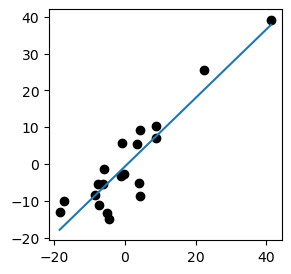

In [605]:

    
# plt.bar(years, pol_counts)
# plt.scatter(years, win_counts)

fig, ax = plt.subplots(figsize=(3,3))
x = ice_counts_detrend#[(years!=2016)&(years!=2018)]
# y = ice_speeds[25]/wind_factors[50]
y = pol_counts_detrend#[(years!=2016)&(years!=2018)]
# y = wind_speeds[75]

# x = wind_factor_detrend
# y = pol_counts_perwind_detrend

# x = wind_factors[50]
# y = pol_counts/win_counts


# wind_factors[50]
# y = pol_counts

# ice_speeds[50]


color = 'k'

# for xx, yymin, yymax in zip(years, air_temps[25], air_temps[75]):
#     plt.plot([xx,xx], [yymin,yymax], c=color)

x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
res = stats.linregress(x_nn,y_nn)
R = res.rvalue
ax.scatter(x,y, c=color)
x_line = np.array([x_nn.min(), x_nn.max()])
y_line = res.intercept + res.slope*x_line
print(R, R**2)
print(res)

# plt.ylim(0,1.5)
plt.plot(x_line, y_line)


# MAX = 80
# plt.plot([-10,MAX],[-10,MAX], c='gray', ls='dashed', zorder=-1)
# plt.xlim(-5,MAX)
# plt.ylim(-5,MAX)

# ice_counts_detrend = y - (res.slope*years[:-2] + res.intercept)

# pol_counts_detrend = y - (res.slope*years[:-2] + res.intercept)
# win_counts_detrend = y - (res.slope*years[:-2] + res.intercept)

# pol_counts_perwind_detrend = y - (res.slope*years + res.intercept)
# wind_factor_detrend = y - (res.slope*years + res.intercept)


# plt.ylim(0,2)

In [1153]:
11.5740740/7

1.6534391428571429

In [758]:
10 * units('km/day').to('cm/s')

<Quantity(11.5740741, 'centimeter / second')>

In [1465]:
10 * units('km/day').to('m/s') / 0.02

<Quantity(5.78703704, 'meter / second')>

In [1466]:
0.02 * 10 * units('m/s').to('km/day')

<Quantity(17.28, 'kilometer / day')>

In [717]:
0.02 * 10 * units('m/s').to('cm/s')

<Quantity(20.0, 'centimeter / second')>

In [1205]:
# 0.745 @ 7.5
# 0.745 @ 7.5
# 0.728 @ 7.5

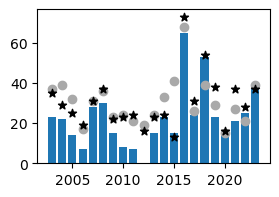

In [763]:
fig, ax = plt.subplots(figsize=(3,2))

plt.bar(years, pol_counts)
plt.scatter(years, win_counts, marker='o', c='darkgray')
# plt.scatter(years, win_counts2, marker='*', c='k')
plt.scatter(years, ice_counts, marker='*', c='k')
# plt.scatter(years, ice_counts)

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


(0.0, 3.0)

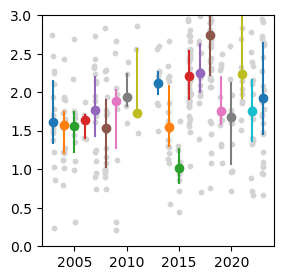

In [1226]:
fig, ax = plt.subplots(figsize=(3,3))


DF = dfr

years = np.arange(2003, 2024)

for year in years:

    COND = (DF.extent > 0) + (DF.event_day == -1)
    COND = (DF.extent > 0)
    COND[(DF.final_day)&(DF.single_day == False)] = False
    COND = COND & (DF.year == year)
    
#     COND = dir_conds(DF, 'wind')
#     COND = COND & (DF.year == year)
    
    
    winds_during = DF['s10'][COND]
    ice_during = DF['si'][COND]
    wf_during = (ice_during/winds_during)[winds_during>3]

    ax.scatter(year, np.nanpercentile(wf_during,50))
    
    bf = 0.1
    ax.scatter(np.linspace(year-bf, year+bf, len(wf_during)), wf_during, c='lightgray',s=10, zorder=-1)
    ax.plot([year,year], [np.nanpercentile(wf_during,25),np.nanpercentile(wf_during,75)])
    
#     ax.scatter(year, np.sum(COND))

plt.ylim(0,3)

NameError: name 'pol_stats' is not defined

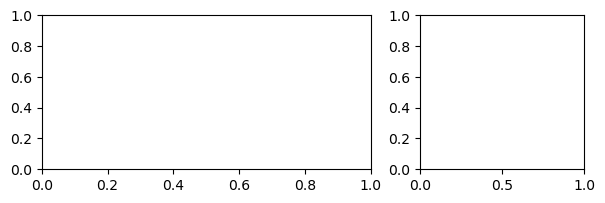

In [360]:
fig, axs = plt.subplots(1,2,figsize=(7,2), gridspec_kw={'width_ratios':[2,1]})


years = np.arange(2003,2026)
months = [12,1,2,3,4]

# total events per year
# annual_counts = [np.sum([pol_stats['counts'][month][year][0] for month in months]) for year in years]


mar1_kw = {'edgecolor': 'k', 'facecolor':'None', 'lw':1., 'marker':'D', 'zorder':10, 's':23}
mar2_kw = {'edgecolor': [0.65,0.65,0.65], 'facecolor':'None', 'lw':1.5, 'marker':'o', 's':35}


for yy, year in enumerate(years):
    
    month_colors = ['royalblue','skyblue','mediumpurple', 'lightcoral','r']
    
    last_num = 0
    
    cts_by_size = {}
    for q in ['q1','q2','q3','q4']:
        cts_by_size[q]=0
    for mm, month in enumerate(months):
        my_sizes = pol_stats['size'][month][year]
        cts_by_size['q1'] += np.sum((my_sizes > 0) & (my_sizes <= 155))
        cts_by_size['q2'] += np.sum((my_sizes > 155) & (my_sizes <= 500))
        cts_by_size['q3'] += np.sum((my_sizes > 500) & (my_sizes <= 1500))
        cts_by_size['q4'] += np.sum(my_sizes > 1500)

    ax = axs[0]
    last_num = 0
    for color, q in zip([c1,c2,c3,c4],['q1','q2','q3','q4']):
        current_num = cts_by_size[q]       
        ax.bar(year, current_num, bottom = last_num, color=color, alpha=0.75)
        last_num+=current_num
        
    if year <= 2024:
        total_WE = 0
        for mm, month in enumerate(months):
            total_WE += pol_stats['wind_events'][month][year][0]
        ax.scatter(year, total_WE, **mar1_kw)
    
    if year <= 2023:
        total_WE = 0
        for mm, month in enumerate(months):
            total_WE += pol_stats['ice_events'][month][year][0]
        ax.scatter(year, total_WE, **mar2_kw)

        
ax.set_ylim(0,95)
ax.bar(2012, ax.get_xlim()[-1], color='lightgray')
ax.set_xlim(2002.25,2025.75)
ax.set_ylabel('Days per\nconsolidated\nseason', rotation=0, labelpad=30, va='center')
ax.set_xlabel('Year')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(30))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))


for mm, month in enumerate(months):
    
    cts_by_size = {}
    for q in ['q1','q2','q3','q4']:
        cts_by_size[q]=0
    for yy, year in enumerate(years):
        my_sizes = pol_stats['size'][month][year]
        cts_by_size['q1'] += np.sum((my_sizes > 0) & (my_sizes <= 155))
        cts_by_size['q2'] += np.sum((my_sizes > 155) & (my_sizes <= 500))
        cts_by_size['q3'] += np.sum((my_sizes > 500) & (my_sizes <= 1700))
        cts_by_size['q4'] += np.sum(my_sizes > 1700)
        
    days_per_year = 0
    for yy, year in enumerate(years):
        days_per_year+=pol_stats['days'][month][year]/len(years)
        
    days_per_year_ice = 0
    for yy, year in enumerate(years[:-2]):
        days_per_year_ice+=pol_stats['days'][month][year]/len(years[:-2])
        
    ax = axs[1]
    last_num = 0
    for color, q in zip([c1,c2,c3,c4],['q1','q2','q3','q4']):
        current_num = cts_by_size[q]/days_per_year
        ax.bar(mm, current_num, bottom = last_num, color=color, alpha=0.75)
        last_num+=current_num
        

    total_WE = 0
    for yy, year in enumerate(years[:-2]):
        total_WE += pol_stats['wind_events'][month][year][0]
    ax.scatter(mm, total_WE/days_per_year_ice, **mar1_kw)
    
    total_WE = 0
    for yy, year in enumerate(years[:-2]):
        total_WE += pol_stats['ice_events'][month][year][0]
    ax.scatter(mm, total_WE/days_per_year_ice, **mar2_kw)
    
    

    
# total_w = 0
#     for mm, month in enumerate(MONTHS):
#         total_w += np.sum(pol_stats['wind_events'][month][year])
#     all_we = np.append(all_we, np.sum(total_w))
    
#     total_i = 0
#     for mm, month in enumerate(MONTHS):
#         total_i += np.sum(pol_stats['ice_events'][month][year])
#     all_ie = np.append(all_ie, np.sum(total_i))
    
ax.set_ylabel('Days\nper\nmonth', rotation=0, labelpad=20, va='center')
ax.set_xlabel('Month')
ax.set_xticks(range(len(months)))
ax.set_xticklabels(['Dec','Jan','Feb','Mar','Apr'])
ax.set_ylim(0,7)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))


#     ax.scatter(year, cts_by_size['q1'])
#     ax.scatter(year, cts_by_size['q2'])
    
#     for mm, month in enumerate(months):
        
#         current_num = np.sum(pol_stats['counts'][month][year])            
#         ax.bar(year, current_num, bottom = last_num, color=month_colors[mm], alpha=0.75)
#         last_num += current_num


# plt.scatter(years, annual_counts, c='k')
        
# axs[0].set_ylim(2,18)

plt.subplots_adjust(wspace=0.1)


x = all_ie[(yearss>=2003)&(yearss<2024)]
y = all_pe[(yearss>=2003)&(yearss<2024)]
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
resp = stats.linregress(x_nn,y_nn)
Rp = resp.rvalue

x = all_we[(yearss>=2003)&(yearss<2024)]
y = all_pe[(yearss>=2003)&(yearss<2024)]
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
resa = stats.linregress(x_nn,y_nn)
Rw = resa.rvalue


ax = axs[0]
ax.scatter(2003.25,77, **mar1_kw)
ax.text(2003.25,77, f'  Wind events (R={Rw:.3f})', va='center')
ax.scatter(2003.25,87, **mar2_kw)
ax.text(2003.25,87, f'  Pack drift events (R={Rp:.3f})', va='center')


In [1231]:
10*units('km/day').to('m/s') / 0.015

<Quantity(7.71604938, 'meter / second')>

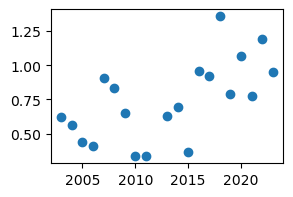

In [769]:
fig, ax = plt.subplots(figsize=(3,2))


ax.scatter(years, pol_counts/win_counts)


0.5187078095973269 0.2690577917372567
LinregressResult(slope=0.032539459719179716, intercept=-63.94543390471172, rvalue=0.5187078095973269, pvalue=0.015985384741568607, stderr=0.012304168528391326, intercept_stderr=24.768403307220904)
1.969684460908043
1.2574890942645234


Text(0.5, 0, 'Year')

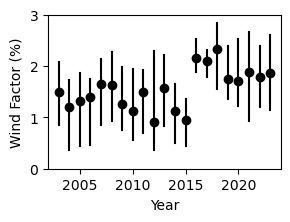

In [767]:

    
# plt.bar(years, pol_counts)
# plt.scatter(years, win_counts)

fig, ax = plt.subplots(figsize=(3,2))
x = years
y = wind_factors[50]


color = 'k'

for xx, yymin, yymax in zip(years, wind_factors[25], wind_factors[75]):
    plt.plot([xx,xx], [yymin,yymax], c=color)

x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
res = stats.linregress(x_nn,y_nn)
R = res.rvalue
ax.scatter(x,y, c=color)
x_line = np.array([x_nn.min(), x_nn.max()])
y_line = res.intercept + res.slope*x_line
print(R, R**2)
print(res)
# ax.plot(x_line, y_line);

med_pre16 = np.nanmedian(wf_match_years[years_match_wf<2016])
p75_pre16 = np.nanpercentile(wf_match_years[years_match_wf<2016], 75)
p25_pre16 = np.nanpercentile(wf_match_years[years_match_wf<2016], 25)

med_pst16 = np.nanmedian(wf_match_years[years_match_wf>=2016])
p75_pst16 = np.nanpercentile(wf_match_years[years_match_wf>=2016], 75)
p25_pst16 = np.nanpercentile(wf_match_years[years_match_wf>=2016], 25)


# ax.fill_between(x=[2003,2015], y1=p25_pre16, y2=p75_pre16, color='royalblue',  interpolate=True, alpha=.25, zorder=-1)
# plt.plot([2003,2015], [med_pre16, med_pre16], c='royalblue',  lw=2,zorder=-1)
# plt.plot([2003,2015], [p25_pre16, p25_pre16], c='royalblue',  lw=0.5,zorder=-1)
# plt.plot([2003,2015], [p75_pre16, p75_pre16], c='royalblue',  lw=0.5,zorder=-1)


# ax.fill_between(x=[2016,2023], y1=p25_pst16, y2=p75_pst16, color='red',  interpolate=True, alpha=.25, zorder=-1)
# plt.plot([2016,2023], [med_pst16, med_pst16], c='r', lw=2, zorder=-1)
# plt.plot([2016,2023], [p25_pst16, p25_pst16], c='r', lw=0.5, zorder=-1)
# plt.plot([2016,2023], [p75_pst16, p75_pst16], c='r', lw=0.5, zorder=-1)

print(med_pst16)
print(med_pre16)
# plt.fill_between([2016,2023], [p75_pre16, p25_pre16])
# avg_pre16 = np.nanmean(wind_factors[50][years<2016])

# plt.ylim(0,3)
ax.set_ylim(0,3)
plt.ylabel('Wind Factor (%)')
plt.xlabel('Year')

In [1035]:
np.nanmin(wind_factors[50])

0.4123069238884896

In [ ]:
np.nanmin(wind_factors[50])

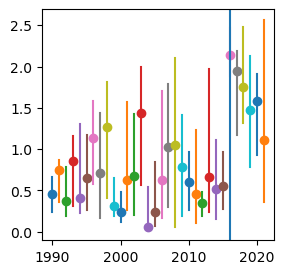

In [1105]:
DF = df[(df.year>=1987)&(df.year<2024)]

fig, ax = plt.subplots(figsize=(3,3))


# YEAR = 2013

month_cond = (DF.month == 3)
month_cond[DF.month == 2] = True
month_cond[DF.month == 4] = True

# month_cond = (DF.month == 12)
# month_cond[DF.month == 1] = True



# month_cond = DF.month < 100

for YEAR in np.arange(1990,2022):
    
    
    force_cond = ((DF['a10_r']>180) & (DF['a10_r']<300)) & (DF['s10']>3)
    
#     force_cond = (dir_conds(DF, 'wind')) & (DF['s10']>3)
    
    time_cond = (DF.year == YEAR) & month_cond
    COND = force_cond & time_cond
    values = (DF.si/DF.s10)[COND].values
    ax.scatter(YEAR, np.nanmedian(values))
    ax.plot([YEAR,YEAR], [np.nanpercentile(values,25), np.nanpercentile(values,75)])
    
    
#     time_cond = (DF.year < YEAR) & month_cond
#     COND = force_cond & time_cond
#     values1 = (DF.si/DF.s10)[COND].values

#     time_cond = (DF.year >= YEAR) & month_cond
#     COND = force_cond & time_cond
#     values2 = (DF.si/DF.s10)[COND].values

#     initial = np.nanmean(values1) / np.nanstd(values1)
#     final = np.nanmean(values2) / np.nanstd(values2)
    
#     plt.scatter(YEAR, abs(final-initial))

# plt.bar()

plt.axvline(2016)

(0.0, 15.0)

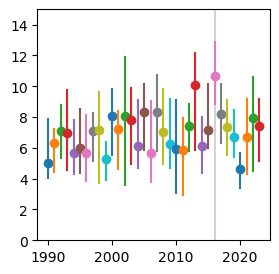

In [1081]:
DF = df[(df.year>=1988)&(df.year<2025)]

fig, ax = plt.subplots(figsize=(3,3))


# YEAR = 2013


# month_cond = (DF.month == 1)

month_cond = (DF.month == 3)
month_cond[DF.month == 2] = True
month_cond[DF.month == 4] = True

# month_cond = (DF.month == 12)
# month_cond[DF.month == 1] = True

for YEAR in np.arange(1990,2024):
    
    force_cond = dir_conds(DF, 'wind') #& (DF['s10']>0)
    
    time_cond = (DF.year == YEAR) & month_cond
    COND = force_cond & time_cond
    values = (DF.s10)[COND].values
    ax.scatter(YEAR, np.nanmedian(values))
    
    ax.plot([YEAR,YEAR], [np.nanpercentile(values,25), np.nanpercentile(values,75)])
    
    
#     time_cond = (DF.year < YEAR) & month_cond
#     COND = force_cond & time_cond
#     values1 = (DF.si/DF.s10)[COND].values

#     time_cond = (DF.year >= YEAR) & month_cond
#     COND = force_cond & time_cond
#     values2 = (DF.si/DF.s10)[COND].values

#     initial = np.nanmean(values1) / np.nanstd(values1)
#     final = np.nanmean(values2) / np.nanstd(values2)
    
#     plt.scatter(YEAR, abs(final-initial))

# plt.bar()

plt.axvline(2016, zorder=-1, c='lightgray')
plt.ylim(0,15)

In [447]:
df

time  month  year  pre_2003  2003_2023  compact   open     q1  \
0     1987-12-01     12  1988      True      False    False  False  False   
1     1987-12-02     12  1988      True      False    False  False  False   
2     1987-12-03     12  1988      True      False    False  False  False   
3     1987-12-04     12  1988      True      False    False  False  False   
4     1987-12-05     12  1988      True      False    False  False  False   
...          ...    ...   ...       ...        ...      ...    ...    ...   
5743  2025-04-26      4  2025     False      False     True  False  False   
5744  2025-04-27      4  2025     False      False     True  False  False   
5745  2025-04-28      4  2025     False      False     True  False  False   
5746  2025-04-29      4  2025     False      False     True  False  False   
5747  2025-04-30      4  2025     False      False     True  False  False   

         q2     q3  ...  peak_day  event_length  after_event_length  \
0     False  False  ...     False          -999                -999   
1     False  False  ...     False          -999                -999   
2     False  False  ...     False          -999                -999   
3     False  False  ...     False          -999                -999   
4     False  False  ...     False          -999                -999   
...     ...    ...  ...       ...           ...                 ...   
5743  False  False  ...     False          -999                -999   
5744  False  False  ...     False          -999                -999   
5745  False  False  ...     False          -999                -999   
5746  False  False  ...     False          -999                -999   
5747  False  False  ...     False          -999                -999   

      before_event_length      esei      ese10       a10_r        ai_r  \
0                    -999  0.363690  -1.445110  140.996915  226.351163   
1                    -999  1.577358  -5.139950   99.743757  270.815395   
2                    -999  1.029393  -4.541830   79.480123  345.129899   
3                    -999 -0.681007  -3.100055   76.052335  102.336540   
4                    -999 -0.355374  -4.107222   97.314999  185.202439   
...                   ...       ...        ...         ...         ...   
5743                 -999       NaN  17.953359  265.088243         NaN   
5744                 -999       NaN  13.530845  255.125687         NaN   
5745                 -999       NaN   7.978714  249.709913         NaN   
5746                 -999       NaN        NaN         NaN         NaN   
5747                 -999       NaN        NaN         NaN         NaN   

      centermass_direction_r  max_length_direction_r  
0                        NaN                     NaN  
1                        NaN                     NaN  
2                        NaN                     NaN  
3                        NaN                     NaN  
4                        NaN                     NaN  
...                      ...                     ...  
5743                    90.0                    90.0  
5744                    90.0                    90.0  
5745                    90.0                    90.0  
5746                    90.0                    90.0  
5747                    90.0                    90.0  

[5748 rows x 53 columns]

In [252]:
np.sum(speed_range&wind_dir_cond)

0

In [251]:
DF['extent'][speed_range&wind_dir_cond].values

array([], dtype=float64)

-3.097959422289935 3.097959422289935 3.141592653589793
a10
[-180  145  150  155  160  165  170  175]
-3.097959422289935 3.097959422289935 3.141592653589793
ai
[135 140 145 150 155 160 165 170 175]
-3.097959422289935 3.097959422289935 3.141592653589793
centermass_direction
[120 125 130 135 140 145 150 155]


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_55175/2228769708.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['E','','N','','W ','','S'])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_55175/2228769708.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['E','','N','','W ','','S'])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_55175/2228769708.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['E','','N','','W ','','S'])


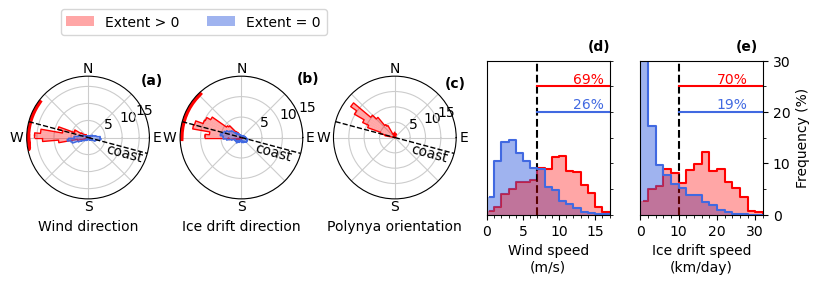

In [1758]:

# create plot
fig, axs = plt.subplots(1,5, figsize=(9.5,2), subplot_kw={'projection': None})

# Override specific subplots to be polar using add_subplot
fig.delaxes(axs[0])
fig.delaxes(axs[1])
fig.delaxes(axs[2])
axs[0] = fig.add_subplot(1, 5, 1, projection='polar')
axs[1] = fig.add_subplot(1, 5, 2, projection='polar')
axs[2] = fig.add_subplot(1, 5, 3, projection='polar')


#============
DF = dfb

# DF = df[(df.year>=2003)&(df.year<2016)]
# DF = df[(df.year>=2016)&(df.year<2026)]
#============

# ccolor = c2
ccolor = 'royalblue'
bcolor = 'red'

bins = np.arange(-180,181,5)
comp_ = (DF.extent==0)
open_ = (DF.extent>0)#&(not_last_day)


ICE_THRESH = 10
WIND_THRESH = 7


for ax, group, color in zip(axs[0:3], ['a10', 'ai', 'centermass_direction'], [bcolor,bcolor, bcolor]):
    
    # Plot bars
    x = DF[f'{group}'][open_]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    theta = h2['centers'] * np.pi/180
    width = h2['w']* np.pi/180
    ax.bar(theta, 100*h2['prob'], width=width, bottom=0.0, alpha=0.35, color=bcolor, zorder=3, label='Extent > 0')
    ax.step(theta, 100*h2['prob'], where='mid', alpha=1, color=bcolor,lw=1, zorder=3)
    ax.plot([-np.pi, -np.pi], [100*h2['prob'][0], 100*h2['prob'][-1]], alpha=1, color=bcolor,lw=1, zorder=3)
    ax.plot([theta[-1], -np.pi], [100*h2['prob'][-1], 100*h2['prob'][-1]], alpha=1, color=bcolor,lw=1, zorder=3)
    print(theta[0], theta[-1], np.pi)
    
    if group!= 'centermass_direction':
        x = DF[f'{group}'][comp_]
        h = plotter.quick_hist(x, bin_edges = bins)
        theta = h['centers'] * np.pi/180
        ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.5, color=ccolor, zorder=4, label='Extent = 0')
        ax.step(theta, 100*h['prob'], where='mid', alpha=1, color=ccolor,lw=1, zorder=4)
        ax.plot([-np.pi, -np.pi], [100*h['prob'][0], 100*h['prob'][-1]], alpha=1, color=ccolor,lw=1, zorder=4)
        ax.plot([theta[-1], -np.pi], [100*h['prob'][-1], 100*h['prob'][-1]], alpha=1, color=ccolor,lw=1, zorder=4)
    
    
    print(group)
    print(h2['edges'][:-1][(h2['prob']>1.5*h['prob'])&(h2['prob']>0.02)])
    
#     ax.plot(theta, 100*h2['prob'], alpha=1, color=color, marker='.', zorder=-1)
#     ax.plot(theta, 100*h['prob'], alpha=1, color=bcolor, marker='.', zorder=-1)
    
axs[0].set_ylim(0,18)
axs[1].set_ylim(0,15)
axs[2].set_ylim(0,20)


for ax, R in zip(axs[0:3], [5,3,5]):
    ax.set_yticks([5,10,15])
    ax.set_yticklabels([5,10,15])
#     ax.set_yticklabels(['',5,''], color=bcolor)
    ax.set_theta_zero_location("E")  # Set 0 at the top
    ax.set_theta_direction(1)  # Clockwise direction
    ax.set_axisbelow(True) 
    ax.grid(color=[0.8,0.8,0.8])
    
#     ax.grid(True, zorder=-10001)
    
    ax.set_xticklabels(['E','','N','','W ','','S'])
    ax.tick_params(axis='x', pad=-5)

    # coastline orientation
    th = -15*np.pi/180
    ax.plot([th, th], [0,ax.get_ylim()[1]], c='k', ls='dashed', lw=1, zorder=100)
    ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='k', ls='dashed', lw=1, zorder=100)
    ax.text(-15*np.pi/180, R, 'coast', rotation = -15, va='top')
    
ax = axs[0]
th1 = -170*np.pi/180
th2 = 145*np.pi/180
ax.plot(np.append(np.linspace(-np.pi,th1,10), np.linspace(th2, np.pi,10)[::-1]), 
        np.full(20,ax.get_ylim()[1]), c=color, ls='solid', lw=5)
ax.set_xlabel('Wind direction') 

ax = axs[1]
th1 = -180*np.pi/180
th2 = 135*np.pi/180
ax.plot(np.append(np.linspace(-np.pi,th1,10), np.linspace(th2, np.pi,10)[::-1]), 
        np.full(20,ax.get_ylim()[1]), c=color, ls='solid', lw=5)
ax.set_xlabel('Ice drift direction') 


ax = axs[2]
# th1 = -180*np.pi/180
# th2 = 135*np.pi/180
# ax.plot(np.append(np.linspace(-np.pi,th1,10), np.linspace(th2, np.pi,10)[::-1]), 
#         np.full(20,ax.get_ylim()[1]), c=color, ls='solid', lw=5)
ax.set_xlabel('Polynya orientation') 

for ax, group, color, bins in zip(axs[3:], ['s10', 'si_km'], [ccolor,ccolor], 
                                  [np.arange(0,19,1), np.arange(0,41,2)]):
    
    x = DF[f'{group}'][comp_]
    h = plotter.quick_hist(x, bin_edges = bins)

    x = DF[f'{group}'][open_]
    h2 = plotter.quick_hist(x, bin_edges = bins)


    ax.bar(h2['centers'], 100*h2['prob'], width=h2['w'], bottom=0.0, alpha=0.35, color=bcolor, zorder=0, label='Extent > 0')
    ax.step(h2['centers'], 100*h2['prob'], where='mid', alpha=1, color=bcolor, zorder=-1)
    
    # Plot bars
    ax.bar(h['centers'], 100*h['prob'], width=h['w'], bottom=0.0, alpha=0.5, color=color, zorder=-1, label='Extent = 0')
    ax.step(h['centers'], 100*h['prob'], where='mid', alpha=1, color=color, zorder=0)

    yy = 15
    
#     dst = DF[f's{group}']
    
    
#     ax.axvline(np.nanpercentile(dst, 50), c='k', zorder=-1)
#     ax.axvline(np.nanpercentile(dst, 25), c='k', zorder=-1, ls='dashed', lw=1)
#     ax.axvline(np.nanpercentile(dst, 75), c='k', zorder=-1, ls='dashed', lw=1)
    
#     ax.fill_betweenx([0,40],np.nanpercentile(dst, 25), np.nanpercentile(dst, 75), 
#                     color='k', alpha=0.15, lw=0, zorder=-1)
    
    
axs[3].axvline(WIND_THRESH, c='k', ls='dashed', zorder=-1)
axs[4].axvline(ICE_THRESH, c='k', ls='dashed', zorder=-1)

yy = 25
axs[3].plot([WIND_THRESH,17], [yy,yy], c=bcolor)
axs[3].text(12, yy, f'{100*np.sum(DF[open_]['s10']>WIND_THRESH)/np.sum(open_):.0f}%',  c=bcolor, va='bottom')
yy = 20
axs[3].plot([WIND_THRESH,17], [yy,yy], c=ccolor)
axs[3].text(12, yy, f'{100*np.sum(DF[comp_]['s10']>WIND_THRESH)/np.sum(comp_):.0f}%',  c=ccolor, va='bottom')


yy = 25
axs[4].plot([ICE_THRESH,40], [yy,yy], c=bcolor)
axs[4].text(20, yy, f'{100*np.sum(DF[open_]['si_km']>ICE_THRESH)/np.sum(open_):.0f}%',  c=bcolor, va='bottom')
yy = 20
axs[4].plot([ICE_THRESH,40], [yy,yy], c=ccolor)
axs[4].text(20, yy, f'{100*np.sum(DF[comp_]['si_km']>ICE_THRESH)/np.sum(comp_):.0f}%',  c=ccolor, va='bottom')



    
axs[0].legend(ncols=2, bbox_to_anchor=(2.5,1.6))

    
ax = axs[3]
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_yticks([])
ax.set_xlabel('Wind speed\n(m/s)')  
ax.set_xlim(0,17)
ax.set_ylim(0,30)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax = axs[4]
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_xlabel('Ice drift speed\n(km/day)')  
ax.set_ylabel('Frequency (%)')  
plt.subplots_adjust(wspace=0.25)
ax.set_xlim(0,32)
ax.set_ylim(0,30)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")



axs[0].text(np.pi/4, 22, '(a)', weight='bold', clip_on=False)
axs[1].text(np.pi/4, 19, '(b)', weight='bold', clip_on=False)
axs[2].text(np.pi/4, 23, '(c)', weight='bold', clip_on=False)
axs[3].text(14, 32, '(d)', weight='bold', clip_on=False)
axs[4].text(25, 32, '(e)', weight='bold', clip_on=False)

# fig.savefig('../figures/results/forcing_distributions_v2.png', dpi=400, bbox_inches='tight', pad_inches=0)


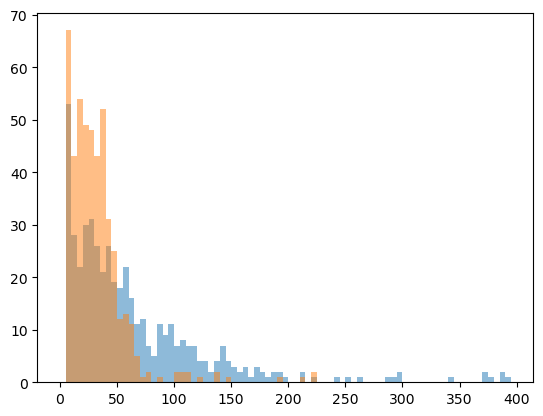

In [1769]:
plt.hist((6.25+DF.length_145max-DF.length_145min)[DF.extent>0], bins = np.arange(0,400,5),alpha=0.5);
plt.hist((6.25+DF.width)[DF.extent>0], bins = np.arange(0,400,5),alpha=0.5);

In [1737]:
10 * units('km/day').to('m/s') / (7*units('m/s'))

<Quantity(0.0165343915, 'dimensionless')>

10
[-180  150  155  160  165  170  175]
i
[135 140 145 150 155 160 165 170 175]


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_55175/616736866.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['E','','N','','W ','','S'])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_55175/616736866.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['E','','N','','W ','','S'])


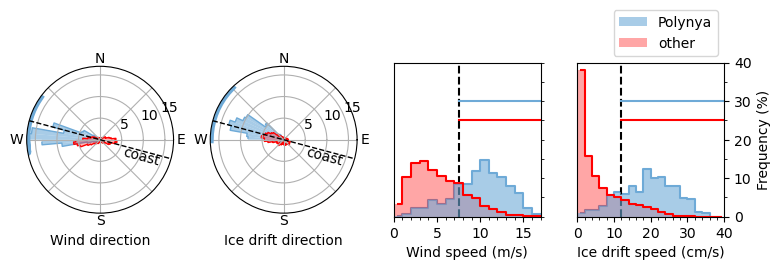

In [1655]:

# create plot
fig, axs = plt.subplots(1,4, figsize=(9,2), subplot_kw={'projection': None})

# Override specific subplots to be polar using add_subplot
fig.delaxes(axs[0])
fig.delaxes(axs[1])
axs[0] = fig.add_subplot(1,4, 1, projection='polar')
axs[1] = fig.add_subplot(1,4, 2, projection='polar')


#============
DF = df

# DF = df[(df.year>=2003)&(df.year<2016)]
# DF = df[(df.year>=2016)&(df.year<2026)]
#============

ccolor = c2
bcolor = 'red'

bins = np.arange(-180,181,5)
comp_ = (DF.extent==0)
# open_ = (DF.extent>0)&(not_last_day)
open_ = (DF.extent>0)&(not_last_day)

# open_ = DF.day_before_event == -1
# open_ = ((DF.extent>0)&(not_last_day)) + (DF.day_before_event == -1)
# open_strict = (open_)&(DF.final_day == False)
# base_cond = (daily_data['ppd']['year'] >= 2003)&(daily_data['ppd']['year'] < 2024)


for ax, group, color in zip(axs[0:2], ['10', 'i'], [ccolor,ccolor]):
    
    x = DF[f'a{group}'][comp_]
    h = plotter.quick_hist(x, bin_edges = bins)

    x = DF[f'a{group}'][open_]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    
    theta = h2['centers'] * np.pi/180
    width = h['w']* np.pi/180
    ax.bar(theta, 100*h2['prob'], width=width, bottom=0.0, alpha=0.6, color=color, zorder=-1)
    ax.step(theta, 100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=-1)
    
    # Plot bars
    theta = h['centers'] * np.pi/180
    ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.3, color=bcolor, zorder=0)
    ax.step(theta, 100*h['prob'], where='mid', alpha=1, color=bcolor,lw=1, zorder=0)
    
    print(group)
    print(h2['edges'][:-1][(h2['prob']>1.5*h['prob'])&(h2['prob']>0.02)])
    
#     ax.plot(theta, 100*h2['prob'], alpha=1, color=color, marker='.', zorder=-1)
#     ax.plot(theta, 100*h['prob'], alpha=1, color=bcolor, marker='.', zorder=-1)
    
    
for ax in axs[0:2]:
    ax.set_yticks([5,10,15])
    ax.set_yticklabels([5,10,15])
#     ax.set_yticklabels(['',5,''], color=bcolor)
    ax.set_ylim(0,17)
    ax.set_theta_zero_location("E")  # Set 0 at the top
    ax.set_theta_direction(1)  # Clockwise direction
    ax.set_axisbelow(True) 
#     ax.grid(True, zorder=-10001)
    
    ax.set_xticklabels(['E','','N','','W ','','S'])
    ax.tick_params(axis='x', pad=-5)

    # coastline orientation
    th = -15*np.pi/180
    ax.plot([th, th], [0,ax.get_ylim()[1]], c='k', ls='dashed', lw=1, zorder=100)
    ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='k', ls='dashed', lw=1, zorder=100)
    ax.text(-15*np.pi/180, 5, 'coast', rotation = -15, va='top')
    
ax = axs[0]
th1 = -170*np.pi/180
th2 = 145*np.pi/180
ax.plot(np.append(np.linspace(-np.pi,th1,10), np.linspace(th2, np.pi,10)[::-1]), 
        np.full(20,ax.get_ylim()[1]), c=color, ls='solid', lw=5)
ax.set_xlabel('Wind direction') 

ax = axs[1]
th1 = -180*np.pi/180
th2 = 135*np.pi/180
ax.plot(np.append(np.linspace(-np.pi,th1,10), np.linspace(th2, np.pi,10)[::-1]), 
        np.full(20,ax.get_ylim()[1]), c=color, ls='solid', lw=5)
ax.set_xlabel('Ice drift direction') 

for ax, group, color, bins in zip(axs[2:], ['10', 'i'], [ccolor,ccolor], 
                                  [np.arange(0,19,1), np.arange(0,41,2)]):
    
    x = DF[f's{group}'][comp_]
    h = plotter.quick_hist(x, bin_edges = bins)

    x = DF[f's{group}'][open_]
    h2 = plotter.quick_hist(x, bin_edges = bins)


    ax.bar(h2['centers'], 100*h2['prob'], width=h2['w'], bottom=0.0, alpha=0.6, color=color, zorder=0, label='Polynya')
    ax.step(h2['centers'], 100*h2['prob'], where='mid', alpha=1, color=color, zorder=-1)
    
    # Plot bars
    ax.bar(h['centers'], 100*h['prob'], width=h['w'], bottom=0.0, alpha=0.35, color=bcolor, zorder=-1, label='other')
    ax.step(h['centers'], 100*h['prob'], where='mid', alpha=1, color=bcolor, zorder=0)

    yy = 15
    
#     dst = DF[f's{group}']
    
    
#     ax.axvline(np.nanpercentile(dst, 50), c='k', zorder=-1)
#     ax.axvline(np.nanpercentile(dst, 25), c='k', zorder=-1, ls='dashed', lw=1)
#     ax.axvline(np.nanpercentile(dst, 75), c='k', zorder=-1, ls='dashed', lw=1)
    
#     ax.fill_betweenx([0,40],np.nanpercentile(dst, 25), np.nanpercentile(dst, 75), 
#                     color='k', alpha=0.15, lw=0, zorder=-1)
    
    
axs[2].axvline(7.5, c='k', ls='dashed', zorder=-1)
axs[3].axvline(12, c='k', ls='dashed', zorder=-1)

yy = 30
axs[2].plot([7.5,17], [yy,yy], c=ccolor)
# axs[2].text(12, yy, f'{100*np.sum(wind_speed_cond(DF[open_]))/np.sum(open_):.0f}%',  c=ccolor, va='bottom')
yy = 25
axs[2].plot([7.5,17], [yy,yy], c=bcolor)
# axs[2].text(12, yy, f'{100*np.sum(wind_speed_cond(DF[comp_]))/np.sum(comp_):.0f}%',  c=bcolor, va='bottom')


yy = 30
axs[3].plot([12,40], [yy,yy], c=ccolor)
# axs[3].text(25, yy, f'{100*np.sum(ice_speed_cond(DF[open_]))/np.sum(open_):.0f}%',  c=ccolor, va='bottom')
yy = 25
axs[3].plot([12,40], [yy,yy], c=bcolor)
# axs[3].text(25, yy, f'{100*np.sum(ice_speed_cond(DF[comp_]))/np.sum(comp_):.0f}%',  c=bcolor, va='bottom')


#     ax.axvline(np.nanmean(dst)-np.nanstd(dst), c='k', zorder=-1)
#     ax.axvline(np.nanmean(dst), c='k', zorder=-1)
#     ax.axvline(np.nanmean(dst)+np.nanstd(dst), c='k', zorder=-1)
    
    
    
#     ax.scatter(np.nanmean(dst), yy, c='k')
#     ax.plot([np.nanmean(dst)-0.5*np.nanstd(dst),
#             np.nanmean(dst)+0.5*np.nanstd(dst)],
#             [yy,yy], c='k', lw=2,)
#     ax.plot([np.nanmean(dst)-1*np.nanstd(dst),
#             np.nanmean(dst)+1*np.nanstd(dst)],
#             [yy,yy], c='k', lw=0.5)
    
ax.legend(bbox_to_anchor=(0.2,1))
    
#     ax.axvline(np.nanmean(dst), c='k', lw=1.5)
#     ax.axvline(np.nanmean(dst)-0.5*np.nanstd(dst), c='k', lw=0.5)
#     ax.axvline(np.nanmean(dst)+0.5*np.nanstd(dst), c='k', lw=0.5)
    
#     ax.axvline(np.nanpercentile(daily_data[group]['s'][comp_], 50), c='gray', lw=1.5)
#     ax.axvline(np.nanpercentile(daily_data[group]['s'][comp_], 25), c='gray', lw=0.5)
#     ax.axvline(np.nanpercentile(daily_data[group]['s'][comp_], 75), c='gray', lw=0.5)

    
ax = axs[2]
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_yticks([])
ax.set_xlabel('Wind speed (m/s)')  
ax.set_xlim(0,17)
ax.set_ylim(0,40)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax = axs[3]
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_xlabel('Ice drift speed (cm/s)')  
ax.set_ylabel('Frequency (%)')  
plt.subplots_adjust(wspace=0.25)
ax.set_xlim(0,40)
ax.set_ylim(0,40)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# fig.savefig('../figures/results/forcing_distributions.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [28]:
wind_cond(df)

TypeError: 'numpy.ndarray' object is not callable

In [771]:
pol_stats = {}

pol_stats['counts'] = {}
pol_stats['size'] = {}
pol_stats['days'] = {}

pol_stats['t2m'] = {}
pol_stats['t2m_events'] = {}

pol_stats['wind_events'] = {}
pol_stats['ice_events'] = {}

pol_stats['ice_speeds'] = {}
pol_stats['non_ice_speeds'] = {}

pol_stats['wind_speeds'] = {}
pol_stats['non_wind_speeds'] = {}


yearss = np.arange(1987,2026)


for key in pol_stats.keys():

    for mm, month in enumerate(months):
        
        pol_stats[key][month] = {}

        for yy, year in enumerate(yearss):
            
            pol_stats[key][month][year] = np.array([])

        
        
    
open_cond = df.extent > 0 
#&(last_days_of_seqs==False)
        
    
    
dir_cond = (df.a10_r.values > 260) + (df.a10_r.values < 320)
speed_cond = (df.s10.values > 6.5)
# speed_cond = (df.s10.values > 9)
# speed_cond = (daily_data['era']['s'] > 0)
    
    
dir_condi = (df.ai_r.values > 270)  & (df.ai_r.values < 330) 
# speed_condi = (daily_data['ppd']['s'] > 11.6)
speed_condi = (df.si_km.values > 10)

# speed_condi = (df.si.values > 17)
# speed_condi = (daily_data['ppd']['s'] > 0)
    
    
# loop through all dates
for mm, month in enumerate(months):
    
    for yy, year in enumerate(yearss):
        
        time_cond = (df.month==month)&(df.year==year)
        wind_cond = (dir_cond&speed_cond)
        ice_cond = (dir_condi&speed_condi)
        
        
        pol_extents = df.extent[time_cond&open_cond]

        pol_stats['size'][month][year] = np.append(pol_stats['size'][month][year], pol_extents)
        pol_stats['counts'][month][year] = np.append(pol_stats['counts'][month][year], len(pol_extents))
        pol_stats['days'][month][year] = np.append(pol_stats['days'][month][year], np.sum(time_cond))
        
        
        pol_stats['t2m'][month][year] = np.append(pol_stats['t2m'][month][year], 
                                                  df.t2m[time_cond])
        pol_stats['t2m_events'][month][year] = np.append(pol_stats['t2m_events'][month][year], 
                                                         df.t2m[time_cond&open_cond])
        
        
        pol_stats['wind_events'][month][year] = np.append(pol_stats['wind_events'][month][year], 
                                                          np.sum(time_cond&wind_cond))
        pol_stats['ice_events'][month][year] = np.append(pol_stats['ice_events'][month][year], 
                                                         np.sum(time_cond&ice_cond))
        
        
        pol_stats['ice_speeds'][month][year] = np.append(pol_stats['ice_speeds'][month][year], 
                                                         df.si[(time_cond&ice_cond)])
        pol_stats['non_ice_speeds'][month][year] = np.append(pol_stats['non_ice_speeds'][month][year], 
                                                             df.si[(time_cond&(wind_cond==False))])

        pol_stats['wind_speeds'][month][year] = np.append(pol_stats['wind_speeds'][month][year], 
                                                          df.s10[(time_cond&ice_cond)])
        pol_stats['non_wind_speeds'][month][year] = np.append(pol_stats['non_wind_speeds'][month][year], 
                                                              df.s10[(time_cond&(wind_cond==False))])


In [14]:
10.1*units('cm/s').to('km/day')

<Quantity(8.7264, 'kilometer / day')>

In [15]:
10*units('km/day').to('cm/s')

<Quantity(11.5740741, 'centimeter / second')>


0.610698140367823
0.37295221864871725
0.8683303548634158
-25.94983405667603
0.0032764780351239135


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_35446/2593259450.py:24: RuntimeWarning: Mean of empty slice
  all_ws = np.append(all_ws, np.nanmean(total_EWE))
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_35446/2593259450.py:30: RuntimeWarning: Mean of empty slice
  all_is = np.append(all_is, np.nanmean(total_iWE))


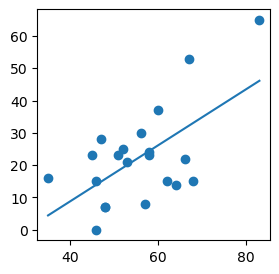

In [772]:
fig, ax = plt.subplots(figsize=(3,3))


all_wf = np.array([])
all_is = np.array([])
all_ws = np.array([])

all_we = np.array([])
all_ie = np.array([])
all_pe = np.array([])

all_wri = np.array([])
all_ci = np.array([])

all_sz = np.array([])

MONTHS = months#[1:-1]

for yy, year in enumerate(yearss):
    
    total_EWE = np.array([])
    for mm, month in enumerate(MONTHS):
        total_EWE = np.append(total_EWE, pol_stats['wind_speeds'][month][year])
    all_ws = np.append(all_ws, np.nanmean(total_EWE))
#     all_ws = np.append(all_ws, np.nanpercentile(total_EWE, 5))
    
    total_iWE = np.array([])
    for mm, month in enumerate(MONTHS):
        total_iWE = np.append(total_iWE, pol_stats['ice_speeds'][month][year])
    all_is = np.append(all_is, np.nanmean(total_iWE))
    
        
#     total_i = np.array([])
#     for mm, month in enumerate(months):
#         total_i = np.append(total_i, pol_stats['ice_speeds'][month][year])

    total_w = 0
    for mm, month in enumerate(MONTHS):
        total_w += np.sum(pol_stats['wind_events'][month][year])
    all_we = np.append(all_we, np.sum(total_w))
    
    total_i = 0
    for mm, month in enumerate(MONTHS):
        total_i += np.sum(pol_stats['ice_events'][month][year])
    all_ie = np.append(all_ie, np.sum(total_i))
    
    total_e = 0
    for mm, month in enumerate(MONTHS):
        total_e += np.sum(pol_stats['counts'][month][year])
    all_pe = np.append(all_pe, np.sum(total_e))
    
    total_s = 0
    for mm, month in enumerate(MONTHS):
        total_s += np.sum(pol_stats['size'][month][year])
    all_sz = np.append(all_sz, np.sum(total_s))
    
#     total_ia = np.array([])
#     for mm, month in enumerate(months):
#         total_ia = np.append(total_ia, pol_stats['ice_ese'][month][year])
        
#     all_wf = np.append(all_wf, np.nanmedian(total_EWE))
#     all_ws = np.append(all_ws, np.sum(total_EWE > 6))
#     all_is = np.append(all_is, np.sum(total_i > 10))
    
#     all_wf = np.append(all_wf, np.nanmean(total_iWE/total_EWE))
    all_wf = np.append(all_wf, np.nanpercentile(total_iWE/total_EWE, 50))
    
    
    
    all_ci = np.append(all_ci, np.nansum(total_i))
    
    
    

x = all_we[((yearss>=2003)&(yearss<=2023))]#&(yearss!=2016)]
y = all_pe[((yearss>=2003)&(yearss<=2023))]#&(yearss!=2016)]


# x = yearss[(yearss>=2003)]#&(yearss!=2016)]
# y = (all_we)[(yearss>=2003)]#&(yearss!=2016)]

# x = yearss#[(yearss>=2003)]#&(yearss!=2016)]
# y = (all_ws)#[(yearss>=2003)]#&(yearss!=2016)]


# x = yearss#[(yearss>=2003)]
# y = all_ws#[(yearss>=2003)]

# x = yearss#[(yearss>=2003)]
# y = all_wf#[(yearss>=2003)]

x = x#[:-1]
y = y#[:-1]

x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]

res = stats.linregress(x_nn,y_nn)
print()
print(res.rvalue)
print(res.rvalue**2)
print(res.slope)
print(res.intercept)
print(res.pvalue)

x_line = np.array([x_nn.min(),x_nn.max()])
y_line = res.intercept + res.slope*x_line

ax.scatter(x,y)
ax.plot(x_line, y_line)

# ax.set_xlim(0,90)


# x_line = np.array([3,20])
# y_line = res.intercept + res.slope*x_line
# ax.plot(x_line, y_line, c='r')

# plt.ylim(0,3)

In [773]:

def linear_regress(x, y):
    
    if type(x) != np.ndarray:
        x = np.array(x)
        
    if type(y) != np.ndarray:
        y = np.array(y)
    
    x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
    y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
    
    res = stats.linregress(x_nn,y_nn)
    
    x_line = np.array([x_nn.min(), x_nn.max()])
    y_line = res.intercept + res.slope * x_line
    
    return res, x_line, y_line



/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_35446/824577155.py:24: RuntimeWarning: invalid value encountered in scalar divide
  ipe.append(ice_event/wind_event)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_35446/824577155.py:14: RuntimeWarning: All-NaN slice encountered
  med_wf.append(np.nanmedian(all_wf))


Text(0, 0.5, 'Events per\nwind event')

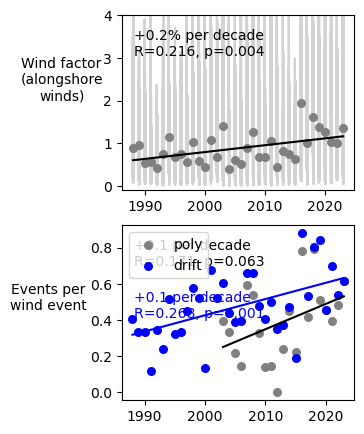

In [774]:
fig, axs = plt.subplots(2,1, figsize=(3,5))

med_wf = []
epe = []
ipe = []

for yy, year in enumerate(yearss):

    ax = axs[0]
    time_cond = ((df.year == year) & dir_cond) & (df.s10>2)
    all_wf = df.si[time_cond]/df.s10[time_cond]
    bf = 0.1
    ax.plot(np.linspace(year-bf, year+bf, np.sum(time_cond)), all_wf, c='lightgray', ms=0, zorder=-1)
    med_wf.append(np.nanmedian(all_wf))
    
    
    ax = axs[1]
    ice_event = np.sum(((df.year == year) & dir_condi) & (speed_condi))
    pol_event = np.sum((df.year == year) & (df.extent>0))
    wind_event = np.sum(((df.year == year) & dir_cond) & (speed_cond))
#     all_wf = df.si[time_cond]/df.s10[time_cond]
    bf = 0.1
    if (year < 2024):
        ipe.append(ice_event/wind_event)
    if (year < 2024)&(year>=2003):
        epe.append(pol_event/wind_event)
#         ax.scatter(year, pol_event/ice_event, c='gray',zorder=-1)
#     ax.scatter(year, wind_event, c='k',zorder=-1)
#     med_wf.append(np.nanmedian(all_wf))
    
    
ax = axs[0]
ax.scatter(yearss, med_wf, c='gray', marker='o', s=30)
x = yearss
y = med_wf
res, x_line, y_line = linear_regress(x, y)
ax.plot(x_line, y_line, c='k')
ax.text(0.05,0.925, f'+{10*res.slope:.1f}% per decade\nR={res.rvalue**2:.3f}, p={res.pvalue:.3f}', va='top', transform=ax.transAxes)
ax.set_ylabel('Wind factor\n(alongshore\nwinds)', rotation=0,labelpad=30)
ax.set_ylim(-0.1,4)


ax = axs[1]

x = yearss[(yearss < 2024)&(yearss>=2003)]
y = epe
ax.scatter(x,y, c='gray', marker='o', s=30, label='poly')
res, x_line, y_line = linear_regress(x, y)
ax.plot(x_line, y_line, c='k')
ax.text(0.05,0.925, f'+{10*res.slope:.1f} per decade\nR={res.rvalue**2:.3f}, p={res.pvalue:.3f}', 
        va='top', transform=ax.transAxes)

x = yearss[(yearss < 2024)]
y = ipe
ax.scatter(x,y, c='b', marker='o', s=30, label='drift')
res, x_line, y_line = linear_regress(x, y)
ax.plot(x_line, y_line, c='b')
ax.text(0.05,0.625, f'+{10*res.slope:.1f} per decade\nR={res.rvalue**2:.3f}, p={res.pvalue:.3f}', 
        va='top', transform=ax.transAxes, c='b')
ax.legend()
ax.set_ylabel('Events per\nwind event', rotation=0,labelpad=30)

# ax.set_ylabel('Wind factor\n(alongshore\nwinds)', rotation=0,labelpad=30)
# ax.set_ylim(-0.1,4)



Text(0.5, 0, 'year')

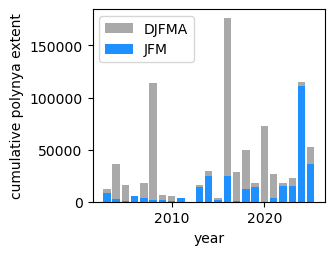

In [775]:
fig, ax = plt.subplots(figsize=(3,2.5))

for yy, year in enumerate(yearss[yearss>2002]):
    
    total_size = 0
    for mm, month in enumerate(months):
        total_size += np.sum(pol_stats['size'][month][year])
        
    ax.bar(year, total_size, color='darkgray', label = 'DJFMA')
    
    total_size = 0
    for mm, month in enumerate(months[1:-1]):
        total_size += np.sum(pol_stats['size'][month][year])
        
    ax.bar(year, total_size, color='dodgerblue', label = 'JFM')
    
# Get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
# Create a dictionary to remove duplicate labels
by_label = dict(zip(labels, handles))
# Recreate legend with unique labels
plt.legend(by_label.values(), by_label.keys())


plt.ylabel('cumulative polynya extent')
plt.xlabel('year')

Text(2003.25, 87, '  Pack drift events (R=0.916)')

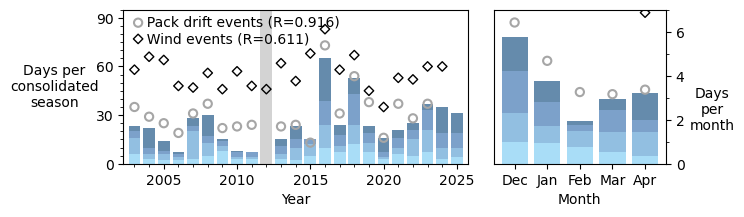

In [776]:
fig, axs = plt.subplots(1,2,figsize=(7,2), gridspec_kw={'width_ratios':[2,1]})


years = np.arange(2003,2026)
months = [12,1,2,3,4]

# total events per year
annual_counts = [np.sum([pol_stats['counts'][month][year][0] for month in months]) for year in years]


mar1_kw = {'edgecolor': 'k', 'facecolor':'None', 'lw':1., 'marker':'D', 'zorder':10, 's':23}
mar2_kw = {'edgecolor': [0.65,0.65,0.65], 'facecolor':'None', 'lw':1.5, 'marker':'o', 's':35}


for yy, year in enumerate(years):
    
    month_colors = ['royalblue','skyblue','mediumpurple', 'lightcoral','r']
    
    last_num = 0
    
    cts_by_size = {}
    for q in ['q1','q2','q3','q4']:
        cts_by_size[q]=0
    for mm, month in enumerate(months):
        my_sizes = pol_stats['size'][month][year]
        cts_by_size['q1'] += np.sum((my_sizes > 0) & (my_sizes <= 155))
        cts_by_size['q2'] += np.sum((my_sizes > 155) & (my_sizes <= 500))
        cts_by_size['q3'] += np.sum((my_sizes > 500) & (my_sizes <= 1500))
        cts_by_size['q4'] += np.sum(my_sizes > 1500)

    ax = axs[0]
    last_num = 0
    for color, q in zip([c1,c2,c3,c4],['q1','q2','q3','q4']):
        current_num = cts_by_size[q]       
        ax.bar(year, current_num, bottom = last_num, color=color, alpha=0.75)
        last_num+=current_num
        
    if year <= 2024:
        total_WE = 0
        for mm, month in enumerate(months):
            total_WE += pol_stats['wind_events'][month][year][0]
        ax.scatter(year, total_WE, **mar1_kw)
    
    if year <= 2023:
        total_WE = 0
        for mm, month in enumerate(months):
            total_WE += pol_stats['ice_events'][month][year][0]
        ax.scatter(year, total_WE, **mar2_kw)

        
ax.set_ylim(0,95)
ax.bar(2012, ax.get_xlim()[-1], color='lightgray')
ax.set_xlim(2002.25,2025.75)
ax.set_ylabel('Days per\nconsolidated\nseason', rotation=0, labelpad=30, va='center')
ax.set_xlabel('Year')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(30))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))


for mm, month in enumerate(months):
    
    cts_by_size = {}
    for q in ['q1','q2','q3','q4']:
        cts_by_size[q]=0
    for yy, year in enumerate(years):
        my_sizes = pol_stats['size'][month][year]
        cts_by_size['q1'] += np.sum((my_sizes > 0) & (my_sizes <= 155))
        cts_by_size['q2'] += np.sum((my_sizes > 155) & (my_sizes <= 500))
        cts_by_size['q3'] += np.sum((my_sizes > 500) & (my_sizes <= 1700))
        cts_by_size['q4'] += np.sum(my_sizes > 1700)
        
    days_per_year = 0
    for yy, year in enumerate(years):
        days_per_year+=pol_stats['days'][month][year]/len(years)
        
    days_per_year_ice = 0
    for yy, year in enumerate(years[:-2]):
        days_per_year_ice+=pol_stats['days'][month][year]/len(years[:-2])
        
    ax = axs[1]
    last_num = 0
    for color, q in zip([c1,c2,c3,c4],['q1','q2','q3','q4']):
        current_num = cts_by_size[q]/days_per_year
        ax.bar(mm, current_num, bottom = last_num, color=color, alpha=0.75)
        last_num+=current_num
        

    total_WE = 0
    for yy, year in enumerate(years[:-2]):
        total_WE += pol_stats['wind_events'][month][year][0]
    ax.scatter(mm, total_WE/days_per_year_ice, **mar1_kw)
    
    total_WE = 0
    for yy, year in enumerate(years[:-2]):
        total_WE += pol_stats['ice_events'][month][year][0]
    ax.scatter(mm, total_WE/days_per_year_ice, **mar2_kw)
    
    

    
# total_w = 0
#     for mm, month in enumerate(MONTHS):
#         total_w += np.sum(pol_stats['wind_events'][month][year])
#     all_we = np.append(all_we, np.sum(total_w))
    
#     total_i = 0
#     for mm, month in enumerate(MONTHS):
#         total_i += np.sum(pol_stats['ice_events'][month][year])
#     all_ie = np.append(all_ie, np.sum(total_i))
    
ax.set_ylabel('Days\nper\nmonth', rotation=0, labelpad=20, va='center')
ax.set_xlabel('Month')
ax.set_xticks(range(len(months)))
ax.set_xticklabels(['Dec','Jan','Feb','Mar','Apr'])
ax.set_ylim(0,7)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))


#     ax.scatter(year, cts_by_size['q1'])
#     ax.scatter(year, cts_by_size['q2'])
    
#     for mm, month in enumerate(months):
        
#         current_num = np.sum(pol_stats['counts'][month][year])            
#         ax.bar(year, current_num, bottom = last_num, color=month_colors[mm], alpha=0.75)
#         last_num += current_num


# plt.scatter(years, annual_counts, c='k')
        
# axs[0].set_ylim(2,18)

plt.subplots_adjust(wspace=0.1)


x = all_ie[(yearss>=2003)&(yearss<2024)]
y = all_pe[(yearss>=2003)&(yearss<2024)]
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
resp = stats.linregress(x_nn,y_nn)
Rp = resp.rvalue

x = all_we[(yearss>=2003)&(yearss<2024)]
y = all_pe[(yearss>=2003)&(yearss<2024)]
x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]
resa = stats.linregress(x_nn,y_nn)
Rw = resa.rvalue


ax = axs[0]
ax.scatter(2003.25,77, **mar1_kw)
ax.text(2003.25,77, f'  Wind events (R={Rw:.3f})', va='center')
ax.scatter(2003.25,87, **mar2_kw)
ax.text(2003.25,87, f'  Pack drift events (R={Rp:.3f})', va='center')

# fig.savefig('../figures/results/occurence_stats.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [940]:
res = resp
print()
print(res.rvalue)
print(res.rvalue**2)
print(res.slope)
print(res.intercept)
print(res.pvalue)

res = resa
print()
print(res.rvalue)
print(res.rvalue**2)
print(res.slope)
print(res.intercept)
print(res.pvalue)



0.9237209143797228
0.8532603276625113
0.9815889651283017
-7.388652598928477
2.3443311680598714e-09

0.8104851529304642
0.6568861831207179
1.2582376247555045
-7.5909524048347485
8.404562685687147e-06


In [3757]:
1.95/1.65

1.1818181818181819

In [3672]:
2.0486288345995574/1.4772174203710688

1.3868160545283532

In [3246]:
9.663299431412842/8.391848843724535

1.1515101870119007

In [3247]:
18.417816264759292/15.2

1.2116984384710061

In [3248]:
y_line

array([ 9.09485059, 68.28538908])

In [3249]:
year = 2022
month=3
pol_stats['counts'][month][year]

array([7.])

0.6950490096744023
0.48309312584936737
3.3950547037318706
0.0006699418913965849


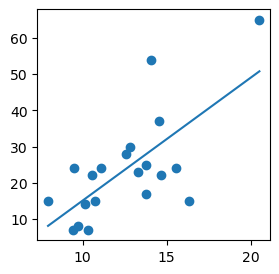

In [110]:
annual_event_winds = np.array([])
annual_event_wf = np.array([])
annual_event_ice = np.array([])
winds_per_year = np.array([])
ice_per_year = np.array([])
events_per_year = np.array([])
extent_per_year = np.array([])

for yy, year in enumerate(years):
    
    all_is = np.array([])
    for mm, month in enumerate(months):
        all_is = np.append(all_is, pol_stats['wind_speeds'][month][year])
    annual_event_winds = np.append(annual_event_winds, np.nanpercentile(all_is,25))
    
    all_is = np.array([])
    for mm, month in enumerate(months):
        all_is = np.append(all_is, pol_stats['ice_speeds'][month][year]/pol_stats['wind_speeds'][month][year])
    annual_event_wf = np.append(annual_event_wf, np.nanpercentile(all_is,25))
    
    all_is = np.array([])
    for mm, month in enumerate(months):
        all_is = np.append(all_is, pol_stats['ice_speeds'][month][year])
#     annual_event_ice = np.append(annual_event_ice, np.nanpercentile(all_is,50))

    annual_event_ice = np.append(annual_event_ice, np.nanmean(all_is))
    
    total_ev = 0
    total_ext = 0
    for mm, month in enumerate(months):
        total_ev += np.sum(pol_stats['counts'][month][year])
        total_ext += np.sum(pol_stats['size'][month][year])
    events_per_year = np.append(events_per_year, total_ev)
    extent_per_year = np.append(extent_per_year, total_ext)
    
    total_WE = 0
    for mm, month in enumerate(months):
        total_WE += pol_stats['wind_events'][month][year][0]
    winds_per_year = np.append(winds_per_year, total_WE)
    
    total_WE = 0
    for mm, month in enumerate(months):
        total_WE += pol_stats['ice_events'][month][year][0]
    ice_per_year = np.append(ice_per_year, total_WE)

fig, ax = plt.subplots(figsize=(3,3))


x = annual_event_ice
y = events_per_year

x = x#[:-2]
y = y#[:-2]

x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]

res = stats.linregress(x_nn,y_nn)
print(res.rvalue)
print(res.rvalue**2)
print(res.slope)
print(res.pvalue)

x_line = np.array([x_nn.min(),x_nn.max()])
y_line = res.intercept + res.slope*x_line

ax.scatter(x,y)
ax.plot(x_line, y_line, label=f'ice dir & sp >10\nR={res.rvalue:.3f}, slope={res.slope:.3f}')
# plt.ylim(0,1.5)

# x_line = np.array([250,500])
# y_line = res.intercept + res.slope*x_line
# ax.plot(x_line, y_line, c='r')

# x = winds_per_year
# y = events_per_year

# x = x[:-1]
# y = y[:-1]

# x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
# y_nn = y[(np.isfinite(x))&(np.isfinite(y))]

# res = stats.linregress(x_nn,y_nn)
# print()
# print(res.rvalue)
# print(res.rvalue**2)
# print(res.slope)
# print(res.pvalue)

# x_line = np.array([x_nn.min(),x_nn.max()])
# y_line = res.intercept + res.slope*x_line

# ax.scatter(x,y)
# ax.plot(x_line, y_line, label=f'wind dir & sp >6\nR={res.rvalue:.3f}, slope={res.slope:.3f}')
# plt.ylim(0,1.5)

# ax.set_xlim(0,85)
# ax.set_ylim(0,85)

# ax.plot(ax.get_xlim(), ax.get_xlim(), lw=1, ls='solid', c='lightgray', zorder=-1)

# ax.set_ylabel('Polynya days')
# ax.set_xlabel('Forcing days')
# plt.legend();

# fig.savefig('../figures/results/correlations_time.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [112]:
10 * units('cm/s').to('km/day')

<Quantity(8.64, 'kilometer / day')>

In [3833]:
0.931*0.931

0.8667610000000001

In [3793]:
print(np.nanpercentile(daily_data['ppd']['s'], 75))
print(np.nanpercentile(daily_data['era']['s'], 75))

12.521775317737825
7.7104723802559825


In [3781]:
np.nanpercentile(daily_data['ppd']['s'][comp_], 75)

9.711912027812426

In [3823]:
np.nanpercentile(daily_data['ppd']['s'][open_], 25)

10.145652704538747

In [3788]:
np.nanpercentile(daily_data['era']['s'], 75)

7.7104723802559825

In [3825]:
np.nanpercentile(daily_data['era']['s'][open_], 25)

6.181950227714969

In [3774]:
np.nanpercentile(daily_data['ppd']['s'], 50)

5.176514166235827

In [ ]:
daily_data['ppd']['s']

0.5467977611015983
0.2989877915457205
0.02660317786840125
0.018863143536958824


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


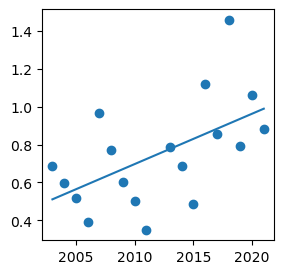

In [3819]:
fig, ax = plt.subplots(figsize=(3,3))


x = years
y = events_per_year/winds_per_year#/(ice_per_year/winds_per_year)

x = x[:-2]
y = y[:-2]

x_nn = x[(np.isfinite(x))&(np.isfinite(y))]
y_nn = y[(np.isfinite(x))&(np.isfinite(y))]

res = stats.linregress(x_nn,y_nn)
print(res.rvalue)
print(res.rvalue**2)
print(res.slope)
print(res.pvalue)

x_line = np.array([x_nn.min(),x_nn.max()])
y_line = res.intercept + res.slope*x_line

ax.scatter(x,y)
ax.plot(x_line, y_line)
# plt.ylim(0,1.5)


# ax.plot(ax.get_xlim(), ax.get_xlim(), lw=1, ls='dashed', c='gray')



In [3316]:
winds

NameError: name 'winds' is not defined

In [3103]:
y_line

array([8.57396412, 8.44124721, 8.3085303 , 8.17581339, 8.04309647,
       7.91037956, 7.77766265, 7.64494574, 7.51222883, 7.24679501,
       7.11407809, 6.98136118, 6.84864427, 6.71592736, 6.58321045,
       6.45049354, 6.31777663, 6.18505972, 6.0523428 , 5.91962589,
       5.78690898, 5.65419207])

In [3092]:
pol_stats['wind_events'][month][year]

array([0.])

In [3089]:
events_per_year

array([20., 17.,  7.,  7., 16., 12., 12.,  8.,  4., 15., 18., 12., 51.,
       16., 42., 23.,  9., 10., 16., 31., 28., 16.])

In [3090]:
winds_per_year

array([51., 51., 51., 51., 51., 51., 51., 51., 51., 51., 51., 51., 51.,
       51., 51., 51., 51., 51., 51., 51., 51., 51.])

In [3051]:
annual_event_winds

array([ 8.16548487, 10.67211021,  9.16597438, 10.07089463,  9.28179623,
        8.51386285,  7.78639661,  7.24728549,  8.12841041, 10.1964491 ,
        8.8899688 ,  7.63164826, 10.42877353,  7.92798769,  7.51910082,
        7.56877254,  8.63025456,  8.50711147,  7.43973022,  8.31976444,
        8.51229528,         nan])

In [3043]:
for year in years:
    print(year)

2003
2004
2005
2006
2007
2008
2009
2010
2011
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025


In [2835]:
18/16

1.125

In [2798]:
pol_stats['wind_events'][month][year]

array([0.])

In [2783]:
days_per_year/len(years)

array([30.])

In [2752]:
pol_stats['size'][month][year]

array([], dtype=float64)

In [2685]:
cdict

array([1442.85942894,  974.58529852])

In [2684]:
pol_extents

array([1442.85942894,  974.58529852])

In [2689]:
pol_stats['size'][month][year]

array([1442.85942894,  974.58529852])

In [2681]:
month

4

In [2679]:
pol_extents

array([1442.85942894,  974.58529852])

In [ ]:
for mm, month in enumerate(months):
for yy, year in enumerate(years[years<2025]):

[Text(0, 0, '12'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4')]

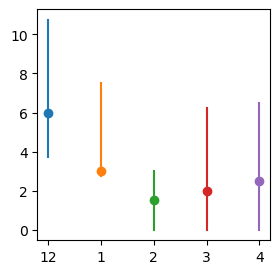

In [2673]:
fig, ax = plt.subplots(figsize=(3,3))

# ax.scatter(daily_data['era']['month'], daily_data['ppd']['ese'], s=1)



for mm, month in enumerate(months):
    
    month_cond = daily_data['era']['month']==month
    month_counts = []
    
    for yy, year in enumerate(years[years<2025]):
    
        year_cond = daily_data['era']['year']==year
        open_cond = daily_data['pol']['extent']>0

    #     mean_ppd_ese = np.nanmean(daily_data['ppd']['ese'][daily_data['ppd']['month']==month])
    #     mean_era_ese = np.nanmean(daily_data['era']['ese'][daily_data['era']['month']==month])
        mean_pol_ext = daily_data['pol']['extent'][month_cond&open_cond]


        pol_counts = np.sum((open_cond&month_cond)&year_cond)
        month_counts.append(pol_counts)

    #     cond = (daily_data['era']['ese'] > 0) & (daily_data['ppd']['month']==month)
    #     print(np.sum(cond)/len(years))
    #     monthly_wf = (daily_data['ppd']['ese']/daily_data['era']['ese'])[cond]

    #     ax.scatter(mm, mean_ppd_ese/mean_era_ese, s=1)

    #     ax.scatter(mm, np.nanmedian(mean_pol_ext), s=50)
    #     ax.plot([mm,mm], [np.nanpercentile(mean_pol_ext, 25),
    #                       np.nanpercentile(mean_pol_ext, 75)], )

    ax.scatter(mm, np.nanmedian(month_counts))
    ax.plot([mm,mm], [np.nanpercentile(month_counts, 25),
                      np.nanpercentile(month_counts, 75)])


ax.set_xticks(range(len(months)))
ax.set_xticklabels(months)

# ax.scatter(daily_data['ppd']['ese'], daily_data['era']['t2m'], s=1)
# ax.scatter(daily_data['ppd']['ese'], daily_data['pol']['extent'], s=5)

### Composite Event

In [2643]:
included_days = 0
omitted_days = 0

include_ss = []
omit_ss = []

include_dates  = np.array([], dtype=np.datetime64)
omit_dates = np.array([], dtype=np.datetime64)

include_lengths = []

for ss in all_seqs:
    
    datei = all_seqs[ss][0]
    datef = all_seqs[ss][-1]
    
    if (datei.month == 12) & (datei.day == 1):
        print(datei, datef)
        
        omitted_days+=len(all_seqs[ss])
        omit_ss.append(ss)
        
        for date in all_seqs[ss]:
            omit_dates = np.append(omit_dates, date)
        
        
    elif (datef.month == 4) & (datef.day == 30):
        print(datei, datef)
        
        omitted_days+=len(all_seqs[ss])
        omit_ss.append(ss)
        
        for date in all_seqs[ss]:
            omit_dates = np.append(omit_dates, date)
            
    elif datei == datef:
        print(datei, datef)
        
        omitted_days+=len(all_seqs[ss])
        omit_ss.append(ss)
        
        for date in all_seqs[ss]:
            omit_dates = np.append(omit_dates, date)
        
    else:

        included_days+=len(all_seqs[ss])
        include_ss.append(ss)

        for date in all_seqs[ss]:
            include_dates = np.append(include_dates, date)

        include_lengths.append(len(all_seqs[ss]))

        

2002-12-01 00:00:00 2002-12-01 00:00:00
2003-02-07 00:00:00 2003-02-07 00:00:00
2003-02-28 00:00:00 2003-02-28 00:00:00
2003-03-04 00:00:00 2003-03-04 00:00:00
2003-12-07 00:00:00 2003-12-07 00:00:00
2003-12-25 00:00:00 2003-12-25 00:00:00
2004-01-17 00:00:00 2004-01-17 00:00:00
2004-12-01 00:00:00 2004-12-05 00:00:00
2005-01-23 00:00:00 2005-01-23 00:00:00
2005-02-10 00:00:00 2005-02-10 00:00:00
2005-04-29 00:00:00 2005-04-30 00:00:00
2006-02-13 00:00:00 2006-02-13 00:00:00
2006-12-01 00:00:00 2006-12-01 00:00:00
2006-12-09 00:00:00 2006-12-09 00:00:00
2007-01-13 00:00:00 2007-01-13 00:00:00
2007-02-12 00:00:00 2007-02-12 00:00:00
2007-04-01 00:00:00 2007-04-01 00:00:00
2007-12-01 00:00:00 2007-12-01 00:00:00
2007-12-27 00:00:00 2007-12-27 00:00:00
2008-01-29 00:00:00 2008-01-29 00:00:00
2008-12-18 00:00:00 2008-12-18 00:00:00
2009-01-17 00:00:00 2009-01-17 00:00:00
2009-02-28 00:00:00 2009-02-28 00:00:00
2010-01-31 00:00:00 2010-01-31 00:00:00
2010-12-04 00:00:00 2010-12-04 00:00:00


In [1768]:
np.mean(include_lengths)

4.333333333333333

In [1769]:
len(omit_ss)/(len(include_ss)+len(omit_ss))

0.3918918918918919

In [2368]:
omitted_days/(included_days+omitted_days)

0.16370808678500987

In [2365]:
np.sum(include_lengths)

424

In [1770]:

event_data = {}

event_data['ppd'] = {}
event_data['era'] = {}
event_data['pol'] = {}

include_vars = {}
include_vars['ppd'] = ['u','v','s','ese']
include_vars['era'] = ['u','v','s','ese','msl']
include_vars['pol'] = ['extent']

days = ['m3','m2', 'm1', 'f', 'l', 'p1', 'p2', 'p3', 'd', 's'] 


for key in event_data.keys():
    for var in include_vars[key]:
        event_data[key][var] = {}
        for day in days:
            event_data[key][var][day] = np.array([])

    
for ss in include_ss:
    
    datei = all_seqs[ss][0]
    datef = all_seqs[ss][-1]

    i = np.where(daily_data['era']['time'] == datei)[0][0]
    f = np.where(daily_data['era']['time'] == datef)[0][0]
    
    
    for key in event_data.keys():
        
        for var in include_vars[key]:
        
            data = daily_data[key][var]
            
            if datei != datef:
                for day, ind in zip(['f','l'], [i, f]):
                    event_data[key][var][day] = np.append(event_data[key][var][day], data[ind])
                event_data[key][var]['d'] = np.append(event_data[key][var]['d'], data[i:f+1])
            else:
                event_data[key][var]['s'] = np.append(event_data[key][var]['s'], data[i])

            for day, ind in zip(['m3','m2','m1','p1','p2','p3'], [i-3,i-2, i-1, f+1, f+2,f+3]):
                if ind < len(daily_data[key]['time']):
                    date = daily_data[key]['time'][ind]
                    if (date not in include_dates) & (date not in omit_dates):
                        event_data[key][var][day] = np.append(event_data[key][var][day], data[ind])

            


In [24]:
units('cm/s').to('km/day').magnitude

0.8640000000000001

<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_96495/3373858449.py:33: SyntaxWarning: invalid escape sequence '\m'
  axs[1].set_ylabel('Alongshore\nwind\n($\mathrm{m\;s^{-1}}$)', rotation = 0, labelpad=20, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_96495/3373858449.py:35: SyntaxWarning: invalid escape sequence '\m'
  axs[2].set_ylabel('Along-polynya\npack ice drift\n($\mathrm{km\;d^{-1}}$)', rotation = 0, labelpad=40, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_96495/3373858449.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[-1].set_xticklabels(tick_labels)


76
83
90
90
390
90
90
81


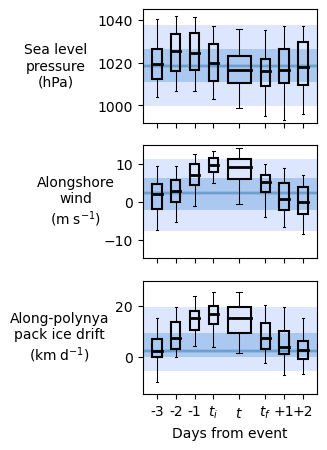

In [1771]:
fig, axs = plt.subplots(3,1,figsize=(2.25,5))


# which x vals to include
labels = ['m3','m2', 'm1', 'f','d','l','p1','p2']
xs = [-3,-2,-1,0,2.25,4.5,5.5,6.5]
tick_labels = ['-3','-2','-1','$t_{i}$','$t_{}$','$t_{f}$','+1','+2']
widths = np.array([1,1,1,1,2.5,1,1,1])
spaces=1
xs = np.cumsum(widths+spaces) - widths/2


xlim = [xs.min()-spaces*1.5,xs.max()+spaces*1.5]
for ax in axs:
    ax.set_xlim(xlim)

    
ylims = [[992,1045], [-15,15],  [-15,30]]

scales = [1/100, 1, units('cm/s').to('km/day').magnitude]


keys = ['era', 'era', 'ppd']
groups = ['msl', 'ese', 'ese']


for ax in axs:
    ax.set_xticklabels([])
axs[-1].set_xticklabels(tick_labels)
ax.set_xlabel('Days from event')

axs[0].set_ylabel('Sea level\npressure\n(hPa)', rotation = 0, labelpad=30, va='center')
axs[1].set_ylabel('Alongshore\nwind\n($\mathrm{m\;s^{-1}}$)', rotation = 0, labelpad=20, va='center')
# axs[2].set_ylabel('Southerly\nwind\n($\mathrm{m\;s^{-1}}$)', rotation = 0, labelpad=20, va='center')
axs[2].set_ylabel('Along-polynya\npack ice drift\n($\mathrm{km\;d^{-1}}$)', rotation = 0, labelpad=40, va='center')

for xx, nn, ww in zip(xs, labels, widths):

    
    for ax, ylim, key, group, scale in zip(axs, ylims, keys, groups, scales):
    
        ax.set_ylim(ylim)
        ax.set_xticks(xs)
        var = scale*event_data[key][group][nn]
        bg_var = scale*daily_data[key][group]
        

        # main rectangle
        x = xx-ww/2  # x-coordinate of the lower-left corner
        y = np.nanpercentile(var, 25)  # y-coordinate of the lower-left corner
        height = np.nanpercentile(var, 75) - y# height of the rectangle
        rect = patches.Rectangle((x, y), ww, height, facecolor='None', edgecolor='black', lw=1.5)
        ax.add_patch(rect)
        
        # median line
        ax.plot([xx-ww/2, xx+ww/2], [np.nanpercentile(var, 50), np.nanpercentile(var, 50)], 
               c='k', lw=2,)
        
        # upper whisker
        ax.plot([xx, xx], [np.nanpercentile(var, 75), np.nanpercentile(var, 95)], c='k', lw=0.75,)
        ax.plot([xx-ww/8, xx+ww/8], [np.nanpercentile(var, 95), np.nanpercentile(var, 95)], c='k', lw=0.75,)

        # lower whisker
        ax.plot([xx, xx], [np.nanpercentile(var, 5), np.nanpercentile(var, 25)], c='k', lw=0.75,)
        ax.plot([xx-ww/8, xx+ww/8], [np.nanpercentile(var, 5), np.nanpercentile(var, 5)], c='k', lw=0.75,)
        

    
        # bg distribution
        ax.axhline(np.nanpercentile(bg_var,50), lw=1.5, zorder=-1, c=[110/255,160/255,205/255])
        ax.fill_between(xlim, 
                        y1=np.nanpercentile(bg_var,5), 
                        y2=np.nanpercentile(bg_var,95), color=[220/255,230/255,255/255], 
                        alpha=1, lw=0, zorder=-3)

        ax.fill_between(xlim, 
                        y1=np.nanpercentile(bg_var,25), 
                        y2=np.nanpercentile(bg_var,75), color=[170/255,200/255,240/255], 
                        alpha=1, lw=0, zorder=-2)

        
    print(len(event_data[key][group][nn]))
    
    
# fig.savefig('../figures/results/comp_event_v2_smallerE.png', dpi=300, bbox_inches='tight')

In [1996]:
datei = all_seqs[ss][0]
datef = all_seqs[ss][-1]

i = np.where(daily_data['era']['time'] == datei)[0][0]
f = np.where(daily_data['era']['time'] == datef)[0][0]

In [1999]:
daily_data['era']['u'][i:f+1]

array([-9.89859581, -7.94226933, -6.35959053])

In [1830]:
# np.nanstd(all_breakups)

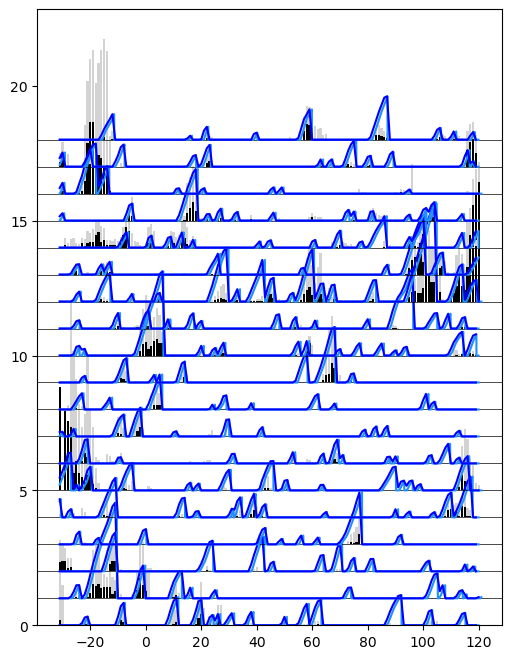

In [26]:
YEARS = years[:-1]

fig, ax = plt.subplots(figsize=(6,8))

all_extents = np.array([])
all_extents60 = np.array([])
all_lengths = np.array([])
all_daily_cum = np.array([])

annual_w_events = np.array([])
annual_l_events = np.array([])


annual_sum_w_events = np.array([])
annual_sum_l_events = np.array([])

for yy, year in enumerate(YEARS):
    
    plt.axhline(yy, c='k', lw=0.5)
    year_cond = (daily_data['pol']['year']==year) #& (daily_data['pol']['month']==2)
    
    ice_angles = daily_data['ppd']['angle'][year_cond]
    ice_speeds = daily_data['ppd']['s'][year_cond]
    ice_ese = daily_data['ppd']['ese'][year_cond]
    ese_ice_angles = (ice_angles>135)
    strong_ese_ice_events = (ese_ice_angles) & (ice_speeds > 10)
    
    extents60 = daily_data['pol']['extent60'][year_cond]
    extents = daily_data['pol']['extent'][year_cond]
    lengths = np.copy(daily_data['pol']['length'][year_cond])
    lengths[np.isnan(lengths)]=0
    
    wind_ese = daily_data['era']['ese'][year_cond]
    wind_angles = daily_data['era']['angle'][year_cond]
    wind_speeds = daily_data['era']['s'][year_cond]
    ese_angles = (wind_angles>145)+(wind_angles<-170)
    strong_ese_events = (ese_angles) & (wind_speeds > 5)
    
    
    annual_dates = daily_data['era']['time'][year_cond]
    ese_seqs = tseries.dates_to_sequences(annual_dates[ese_ice_angles], dt_max = 1*units('day'))
    cum_winds = np.zeros(len(annual_dates))
    
    dsh = xr.open_dataset(f'../data/forcing/regional_hourly_era_{year}_v6.nc')
    dsh.close()
    hr_angles = vectors.vector_angle(dsh.u10.values, dsh.v10.values).magnitude
    hr_speeds = np.sqrt(dsh.u10.values**2+dsh.v10.values**2)

    hr_ese_angles = (hr_angles>145)+(hr_angles<-170)
    hr_strong_events = (hr_ese_angles) & (hr_speeds > 5)
    hr_ese = vectors.comp_along_theta(dsh.u10.values, dsh.v10.values, (170)*units('degree'))

    frc_seqs = tseries.dates_to_sequences(pd.to_datetime(dsh.time.values[hr_strong_events]), dt_max = 6*units('hour'))


    hr_cum_winds = np.zeros(len(dsh.time.values))

    for ss in frc_seqs:
        
        if len(frc_seqs[ss]) >= 24:
            # find date sequences
            si = np.where(dsh.time.values == frc_seqs[ss][0])[0][0]
            fi = np.where(dsh.time.values == frc_seqs[ss][-1])[0][0]
            # add cum. opening
            hr_cum_winds[si:fi+1] = np.cumsum(0.03*hr_ese[si:fi+1]*units('m/s').to('km/hour'))


    hr_times = dsh.time.sel(time = slice(datetime(year-1, 12, 1), datetime(year, 4, 30,23)))
    si = np.where(dsh.time == hr_times[0])[0][0]
    fi = np.where(dsh.time == hr_times[-1])[0][0]
    hr_cum_winds = hr_cum_winds[si:fi+1]
    
    dT = ((annual_dates - datetime(year,1,1)) / np.timedelta64(1, 's'))/(60*60*24)
    dt = ((pd.to_datetime(hr_times) - datetime(year,1,1)) / np.timedelta64(1, 's'))/(60*60*24)

    # find daily max values
    hr_times_to_dates = np.array([hdate - timedelta(hours=hdate.hour) for hdate in pd.to_datetime(hr_times.values)])
    daily_cum = np.zeros(len(annual_dates))
    for dd, date in enumerate(annual_dates):
        daily_cum[dd] = hr_cum_winds[np.where(hr_times_to_dates == date)[0]].max()

    plt.bar(dT, extents60/6000, bottom=yy, color='lightgray')
    plt.bar(dT, extents/6000, bottom=yy, color='k')
    plt.plot(dt, yy+hr_cum_winds/100, c='dodgerblue')
    
    plt.plot(dT, yy+daily_cum/100, c='b')
    
    all_daily_cum = np.append(all_daily_cum, daily_cum)
    all_extents60 = np.append(all_extents60, extents60)
    all_extents = np.append(all_extents, extents)
    all_lengths = np.append(all_lengths, lengths)
    
    annual_w_events = np.append(annual_w_events, np.sum(daily_cum>10))
    annual_l_events = np.append(annual_l_events, np.sum(extents>0))
    
    
    annual_sum_w_events = np.append(annual_sum_w_events, np.sum(daily_cum))
    annual_sum_l_events = np.append(annual_sum_l_events, np.sum(extents))
    
    

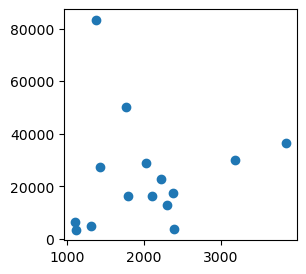

In [1209]:
fig, ax = plt.subplots(figsize=(3,3))

plt.scatter(annual_sum_w_events, annual_sum_l_events)

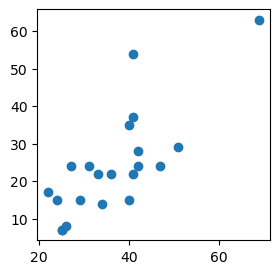

In [1206]:
fig, ax = plt.subplots(figsize=(3,3))

plt.scatter(annual_w_events, annual_l_events)

In [1195]:
hr_cum_winds

array([ 0.        ,  0.        ,  0.        , ..., 23.85997605,
       24.88637025, 25.9280944 ])

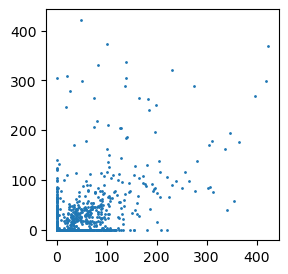

In [1205]:
fig, ax = plt.subplots(figsize=(3,3))

ax.scatter(all_daily_cum, all_lengths, s=1)

In [1176]:
dd

150

In [1172]:
hr_cum_winds[np.where(hr_times_to_dates == date)[0]].max()

57.95592077325724

In [ ]:
hdate

In [1167]:
hr_times_to_dates = np.array([hdate - timedelta(hours=hdate.hour) for hdate in pd.to_datetime(hr_times.values)])
hr_times_to_dates


array([Timestamp('2009-12-01 00:00:00'), Timestamp('2009-12-01 00:00:00'),
       Timestamp('2009-12-01 00:00:00'), ...,
       Timestamp('2010-04-30 00:00:00'), Timestamp('2010-04-30 00:00:00'),
       Timestamp('2010-04-30 00:00:00')], dtype=object)

In [1156]:
hr_times_by_dates = hr_times

<xarray.DataArray 'time' (time: 3624)>
array(['2022-12-01T00:00:00.000000000', '2022-12-01T01:00:00.000000000',
       '2022-12-01T02:00:00.000000000', ..., '2023-04-30T21:00:00.000000000',
       '2023-04-30T22:00:00.000000000', '2023-04-30T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-12-01 ... 2023-04-30T23:00:00

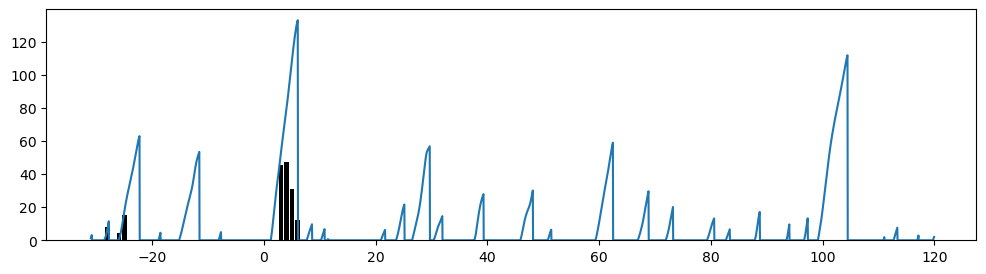

In [1149]:
fig, ax = plt.subplots(figsize=(12,3))
# plt.bar(annual_dates, extents60/50, color='lightgray')
plt.bar(dT, lengths, color='k')
plt.plot(dt, hr_cum_winds)

In [1224]:
run_ppd_ese = tseries.running_mean(daily_data['ppd']['ese'], length=3, center=False, address_nans=False)
run_ese = tseries.running_mean(daily_data['era']['ese'], length=3, center=False, address_nans=False)

run_ext = tseries.running_mean(daily_data['pol']['extent'], length=3, center=False, address_nans=False)


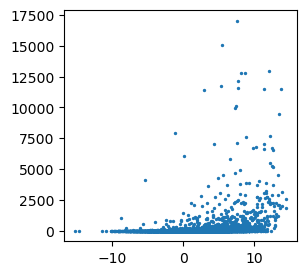

In [1225]:
fig, ax = plt.subplots(figsize=(3,3))

# ax.scatter(daily_data['ppd']['ese'][:-1], daily_data['pol']['extent60'][1:], s=2)
ax.scatter(run_ese, run_ext, s=2)

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_93285/2079382443.py:54: RuntimeWarning: invalid value encountered in divide
  size_ratios = (extents/extents60)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_93285/2079382443.py:54: RuntimeWarning: divide by zero encountered in divide
  size_ratios = (extents/extents60)


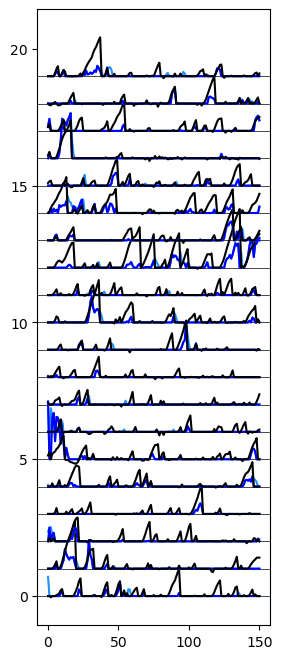

In [1008]:
fig, ax = plt.subplots(figsize=(3,8))

YEARS = years[:-2]

sr_percs = {}
for perc in [25,50,75]:
    sr_percs[perc] = np.array([])

    
all_cum = np.array([])
all_lengths = np.array([])
all_length_events = np.array([])
all_extents = np.array([])
all_years = np.array([])

for yy, year in enumerate(YEARS):
    
    plt.axhline(yy, c='k', lw=0.5)
    year_cond = (daily_data['pol']['year']==year) #& (daily_data['pol']['month']==2)
    
    ice_angles = daily_data['ppd']['angle'][year_cond]
    ice_speeds = daily_data['ppd']['s'][year_cond]
    ice_ese = daily_data['ppd']['ese'][year_cond]
    ese_ice_angles = (ice_angles>135)
    strong_ese_ice_events = (ese_ice_angles) & (ice_speeds > 10)
    
    extents60 = daily_data['pol']['extent60'][year_cond]
    extents = daily_data['pol']['extent'][year_cond]
    lengths = np.copy(daily_data['pol']['length'][year_cond])
    lengths[np.isnan(lengths)]=0
    
    wind_ese = daily_data['era']['ese'][year_cond]
    wind_angles = daily_data['era']['angle'][year_cond]
    wind_speeds = daily_data['era']['s'][year_cond]
    ese_angles = (wind_angles>145)+(wind_angles<-170)
    strong_ese_events = (ese_angles) & (wind_speeds > 5)
    
    
    annual_dates = daily_data['era']['time'][year_cond]
    ese_seqs = tseries.dates_to_sequences(annual_dates[ese_ice_angles], dt_max = 1*units('day'))
    cum_winds = np.zeros(len(annual_dates))
    
    length_events = np.zeros(len(annual_dates))
    for ss in ese_seqs:
        # find date sequences
        si = np.where(annual_dates == ese_seqs[ss][0])[0][0]
        fi = np.where(annual_dates == ese_seqs[ss][-1])[0][0]
        # add cum. opening
        cum_winds[si:fi+1] = np.cumsum(0.03*wind_ese[si:fi+1]*units('m/s').to('km/day'))
        length_events[si:fi+1] = lengths[si:fi+1]
#         cum_winds[si:fi+1] = np.cumsum(ice_ese[si:fi+1]*units('cm/s').to('km/day'))
    
    
    size_ratios = (extents/extents60)
    
    for perc in [25,50,75]:
        sr_percs[perc] = np.append(sr_percs[perc], np.nanpercentile(size_ratios[extents>0], perc))
    
    
    si = 7
    fi = -7
    all_lengths = np.append(all_lengths, lengths[si:fi])
    all_length_events = np.append(all_length_events, length_events[si:fi])
    all_cum = np.append(all_cum, cum_winds[si:fi])
    all_extents = np.append(all_extents, extents[si:fi])
    all_years = np.append(all_years, np.full(len(extents[si:fi]), year))
    
#     ax.scatter(year, np.nanmedian(extents60[extents>0]), c='b')
#     ax.scatter(year, np.nanmedian(extents[extents>0]), c='dodgerblue')
    
    ax.plot(lengths/200 + yy, c='dodgerblue')
    ax.plot(length_events/200 + yy, c='b')

#     ax.plot(extents/5000+ yy, c='b')
#     ax.plot(wind_ese/50 + yy, c='k')

    ax.plot(cum_winds/200 + yy, c='k')

#     ax.plot(extents60/10000 + yy, c='b')
#     ax.plot(extents/10000 + yy, c='dodgerblue')

#     ax.plot(extents/extents60 + yy, c='b')

# for perc in [25,50,75]:
#     plt.scatter(YEARS, sr_percs[perc])
    
    

In [1009]:
all_years

array([2003., 2003., 2003., ..., 2023., 2023., 2023.])

NameError: name 'all_cum' is not defined

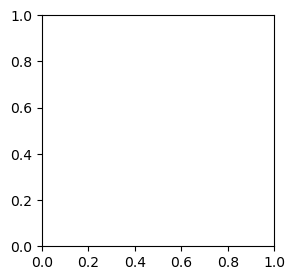

In [31]:
fig, ax = plt.subplots(figsize=(3,3))

# ax.scatter(all_cum, all_lengths, s=1)
ax.scatter(all_cum, 
           all_length_events, s=10, 
           c= all_years, vmin=2003, vmax=2024)

x = all_cum
y = all_length_events

x_nn = x[(x>0)&(y>0)]
y_nn = y[(x>0)&(y>0)]

res = stats.linregress(x_nn,y_nn)
print(res.rvalue)
print(res.rvalue**2)
print(res.slope)

x_line = np.array([x_nn.min(),x_nn.max()])
y_line = res.intercept + res.slope*x_line

# ax.set_xlim(0,150)
# ax.set_ylim(-1000,5000)

In [943]:
all_cum

array([11.60414086, 21.52629219, 42.2145522 , ...,  0.        ,
        0.        ,  0.        ])

In [ ]:
daily_data['pol']['lengths']

In [832]:
wind_ese[si:fi+1]

array([-0.43618636])

In [824]:
daily_data['era']['time'][year_cond]

DatetimeIndex(['2023-12-01', '2023-12-02', '2023-12-03', '2023-12-04',
               '2023-12-05', '2023-12-06', '2023-12-07', '2023-12-08',
               '2023-12-09', '2023-12-10',
               ...
               '2024-04-20', '2024-04-21', '2024-04-22', '2024-04-23',
               '2024-04-24', '2024-04-25', '2024-04-26', '2024-04-27',
               '2024-04-28', '2024-04-29'],
              dtype='datetime64[ns]', length=151, freq=None)

In [711]:
len(sr_percs[perc])

110

NameError: name 'x1' is not defined

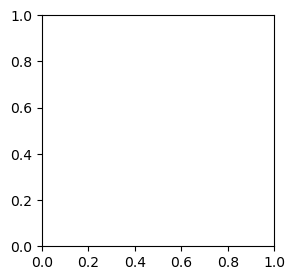

In [32]:
fig, ax = plt.subplots(figsize=(3,3))

# ax.set_ylim(-5,100)
# ax.scatter(daily_data['era']['month'], daily_data['ppd']['ese'], s=1)

x = np.array([])
y = np.array([])
z = np.array([])
r = np.array([])
s = np.array([])


YEARS = years[years<2024]

for yy, year in enumerate(YEARS):
    
    
    year_cond = (daily_data['pol']['year']==year) #& (daily_data['pol']['month']==2)

    
#     extents = daily_data['pol']['extent'][year_cond]

    extents = (daily_data['pol']['extent60'])[year_cond]
    
    wind_angles = daily_data['era']['angle'][year_cond]
    wind_speeds = daily_data['era']['s'][year_cond]
    wind_ese = daily_data['era']['ese'][year_cond]
    ese_angles = (wind_angles>145)+(wind_angles<-170)
    strong_ese_events = (ese_angles) & (wind_speeds > 5)

#     strong_ese_events = (wind_ese > 7.5)


    ice_angles = daily_data['ppd']['angle'][year_cond]
    ice_speeds = daily_data['ppd']['s'][year_cond]
    ice_ese = daily_data['ppd']['ese'][year_cond]
    ese_ice_angles = (ice_angles>135)
    strong_ese_ice_events = (ese_ice_angles) & (ice_speeds > 10)
    
    speed_ratios = (ice_speeds/wind_speeds)[strong_ese_events]
    
    sizes = extents[extents>0]
    
#     speed_ratios = (ice_speeds/wind_speeds)#[(ice_angles<45)&(ice_angles>-45)]
#     speed_ratios = (ice_speeds/wind_speeds)[(wind_angles<55)+(wind_angles>-35)]
    
#     plt.scatter(year, np.nanpercentile(sizes, 50))
#     plt.plot([year,year], [np.nanpercentile(sizes, 25), np.nanpercentile(sizes, 75)])
    
    
    if year != 2012:
        x = np.append(x, np.sum(strong_ese_events))
        y = np.append(y, np.sum(extents>100))
#         y = np.append(y, np.nansum(extents))
        z = np.append(z, np.sum((extents>100)&strong_ese_ice_events))
        r = np.append(r, np.nanpercentile(speed_ratios, 50))
        s = np.append(s, np.sum(sizes))
                        
            
x_nn = x#[YEARS!=2016]
y_nn = x1#[YEARS!=2016]

# plt.scatter(YEARS, x)

res = stats.linregress(x_nn,y_nn)
print(res.rvalue)
print(res.rvalue**2)
print(res.slope)

x_line = np.array([x_nn.min(),x_nn.max()])
y_line = res.intercept + res.slope*x_line

ax.scatter(x_nn,y_nn, marker='*', c='b')
plt.plot(x_line, y_line, c='k')

res
# ax.bar(years, x, color='gray')
# ax.scatter(years, y, color='k')
# ax.scatter(years, z, color='r')

# ax.scatter(YEARS, z/x, color='k')
# 
# ax.set_xlabel('Winter days with strong ESE ice\n(>15 cm/s)')
# ax.set_ylabel('Winter days with extent > 0')
# ax.set_title(f'R = {res.rvalue:.3f}\nslope={res.slope:.3f}')

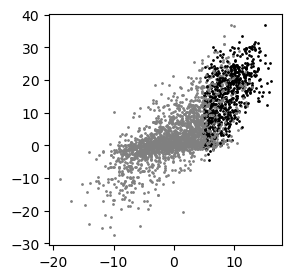

In [1386]:
fig, ax= plt.subplots(figsize=(3,3))


YEARS = years[years<2024]

for yy, year in enumerate(YEARS):
    
    
    year_cond = (daily_data['pol']['year']==year) #& (daily_data['pol']['month']==2)

    
#     extents = daily_data['pol']['extent'][year_cond]

    extents = (daily_data['pol']['extent60'])[year_cond]
    
    wind_angles = daily_data['era']['angle'][year_cond]
    wind_speeds = daily_data['era']['s'][year_cond]
    wind_ese = daily_data['era']['ese'][year_cond]
    ese_angles = (wind_angles>145)+(wind_angles<-170)
    strong_ese_events = (ese_angles) & (wind_speeds > 5)

#     strong_ese_events = (wind_ese > 7.5)


    ice_angles = daily_data['ppd']['angle'][year_cond]
    ice_speeds = daily_data['ppd']['s'][year_cond]
    ice_ese = daily_data['ppd']['ese'][year_cond]
    ese_ice_angles = (ice_angles>135)
    strong_ese_ice_events = (ese_ice_angles) & (ice_speeds > 10)
    
    ax.scatter(wind_ese[strong_ese_events], ice_ese[strong_ese_events], s= 1, c='k')
    
    ax.scatter(wind_ese[strong_ese_events==False], ice_ese[strong_ese_events==False], s= 1, c='gray')
    

In [1373]:
# x1 = x

19.4
17.45
16.45
17.95
21.35


[Text(0, 0, '12'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4')]

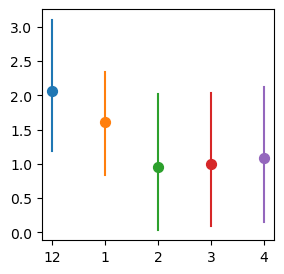

In [579]:
fig, ax = plt.subplots(figsize=(3,3))

# ax.scatter(daily_data['era']['month'], daily_data['ppd']['ese'], s=1)

for mm, month in enumerate(months):
    
    mean_ppd_ese = np.nanmean(daily_data['ppd']['ese'][daily_data['ppd']['month']==month])
    mean_era_ese = np.nanmean(daily_data['era']['ese'][daily_data['era']['month']==month])
    
    
    cond = (daily_data['era']['ese'] > 0) & (daily_data['ppd']['month']==month)
    print(np.sum(cond)/len(years))
    monthly_wf = (daily_data['ppd']['ese']/daily_data['era']['ese'])[cond]
    
#     ax.scatter(mm, mean_ppd_ese/mean_era_ese, s=1)
    
    ax.scatter(mm, np.nanmedian(monthly_wf), s=50)
    
    ax.plot([mm,mm], [np.nanpercentile(monthly_wf, 25),
                      np.nanpercentile(monthly_wf, 75)], )

ax.set_xticks(range(len(months)))
ax.set_xticklabels(months)

# ax.scatter(daily_data['ppd']['ese'], daily_data['era']['t2m'], s=1)
# ax.scatter(daily_data['ppd']['ese'], daily_data['pol']['extent'], s=5)

123
100
87
99
73
75
92
100
96
124


Text(0.5, 0, 'month')

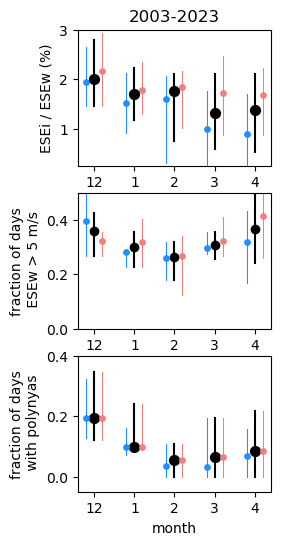

In [116]:
fig, axs = plt.subplots(3,1,figsize=(2.5,6))

# ax.scatter(daily_data['era']['month'], daily_data['ppd']['ese'], s=1)

month_colors =['k', 'b', 'dodgerblue', 'lightcoral', 'r']

for mm, month in enumerate(months):

#         if month == 4:
    monthly_cond = (daily_data['ppd']['month']==month) & (daily_data['ppd']['year']<2024)
    first_half = (daily_data['ppd']['year']<=2013)
    second_half = (daily_data['ppd']['year']>2013)
    
    wind_angles = daily_data['era']['angle']
    wind_speeds = daily_data['era']['s']
    wind_ese = daily_data['era']['ese']
#     ese_angles = (wind_angles>145)+(wind_angles<-170)

    ese_angles = (wind_angles>140)+(wind_angles<-175)
    strong_ese_events = (ese_angles) #& (wind_speeds > 5)
    
    
    cond = (monthly_cond) & (strong_ese_events)

    ax=axs[1]
    
#     monthly_days_per_year = np.sum(monthly_cond)/ len(years[:-2])

    ax.scatter(mm, np.sum(cond)/np.sum(monthly_cond), c='k')
    ax.scatter(mm-0.2, np.sum(cond&first_half)/np.sum(monthly_cond&first_half), s=15,c='dodgerblue')
    ax.scatter(mm+0.2, np.sum(cond&second_half)/np.sum(monthly_cond&second_half),s=15, c='lightcoral')
    
    monthly_events = []
    monthly_days = []
    for year in years[:-2]:
        monthly_days.append(np.sum(monthly_cond&(daily_data['ppd']['year']==year)))
        monthly_events.append(np.sum(cond&(daily_data['ppd']['year']==year)))
    fracs = np.array(monthly_events)/np.array(monthly_days)
    
    x = mm
    ax.plot([x, x], [np.nanpercentile(fracs, 25),
                      np.nanpercentile(fracs, 75)],  c='k', zorder=-1)
    
    monthly_events = []
    monthly_days = []
    for year in years[years<=2013]:
        monthly_days.append(np.sum(monthly_cond&(daily_data['ppd']['year']==year)))
        monthly_events.append(np.sum(cond&(daily_data['ppd']['year']==year)))
    fracs = np.array(monthly_events)/np.array(monthly_days)
    x = mm -0.2
    ax.plot([x, x], [np.nanpercentile(fracs, 25),
                      np.nanpercentile(fracs, 75)], lw=0.75, c='dodgerblue', zorder=-1)
    
    monthly_events = []
    monthly_days = []
    for year in years[(years>2013)&(years<2024)]:
        monthly_days.append(np.sum(monthly_cond&(daily_data['ppd']['year']==year)))
        monthly_events.append(np.sum(cond&(daily_data['ppd']['year']==year)))
    fracs = np.array(monthly_events)/np.array(monthly_days)
    x = mm +0.2
    ax.plot([x, x], [np.nanpercentile(fracs, 25),
                      np.nanpercentile(fracs, 75)], lw=0.75, c='lightcoral', zorder=-1)
    
    
    
    #c=month_colors[mm])
#     ax.scatter(np.linspace(mm-0.05,mm+0.05, len(fracs)), fracs, s=1, c='gray', zorder=-2)
    
#     ax.scatter(year, np.sum(cond)/len(cond))
#     mean_ppd_ese = np.nanmean(daily_data['ppd']['s'][cond])
#     mean_era_ese = np.nanmean(daily_data['era']['s'][cond])

#     annual_wf = (daily_data['ppd']['ese']/daily_data['era']['s'])[cond]

    annual_wf = (daily_data['ppd']['ese']/daily_data['era']['s'])[cond]
    
    ax=axs[0]
    x = mm
    
    ax.scatter(x, np.nanmedian(annual_wf), s=50,  c='k')#c=month_colors[mm])
    ax.plot([x, x], [np.nanpercentile(annual_wf, 25),
                      np.nanpercentile(annual_wf, 75)],  c='k')#c=month_colors[mm])
    
    print(np.sum(cond&first_half))
    x = mm - 0.2
    annual_wf = (daily_data['ppd']['ese']/daily_data['era']['s'])[cond&first_half]
    ax.scatter(x, np.nanmedian(annual_wf), s=15,  c='dodgerblue', zorder=-1)#c=month_colors[mm])
    ax.plot([x, x], [np.nanpercentile(annual_wf, 25),
                      np.nanpercentile(annual_wf, 75)], lw=0.75, c='dodgerblue', zorder=-1)#c=month_colors[mm])
    
    x = mm + 0.2
    print(np.sum(cond&second_half))
    annual_wf = (daily_data['ppd']['ese']/daily_data['era']['s'])[cond&second_half]
    ax.scatter(x, np.nanmedian(annual_wf), s=15,  c='lightcoral', zorder=-1)#c=month_colors[mm])
    ax.plot([x, x], [np.nanpercentile(annual_wf, 25),
                      np.nanpercentile(annual_wf, 75)], lw=0.75, c='lightcoral', zorder=-1)#c=month_colors[mm])
    
    
    ax = axs[2]
    
#     mpdays = np.sum(daily_data['pol']['extent'][monthly_cond]>0)
    cond2 = monthly_cond & (daily_data['pol']['extent'] > 0)
    
    monthly_events = []
    monthly_days = []
    for year in years[(years<2024)]:
        monthly_days.append(np.sum(monthly_cond&(daily_data['ppd']['year']==year)))
        monthly_events.append(np.sum(cond2&(daily_data['ppd']['year']==year)))
    fracs = np.array(monthly_events)/np.array(monthly_days)
    x = mm
    ax.scatter(x, np.nanmedian(fracs), s=50,  c='k')
    ax.plot([x, x], [np.nanpercentile(fracs, 25),
                      np.nanpercentile(fracs, 75)],  c='k', zorder=-1)
    
    for year in years[years<=2013]:
        monthly_days.append(np.sum(monthly_cond&(daily_data['ppd']['year']==year)))
        monthly_events.append(np.sum(cond2&(daily_data['ppd']['year']==year)))
    fracs = np.array(monthly_events)/np.array(monthly_days)
    
    x = mm - 0.2
    ax.scatter(x, np.nanmedian(fracs), s=15,  c='dodgerblue')
    ax.plot([x, x], [np.nanpercentile(fracs, 25),
                      np.nanpercentile(fracs, 75)], lw=0.75, c='dodgerblue', zorder=-1)
    
    for year in years[(years>2013)&(years<2024)]:
        monthly_days.append(np.sum(monthly_cond&(daily_data['ppd']['year']==year)))
        monthly_events.append(np.sum(cond2&(daily_data['ppd']['year']==year)))
    fracs = np.array(monthly_events)/np.array(monthly_days)
    
    x = mm + 0.2
    ax.scatter(x, np.nanmedian(fracs), s=15,  c='lightcoral')
    ax.plot([x, x], [np.nanpercentile(fracs, 25),
                      np.nanpercentile(fracs, 75)], lw=0.75, c='lightcoral', zorder=-1)
    
    

ax = axs[0]            
ax.set_title('2003-2023')

ax = axs[0]
ax.set_ylim(0.25,3)
# ax.axhline(0,c='k' , lw=0.5, ls='dashed')
ax.set_ylabel('ESEi / ESEw (%)')

ax.set_xticks(np.arange(len(months)))
ax.set_xticklabels(months)

ax = axs[1]
ax.set_ylim(0,0.5)
# ax.axhline(0,c='k', lw=0.5, ls='dashed')
# ax.set_yticks([0,30,60,90,120]);
ax.set_ylabel('fraction of days\n ESEw > 5 m/s')
ax.set_xticks(np.arange(len(months)))
ax.set_xticklabels(months)

ax = axs[2]
ax.set_ylim(-0.05,0.4)
ax.set_ylabel('fraction of days\n with polynyas')

ax.set_xticks(np.arange(len(months)))
ax.set_xticklabels(months)
ax.set_xlabel('month')
    
# fig.savefig('/Users/mackenziejewell/Desktop/img.png', dpi=300, bbox_inches='tight')

# ax.set_xticks(range(len(months)))
# ax.set_xticklabels(months)

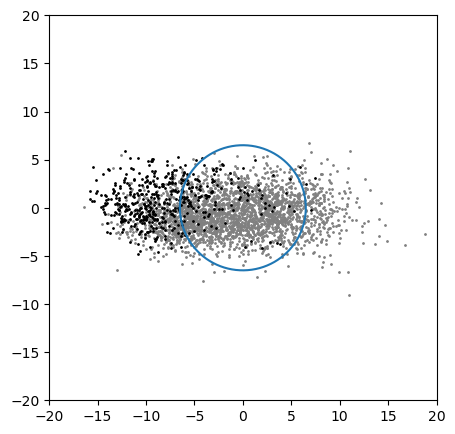

In [306]:

fig, ax = plt.subplots(figsize=(5,5))

size = 20

ax.set_xlim(-size,size)
ax.set_ylim(-size, size)
# u = 'ui'
# v = 'vi'


u = 'u10'
v = 'v10'


cat = 'comp'
ax.scatter(compare[cat][u], compare[cat][v], c='gray', s=1)

cat = 'open'
ax.scatter(compare[cat][u], compare[cat][v], c='k', s=1)

# cat = 'large'
# ax.scatter(compare[cat][u], compare[cat][v], c='b', s=5)

R = 6.5
theta = np.linspace(-np.pi, np.pi,100)
ax.plot(R*np.cos(theta), R*np.sin(theta))


era
-146.4595070781928 degree
era
175.0803714066714 degree
ppd
178.0547770589544 degree
ppd
161.5887176209195 degree


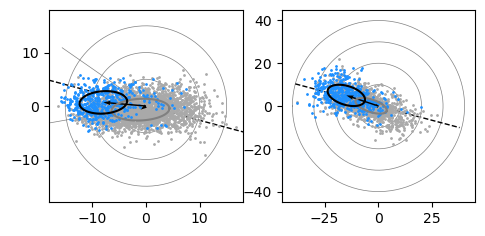

In [291]:
fig, axs = plt.subplots(1,2, figsize=(5.5,2.5))


# data condition
cond = daily_data['pol']['extent'] > 0


thetas = np.linspace(-np.pi,np.pi,100)

for group, ax in zip(['era', 'ppd'], [axs[0], axs[1]]):
    
    x_var = daily_data[group]['u']
    y_var = daily_data[group]['v']

    # condition 1
    x = x_var[cond==False]
    y = y_var[cond==False]

    xp = x[np.isfinite(x)&np.isfinite(y)]
    yp = y[np.isfinite(x)&np.isfinite(y)]

    varell = tanalyze.variance_ellipses(xp,yp)
    xm = vectors.comp_along_theta(xp, yp, varell['theta_m'] * units('rad'))
    ym = vectors.comp_along_theta(xp, yp, (varell['theta_m']+np.pi/2) * units('rad'))

    ax.scatter(xp, yp, c='darkgray', s=1)
    ax.plot(varell['xe']+np.nanmean(xp), varell['ye']+ np.nanmean(yp), c='gray')
    ax.quiver(0,0,np.nanmean(xp), np.nanmean(yp), angles='xy', scale_units='xy', color='k', scale=1)

    print(group)
#     print((varell['theta_m']*180/np.pi)+180)
    print(vectors.vector_angle(np.nanmean(xp), np.nanmean(yp)))
    
    # condition 2
    x = x_var[cond]
    y = y_var[cond]

    xp = x[np.isfinite(x)&np.isfinite(y)]
    yp = y[np.isfinite(x)&np.isfinite(y)]

    varell = tanalyze.variance_ellipses(xp,yp)
    xm = vectors.comp_along_theta(xp, yp, varell['theta_m'] * units('rad'))
    ym = vectors.comp_along_theta(xp, yp, (varell['theta_m']+np.pi/2) * units('rad'))

    ax.scatter(xp, yp, c='dodgerblue', s=1)
    ax.plot(varell['xe']+np.nanmean(xp), varell['ye']+ np.nanmean(yp), c='k')
    ax.quiver(0,0,np.nanmean(xp), np.nanmean(yp), angles='xy', scale_units='xy', scale=1)
    
    
    print(group)
#     print((varell['theta_m']*180/np.pi)+180)
    print(vectors.vector_angle(np.nanmean(xp), np.nanmean(yp)))

# plt.plot(thetas*180/np.pi, ds2dtheta(sxx, syy, sxy, thetas))
# plt.plot(thetas*180/np.pi, -4 * sxy * np.sin(2*(thetas)))

# plt.axvline(theta_m*180/np.pi)


ax = axs[0]
size = 18
ax.set_xlim(-size,size)
ax.set_ylim(-size,size)

for R in [5,10,15]:
    ax.plot(R*np.cos(theta), R*np.sin(theta), c='gray', lw=0.5, zorder=-1)
    
    
ax = axs[1]
size = 45
ax.set_xlim(-size,size)
ax.set_ylim(-size,size)

for R in [10,20,30,40]:
    ax.plot(R*np.cos(theta), R*np.sin(theta), c='gray', lw=0.5, zorder=-1)
    
    
for ax in axs:
    r_vals = np.arange(-40,40)
    thet = -15 * np.pi/180
    ax.plot(r_vals*np.cos(thet), r_vals*np.sin(thet), c='k', lw=1,ls='dashed', zorder=-1)
    
    
ax = axs[0]
r_vals = np.arange(0,20)
thet = 145 * np.pi/180
ax.plot(r_vals*np.cos(thet), r_vals*np.sin(thet), c='gray', lw=0.5, zorder=-1)
thet = -170 * np.pi/180
ax.plot(r_vals*np.cos(thet), r_vals*np.sin(thet), c='gray', lw=0.5, zorder=-1)

In [295]:
180-15

165

In [838]:
daily_data['era']['msl']

array([100781.375    , 102113.8046875, 102772.6640625, ...,
       101844.90625  , 102251.3671875, 102146.875    ])

29.183738198613053
-169.03937873858237
177.90402604587578
0.6008403361344538

-36.43807646328118
-153.5313640512855
172.5212964037862
0.3198587127158556


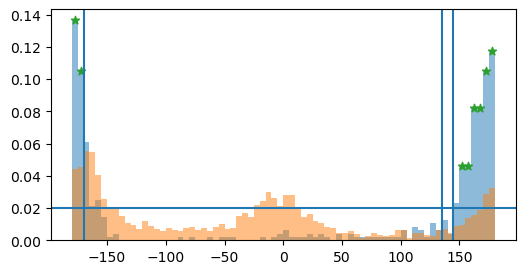

In [3661]:

fig, ax = plt.subplots(figsize=(6,3))

# var = 'msl'
# bins = np.arange(100000,106000,100)

var = 'angle'
bins = np.arange(-180,181,5)

# var = 's'
# bins = np.arange(0,40,1)

# bins = np.arange(0,17,0.5)

# var = 'ese'
# bins = np.arange(-40,40,1)


# group_data = daily_data['ppd'][var]

# bins = np.arange(-5,5,0.1)
# group_data = daily_data['ppd']['ese']/daily_data['era']['s']
# cond = (daily_data['era']['angle']>140) + (daily_data['era']['angle']<-175)
# cond  = cond & (daily_data['era']['s'] > 5)

group_data = daily_data['era'][var]

x = group_data[(daily_data['pol']['extent']>0)]#&(last_days_of_seqs==False)]#&(daily_data['pol']['year']!=2016)]
h = plotter.quick_hist(x, bin_edges = bins)
ax.bar(h['centers'], h['prob'], width = h['w'], alpha=0.5)
print(np.nanmean(x))
print(np.nanpercentile(x, 25))
print(np.nanpercentile(x, 95))

print(np.sum(x>6.5)/len(x))

x = group_data[(daily_data['pol']['extent']==0)]
h2 = plotter.quick_hist(x, bin_edges = bins)
ax.bar(h2['centers'], h2['prob'], width = h2['w'], alpha=0.5)
print()
print(np.nanmean(x))
print(np.nanpercentile(x, 25))
print(np.nanpercentile(x, 95))

print(np.sum(x>6.5)/len(x))

# ax.axvline(-170)
# ax.axvline(145)

# ax.axvline(-170)
# ax.axvline(135)


# ax.axvline(-175)
# ax.axvline(140)

# ax.axvline(145)
# ax.axvline(-165)

ax.axvline(135)

ax.axvline(145)
ax.axvline(-170)

ax.axhline(0.02)

probcond = (h['prob']/h2['prob']>1.5)&(h['prob']>0.025)

# probcond = (h2['prob']/h['prob']>1.5)#&(h2['prob']>0.025)
ax.scatter(h2['centers'][probcond], h['prob'][probcond], marker='*')

<>:142: SyntaxWarning: invalid escape sequence '\m'
<>:187: SyntaxWarning: invalid escape sequence '\m'
<>:188: SyntaxWarning: invalid escape sequence '\m'
<>:189: SyntaxWarning: invalid escape sequence '\m'
<>:190: SyntaxWarning: invalid escape sequence '\m'
<>:191: SyntaxWarning: invalid escape sequence '\m'
<>:142: SyntaxWarning: invalid escape sequence '\m'
<>:187: SyntaxWarning: invalid escape sequence '\m'
<>:188: SyntaxWarning: invalid escape sequence '\m'
<>:189: SyntaxWarning: invalid escape sequence '\m'
<>:190: SyntaxWarning: invalid escape sequence '\m'
<>:191: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_19887/3254731907.py:142: SyntaxWarning: invalid escape sequence '\m'
  height = 0.8 * dw, color=c1, label='$\mathrm{Q_{0}-Q_{1}}$')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_19887/3254731907.py:187: SyntaxWarning: invalid escape sequence '\m'
  ax.text(xi-DW/2, bot2, '$\mathrm{Q_{0}}$', ha='center',

NameError: name 'daily_data' is not defined

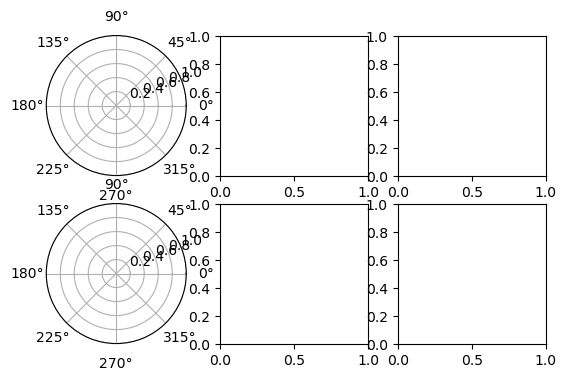

In [377]:

# create plot
fig, axs = plt.subplots(2, 3, figsize=(6.5, 4), subplot_kw={'projection': None})

# Override specific subplots to be polar using add_subplot
fig.delaxes(axs[0,0])
fig.delaxes(axs[1,0])
axs[0, 0] = fig.add_subplot(2, 3, 1, projection='polar')
axs[1, 0] = fig.add_subplot(2, 3, 4, projection='polar')




bins = np.arange(-180,181,5)
comp_ = (daily_data['pol']['extent']==0)
open_ = (daily_data['pol']['extent']>0)

for ax, group, color in zip(axs[:,0], ['era', 'ppd'], [c2,c2]):
    
    x = daily_data[group]['angle'][comp_]
    h = plotter.quick_hist(x, bin_edges = bins)

    x = daily_data[group]['angle'][open_]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    
    theta = h2['centers'] * np.pi/180
    width = h['w']* np.pi/180
    ax.bar(theta, 100*h2['prob'], width=width, bottom=0.0, alpha=1, color=color)
    
    # Plot bars
    theta = h['centers'] * np.pi/180
    ax.bar(theta, 2*100*h['prob'], width=width, bottom=0.0, alpha=0.35, color='k')
    
    
for ax in axs[:,0]:
    ax.set_yticks([5,10,15])
    ax.set_ylim(0,15)
    ax.set_theta_zero_location("E")  # Set 0 at the top
    ax.set_theta_direction(1)  # Clockwise direction
    ax.set_axisbelow(True) 

    # coastline orientation
    th = -15*np.pi/180
    ax.plot([th, th], [0,ax.get_ylim()[1]], c='k', ls='dashed', lw=1, zorder=100)
    ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='k', ls='dashed', lw=1, zorder=100)
    
ax = axs[0,0]
th1 = -170*np.pi/180
th2 = 145*np.pi/180
ax.plot(np.append(np.linspace(-np.pi,th1,10), np.linspace(th2, np.pi,10)[::-1]), 
        np.full(20,ax.get_ylim()[1]), c=color, ls='solid', lw=5)

ax = axs[1,0]
th1 = -180*np.pi/180
th2 = 135*np.pi/180
ax.plot(np.append(np.linspace(-np.pi,th1,10), np.linspace(th2, np.pi,10)[::-1]), 
        np.full(20,ax.get_ylim()[1]), c=color, ls='solid', lw=5)

    
    
    
    
    
    


for ax in axs[1,1:]:
#     ax.set_yticks(np.arange(0,20,5))
    ax.set_ylim(-1,35)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))

for ax in axs[0,1:]:
#     ax.set_yticks(np.arange(0,20,5))
    ax.set_ylim(-1,17)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

for ax in axs[:,1]:
    ax.set_xlim(0,5)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) # Major ticks every 2 units
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5)) # Major ticks every 0.5 units
    
for ax in axs[:,2]:
    ax.set_xlim(0,1.1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5)) # Major ticks every 2 units
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1)) # Major ticks every 0.5 units

# for ax in axs[:,1]:
    

    
# ax.set_xlim(-0.05,1.05)


ice_cond1 = (daily_data['ppd']['angle']>135)
atm_cond1 = (daily_data['era']['angle']>145) + (daily_data['era']['angle']<-170)

for row, dir_cond, group, all_ws  in zip([0,1],
                                         [atm_cond1, ice_cond1],
                                         ['era','ppd'],
                                         [np.arange(0.5,17,1), np.arange(1,40,2)]):

    dw = np.diff(all_ws)[0]

    for ws in all_ws:
        
        speed_cond = (daily_data[group]['s'] > ws-dw/2) & (daily_data[group]['s'] <= ws+dw/2)
        cond = dir_cond & speed_cond

        all_days = len(daily_data['pol']['extent'][cond])
        polynya_cond = (daily_data['pol']['extent'][cond] > 0)

        sma_pol = (daily_data['pol']['extent'][cond] > 0) & (daily_data['pol']['extent'][cond]<= 150)
        med_pol = (daily_data['pol']['extent'][cond] > 150) & (daily_data['pol']['extent'][cond]<= 500)
        lar_pol = (daily_data['pol']['extent'][cond] > 500) & (daily_data['pol']['extent'][cond]<= 1500)
        ext_pol = (daily_data['pol']['extent'][cond] > 1500) 

        if all_days/len(cond) > 0.001: 

            axs[row,1].barh(ws, 100*np.sum(cond)/len(cond),  height = 0.8 * dw,color='k')

            axs[row,2].barh(ws, np.sum(ext_pol)/all_days, 
                       left = (np.sum(sma_pol)+np.sum(med_pol)+np.sum(lar_pol))/all_days, 
                       height = 0.8 * dw, color=c4, label='Q4')        
            axs[row,2].barh(ws, np.sum(lar_pol)/all_days, 
                       left = (np.sum(sma_pol)+np.sum(med_pol))/all_days, 
                       height = 0.8 * dw, color=c3, label='Q3')        
            axs[row,2].barh(ws, np.sum(med_pol)/all_days, 
                       left = np.sum(sma_pol)/all_days, 
                       height = 0.8 * dw, color=c2, label='Q2')        
            axs[row,2].barh(ws, np.sum(sma_pol)/all_days, 
                       height = 0.8 * dw, color=c1, label='$\mathrm{Q_{0}-Q_{1}}$')


plt.subplots_adjust(hspace=0.15, wspace=0.15)
# plt.tight_layout()

# Plot data
# axs[0, 0].plot(theta, r)

axs[0, 1].set_xticks([])
axs[0, 2].set_xticks([])

axs[0, 1].set_yticks([])
axs[1, 1].set_yticks([])

for ax in axs[:,1:].ravel():
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
axs[0,2].set_ylabel('Speed (m/s)\nof alongshore\nwind', rotation=0, va='center', labelpad=40)
axs[1,2].set_ylabel('Speed (cm/s)\nof alongshore\nice drift', rotation=0, va='center', labelpad=40)

axs[1,1].set_xlabel('Frequency',)
axs[1,1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0f%%'))
axs[1,2].set_xlabel('Probability of\npolynya presence',)

for nn, ax in enumerate(axs.ravel()):
    ax.text(0.975, 0.975, f'{chr(97+nn)}', ha='right', va='top', weight='bold', transform=ax.transAxes)
    
    
    
    
ax = axs[0,2]
DW = 0.15
h = 0.75
xi = 0.3
bot = 20
ax.bar([xi], [h], bottom =bot, width=DW, color = c1, clip_on=False)
ax.bar([xi+DW], [h], bottom =bot, width=DW, color = c2, clip_on=False)
ax.bar([xi+2*DW], [h], bottom =bot, width=DW, color = c3, clip_on=False)
ax.bar([xi+3*DW], [h], bottom =bot, width=DW, color = c4, clip_on=False)  
ax.text(xi+1.5*DW, bot-1.75, 'Polynya size', ha='center', clip_on=False)
   
FS = plt.rcParams['font.size'] - 1.5
bot2 = bot + 1.25
ax.text(xi-DW/2, bot2, '$\mathrm{Q_{0}}$', ha='center', size=FS, clip_on=False)
ax.text(xi+DW/2, bot2, '$\mathrm{Q_{1}}$', ha='center', size=FS, clip_on=False)
ax.text(xi+3*DW/2, bot2, '$\mathrm{Q_{2}}$', ha='center', size=FS, clip_on=False)
ax.text(xi+5*DW/2, bot2, '$\mathrm{Q_{3}}$', ha='center', size=FS, clip_on=False)
ax.text(xi+7*DW/2, bot2, '$\mathrm{Q_{4}}$', ha='center', size=FS, clip_on=False)

# fig.savefig('../figures/results/polynya_occurrences_shorewinds_andice.png', dpi=300, bbox_inches='tight')

In [945]:
daily_data['pol']['year'][comp_].max()

2025

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_3117/1787421910.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['E','','N','','W ','','S'])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_3117/1787421910.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['E','','N','','W ','','S'])


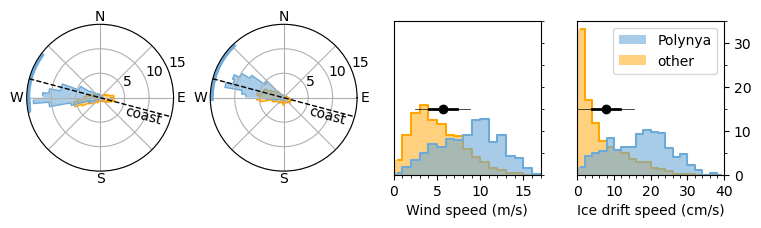

In [1130]:

# create plot
fig, axs = plt.subplots(1,4, figsize=(9,2), subplot_kw={'projection': None})

# Override specific subplots to be polar using add_subplot
fig.delaxes(axs[0])
fig.delaxes(axs[1])
axs[0] = fig.add_subplot(1,4, 1, projection='polar')
axs[1] = fig.add_subplot(1,4, 2, projection='polar')


ccolor = c2
bcolor = 'orange'

bins = np.arange(-180,181,5)
comp_ = (daily_data['pol']['extent']==0) & base_cond
open_ = (daily_data['pol']['extent']>0) & base_cond
open_strict = (open_)&(last_days_of_seqs == False)
base_cond = (daily_data['ppd']['year'] >= 2003)&(daily_data['ppd']['year'] < 2024)


for ax, group, color in zip(axs[0:2], ['era', 'ppd'], [ccolor,ccolor]):
    
    x = daily_data[group]['angle'][comp_]
    h = plotter.quick_hist(x, bin_edges = bins)

    x = daily_data[group]['angle'][open_]
    h2 = plotter.quick_hist(x, bin_edges = bins)

    
    theta = h2['centers'] * np.pi/180
    width = h['w']* np.pi/180
    ax.bar(theta, 100*h2['prob'], width=width, bottom=0.0, alpha=0.6, color=color, zorder=0)
    ax.step(theta, 100*h2['prob'], where='mid', alpha=1, color=color,lw=1, zorder=0)
    
    # Plot bars
    theta = h['centers'] * np.pi/180
    ax.bar(theta, 100*h['prob'], width=width, bottom=0.0, alpha=0.5, color=bcolor, zorder=-1)
    ax.step(theta, 100*h['prob'], where='mid', alpha=1, color=bcolor,lw=1, zorder=-1)
    
#     ax.plot(theta, 100*h2['prob'], alpha=1, color=color, marker='.', zorder=-1)
#     ax.plot(theta, 100*h['prob'], alpha=1, color=bcolor, marker='.', zorder=-1)
    
    
for ax in axs[0:2]:
    ax.set_yticks([5,10,15])
    ax.set_yticklabels([5,10,15])
#     ax.set_yticklabels(['',5,''], color=bcolor)
    ax.set_ylim(0,15)
    ax.set_theta_zero_location("E")  # Set 0 at the top
    ax.set_theta_direction(1)  # Clockwise direction
    ax.set_axisbelow(True) 
    
    ax.set_xticklabels(['E','','N','','W ','','S'])
    ax.tick_params(axis='x', pad=-5)

    # coastline orientation
    th = -15*np.pi/180
    ax.plot([th, th], [0,ax.get_ylim()[1]], c='k', ls='dashed', lw=1, zorder=100)
    ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='k', ls='dashed', lw=1, zorder=100)
    ax.text(-15*np.pi/180, 5, 'coast', rotation = -15, va='top')
    
ax = axs[0]
th1 = -170*np.pi/180
th2 = 145*np.pi/180
ax.plot(np.append(np.linspace(-np.pi,th1,10), np.linspace(th2, np.pi,10)[::-1]), 
        np.full(20,ax.get_ylim()[1]), c=color, ls='solid', lw=5)


ax = axs[1]
th1 = -180*np.pi/180
th2 = 135*np.pi/180
ax.plot(np.append(np.linspace(-np.pi,th1,10), np.linspace(th2, np.pi,10)[::-1]), 
        np.full(20,ax.get_ylim()[1]), c=color, ls='solid', lw=5)


for ax, group, color, bins in zip(axs[2:], ['era', 'ppd'], [ccolor,ccolor], 
                                  [np.arange(0,19,1), np.arange(0,41,2)]):
    
    x = daily_data[group]['s'][comp_]
    h = plotter.quick_hist(x, bin_edges = bins)

    x = daily_data[group]['s'][open_]
    h2 = plotter.quick_hist(x, bin_edges = bins)


    ax.bar(h2['centers'], 100*h2['prob'], width=h2['w'], bottom=0.0, alpha=0.6, color=color, zorder=0, label='Polynya')
    ax.step(h2['centers'], 100*h2['prob'], where='mid', alpha=1, color=color, zorder=0)
    
    # Plot bars
    ax.bar(h['centers'], 100*h['prob'], width=h['w'], bottom=0.0, alpha=0.5, color=bcolor, zorder=-1, label='other')
    ax.step(h['centers'], 100*h['prob'], where='mid', alpha=1, color=bcolor, zorder=-1)

    yy = 15
    
    dst = daily_data[group]['s'][base_cond]
    
    ax.scatter(np.nanmean(dst), yy, c='k')
    ax.plot([np.nanmean(dst)-0.5*np.nanstd(dst),
            np.nanmean(dst)+0.5*np.nanstd(dst)],
            [yy,yy], c='k', lw=2,)
    ax.plot([np.nanmean(dst)-1*np.nanstd(dst),
            np.nanmean(dst)+1*np.nanstd(dst)],
            [yy,yy], c='k', lw=0.5)
    
ax.legend()
    
#     ax.axvline(np.nanmean(dst), c='k', lw=1.5)
#     ax.axvline(np.nanmean(dst)-0.5*np.nanstd(dst), c='k', lw=0.5)
#     ax.axvline(np.nanmean(dst)+0.5*np.nanstd(dst), c='k', lw=0.5)
    
#     ax.axvline(np.nanpercentile(daily_data[group]['s'][comp_], 50), c='gray', lw=1.5)
#     ax.axvline(np.nanpercentile(daily_data[group]['s'][comp_], 25), c='gray', lw=0.5)
#     ax.axvline(np.nanpercentile(daily_data[group]['s'][comp_], 75), c='gray', lw=0.5)

    
ax = axs[2]
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_yticks([])
ax.set_xlabel('Wind speed (m/s)')  
ax.set_xlim(0,17)
ax.set_ylim(0,35)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax = axs[3]
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_xlabel('Ice drift speed (cm/s)')      
plt.subplots_adjust(wspace=0.25)
ax.set_xlim(0,40)
ax.set_ylim(0,35)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

fig.savefig('../figures/results/forcing_distributions.png', dpi=400, bbox_inches='tight', pad_inches=0)



In [1049]:
base_cond = (daily_data['ppd']['year'] >= 2003)&(daily_data['ppd']['year'] < 2024)

In [1120]:
icethresh = np.nanmean(daily_data['ppd']['s'][base_cond]) + 0.5*np.nanstd(daily_data['ppd']['s'][base_cond])
print(np.nanmean(daily_data['ppd']['s'][base_cond]))
print(np.nanstd(daily_data['ppd']['s'][base_cond]))
print(icethresh)
icethresh = 11.5
print(icethresh*units('cm/s').to('km/day'))
print(np.sum(daily_data['ppd']['s'][open_]>icethresh)/np.sum(open_))
print(np.sum(daily_data['ppd']['s'][comp_]>icethresh)/np.sum(comp_))

7.796009317025139
7.5495254524574875
11.570772043253882
9.936000000000002 kilometer / day
0.8073394495412844
0.19740973312401883


In [1119]:
print(np.sum((daily_data['era']['s'][open_strict]>windthresh)&(daily_data['ppd']['s'][open_strict]>icethresh))/np.sum(open_strict))
print(np.sum((daily_data['era']['s'][open_]>windthresh)&(daily_data['ppd']['s'][open_]>icethresh))/np.sum(open_))
print(np.sum((daily_data['era']['s'][comp_]>windthresh)&(daily_data['ppd']['s'][comp_]>icethresh))/np.sum(comp_))

0.7619047619047619
0.6834862385321101
0.11695447409733124


In [1043]:
windthresh = np.nanmean(daily_data['era']['s'][base_cond]) + 0.5*np.nanstd(daily_data['era']['s'][base_cond])
print(np.nanmean(daily_data['era']['s'][base_cond]))
print(np.nanstd(daily_data['era']['s'][base_cond]))
print(windthresh)
windthresh=7
print(np.sum(daily_data['era']['s'][open_]>windthresh)/np.sum(open_))
print(np.sum(daily_data['era']['s'][comp_]>windthresh)/np.sum(comp_))

5.667897032871228
3.2041633313622477
7.269978698552352
0.680672268907563
0.25117739403453687


In [964]:
11.5*units('cm/s').to('km/day')

<Quantity(9.936, 'kilometer / day')>

In [963]:
np.nanmean(daily_data['era']['s'][base_cond]) + 0.5*np.nanstd(daily_data['era']['s'][base_cond])

7.269978698552352

In [955]:
np.nanpercentile(daily_data['ppd']['s'][open_], 25)

10.145652704538747

In [953]:
np.nanpercentile(daily_data['era']['s'][open_], 50)

9.087134953080106

In [3750]:
wind_thresh = np.nanmean(daily_data['era']['s'])# + 0.5*np.nanstd(daily_data['era']['s'])
wind_thresh = np.nanpercentile(daily_data['era']['s'], 75)
np.sum(daily_data['era']['s'][open_] > wind_thresh)/len(daily_data['era']['s'][open_])

0.6197478991596639

In [3733]:
np.nanmean(daily_data['era']['s'])

5.684961341311358

In [3742]:
np.nanstd(daily_data['era']['s'])

3.2275428275398146

In [3734]:
wind_thresh

5.684961341311358

In [3735]:
ice_thresh = np.nanmean(daily_data['ppd']['s'])# + 0.5*np.nanstd(daily_data['ppd']['s'])
ice_thresh

np.sum(daily_data['ppd']['s'][open_] > ice_thresh)/len(daily_data['ppd']['s'][open_])

0.9129287598944591

In [3748]:
np.nanpercentile(daily_data['era']['s'], 75)

7.7104723802559825

In [3749]:
np.nanpercentile(daily_data['ppd']['s'], 75)

12.521775317737825

In [3739]:
cond1 = daily_data['era']['s'][open_] > wind_thresh
cond2 = daily_data['ppd']['s'][open_] > ice_thresh

np.sum(cond1&cond2)/len(cond2)

0.7310924369747899

In [3743]:
cond1 = daily_data['era']['s'][open_strict] > wind_thresh
cond2 = daily_data['ppd']['s'][open_strict] > ice_thresh

np.sum(cond1&cond2)/len(cond2)

0.8232189973614775

In [3711]:
ice_thresh

7.9252925915498835

In [3665]:
np.nanpercentile(daily_data['era']['s'][open_], 25)

7.395605652941162

In [3680]:
np.nanpercentile(daily_data['ppd']['s'][open_], 10)

8.218666386905072

In [3595]:
np.nanmedian(daily_data[group]['s'])

5.176514166235827

In [1697]:
chr(97)

'a'

In [1627]:
speed_cond

array([False, False, False, ..., False, False, False])

In [1621]:
100*np.sum(cond)/len(cond)

0.0

In [704]:


def calc_hist(x, y, abins, rbins):
    
    # convert
    zenith = np.sqrt(x**2 + y**2)
    azim = vectors.vector_angle(x, y).magnitude

    #calculate histogram
    hist, _, _ = np.histogram2d(azim, zenith, bins=(abins, rbins), density=False)
    A, R = np.meshgrid(abins, rbins)

    # find density
    dens = hist.T/len(x)
    
    return A, R, dens
    
def grab_var_ellip(x, y):

    xp = x[np.isfinite(x)&np.isfinite(y)]
    yp = y[np.isfinite(x)&np.isfinite(y)]

    varell = tanalyze.variance_ellipses(xp,yp)
    xm = vectors.comp_along_theta(xp, yp, varell['theta_m'] * units('rad'))
    ym = vectors.comp_along_theta(xp, yp, (varell['theta_m']+np.pi/2) * units('rad'))

    x2 = varell['xe']+ np.nanmean(xp)
    y2 = varell['ye']+ np.nanmean(yp)
    
    # convert
    zenith = np.sqrt(x2**2 + y2**2)
    azim = vectors.vector_angle(x2, y2).magnitude * np.pi/180
    
    # convert
    zenith_mean = np.sqrt(np.nanmean(xp)**2 + np.nanmean(yp)**2)
    azim_mean = vectors.vector_angle(np.nanmean(xp), np.nanmean(yp)).magnitude * np.pi/180
    
    return azim, zenith, azim_mean, zenith_mean

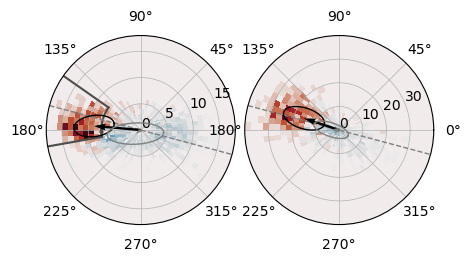

In [837]:
# plot
fig, axs = plt.subplots(1,2,subplot_kw=dict(projection="polar"), figsize=(5,2.5))


# coastline orientation
for ax in axs.ravel():
    ax.grid(True, lw=0.5)
    
plt.subplots_adjust(hspace=0.05, wspace=0.05)


# calc and plot
cond = (daily_data['pol']['extent']>0)


# for ax, bool_ in zip(axs, [True, False]):
    

#     # coastline orientation
#     th = -15*np.pi/180
#     ax.plot([th, th], [0,18], c='k', ls='dashed', lw=0.5)
#     ax.plot([th+np.pi, th+np.pi], [18,0], c='k', ls='dashed', lw=0.5)
    

ax = axs[0]
ax.set_ylim(0,18)

# define binning
rbins = np.arange(0,21,1)
abins = np.arange(-180, 181, 5)


group = 'era'
x_var = daily_data[group]['u'][(cond==True)&(last_days_of_seqs == False)]
y_var = daily_data[group]['v'][(cond==True)&(last_days_of_seqs == False)]
A, R, dens1 = calc_hist(x_var, y_var, abins, rbins)

color = 'k'
ax.plot(*grab_var_ellip(x_var, y_var)[:2], lw=1, c=color, zorder=100)
#     ax.scatter(*grab_var_ellip(x_var, y_var)[2:], c=color, s=10, zorder=100)
ax.quiver(grab_var_ellip(x_var, y_var)[2], 0, 0, 
          grab_var_ellip(x_var, y_var)[3], color=color, 
          angles='xy', scale_units='xy', scale=1, width=0.0125, zorder=100)


x_var = daily_data[group]['u'][cond==False]
y_var = daily_data[group]['v'][cond==False]
A, R, dens2 = calc_hist(x_var, y_var, abins, rbins)

color = 'gray'
ax.plot(*grab_var_ellip(x_var, y_var)[:2], lw=1, c=color, zorder=100)
#     ax.scatter(*grab_var_ellip(x_var, y_var)[2:], c=color, s=10, zorder=100)
ax.quiver(grab_var_ellip(x_var, y_var)[2], 0, 0, 
          grab_var_ellip(x_var, y_var)[3], color=color, 
          angles='xy', scale_units='xy', scale=1, width=0.0125, zorder=100)

pc = ax.pcolormesh(A*np.pi/180, R, dens1-dens2, cmap=cmocean.cm.balance, vmin=-0.025, vmax=0.025, zorder=-1)  
    
    
ax = axs[1]
ax.set_ylim(0,40)


# define binning
rbins = np.arange(0,42,2.5)
abins = np.arange(-180, 181, 5)

group = 'ppd'
x_var = daily_data[group]['u'][cond==True]
y_var = daily_data[group]['v'][cond==True]
A, R, dens1 = calc_hist(x_var, y_var, abins, rbins) 

color = 'k'
ax.plot(*grab_var_ellip(x_var, y_var)[:2], lw=1, c=color, zorder=100)
#     ax.scatter(*grab_var_ellip(x_var, y_var)[2:], c=color, s=10, zorder=100)
ax.quiver(grab_var_ellip(x_var, y_var)[2], 0, 0, 
          grab_var_ellip(x_var, y_var)[3], color=color, 
          angles='xy', scale_units='xy', scale=1, width=0.0125, zorder=100)


x_var = daily_data[group]['u'][cond==False]
y_var = daily_data[group]['v'][cond==False]
A, R, dens2 = calc_hist(x_var, y_var, abins, rbins)

color = 'gray'
ax.plot(*grab_var_ellip(x_var, y_var)[:2], lw=1, c=color, zorder=100)
#     ax.scatter(*grab_var_ellip(x_var, y_var)[2:], c=color, s=10, zorder=100)
ax.quiver(grab_var_ellip(x_var, y_var)[2], 0, 0, 
          grab_var_ellip(x_var, y_var)[3], color=color, 
          angles='xy', scale_units='xy', scale=1, width=0.0125, zorder=100)


pc = ax.pcolormesh(A*np.pi/180, R, dens1-dens2, cmap=cmocean.cm.balance, vmin=-0.025, vmax=0.025, zorder=-1)  
    
    
    
# fig.colorbar(pc)

ax = axs[0]

th1 = -170*np.pi/180
th2 = 145*np.pi/180
color = [0.3,0.3,0.3]
ax.plot([th1, th1], [7.5,20], c=color, ls='solid')
ax.plot([th2, th2], [7.5,20], c=color, ls='solid')
ax.plot(np.append(np.linspace(-np.pi,th1,10), np.linspace(th2, np.pi,10)[::-1]), 
        np.full(20,7.5), c=color, ls='solid')


ax = axs[0]
ax.set_yticks(np.arange(0,20,5));

ax = axs[1]
ax.set_yticks(np.arange(0,40,10));


for ax in axs:
    # coastline orientation
    th = -15*np.pi/180
    ax.plot([th, th], [0,ax.get_ylim()[1]], c='gray', ls='dashed', lw=1)
    ax.plot([th+np.pi, th+np.pi], [ax.get_ylim()[1],0], c='gray', ls='dashed', lw=1)





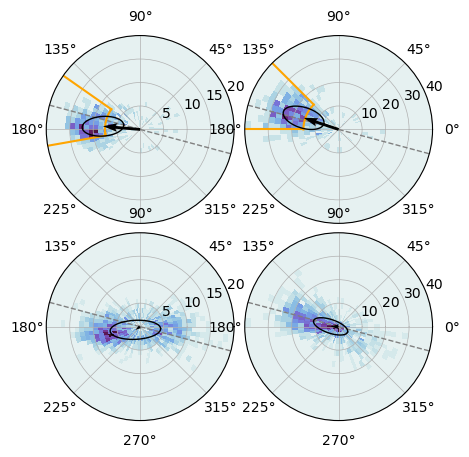

In [983]:
# plot
fig, axs = plt.subplots(2,2,subplot_kw=dict(projection="polar"), figsize=(5,5))


# coastline orientation
for ax in axs.ravel():
    ax.grid(True, lw=0.5)
    
plt.subplots_adjust(hspace=0.05, wspace=0.05)


# calc and plot
cond = (daily_data['pol']['extent']>0)


# for ax, bool_ in zip(axs, [True, False]):
    

#     # coastline orientation
#     th = -15*np.pi/180
#     ax.plot([th, th], [0,18], c='k', ls='dashed', lw=0.5)
#     ax.plot([th+np.pi, th+np.pi], [18,0], c='k', ls='dashed', lw=0.5)
    

for ax, bool_, scale in zip([axs[0][0], axs[1][0]], [True, False], [0.03,0.01]): 
    ax.set_ylim(0,20)

    # coastline orientation
    th = -15*np.pi/180
    cc = 'gray'
    ax.plot([th, th], [0,20], c=cc, ls='dashed', lw=1)
    ax.plot([th+np.pi, th+np.pi], [20,0], c=cc, ls='dashed', lw=1)

    # define binning
    rbins = np.arange(0,21,1)
    abins = np.arange(-180, 181, 5)


    group = 'era'
    x_var = daily_data[group]['u'][(cond==bool_)]#&(last_days_of_seqs == False)]
    y_var = daily_data[group]['v'][(cond==bool_)]#&(last_days_of_seqs == False)]
    A, R, dens1 = calc_hist(x_var, y_var, abins, rbins)

    color = 'k'
    ax.plot(*grab_var_ellip(x_var, y_var)[:2], lw=1, c=color, zorder=100)
#     ax.scatter(*grab_var_ellip(x_var, y_var)[2:], c=color, s=10, zorder=100)
    ax.quiver(grab_var_ellip(x_var, y_var)[2], 0, 0, 
              grab_var_ellip(x_var, y_var)[3], color='k', 
              angles='xy', scale_units='xy', scale=1, width=0.015, zorder=100)
    
    ax.pcolormesh(A*np.pi/180, R, dens1, cmap=cmocean.cm.dense, vmin=0, vmax=scale, zorder=-1)  
    
    
for ax, bool_, scale in zip([axs[0][1], axs[1][1]], [True, False], [0.03,0.01]): 
    ax.set_ylim(0,40)

    # coastline orientation
    th = -15*np.pi/180
    ax.plot([th, th], [0,40], c=cc, ls='dashed', lw=1)
    ax.plot([th+np.pi, th+np.pi], [40,0], c=cc, ls='dashed', lw=1)

    # define binning
    rbins = np.arange(0,41,2.5)
    abins = np.arange(-180, 181, 5)


    group = 'ppd'
    x_var = daily_data[group]['u'][(cond==bool_)]#&(last_days_of_seqs == False)]
    y_var = daily_data[group]['v'][(cond==bool_)]#&(last_days_of_seqs == False)]
    A, R, dens1 = calc_hist(x_var, y_var, abins, rbins)

    color = 'k'
    ax.plot(*grab_var_ellip(x_var, y_var)[:2], lw=1, c=color, zorder=100)
#     ax.scatter(*grab_var_ellip(x_var, y_var)[2:], c=color, s=10, zorder=100)
    ax.quiver(grab_var_ellip(x_var, y_var)[2], 0, 0, 
              grab_var_ellip(x_var, y_var)[3], color='k', 
              angles='xy', scale_units='xy', scale=1, width=0.015, zorder=100)

    

    ax.pcolormesh(A*np.pi/180, R, dens1, cmap=cmocean.cm.dense, vmin=0, vmax=scale, zorder=-1)  
    

# # fig.colorbar(pc)

ax = axs[0][0]

th1 = -170*np.pi/180
th2 = 145*np.pi/180
color = 'orange'
ax.plot([th1, th1], [7.5,20], c=color, ls='solid')
ax.plot([th2, th2], [7.5,20], c=color, ls='solid')
ax.plot(np.append(np.linspace(-np.pi,th1,10), np.linspace(th2, np.pi,10)[::-1]), 
        np.full(20,7.5), c=color, ls='solid')


ax = axs[0][1]

th1 = -180*np.pi/180
th2 = 135*np.pi/180
ax.plot([th1, th1], [15,40], c=color, ls='solid')
ax.plot([th2, th2], [15,40], c=color, ls='solid')
ax.plot(np.append(np.linspace(-np.pi,th1,10), np.linspace(th2, np.pi,10)[::-1]), 
        np.full(20,15), c=color, ls='solid')




# ax = axs[0]
# ax.set_yticks(np.arange(0,20,5));

# ax = axs[1]
# ax.set_yticks(np.arange(0,40,10));

# # for ax in axs:
# #     ax.set_xticks(np.arange(0,2*np.pi,np.pi/4))
# #     ax.set_xticklabels(['E','','N','','W','','S',''])


# # Plot the arrows using quiver



# # dt = 0
# # theta = vectors.vector_angle(np.nanmean(x_var),np.nanmean(y_var)).magnitude*np.pi/180
# # r = 0
# # dr = np.sqrt(np.nanmean(x_var)**2+np.nanmean(y_var)**2)
# # 




In [879]:
(180-15)-25

140

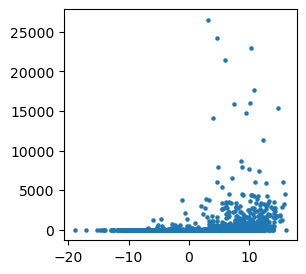

In [210]:
fig, ax = plt.subplots(figsize=(3,3))

plt.scatter(daily_data['era']['ese'], daily_data['pol']['extent'], s=5)

In [35]:
# omit last days of sequences

In [3038]:
len(final_days_of_seqs)

107

In [3039]:
175-30

145

In [3040]:
-180+((175+30)-180)

-155

<>:102: SyntaxWarning: invalid escape sequence '\m'
<>:118: SyntaxWarning: invalid escape sequence '\m'
<>:119: SyntaxWarning: invalid escape sequence '\m'
<>:120: SyntaxWarning: invalid escape sequence '\m'
<>:121: SyntaxWarning: invalid escape sequence '\m'
<>:122: SyntaxWarning: invalid escape sequence '\m'
<>:102: SyntaxWarning: invalid escape sequence '\m'
<>:118: SyntaxWarning: invalid escape sequence '\m'
<>:119: SyntaxWarning: invalid escape sequence '\m'
<>:120: SyntaxWarning: invalid escape sequence '\m'
<>:121: SyntaxWarning: invalid escape sequence '\m'
<>:122: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_3117/2253553755.py:102: SyntaxWarning: invalid escape sequence '\m'
  width = 0.8 * dw, color=c1, label='$\mathrm{Q_{0}-Q_{1}}$')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_3117/2253553755.py:118: SyntaxWarning: invalid escape sequence '\m'
  ax.text(xi-DW/2, bot2, '$\mathrm{Q_{0}}$', ha='center', si

Text(0.5, 0, 'Speed (m/s)\nof alongshore wind')

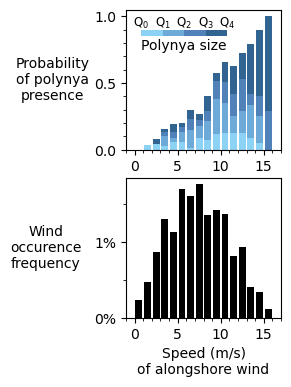

In [1082]:

fig, axs = plt.subplots(2,1,figsize=(2,4))


all_ws = np.arange(0.5,17,1)
for ax in axs:
    ax.set_xticks(np.arange(0,20,5))
    ax.set_xlim(-1,17)

ax = axs[0]
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5)) # Major ticks every 2 units
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1)) # Major ticks every 0.5 units
# ax.set_ylim(-0.05,1.05)

ax = axs[1]
ax.yaxis.set_major_locator(ticker.MultipleLocator(1)) # Major ticks every 2 units
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5)) # Major ticks every 0.5 units
# ax.set_ylim(0,2)

for ax in axs:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5)) # Major ticks every 2 units
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1)) # Major ticks every 0.5 units

    
    
    
# all_ws = np.arange(1,40,2)

# for ax in axs:
#     ax.set_xticks(np.arange(0,20,5))
#     ax.set_xlim(-1,35)

# ax = axs[0]
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5)) # Major ticks every 2 units
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1)) # Major ticks every 0.5 units

# for ax in axs:
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(10)) # Major ticks every 2 units
#     ax.xaxis.set_minor_locator(ticker.MultipleLocator(2)) # Major ticks every 0.5 units

    
    
# axs[0].set_ylim(-0.05,1.05)

    
dw = np.diff(all_ws)[0]


c1 = [140/255,210/255,245/255]
c2 = [110/255,170/255,215/255]
c3 = [80/255,130/255,185/255]
c4 = [50/255,100/255,145/255]



for ws in all_ws:


    # group_data = daily_data['ppd']['ese']/daily_data['era']['s']

#     cond1 = (daily_data['ppd']['angle']>135)
#     speed_cond = (daily_data['ppd']['s'] > ws-dw/2) & (daily_data['ppd']['s'] <= ws+dw/2)

    cond1 = (daily_data['era']['angle']>145) + (daily_data['era']['angle']<-170)
    speed_cond = (daily_data['era']['s'] > ws-dw/2) & (daily_data['era']['s'] <= ws+dw/2)

#     speed_cond = (daily_data['era']['s'] < ws)
    cond  = (((cond1 & speed_cond))&base_cond)#&(last_days_of_seqs==False)

#     cond = (daily_data['era']['ese'] > ws-0.25) & (daily_data['era']['ese'] > ws+0.25)

    all_days = len(daily_data['pol']['extent'][cond])
    
    polynya_cond = (daily_data['pol']['extent'][cond] > 0)
    
    
    sma_pol = (daily_data['pol']['extent'][cond] > 0) & (daily_data['pol']['extent'][cond]<= 155)
    med_pol = (daily_data['pol']['extent'][cond] > 155) & (daily_data['pol']['extent'][cond]<= 550)
    lar_pol = (daily_data['pol']['extent'][cond] > 550) & (daily_data['pol']['extent'][cond]<= 1700)
    ext_pol = (daily_data['pol']['extent'][cond] > 1700) 

#         polynya_cond = daily_data['ppd']['s'][cond] > 10

#     speed_cond = (daily_data['era']['s'] > ws+dw/2)
#     cond  = (((cond1 & speed_cond))&base_cond)

    if all_days/len(cond) > 0.001: 
    
        axs[1].bar(ws, 100*np.sum(cond)/len(cond),  width = 0.8 * dw,color='k')

#         axs[0].bar(ws,width = 0.8 * dw,  np.sum(polynya_cond)/all_days, color='k')
        
        axs[0].bar(ws, np.sum(ext_pol)/all_days, 
                   bottom = (np.sum(sma_pol)+np.sum(med_pol)+np.sum(lar_pol))/all_days, 
                   width = 0.8 * dw, color=c4, label='Q4')        
        axs[0].bar(ws, np.sum(lar_pol)/all_days, 
                   bottom = (np.sum(sma_pol)+np.sum(med_pol))/all_days, 
                   width = 0.8 * dw, color=c3, label='Q3')        
        axs[0].bar(ws, np.sum(med_pol)/all_days, 
                   bottom = np.sum(sma_pol)/all_days, 
                   width = 0.8 * dw, color=c2, label='Q2')        
        axs[0].bar(ws, np.sum(sma_pol)/all_days, 
                   width = 0.8 * dw, color=c1, label='$\mathrm{Q_{0}-Q_{1}}$')


ax = axs[0]
DW = 2.5
h = 0.05
xi = 2
bot = 0.85
ax.bar([xi], [h], bottom =bot, width=DW, color = c1)
ax.bar([xi+DW], [h], bottom =bot, width=DW, color = c2)
ax.bar([xi+2*DW], [h], bottom =bot, width=DW, color = c3)
ax.bar([xi+3*DW], [h], bottom =bot, width=DW, color = c4)  
ax.text(xi+1.5*DW, 0.75, 'Polynya size', ha='center', )
   
FS = plt.rcParams['font.size'] - 1.5
bot2 = bot + 0.075
ax.text(xi-DW/2, bot2, '$\mathrm{Q_{0}}$', ha='center', size=FS)
ax.text(xi+DW/2, bot2, '$\mathrm{Q_{1}}$', ha='center', size=FS)
ax.text(xi+3*DW/2, bot2, '$\mathrm{Q_{2}}$', ha='center', size=FS)
ax.text(xi+5*DW/2, bot2, '$\mathrm{Q_{3}}$', ha='center', size=FS)
ax.text(xi+7*DW/2, bot2, '$\mathrm{Q_{4}}$', ha='center', size=FS)



axs[0].set_ylabel('Probability\nof polynya\npresence', va='center', rotation = 0, labelpad=30)

axs[1].set_ylabel('Wind\noccurence\nfrequency', va='center', rotation = 0, labelpad=35)
axs[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0f%%'))

axs[1].set_xlabel('Speed (m/s)\nof alongshore wind')

# fig.savefig('../figures/results/polynya_occurrences_shorewinds.png', dpi=300, bbox_inches='tight')

(-40.0, 40.0)

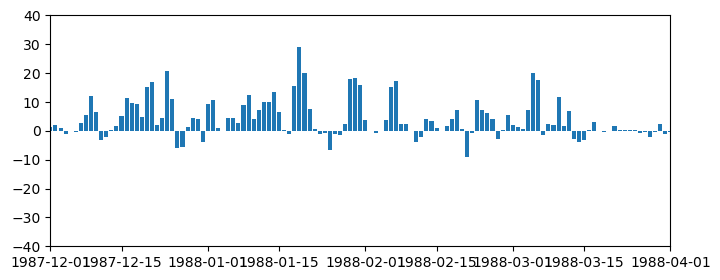

In [1125]:
YEAR = 1988

fig, ax= plt.subplots(figsize=(8,3))

thresh = daily_data['era']['year']==YEAR

# plt.bar(daily_data['ppd']['time'][thresh], daily_data['ppd']['ese'][thresh])


plt.bar(daily_data['ppd']['time'][thresh], daily_data['ppd']['ese'][thresh])
plt.xlim(datetime(YEAR-1,12,1), datetime(YEAR,4,1))
plt.ylim(-40,40)

In [1113]:
datetime(YEAR,1,1) + timedelta(days=67)

datetime.datetime(1998, 3, 9, 0, 0)

In [1109]:
128/30

4.266666666666667

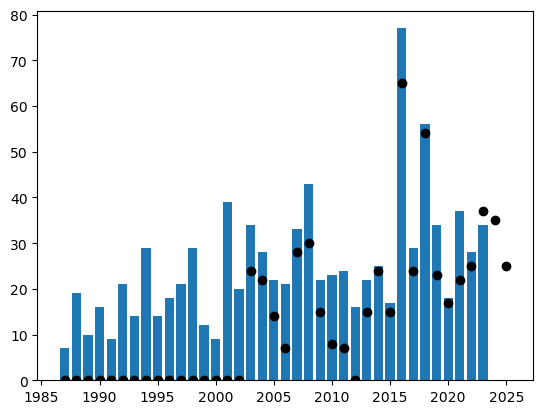

In [1129]:
plt.bar(yearss, all_ie)
plt.scatter(yearss, all_pe, c='k')

In [1063]:
all_days

5

In [1127]:
np.sum(polynya_cond)

5

In [988]:
np.nanmedian(daily_data['era']['s'][cond1])

7.381768401222063

In [2176]:
cond1 = (daily_data['era']['angle']>145) + (daily_data['era']['angle']<-170)
np.nanmean(daily_data['era']['s'][cond1])

7.520067852266462

In [2177]:
cond1 = (daily_data['ppd']['angle']>135)
np.nanmean(daily_data['ppd']['s'][cond1])

12.642742516756002

In [2129]:
cond1 = (daily_data['ppd']['angle']>135)
np.nanmedian(daily_data['ppd']['s'][cond1])

12.355375338021716

In [2118]:
np.nanmean(daily_data['era']['s'])

5.684961341311358

In [2174]:
np.nanmean(daily_data['era']['s']) + 0.5*np.nanstd(daily_data['era']['s'])

7.298732755081265

In [2175]:
np.nanmean(daily_data['ppd']['s']) + 0.5*np.nanstd(daily_data['ppd']['s'])

11.72039856455389

In [975]:
-180+22.5

-157.5

IndexError: boolean index did not match indexed array along dimension 0; dimension is 151 but corresponding boolean dimension is 3327

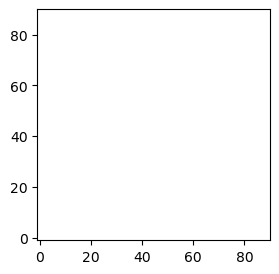

In [3042]:
fig, ax= plt.subplots(figsize=(3,3))

ax.set_xlim(-1,90)

ax.set_ylim(-1,90)


# cond1 = (daily_data['era']['angle']>145) + (daily_data['era']['angle']<-170)

cond1 = (daily_data['era']['angle']>145) + (daily_data['era']['angle']<-170)
# cond2 = daily_data['era']['s'] > 7.5
cond2 = daily_data['era']['s'] > 7.5

cond1i = (daily_data['ppd']['angle']>135)
cond2i = daily_data['ppd']['s'] > 12.5


all_num_p = np.array([])
all_num_w = np.array([])
all_num_i = np.array([])
all_mean_t = np.array([])
all_mean_ese_cond = np.array([])

    
for year in years:
    
    month_cond = (daily_data['pol']['month'] != 2) & (daily_data['pol']['month'] != 12)
    month_cond = (daily_data['pol']['month'] == 4) 
    
    year_cond = (daily_data['pol']['year'] == year) #& month_cond
    

    num_w = np.sum((year_cond&cond1)&cond2)
    num_i = np.sum((year_cond&cond1i)&cond2i)
    num_p = np.sum(year_cond&(daily_data['pol']['extent']>0))
    
    
#     as_drift = np.nanmean((daily_data['ppd']['s']/daily_data['era']['s'])[(year_cond&cond1)])

    as_drift = np.nanmean((daily_data['ppd']['s']/daily_data['era']['s'])[(year_cond&cond1)&cond2])
    all_mean_ese_cond = np.append(all_mean_ese_cond, as_drift)
    
    mean_t = np.nanmean(daily_data['era']['t2m'][year_cond])
    all_mean_t = np.append(all_mean_t, mean_t)
    
    
    
    all_num_p = np.append(all_num_p, num_p)
    all_num_w = np.append(all_num_w, num_w)
    all_num_i = np.append(all_num_i, num_i)
    
    
x = all_num_i
y = all_num_p


# x = x[years!=2016]
# y = y[years!=2016]
    


x_nn = x[np.isfinite(x)&np.isfinite(y)]
y_nn = y[np.isfinite(x)&np.isfinite(y)]

res = stats.linregress(x_nn,y_nn)
print(res.rvalue)
print(res.rvalue**2)
print(res.slope)
print(res.pvalue)

buff=2
x_line = np.array([x_nn.min()-buff,x_nn.max()+buff])
y_line = res.intercept + res.slope*x_line


ax.scatter(x, y)

plt.plot(x_line, y_line, c='k')
    
plt.plot(ax.get_xlim(),ax.get_ylim(), c='k', lw=0.5)

# ax.scatter(all_num_i, 5*(all_mean_t+25))

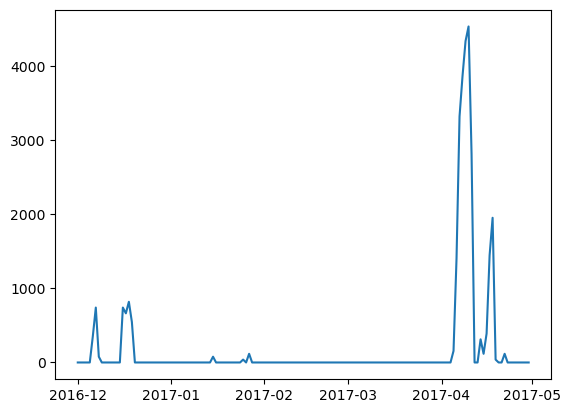

In [2247]:
plt.plot(daily_data['pol']['time'][daily_data['pol']['year']==2017], 
        daily_data['pol']['extent'][daily_data['pol']['year']==2017])

In [2210]:
# res.slope*x_line

0.5177251434848847
0.2680393241964445
0.024861477079090637
0.019381449047630433


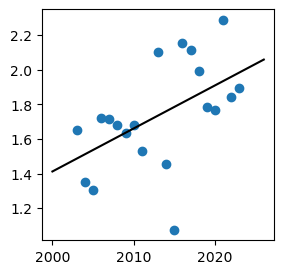

In [2257]:
fig, ax = plt.subplots(figsize=(3,3))
# plt.scatter(years, all_num_p/(all_num_i/all_num_w))

x = years
# y = all_num_p/(all_num_i)
# y = all_num_p/(all_num_w)
# y = all_num_i/(all_num_w)

# y = all_num_p/(all_num_i)#)

# y = (all_num_p/all_num_i)

# y = (all_num_p)

# y = (all_num_i)

# y = (all_num_p/all_num_i)
# y = all_mean_t

# y = all_num_w
y = (all_mean_ese_cond)

# y = (all_mean_ese_cond)
# y = all_mean_t


x_nn = x[np.isfinite(x)&np.isfinite(y)]
y_nn = y[np.isfinite(x)&np.isfinite(y)]

res = stats.linregress(x_nn,y_nn)
print(res.rvalue)
print(res.rvalue**2)
print(res.slope)
print(res.pvalue)

buff=3
x_line = np.array([x_nn.min()-buff,x_nn.max()+buff])
y_line = res.intercept + res.slope*x_line


ax.scatter(x, y)

plt.plot(x_line, y_line, c='k')


# plt.scatter(years, all_num_p/all_num_w)
# plt.scatter(years, all_num_i/all_num_w)
# plt.scatter(years, all_num_w)

# plt.ylim(0,2.5)

# ax.scatter(years, (all_mean_ese_cond))

# ax.scatter(years, (all_mean_t+25))

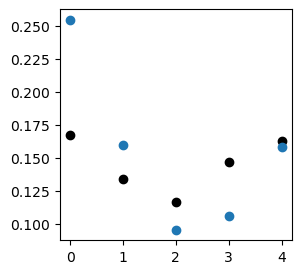

In [2261]:
fig, ax= plt.subplots(figsize=(3,3))



months = [12,1,2,3,4]

all_num_p = np.array([])

all_size_p = np.array([])
all_size25_p = np.array([])
all_size75_p = np.array([])
all_num_w = np.array([])
all_num_i = np.array([])
all_num_d = np.array([])
all_mean_t = np.array([])
    
for month in months:
    
    month_cond = (daily_data['pol']['month'] == month)
    
    total_days = np.sum(daily_data['pol']['month'] == month)
    all_num_d = np.append(all_num_d, total_days)
    
    num_w = np.sum((month_cond&cond1)&cond2)
    num_i = np.sum((month_cond&cond1i)&cond2i)
    num_p = np.sum(month_cond&(daily_data['pol']['extent']>0))
    
    size_p = np.median(daily_data['pol']['extent'][month_cond&(daily_data['pol']['extent']>0)])
    size25_p = np.percentile(daily_data['pol']['extent'][month_cond&(daily_data['pol']['extent']>0)],25)
    size75_p = np.percentile(daily_data['pol']['extent'][month_cond&(daily_data['pol']['extent']>0)],75)
    
    all_size_p = np.append(all_size_p, size_p)
    all_size25_p = np.append(all_size25_p, size25_p)
    all_size75_p = np.append(all_size75_p, size75_p)
    
    
    all_num_p = np.append(all_num_p, num_p)
    all_num_w = np.append(all_num_w, num_w)
    all_num_i = np.append(all_num_i, num_i)
    
    
    all_mean_t = np.append(all_mean_t, np.nanmean(daily_data['era']['t2m'][month_cond]))
    
    
ax.scatter(range(len(months)), all_num_w/all_num_d, c='k')
# ax.scatter(range(len(months)), all_num_p/all_num_w)
# ax.scatter(range(len(months)), all_num_p/all_num_i)
ax.scatter(range(len(months)), all_num_p/all_num_d)

# ax.scatter(range(len(months)), all_size_p, c='k')
# ax.scatter(range(len(months)), all_size25_p, c='b')
# ax.scatter(range(len(months)), all_size75_p, c='b')


# ax.scatter(range(len(months)), 0.25*(all_mean_t-np.nanmean(all_mean_t)))

# plt.ylim(0,0.4)


In [1095]:
(all_num_d/20)

array([31. , 31. , 28.2, 31. , 30. ])

In [1069]:
res.intercept + res.slope*(2023)

0.7043650331789308

In [1070]:
res.intercept + res.slope*2003

0.32393905665217204

In [1066]:
0.03*2*10

0.6

In [735]:
0.7706993209248832
0.5939774432740762
1.0261549523638323

1.0261549523638323

In [1130]:
total_open = np.sum((daily_data['pol']['extent'][last_days_of_seqs == False] > 0))
open_captured = np.sum((daily_data['pol']['extent'][cond1&(last_days_of_seqs == False)] > 0))
open_captured/total_open

0.8138297872340425

In [1131]:
total_open = np.sum((daily_data['pol']['extent'] > 0))
open_captured = np.sum((daily_data['pol']['extent'][cond1] > 0))
open_captured/total_open

0.7457627118644068

In [764]:
np.nanmean(daily_data['pol']['extent'][(daily_data['pol']['extent'] > 0)])

1444.3208645820462

In [ ]:
np.nanmean(daily_data['pol']['extent'][(daily_data['pol']['extent'] > 0)])

In [781]:
np.nanpercentile(daily_data['pol']['extent'][daily_data['pol']['extent']>0], 25)

155.8976974160937

In [776]:
np.nanpercentile(daily_data['pol']['extent'][daily_data['pol']['extent']>0], 50)

487.33371590112665

In [777]:
np.nanpercentile(daily_data['pol']['extent'][daily_data['pol']['extent']>0], 75)

1569.623400777964

In [ ]:
np.sum((daily_data['pol']['extent'] > 500))

In [784]:
for ss in all_seqs:
    
    if np.sum((all_sizes[ss]<150)) >= 1:
        
        if np.sum((all_sizes[ss]>155)) == 0:
        
            print(all_seqs[ss][0].date(), all_seqs[ss][-1].date())

2003-02-28 2003-02-28
2003-12-25 2003-12-25
2004-01-17 2004-01-17
2005-02-10 2005-02-10
2006-02-13 2006-02-13
2006-12-09 2006-12-09
2007-04-01 2007-04-01
2007-12-27 2007-12-27
2008-01-02 2008-01-03
2008-01-29 2008-01-29
2009-01-17 2009-01-17
2009-01-23 2009-01-24
2009-02-23 2009-02-24
2009-02-28 2009-02-28
2010-01-31 2010-01-31
2010-12-04 2010-12-04
2014-02-24 2014-02-24
2016-02-20 2016-02-20
2016-02-22 2016-02-22
2017-01-15 2017-01-15
2017-01-25 2017-01-25
2017-01-27 2017-01-27
2017-04-22 2017-04-22
2018-01-18 2018-01-18
2018-02-11 2018-02-11
2019-02-02 2019-02-02
2019-03-17 2019-03-17
2020-03-18 2020-03-18
2020-03-31 2020-03-31
2020-04-06 2020-04-06
2020-12-23 2020-12-23
2021-03-05 2021-03-05
2022-02-22 2022-02-22
2023-03-24 2023-03-24


In [156]:
np.sum(cond&(daily_data['pol']['extent']==0))

357

0.5590054446979715


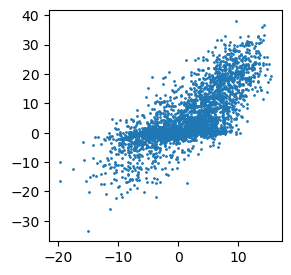

In [98]:
fig, ax = plt.subplots(figsize=(3,3))

x = daily_data['era']['ese']
y = daily_data['ppd']['ese']

x_nn = x[np.isfinite(x)&np.isfinite(y)]
y_nn = y[np.isfinite(x)&np.isfinite(y)]

res = stats.linregress(x_nn, y_nn)
print(res.rvalue**2)

ax.scatter(x, y, s=1)

0.5816039396743753


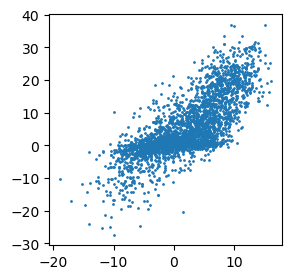

In [1387]:
fig, ax = plt.subplots(figsize=(3,3))

x = daily_data['era']['ese']
y = daily_data['ppd']['ese']

x_nn = x[np.isfinite(x)&np.isfinite(y)]
y_nn = y[np.isfinite(x)&np.isfinite(y)]

res = stats.linregress(x_nn, y_nn)
print(res.rvalue**2)

ax.scatter(x, y, s=1)

In [80]:

daily_data['era'].keys()

dict_keys(['ese', 'u', 'v', 's', 't2m', 'time', 'angle'])

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [2585]:
ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/regridded/M1_OHT_2016_2017_v0.nc')

uc = ds.u.resample(time="1D").mean().mean('z').values
vc = ds.v.resample(time="1D").mean().mean('z').values

ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/regridded/M1_OHT_2017_2018_v0.nc')

uc = np.append(uc, ds.u.resample(time="1D").mean().mean('z').values)
vc = np.append(vc, ds.v.resample(time="1D").mean().mean('z').values)

ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/regridded/M1_OHT_2018_2019_v0.nc')

uc = np.append(uc, ds.u.resample(time="1D").mean().mean('z').values)
vc = np.append(vc, ds.v.resample(time="1D").mean().mean('z').values)

<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:47: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:47: SyntaxWarning: invalid escape sequence '\c'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_93285/3763495151.py:27: SyntaxWarning: invalid escape sequence '\c'
  ax.axvline(TA,c='k', ls='dashed', label=f'{TA:.0f}'+'$^{\circ}$')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_93285/3763495151.py:37: SyntaxWarning: invalid escape sequence '\c'
  ax.axvline(TA,c='k', ls='dashed', label=f'{TA:.0f}'+'$^{\circ}$')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_93285/3763495151.py:47: SyntaxWarning: invalid escape sequence '\c'
  ax.axvline(TA,c='k', ls='dashed', label=f'{TA:.0f}'+'$^{\circ}$')


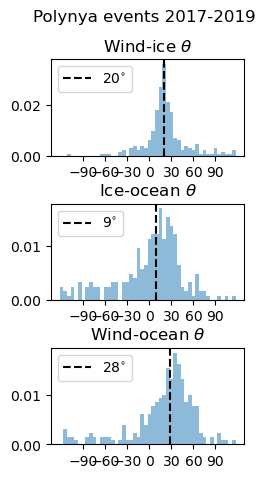

In [2591]:
# flags = [True if year in [2017, 2018] else False for year in daily_data['era']['year']]
flags = (daily_data['era']['time'] >= datetime(2016,12,1)) & (daily_data['era']['time'] <= datetime(2019,2,10))

# cond = (daily_data['pol']['extent'][flags] >= 0)# & flags

cond = (daily_data['era']['s'][flags] >= 3)# & flags

# v1 = (daily_data['era']['u'][flags], daily_data['era']['v'][flags])
# v1 = (daily_data['ppd']['u'][flags], daily_data['ppd']['v'][flags])


fig, axs = plt.subplots(3,1,figsize=(2.5,5))
plt.subplots_adjust(hspace=0.5)
fig.suptitle('Polynya events 2017-2019')

bins = np.arange(-122.5,121,5)
for ax in axs:
    ax.set_xticks(np.arange(-90,91,30))

ax = axs[0]
ax.set_title('Wind-ice $\\theta$')
v1 = (daily_data['era']['u'][flags][cond], daily_data['era']['v'][flags][cond])
v2 = (daily_data['ppd']['u'][flags][cond], daily_data['ppd']['v'][flags][cond])
ta = vectors.turning_angle(v1, v2)
ax.hist(ta, bins=bins, alpha=0.5, density=True)
TA = np.nanmedian(ta.magnitude)
ax.axvline(TA,c='k', ls='dashed', label=f'{TA:.0f}'+'$^{\circ}$')
ax.legend()

ax = axs[1]
ax.set_title('Ice-ocean $\\theta$')
v1 = (daily_data['ppd']['u'][flags][cond], daily_data['ppd']['v'][flags][cond])
v2 = (uc[cond], vc[cond])
ta = vectors.turning_angle(v1, v2)
ax.hist(ta, bins=bins, alpha=0.5, density=True)
TA = np.nanmedian(ta.magnitude)
ax.axvline(TA,c='k', ls='dashed', label=f'{TA:.0f}'+'$^{\circ}$')
ax.legend()

ax = axs[2]
ax.set_title('Wind-ocean $\\theta$')
v1 = (daily_data['era']['u'][flags][cond], daily_data['era']['v'][flags][cond])
v2 = (uc[cond], vc[cond])
ta = vectors.turning_angle(v1, v2)
ax.hist(ta, bins=bins, alpha=0.5, density=True)
TA = np.nanmedian(ta.magnitude)
ax.axvline(TA,c='k', ls='dashed', label=f'{TA:.0f}'+'$^{\circ}$')
ax.legend()

# fig.savefig('../figures/mooring_relations/turning_angles_windsgt3.png', dpi=300, bbox_inches='tight', pad_inches=0)

<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:45: SyntaxWarning: invalid escape sequence '\c'
<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:45: SyntaxWarning: invalid escape sequence '\c'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_93285/2312167071.py:29: SyntaxWarning: invalid escape sequence '\c'
  ax.axvline(TA,c='k', ls='dashed', label=f'{TA:.0f}'+'$^{\circ}$')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_93285/2312167071.py:37: SyntaxWarning: invalid escape sequence '\c'
  ax.axvline(TA,c='k', ls='dashed', label=f'{TA:.0f}'+'$^{\circ}$')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_93285/2312167071.py:45: SyntaxWarning: invalid escape sequence '\c'
  ax.axvline(TA,c='k', ls='dashed', label=f'{TA:.0f}'+'$^{\circ}$')


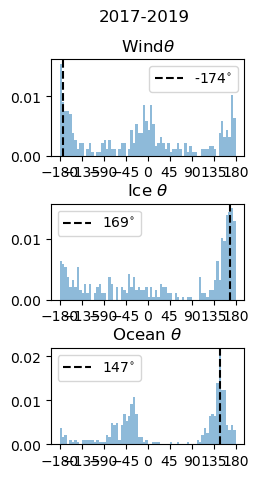

In [2608]:
# flags = [True if year in [2017, 2018] else False for year in daily_data['era']['year']]
flags = (daily_data['era']['time'] >= datetime(2016,12,1)) & (daily_data['era']['time'] <= datetime(2019,2,10))

cond = (daily_data['pol']['extent'][flags] >= 0)# & flags
# 
# cond = (daily_data['era']['s'][flags] >= 3)# & flags

# v1 = (daily_data['era']['u'][flags], daily_data['era']['v'][flags])
# v1 = (daily_data['ppd']['u'][flags], daily_data['ppd']['v'][flags])


fig, axs = plt.subplots(3,1,figsize=(2.5,5))
plt.subplots_adjust(hspace=0.5)
fig.suptitle('2017-2019')

bins = np.arange(-180,181,5)
for ax in axs:
    ax.set_xticks(np.arange(-180,181,45))

v1 = (daily_data['era']['u'][flags][cond], daily_data['era']['v'][flags][cond])
v2 = (daily_data['ppd']['u'][flags][cond], daily_data['ppd']['v'][flags][cond])
v3 = (uc[cond], vc[cond])

ax = axs[0]
ax.set_title('Wind$\\theta$')
ta = vectors.vector_angle(v1[0], v1[1])
ax.hist(ta, bins=bins, alpha=0.5, density=True)
TA = vectors.vector_angle(v1[0].mean(), v1[1].mean()).magnitude
ax.axvline(TA,c='k', ls='dashed', label=f'{TA:.0f}'+'$^{\circ}$')
ax.legend()

ax = axs[1]
ax.set_title('Ice $\\theta$')
ta = vectors.vector_angle(v2[0], v2[1])
TA = vectors.vector_angle(v2[0].mean(), v2[1].mean()).magnitude
ax.hist(ta, bins=bins, alpha=0.5, density=True)
ax.axvline(TA,c='k', ls='dashed', label=f'{TA:.0f}'+'$^{\circ}$')
ax.legend()

ax = axs[2]
ax.set_title('Ocean $\\theta$')
ta = vectors.vector_angle(v3[0], v3[1])
TA = vectors.vector_angle(v3[0].mean(), v3[1].mean()).magnitude
ax.hist(ta, bins=bins, alpha=0.5, density=True)
ax.axvline(TA,c='k', ls='dashed', label=f'{TA:.0f}'+'$^{\circ}$')
ax.legend()

fig.savefig('../figures/mooring_relations/each_angles_all.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [ ]:
help

In [ ]:
145

In [2576]:
33-19

14

In [2560]:
180-15

165

In [2559]:
145+35

180

In [2524]:
135+40

175

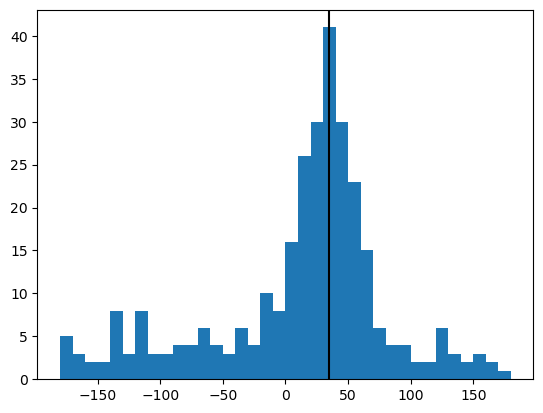

In [2513]:
plt.hist(ta, bins=np.arange(-180,181,10))
# plt.axvline(20,c='k')
plt.axvline(35,c='k')

183.83551322584245
175.0803714066714 degree


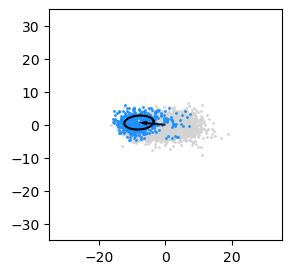

In [509]:
45/2

22.5

In [1389]:
np.nanmedian(open_sizes)

468.0864869907252

1391.118417451862


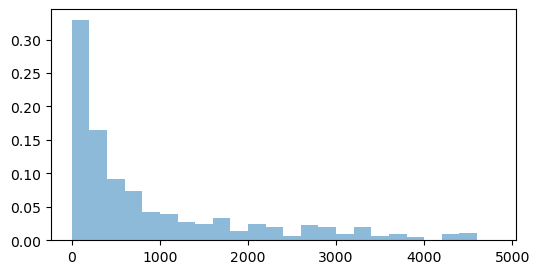

In [30]:

fig, ax = plt.subplots(figsize=(6,3))

bins = np.arange(0,5000,200)

x = open_sizes
h = plotter.quick_hist(x, bin_edges = bins)
ax.bar(h['centers'], h['prob'], width = h['w'], alpha=0.5)
print(np.nanmean(x))

In [594]:
sic_data = {}
for key in compare.keys():
    print(key)
    open_thresh=10
    sic_data[key] = unisic.calc_meansic_openfreq(pd.to_datetime(compare[key]['time']), crop=[500, 1300, 100, 500], 
                                        open_thresh=open_thresh, res='6250', hem='n', 
                                        main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                        coordinates=False, area=False, quiet=True)

open
large
comp
inc
dec


2.0 meter


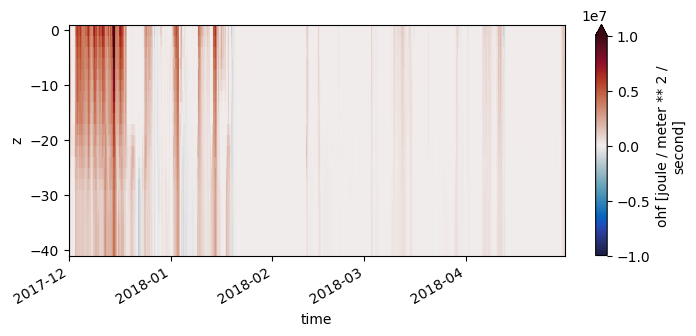

In [2633]:
open_years = '2017_2018'


Y1 = int(open_years.split('_')[0])
Y2 = int(open_years.split('_')[1])

dsc = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/regridded/M1_OHT_{open_years}_v0.nc')
# dsc = dsc.sel(time=slice(datetime(2018,12,1), datetime(2019,2,10)))
# dsc = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/regridded/M1_OHT_2016_2017_v0.nc')

dsc['p'] = vectors.comp_along_theta(dsc['u'], dsc['v'], 145*units('degree'))

dsc['ohf'] = cst['Cp_o']*(dsc.sig0*units('kg/m3')) * (dsc.dT*units('delta_degC')) * (dsc.p*units('m/s'))
dsc['ohf']

dz = np.diff(dsc.z.values)[0] * units('m')
summed_OHT = np.sum((dsc['ohf'][:-1,:].values + dsc['ohf'][1:,:].values), axis=0) * units('joule/(meter2 second)')
print(dz)
int_OHT = 0.5 * summed_OHT * dz


fig, ax = plt.subplots(figsize=(8,3))
dsc['ohf'].plot(vmin=-10000000,vmax=10000000, cmap=cmocean.cm.balance)

In [1412]:
DS

<xarray.Dataset>
Dimensions:               (time: 151)
Coordinates:
  * time                  (time) datetime64[ns] 2024-12-01 ... 2025-04-30
Data variables: (12/25)
    N                     (time) float64 ...
    extent                (time) float64 ...
    l_min                 (time) float64 ...
    l_max                 (time) float64 ...
    l_mean                (time) float64 ...
    l_per5                (time) float64 ...
    ...                    ...
    ice_extent            (time) float64 1.121e+05 1.119e+05 ... nan nan
    ocean_extent          (time) float64 ...
    other_polynya_extent  (time) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    polynya_extent        (time) float64 0.0 0.0 38.97 1.599e+03 ... nan nan nan
    miss_flag             (time) bool ...
    length                (time) float64 nan nan 0.0 49.68 ... nan nan nan nan

In [1401]:
dsa = xr.open_dataset(f'../data/forcing/regional_hourly_era_{Y2}_v6.nc')
wind_u = dsa['u10'].values
zonal_stress = np.sign(wind_u)*wind_u**2
dsa['p'] = vectors.comp_along_theta(dsa['u10'], dsa['v10'], 170*units('degree'))
wind = dsa['p'].values
windspeed = np.sqrt(dsa['u10'].values**2+dsa['v10'].values**2)
wind_stress = np.sign(wind)*wind**2

In [1415]:
# open data and crop to time range
DS = xr.open_dataset(f'../data/polynya_size/daily_polynya_{Y2}_sic10_v6.nc')
DS['length'] = DS.l_per95 - DS.l_per5
DS['width'] = DS.w_per95 - DS.w_per5
time_range = slice(datetime(Y2-1,12,1), datetime(Y2,4,30,23))
DS = DS.sel(time = time_range)

<IPython.core.display.Javascript object>


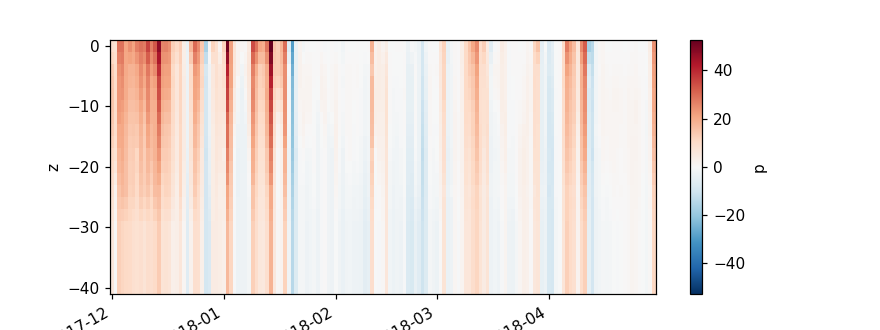

In [1479]:
fig, ax = plt.subplots(figsize=(8,3))
daily_sum_p = dsc.p.resample(time="1D").sum()
daily_mean_p = dsc.p.resample(time="1D").mean()
daily_sum_p.plot()

In [1506]:
# from m/s to m/hour
# but its summed, so m/day at each depth bin
daily_sum_p = daily_sum_p * units('m/s').to('m/hour').magnitude

In [1633]:
dz = dsc.z.diff('z').values[0] * units('m')
DZ = (dsc.z.values.max() - dsc.z.values.min())* units('m')
w = 10 * units('km').to('m')


htz = cst['Cp_o']*(dsc.dT*units('delta_degC')*dsc.sig0*units('kg/m3')*dsc.p*units('m/s'))
hcz = cst['Cp_o']*(dsc.dT*units('delta_degC')*dsc.sig0*units('kg/m3'))
IHC = np.sum(0.5*(hcz[1:,:].values + hcz[:-1,:].values), axis=0) * units('joule/meter3') * dz
IHT = np.sum(0.5*(htz[1:,:].values + htz[:-1,:].values), axis=0) * units('joule/(meter2 second)') * dz


# flow per sec
ifr = (0.5 * np.sum(dsc.p[1:,:].values + dsc.p[:-1,:].values, axis=0) * units('m/s')) * dz * w
ifr


ivt = (0.5 * np.sum(daily_sum_p[1:,:].values + daily_sum_p[:-1, :].values, axis=0) * units('m/day') * dz)

daily_ivt = np.array([])
for ii in range(0, len(ifr), 24):
    daily_ivt = np.append(daily_ivt, np.sum(ifr[ii:ii+24].to('m3/hour')) * units('hour'))
    
    
daily_iht = np.array([])
for ii in range(0, len(ifr), 24):
    daily_iht = np.append(daily_iht, np.sum(IHT[ii:ii+24].to('J/m/hour')) * units('hour'))

-0.07040982887860853
1.657361334710608


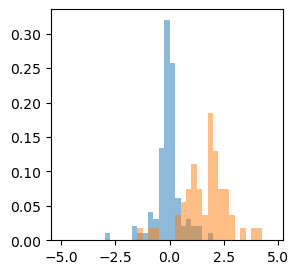

In [1594]:
fig, ax = plt.subplots(figsize=(3,3))
bins = np.arange(-5,5,0.25)

x = daily_ivt[DS.polynya_extent==0].magnitude/10e9
h = plotter.quick_hist(x, bin_edges = bins)
ax.bar(h['centers'], h['prob'], width = h['w'], alpha=0.5)
print(np.nanmean(x))


x = daily_ivt[DS.polynya_extent>0].magnitude/10e9
h = plotter.quick_hist(x, bin_edges = bins)
ax.bar(h['centers'], h['prob'], width = h['w'], alpha=0.5)
print(np.nanmean(x))

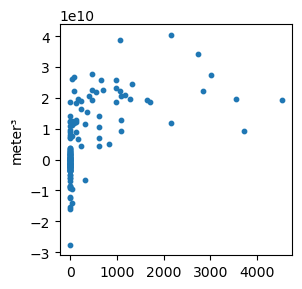

In [1592]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3,3))

ax.scatter(DS.polynya_extent, daily_ivt, s=10)




In [1596]:
np.sum(daily_ivt[DS.extent>0]) / np.sum(daily_ivt)

<Quantity(1.08261689, 'dimensionless')>

In [1595]:
np.sum(daily_ivt[DS.extent>0]) / np.sum(daily_ivt[daily_ivt>0])

<Quantity(0.826127721, 'dimensionless')>

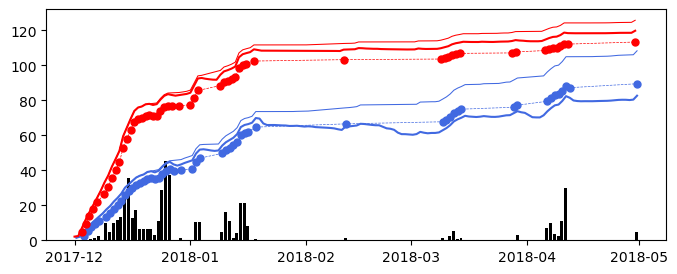

In [1667]:
fig, ax = plt.subplots(figsize=(8,3))
plt.bar(DS.time, DS.polynya_extent/100, align='edge', color='k')
# plt.plot(dsc.time, ifr/ 1000000)
# plt.plot(pd.to_datetime(DS.time) + timedelta(hours=12), daily_ivt.magnitude/(10e9))

plt.plot(pd.to_datetime(DS.time) + timedelta(hours=12), np.cumsum(daily_ivt.magnitude/(10e9)), c='royalblue')
plt.plot(pd.to_datetime(DS.time[daily_ivt>0]) + timedelta(hours=12),
         np.cumsum(daily_ivt[daily_ivt>0].magnitude/(10e9)), c='royalblue', ls='solid', lw=0.75)

plt.plot(pd.to_datetime(DS.time[DS.polynya_extent>0]) + timedelta(hours=12), 
            np.cumsum(daily_ivt[DS.polynya_extent>0].magnitude/(10e9)), 
         ls='dashed', lw=0.5,  marker='o', ms=5, c='royalblue',)

# plt.ylbale()

# ax.plot(dsc.time, np.cumsum(IHT.magnitude)/10e8, c='r')
ax.plot(DS.time, 0.5* np.cumsum(daily_iht.magnitude)/10e11, c='r')

ax.plot(DS.time[daily_iht>0], 0.5* np.cumsum(daily_iht[daily_iht>0].magnitude)/10e11, 
        c='r', lw=0.75, ls='solid')

ax.plot(DS.time[DS.polynya_extent>0], 0.5* np.cumsum(daily_iht.magnitude[DS.polynya_extent>0])/10e11, 
        c='r', lw=0.5, ls='dashed', marker='o', ms=5)


fig.savefig('/Users/mackenziejewell/Desktop/img.png', dpi=300, bbox_inches='tight')

In [1662]:
np.cumsum(daily_iht.magnitude[DS.polynya_extent>0])[-1]/np.cumsum(daily_iht.magnitude)[-1]

0.9460834049874228

In [1402]:



# dsa = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{Y1}.nc')
# dsa.close()
# dsa = dsa.sel(time=slice(dsc.time[0],dsa.time[-1]), latitude = 70, longitude=-139)
# dsa['p'] = vectors.comp_along_theta(dsa['u10'], dsa['v10'], 170*units('degree'))


# dsb = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{Y2}.nc')
# dsb.close()
# dsb = dsb.sel(time=slice(dsb.time[0], dsc.time[-1]), latitude = 70, longitude=-139)
# dsb['p'] = vectors.comp_along_theta(dsb['u10'], dsb['v10'], 170*units('degree'))


In [1403]:
W = 20*units('km').to('m') # width of the shelf current
L = 100*units('km').to('m') # length of the shelf current
hourly_OHT = int_OHT * W
hourly_ice_suppression = (hourly_OHT/(cst['L_i']*cst['rho_i']*W*L)).to('cm/hour')


In [1404]:
daily_OHT = tseries.running_mean(hourly_OHT, length=24, center=False, address_nans=False)
daily_wind = tseries.running_mean(wind, length=24, center=False, address_nans=False)
daily_stress = tseries.running_mean(wind_stress, length=24, center=False, address_nans=False)

current = dsc.p.mean('z').values
temp = dsc.dT.mean('z').values
sig = (dsc['sig0']).mean('z').values
temp_sig = (dsc.dT*dsc['sig0']).mean('z').values#.sel(z=slice(-20,0))

<IPython.core.display.Javascript object>


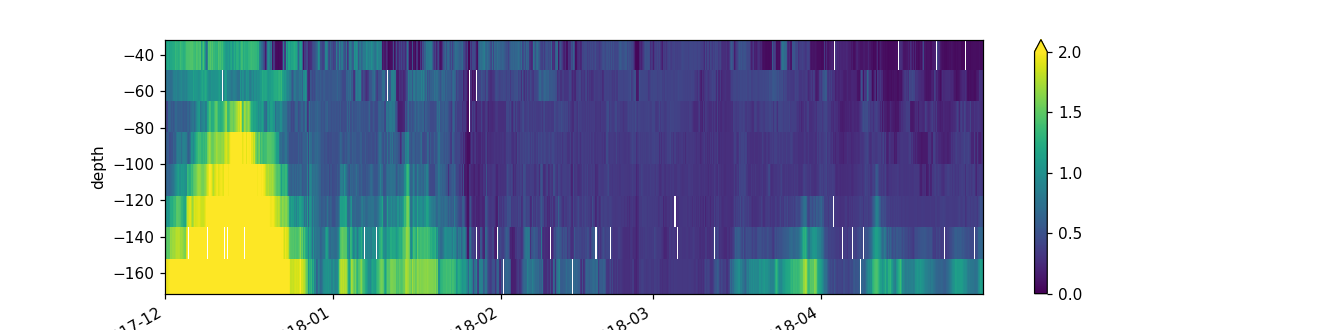

In [1408]:
fig, ax = plt.subplots(figsize=(12,3))
(m2.T-m2.Tf).plot(vmin=0 ,vmax=2)

<IPython.core.display.Javascript object>


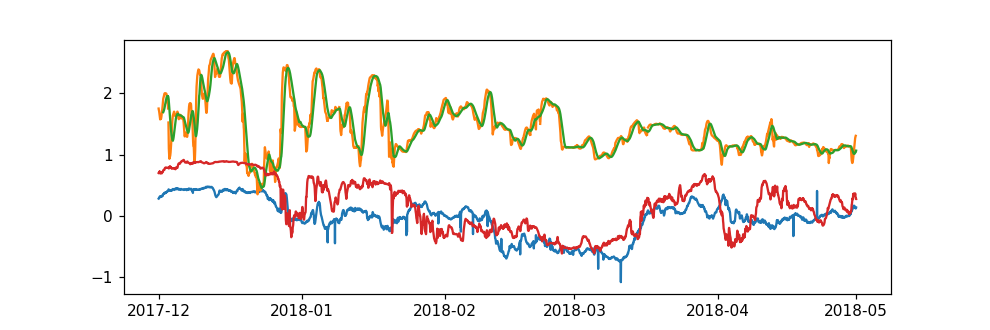

In [1407]:

m1 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_tempsalinity_{open_years}.nc')
m2 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/M2_hourly_tempsalinity_{open_years}.nc')
m3 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/M3_hourly_tempsalinity_{open_years}.nc')
m4 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/M4_hourly_tempsalinity_{open_years}.nc')

time_range = slice(datetime(Y1,12,1), datetime(Y2,4,30,23))
m1 = m1.sel(time=time_range)
m2 = m2.sel(time=time_range)
m3 = m3.sel(time=time_range)
m4 = m4.sel(time=time_range)

PDdiff = m3.sig0.sel(depth = slice(-250,-80)).mean('depth')-m4.sig0.sel(depth = slice(-250,-80)).mean('depth')
CPD = m1.sig0.sel(depth=m1.depth.min())
# CPD = m1.sig0.sel(depth=m1.depth.max())
# CPD = m1.sig0.mean('depth')

uw2 = m2.sig0.sel(depth=m2.depth.min())
uw3 = m3.sig0.sel(depth=m3.depth.min())

%matplotlib notebook
fig, ax = plt.subplots(figsize=(9,3))
# m3.Ct.plot(vmin=-1.9, vmax=2, cmap='jet')
# dss.Sa.plot(vmin=29.5, vmax=31.5)
# dss.sig0.plot(vmin=23, vmax=26)

plt.plot(m3.time, PDdiff)
plt.plot(m1.time, CPD-25)

daily_CPD = tseries.running_mean(CPD.values, length=24, center=False, address_nans=True)
daily_current = tseries.running_mean(current, length=24, center=False, address_nans=False)

plt.plot(m1.time, daily_CPD-25)

plt.plot(m1.time, uw2-27)
# plt.plot(m1.time, 2*(uw3-25))



<IPython.core.display.Javascript object>


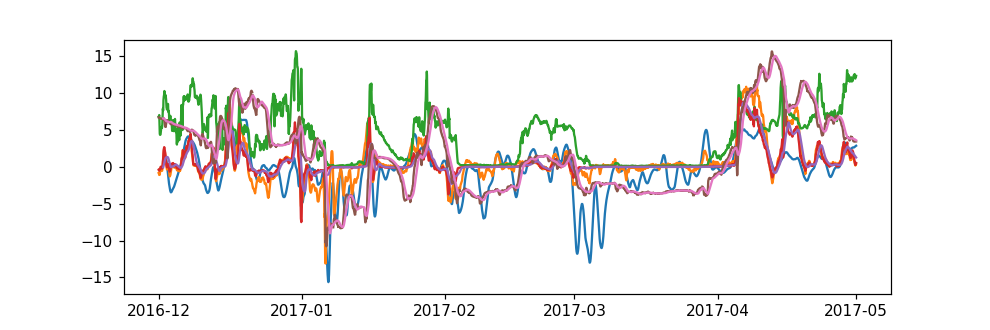

[]

In [715]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(9,3))
# plt.plot(dsc.time, int_OHT)

lag = 8
# plt.plot(dsc.time[lag:], wind[:-lag])
# plt.plot(dsc.time[lag:], wind_stress[:-lag]/20)
# plt.plot(dsc.time, wind_stress/20)
plt.plot(dsc.time, daily_stress/20)
plt.plot(dsc.time, current*10)
# plt.plot(dsc.time, sig/100)
plt.plot(dsc.time, temp_sig/100)
# plt.plot(dsc.time, daily_wind)
plt.plot(dsc.time, hourly_OHT.magnitude/300000000000)
plt.plot(dsc.time, daily_OHT.magnitude/300000000000)

# plt.plot(m3.time, 20*np.clip(PDdiff, -0.8,0.4)+5)
plt.plot(m3.time, 10*(CPD-25))

plt.plot(m3.time, 10*(daily_CPD-25))

plt.plot()


<IPython.core.display.Javascript object>


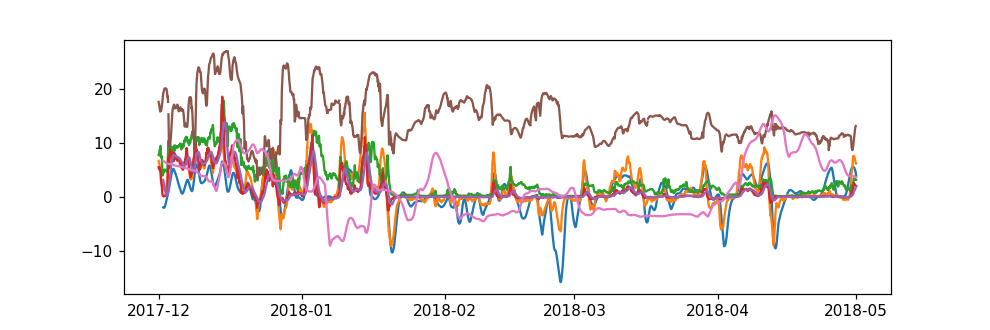

[]

In [744]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(9,3))
# plt.plot(dsc.time, int_OHT)

lag = 8
# plt.plot(dsc.time[lag:], wind[:-lag])
# plt.plot(dsc.time[lag:], wind_stress[:-lag]/20)
# plt.plot(dsc.time, wind_stress/20)
plt.plot(dsc.time, daily_stress/20)
plt.plot(dsc.time, current*10)
# plt.plot(dsc.time, sig/100)
plt.plot(dsc.time, temp_sig/100)
# plt.plot(dsc.time, daily_wind)
plt.plot(dsc.time, hourly_OHT.magnitude/300000000000)
plt.plot(dsc.time, daily_OHT.magnitude/300000000000)

# plt.plot(m3.time, 20*np.clip(PDdiff, -0.8,0.4)+5)
plt.plot(m3.time, 10*(CPD-25))

plt.plot(m3.time, 10*(daily_CPD-25))

plt.plot()


In [25]:


cmap = cmocean.tools.crop_by_percent(cmocean.cm.haline, 5, which='max', N=None)
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list( 'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = [-0.5,0.5,1.5,2.5,3.5,4.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

months = np.array([date.month for date in pd.to_datetime(dsc.time.values)])
monmap = np.copy(months)
monmap[months==12] = 0

In [26]:
np.diff(dsc.z)[0]

2.0

In [27]:
htz = cst['Cp_o']*(dsc.dT*units('delta_degC')*dsc.sig0*units('kg/m3')*dsc.p*units('m/s'))
hcz = cst['Cp_o']*(dsc.dT*units('delta_degC')*dsc.sig0*units('kg/m3'))
dz = np.diff(dsc.z)[0] * units('m')

IHC = np.sum(0.5*(hcz[1:,:].values + hcz[:-1,:].values), axis=0) * units('joule/meter3') * dz
IHT = np.sum(0.5*(htz[1:,:].values + htz[:-1,:].values), axis=0) * units('joule/(meter2 second)') * dz

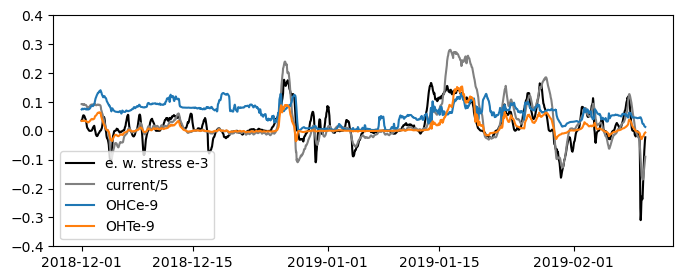

In [29]:
fig, ax = plt.subplots(figsize=(8,3))

plt.plot(dsc.time, -zonal_stress/1000, c='k', label='e. w. stress e-3')
plt.plot(dsc.time, current/5, c='gray', label='current/5')
plt.plot(dsc.time, IHC/(1e9), label='OHCe-9')
plt.plot(dsc.time, IHT.magnitude/(1e9), label='OHTe-9')

plt.legend()

plt.ylabel('')
plt.ylim(-0.4,0.4)

fig.savefig(f'../figures/mooring_relations/M1_timeseries_{open_years}.png', dpi=300, bbox_inches='tight')



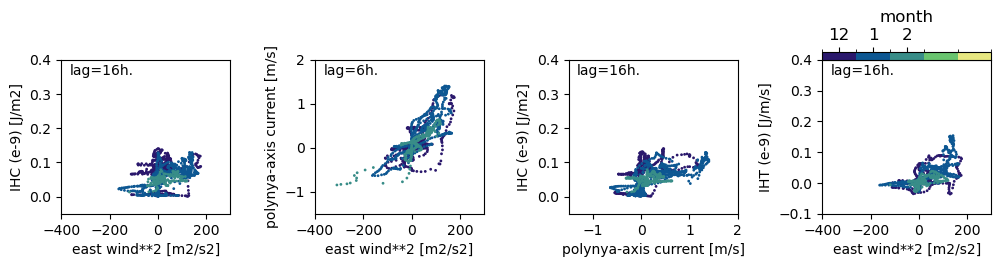

In [32]:
fig, axs = plt.subplots(1,4,figsize=(12,2))

plt.subplots_adjust(wspace=0.5)
# plt.scatter(wind_stress[:-lag], HC[lag:], s=1, c = (np.arange(len(hourly_OHT[lag:])))/len(hourly_OHT[lag:]))

ax = axs[0]
lag = 16
ax.scatter(-zonal_stress[:-lag], IHC[lag:]/(1e9), s=1, c = monmap[:-lag], cmap=cmap, norm=norm)
ax.text(0.05,0.9,f'lag={lag}h.', transform=ax.transAxes)
ax.set_ylim(-0.05,0.4)
ax.set_xlim(-400,300)
ax.set_xlabel('east wind**2 [m2/s2]')
ax.set_ylabel('IHC (e-9) [J/m2]')

ax = axs[1]
lag = 6
ax.scatter(-zonal_stress[:-lag], current[lag:], s=1, c = monmap[:-lag], cmap=cmap, norm=norm)
ax.text(0.05,0.9,f'lag={lag}h.', transform=ax.transAxes)
ax.set_ylim(-1.5,2)
ax.set_xlim(-400,300)
ax.set_xlabel('east wind**2 [m2/s2]')
ax.set_ylabel('polynya-axis current [m/s]')


ax = axs[2]
lag = 16
ax.scatter(current[:-lag], IHC[lag:]/(1e9), s=1, c = monmap[:-lag], cmap=cmap, norm=norm)
ax.text(0.05,0.9,f'lag={lag}h.', transform=ax.transAxes)
ax.set_ylim(-0.05,0.4)
ax.set_xlim(-1.5,2)
ax.set_xlabel('polynya-axis current [m/s]')
ax.set_ylabel('IHC (e-9) [J/m2]')


ax = axs[3]
lag = 16
mesh = ax.scatter(-zonal_stress[:-lag], IHT[lag:]/(1e9), s=1, c = monmap[:-lag], cmap=cmap, norm=norm)
ax.text(0.05,0.9,f'lag={lag}h.', transform=ax.transAxes)
ax.set_ylim(-0.1,0.4)
ax.set_xlim(-400,300)
ax.set_xlabel('east wind**2 [m2/s2]')
ax.set_ylabel('IHT (e-9) [J/m/s]')

# plt.ylim(23.5,28)

# cb = plt.colorbar(mesh, ticks=list(set(monmap)), ticklabels=[12,1,2,3,4])

plotter.add_colorbar(fig, ax, [mesh], cb_placement='top',
             cb_orientation='auto', cb_width='auto', cb_length_fraction=[0, 1],
             cb_pad=0, cb_ticks=list(set(monmap)), cb_ticklabels=[12,1,2,], cb_extend='neither', 
             cb_label='month', labelpad='auto', cb_label_placement='auto', 
             cb_tick_placement='auto', tick_kwargs=None, cb_labelsize=12, 
             draw_edges=False, edge_params=['k', 2])


# fig.savefig(f'../figures/mooring_relations/M1_wind_current_heat_{open_years}.png', dpi=300, bbox_inches='tight')


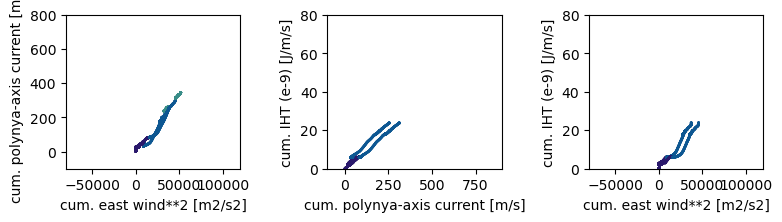

In [36]:
fig, axs = plt.subplots(1,3,figsize=(9,2))
# plt.scatter(np.cumsum(-zonal_stress), np.cumsum(IHT)/(1e9), s=1,  c = monmap, cmap=cmap, norm=norm)

plt.subplots_adjust(wspace=0.5)

cum_forc = np.copy(-zonal_stress)
cum_forc[cum_forc<0] =0 

p_current = np.copy(current)
p_current[p_current<0] =0

ax = axs[0]
ax.scatter(np.cumsum(-zonal_stress),np.cumsum(current), s=1,  c = monmap, cmap=cmap, norm=norm)
ax.scatter(np.cumsum(cum_forc),np.cumsum(p_current), s=1,  c = monmap, cmap=cmap, norm=norm)
ax.set_xlim(-80000,120000)
ax.set_ylim(-100,800)
ax.set_xlabel('cum. east wind**2 [m2/s2]')
ax.set_ylabel('cum. polynya-axis current [m/s]')


ax = axs[1]
ax.scatter(np.cumsum(current), np.cumsum(IHT)/(1e9), s=1,  c = monmap, cmap=cmap, norm=norm)
ax.scatter(np.cumsum(p_current), np.cumsum(IHT)/(1e9), s=1,  c = monmap, cmap=cmap, norm=norm)
ax.set_xlim(-100,900)
ax.set_xlabel('cum. polynya-axis current [m/s]')


ax = axs[2]
ax.scatter(np.cumsum(-zonal_stress), np.cumsum(IHT)/(1e9), s=1,  c = monmap, cmap=cmap, norm=norm)
ax.scatter(np.cumsum(cum_forc), np.cumsum(IHT)/(1e9), s=1,  c = monmap, cmap=cmap, norm=norm)
ax.set_xlim(-80000,120000)
ax.set_xlabel('cum. east wind**2 [m2/s2]')

# for ax in [axs[1],axs[2]]:
#     ax.set_ylim(0,250)
#     ax.set_ylabel('cum. IHC (e-9) [J/m2]')

for ax in [axs[1],axs[2]]:
    ax.set_ylim(0,80)
    ax.set_ylabel('cum. IHT (e-9) [J/m/s]')

fig.savefig(f'../figures/mooring_relations/M1_cum_relation_IHT_{open_years}.png', dpi=300, bbox_inches='tight')


In [830]:
open_years

'2017_2018'

In [639]:
list(set(monmap))

[0, 1, 2, 3, 4]

In [610]:
IHT

<Quantity([81861406.79192115 78828124.45429581 76460142.32450727 ...
 30740935.31401549 30403457.11788232 29918366.06103866], 'joule / meter / second')>

<IPython.core.display.Javascript object>


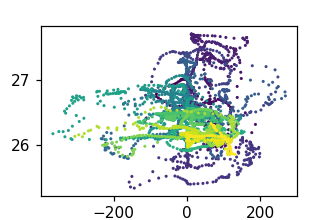

In [537]:
fig, ax= plt.subplots(figsize=(3,2))

lag = 6
# plt.scatter(wind_stress[:-lag][:1200], hourly_OHT[lag:][:1200], s=1)
# plt.scatter(wind_stress[:-lag][1200:], hourly_OHT[lag:][1200:], s=1)

# plt.scatter(daily_stress[:-lag], daily_OHT[lag:],  c = (np.arange(len(hourly_OHT[lag:])))/len(hourly_OHT[lag:]), s=1)

# plt.scatter(daily_wind, daily_OHT, s=1 )#c = (np.arange(len(hourly_OHT[lag:])))/len(hourly_OHT[lag:]), s=1)




# plt.scatter(wind_stress[:-lag], CPD[lag:], s=1, c = (np.arange(len(hourly_OHT[lag:])))/len(hourly_OHT[lag:]))


plt.scatter(wind_stress[:-lag], CPD[lag:], s=1, c = (np.arange(len(hourly_OHT[lag:])))/len(hourly_OHT[lag:]))




<IPython.core.display.Javascript object>


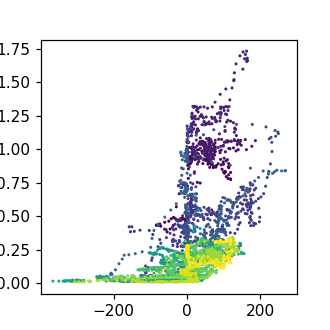

In [265]:
fig, ax= plt.subplots(figsize=(3,3))

lag = 12
# plt.scatter(wind_stress[:-lag][:1200], hourly_OHT[lag:][:1200], s=1)
# plt.scatter(wind_stress[:-lag][1200:], hourly_OHT[lag:][1200:], s=1)

# plt.scatter(daily_stress[:-lag], daily_OHT[lag:],  c = (np.arange(len(hourly_OHT[lag:])))/len(hourly_OHT[lag:]), s=1)

# plt.scatter(daily_wind, daily_OHT, s=1 )#c = (np.arange(len(hourly_OHT[lag:])))/len(hourly_OHT[lag:]), s=1)




plt.scatter(wind_stress[:-lag], temp[lag:], s=1, c = (np.arange(len(hourly_OHT[lag:])))/len(hourly_OHT[lag:]))





In [84]:
hourly_OHT.to('J/hour') * units('hour')

<Quantity([5.89402129e+15 5.67562496e+15 5.50513025e+15 ... 2.21334734e+15
 2.18904891e+15 2.15412236e+15], 'joule')>

In [43]:
int_OHT

<Quantity([81861406.79192115 78828124.45429583 76460142.32450727 ...
 30740935.31401549 30403457.11788232 29918366.06103866], 'meter')>

In [41]:
dsc['ohf']

<xarray.DataArray 'ohf' (z: 21, time: 3624)>
<Quantity([[1105956.29060506 1068449.10663556 1075211.78954507 ...  604642.4132472
   592854.4249581   597047.57084497]
 [1105956.29060506 1068449.10663556 1075211.78954507 ...  604642.4132472
   592854.4249581   597047.57084497]
 [1105956.29060506 1068449.10663556 1075211.78954507 ...  604642.4132472
   592854.4249581   597047.57084497]
 ...
 [2748254.47447597 2740307.93021627 2729259.50393234 ...  993781.10355016
   958245.79863375  891891.77872813]
 [2755814.72294445 2737307.66309984 2679338.8632171  ... 1057836.49119785
  1018126.54101719  942930.28429439]
 [2763374.97141293 2734307.3959834  2629418.22250187 ... 1121891.87884555
  1078007.28340063  993968.78986064]], 'joule / meter ** 2 / second')>
Coordinates:
  * time     (time) datetime64[ns] 2017-12-01 ... 2018-04-30T23:00:00
  * z        (z) float64 -40.0 -38.0 -36.0 -34.0 -32.0 ... -6.0 -4.0 -2.0 0.0

In [32]:
dsc['ohf']

<xarray.DataArray 'ohf' (z: 21, time: 3624)>
<Quantity([[1105956.29060506 1068449.10663556 1075211.78954507 ...  604642.4132472
   592854.4249581   597047.57084497]
 [1105956.29060506 1068449.10663556 1075211.78954507 ...  604642.4132472
   592854.4249581   597047.57084497]
 [1105956.29060506 1068449.10663556 1075211.78954507 ...  604642.4132472
   592854.4249581   597047.57084497]
 ...
 [2748254.47447597 2740307.93021627 2729259.50393234 ...  993781.10355016
   958245.79863375  891891.77872813]
 [2755814.72294445 2737307.66309984 2679338.8632171  ... 1057836.49119785
  1018126.54101719  942930.28429439]
 [2763374.97141293 2734307.3959834  2629418.22250187 ... 1121891.87884555
  1078007.28340063  993968.78986064]], 'joule / meter ** 2 / second')>
Coordinates:
  * time     (time) datetime64[ns] 2017-12-01 ... 2018-04-30T23:00:00
  * z        (z) float64 -40.0 -38.0 -36.0 -34.0 -32.0 ... -6.0 -4.0 -2.0 0.0

In [27]:
dsc['ohf']

<xarray.DataArray 'ohf' (z: 21, time: 3624)>
<Quantity([[1105956.29060506 1068449.10663556 1075211.78954507 ...  604642.4132472
   592854.4249581   597047.57084497]
 [1105956.29060506 1068449.10663556 1075211.78954507 ...  604642.4132472
   592854.4249581   597047.57084497]
 [1105956.29060506 1068449.10663556 1075211.78954507 ...  604642.4132472
   592854.4249581   597047.57084497]
 ...
 [2748254.47447597 2740307.93021627 2729259.50393234 ...  993781.10355016
   958245.79863375  891891.77872813]
 [2755814.72294445 2737307.66309984 2679338.8632171  ... 1057836.49119785
  1018126.54101719  942930.28429439]
 [2763374.97141293 2734307.3959834  2629418.22250187 ... 1121891.87884555
  1078007.28340063  993968.78986064]], 'joule / meter ** 2 / second')>
Coordinates:
  * time     (time) datetime64[ns] 2017-12-01 ... 2018-04-30T23:00:00
  * z        (z) float64 -40.0 -38.0 -36.0 -34.0 -32.0 ... -6.0 -4.0 -2.0 0.0

In [596]:
ds60 = xr.open_dataset('../data/fields/sic_maps_from15_using60_v5.nc')
ds10 = xr.open_dataset('../data/fields/sic_maps_from15_using10_v5.nc')

In [597]:
sic = unisic.open_local_file(datetime(2020,1,1), res='6250', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', crop=[0, None, 0, None], coordinates=False, area=False, include_units=False, quiet=True)



In [598]:
# Define the bearing (in degrees) and the distance to travel (in meters)
#==================
# bearing1 = -70 # 160 ice principal variance axis
bearing1 = -55 # 145 ocean principal variance axis
#==================
# distance = 15000 # m
distance = 50000 # m

geod = pyproj.Geod(ellps='WGS84') # Create a Geod object

reg_lons = np.array([-139])
reg_lats = np.array([69.55])

reg_lonsp = np.copy(reg_lons)
reg_latsp = np.copy(reg_lats)

for ss in range(5):
    lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing1, distance)
    reg_lons = np.append(reg_lons, lon2)
    reg_lats = np.append(reg_lats, lat2)

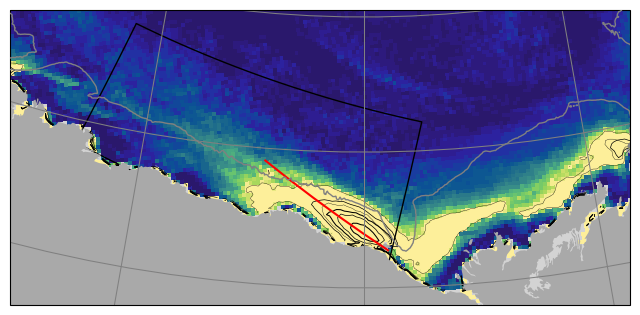

In [602]:
map_proj = ccrs.NorthPolarStereo(central_longitude=-140)

fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))

# ax.set_ylim(-2800000,-500000)
# ax.set_xlim(-1500000,1500000)

ax.set_ylim(-2400000,-1900000)
ax.set_xlim(-600000,450000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)
geomap.gebco_bathymetry(ax, file_path='/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/GEBCO_2024/gebco_2024_n90.0_s55.0_w-180.0_e180.0.nc', 
                             crop_lat=(69, 73.5), crop_lon=(-170, -110), clat=5, clon=15, depth_shade=False, 
                             shade_zorder=0, depth_contours=True, contour_levels=[-100], 
                             contour_kwargs={'colors': 'gray', 'linewidths': 1, 'linestyles': 'solid', 'zorder': 100},
                             contour_labels=False, text_kwargs={'size': 10, 'color': 'gray', 'weight': 'normal', 'zorder': 100})

key = 'large'
ax.pcolormesh(sic_data[key]['xx'], sic_data[key]['yy'], ds60[f'{key}_open_freq'], 
              vmin=0, vmax=0.25, transform=sic['proj'], cmap=cmocean.cm.haline)

# ax.contour(sic_data[key]['xx'], sic_data[key]['yy'], sic_data[key]['open_freq'], 
#             levels=[0.25,0.5,0.75], colors=['k'], linewidths=[0.25,0.5,0.75], transform=sic['proj'])

ax.contour(sic_data[key]['xx'], sic_data[key]['yy'], ds60[f'{key}_open_freq'], 
            levels=[0.25,0.50,0.75], colors=['k'], linewidths=[0.25,0.50,0.75], transform=sic['proj'])


ax.contour(sic_data[key]['xx'], sic_data[key]['yy'], ds10[f'{key}_open_freq'], 
            levels=[0.25,0.50,0.75], colors=['k'], linewidths=[0.25,0.50,0.75], transform=sic['proj'])

# ax.pcolormesh(sic_data[key]['xx'], sic_data[key]['yy'], sic_data[key]['sic_mean'], 
#               vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=sic['proj'])

# ax.pcolormesh(sic_data[key]['xx'], sic_data[key]['yy'], sic_data['large']['open_freq']-sic_data['open']['open_freq'], 
#               vmin=-0.5, vmax=0.5, cmap=cmocean.cm.balance, transform=sic['proj'])

ax.add_geometries([reg_poly], edgecolor='k', facecolor='None', crs=ccrs.PlateCarree())

ax.plot(reg_lons, reg_lats, c='r', transform=ccrs.PlateCarree())

line_kwargs = {'color':'gray', 'lw':0.75}
for lon in [-150,-140,-130]:
    ax.plot(np.full(10,lon), np.linspace(68,75,10), transform=ccrs.PlateCarree(), **line_kwargs)
for lat in [69, 71, 73]:
    ax.plot(np.linspace(-160,-110,30), np.full(30,lat), transform=ccrs.PlateCarree(), **line_kwargs)
    

41.820426550459494
-34.28250455547352


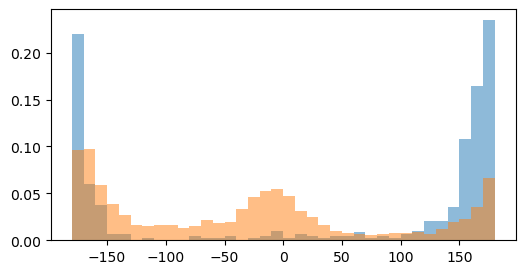

In [50]:

fig, ax = plt.subplots(figsize=(6,3))


var = 'a10'
bins = np.arange(-180,181,10)

x = compare['open'][var]
h = plotter.quick_hist(x, bin_edges = bins)
ax.bar(h['centers'], h['prob'], width = h['w'], alpha=0.5)
print(np.nanmean(x))

x = compare['comp'][var]
h = plotter.quick_hist(x, bin_edges = bins)
ax.bar(h['centers'], h['prob'], width = h['w'], alpha=0.5)
print(np.nanmean(x))

In [ ]:
# bin_edges = np.arange(-20,21,1)
# bin_edges = np.arange(0,20,1)
# bin_edges = np.arange(-35,0,2)
bin_edges = np.arange(-180,181,10)
bin_w = np.diff(bin_edges)[0]
bin_centers = bin_edges[:-1] + bin_w/2


compare['open']

cat = 'era'

x = daily_data[cat]['u'][daily_data['pol']['extent']>50]
t = daily_data[cat]['t2m'][daily_data['pol']['extent']>50]
s = daily_data[cat]['s'][daily_data['pol']['extent']>50]
y = daily_data[cat]['v'][daily_data['pol']['extent']>50]
a = daily_data[cat]['angle'][daily_data['pol']['extent']>50]
print('angle of mean:', vectors.vector_angle(np.nanmean(x),np.nanmean(y)).magnitude)

var = a

counts,bins=np.histogram(var, bins=bin_edges)
plt.bar(bin_centers, counts/len(var), width=0.9*bin_w, alpha=0.5)

x = daily_data[cat]['u'][daily_data['pol']['extent']<50]
t = daily_data[cat]['t2m'][daily_data['pol']['extent']<50]
s = daily_data[cat]['s'][daily_data['pol']['extent']<50]
y = daily_data[cat]['v'][daily_data['pol']['extent']<50]
a = daily_data[cat]['angle'][daily_data['pol']['extent']<50]
print('angle of mean:', vectors.vector_angle(np.nanmean(x),np.nanmean(y)).magnitude)


var = a

counts,bins=np.histogram(var, bins=bin_edges)
plt.bar(bin_centers, counts/len(var), width=0.9*bin_w, alpha=0.5)

angle of mean: 173.4028372143727
angle of mean: -143.23213679166747


<BarContainer object of 36 artists>

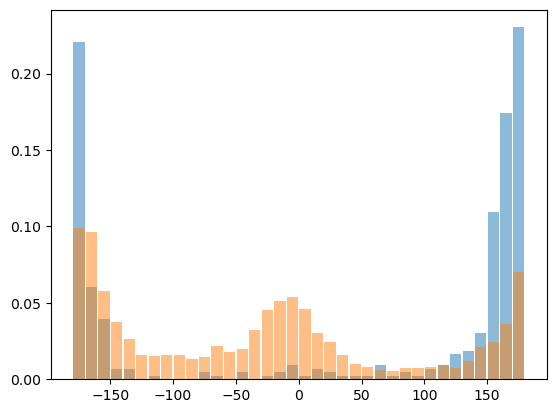

In [170]:
# bin_edges = np.arange(-20,21,1)
# bin_edges = np.arange(0,20,1)
# bin_edges = np.arange(-35,0,2)
bin_edges = np.arange(-180,181,10)
bin_w = np.diff(bin_edges)[0]
bin_centers = bin_edges[:-1] + bin_w/2

cat = 'era'

x = daily_data[cat]['u'][daily_data['pol']['extent']>50]
t = daily_data[cat]['t2m'][daily_data['pol']['extent']>50]
s = daily_data[cat]['s'][daily_data['pol']['extent']>50]
y = daily_data[cat]['v'][daily_data['pol']['extent']>50]
a = daily_data[cat]['angle'][daily_data['pol']['extent']>50]
print('angle of mean:', vectors.vector_angle(np.nanmean(x),np.nanmean(y)).magnitude)

var = a

counts,bins=np.histogram(var, bins=bin_edges)
plt.bar(bin_centers, counts/len(var), width=0.9*bin_w, alpha=0.5)

x = daily_data[cat]['u'][daily_data['pol']['extent']<50]
t = daily_data[cat]['t2m'][daily_data['pol']['extent']<50]
s = daily_data[cat]['s'][daily_data['pol']['extent']<50]
y = daily_data[cat]['v'][daily_data['pol']['extent']<50]
a = daily_data[cat]['angle'][daily_data['pol']['extent']<50]
print('angle of mean:', vectors.vector_angle(np.nanmean(x),np.nanmean(y)).magnitude)


var = a

counts,bins=np.histogram(var, bins=bin_edges)
plt.bar(bin_centers, counts/len(var), width=0.9*bin_w, alpha=0.5)


In [446]:
import timeseries.analyze as tanalyze

In [459]:
# original vector components
xp2 = daily_data['ppd']['u']
yp2 = daily_data['ppd']['v']

xp = xp2[np.isfinite(xp2)&np.isfinite(yp2)]
yp = yp2[np.isfinite(xp2)&np.isfinite(yp2)]

varell = tanalyze.variance_ellipses(xp,yp)
xm = vectors.comp_along_theta(xp, yp, varell['theta_m'] * units('rad'))
ym = vectors.comp_along_theta(xp, yp, (varell['theta_m']+np.pi/2) * units('rad'))


-0.3535498146763032


In [460]:
(varell['theta_m']*180/np.pi)+180

159.74308777141542

In [449]:
vectors.vector_angle(np.nanmean(xp), np.nanmean(yp))

<Quantity(170.788514, 'degree')>

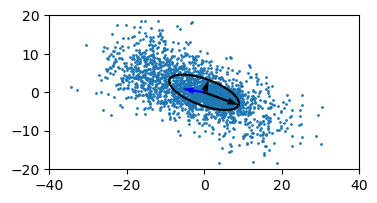

In [450]:
fig, ax = plt.subplots(figsize=(4,2))
ax.set_xlim(-20*2,20*2)
ax.set_ylim(-10*2,10*2)

thetas = np.linspace(-np.pi,np.pi,100)

# plt.plot(thetas*180/np.pi, s2(sxx, syy, sxy, thetas))

# plt.scatter(np.sqrt(R)*np.cos(thetas), 
#             np.sqrt(R)*np.sin(thetas))
# plt.scatter(xe, ye)
plt.scatter(xp-xp.mean(), yp-yp.mean(), s=1)
plt.plot(varell['xe'], varell['ye'], c='k')
plt.quiver(0,0,np.nanmean(xp), np.nanmean(yp), angles='xy', scale_units='xy', scale=1, color='b')

plt.quiver(0,0, 
           np.sqrt(varell['s11'])*np.cos(varell['theta_m']), 
           np.sqrt(varell['s11'])*np.sin(varell['theta_m']), angles='xy', scale_units='xy', scale=1, color='k')

plt.quiver(0,0, 
           np.sqrt(varell['s22'])*np.cos(varell['theta_m']+np.pi/2), 
           np.sqrt(varell['s22'])*np.sin(varell['theta_m']+np.pi/2), angles='xy', scale_units='xy', scale=1, color='k')

# plt.plot(thetas*180/np.pi, ds2dtheta(sxx, syy, sxy, thetas))
# plt.plot(thetas*180/np.pi, -4 * sxy * np.sin(2*(thetas)))

# plt.axvline(theta_m*180/np.pi)

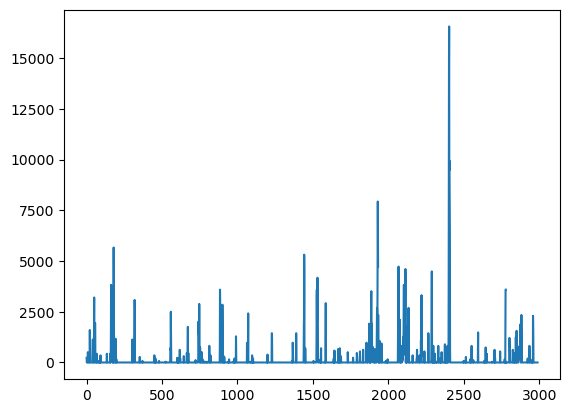

In [138]:
# plt.plot(daily_data['era']['angle'])
plt.plot(daily_data['pol']['extent'])

In [129]:
a

array([  19.5104022 ,  -13.8580853 , -167.70058823, ..., -132.22279531,
       -170.8590538 , -178.08628889])

In [124]:
len(x)/20

145.05

19.1
18.2
16.55
18.4
20.6


[Text(0, 0, '12'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4')]

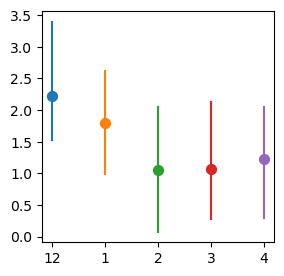

In [174]:
fig, ax = plt.subplots(figsize=(3,3))

# ax.scatter(daily_data['era']['month'], daily_data['ppd']['ese'], s=1)

for mm, month in enumerate(months):
    
    mean_ppd_ese = np.nanmean(daily_data['ppd']['ese'][daily_data['ppd']['month']==month])
    mean_era_ese = np.nanmean(daily_data['era']['ese'][daily_data['era']['month']==month])
    
    
    cond = (daily_data['era']['ese'] > 0) & (daily_data['ppd']['month']==month)
    print(np.sum(cond)/len(years))
    monthly_wf = (daily_data['ppd']['ese']/daily_data['era']['ese'])[cond]
    
#     ax.scatter(mm, mean_ppd_ese/mean_era_ese, s=1)
    
    ax.scatter(mm, np.nanmedian(monthly_wf), s=50)
    
    ax.plot([mm,mm], [np.nanpercentile(monthly_wf, 25),
                      np.nanpercentile(monthly_wf, 75)], )

ax.set_xticks(range(len(months)))
ax.set_xticklabels(months)

# ax.scatter(daily_data['ppd']['ese'], daily_data['era']['t2m'], s=1)
# ax.scatter(daily_data['ppd']['ese'], daily_data['pol']['extent'], s=5)

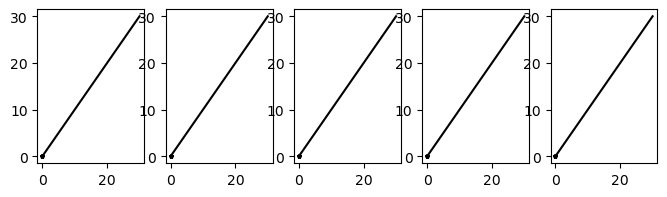

In [166]:
fig, axs = plt.subplots(1, len(months), figsize=(8,2))

month_shapes = ['*', '*', 's', 'o', 'o']
month_colors = ['b', 'dodgerblue', 'gray', 'lightcoral', 'None']
edge_colors = ['None', 'None', 'k', 'None', 'k']



for mm, month in enumerate(months):
    
    ax = axs[mm]
    ax.plot([0,30], [0,30], c='k')
    
    for year in years:
        

        ax.scatter(wind_counts[month][year]/24, 
                   polynya_counts[month][year], 
                   s=5, c='k', marker='*')
#                    marker=month_shapes[mm], 
#                    facecolor=month_colors[mm],
#                   edgecolor=edge_colors[mm])

[Text(0, 0, '12'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4')]

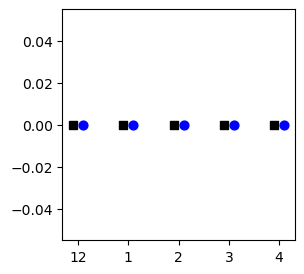

In [177]:
fig, ax = plt.subplots(figsize=(3,3))

for mm, month in enumerate(months):
    
    monthly_winds = np.array([])
    for year in years:
        monthly_winds = np.append(monthly_winds, wind_counts[month][year]/24)
    
    monthly_polynyas = np.array([])
    for year in years:
        monthly_polynyas = np.append(monthly_polynyas, polynya_counts[month][year])
    
    dx = -0.1
    ax.scatter(np.full(len(years), mm+dx), monthly_winds, c='lightgray', s=1)
    color = 'k'
    ax.scatter(mm+dx, np.nanpercentile(monthly_winds, 50), c=color, marker='s', s=40)
    ax.plot([mm+dx,mm+dx], [np.nanpercentile(monthly_winds, 25),np.nanpercentile(monthly_winds, 75)], c=color)
    
    dx = 0.1
    color = 'blue'
    ax.scatter(np.full(len(years), mm+dx), monthly_polynyas, c='dodgerblue', s=1)
    ax.scatter(mm+dx, np.nanpercentile(monthly_polynyas, 50),  c=color, marker='o', s=40)
    ax.plot([mm+dx,mm+dx], [np.nanpercentile(monthly_polynyas, 25),np.nanpercentile(monthly_polynyas, 75)], c=color)
    

ax.set_xticks(range(len(months)))
ax.set_xticklabels(months)

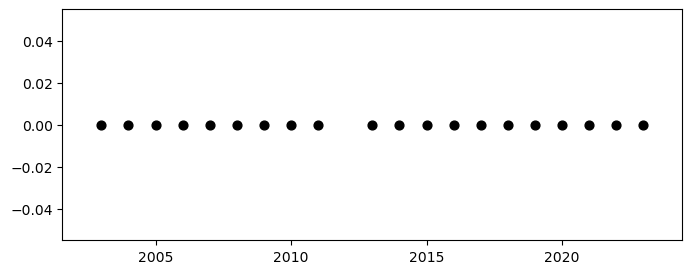

In [178]:
fig, ax = plt.subplots(figsize=(8,3))

for yy, year in enumerate(years):
    
    annual_winds = np.array([])
    for month in months:
        annual_winds = np.append(annual_winds, wind_counts[month][year]/24)
    
    annual_polynyas = np.array([])
    for month in months:
        annual_polynyas = np.append(annual_polynyas, polynya_counts[month][year])
    
#     dx = -0.1
#     ax.scatter(np.full(len(months), year+dx), annual_winds, c='lightgray', s=1)
#     color = 'k'
#     ax.scatter(year+dx, np.nanpercentile(annual_winds, 50), c=color, marker='s', s=40)
#     ax.plot([year+dx,year+dx], [np.nanpercentile(annual_winds, 25),np.nanpercentile(annual_winds, 75)], c=color)
    
#     dx = 0.1
#     color = 'blue'
#     ax.scatter(np.full(len(months), year+dx), annual_polynyas, c='dodgerblue', s=1)
#     ax.scatter(year+dx, np.nanpercentile(annual_polynyas, 50),  c=color, marker='o', s=40)
#     ax.plot([year+dx,year+dx], [np.nanpercentile(annual_polynyas, 25),np.nanpercentile(annual_polynyas, 75)], c=color)
    

    dx = -0.1
    color='k'
    ax.bar(year, np.sum(annual_winds),   color='darkgray')

    dx = 0.1
    color = 'blue'
    ax.scatter(year, np.sum(annual_polynyas),   c='k', marker='o', s=40)

# ax.set_xticks(range(len(months)))
# ax.set_xticklabels(months)

2003
2004
2005
2006
2007
2008
2009
2010
2011
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
0.6461208371730984
0.41747213622926554


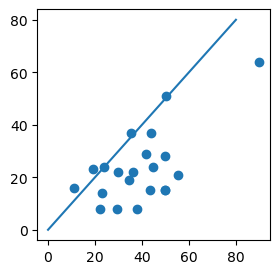

In [1117]:
fig, ax = plt.subplots(figsize=(3,3))

ax.plot([0,80], [0,80])

x = np.array([])
y = np.array([])
for yy, year in enumerate(years[:]):
    
    print(year)
    
    annual_winds = np.array([])
    for month in months:
        annual_winds = np.append(annual_winds, long_wind_counts[month][year]/24)
    
    annual_polynyas = np.array([])
    for month in months:
        annual_polynyas = np.append(annual_polynyas, polynya_counts[month][year])
    
    
    x = np.append(x, np.sum(annual_winds))
    y = np.append(y, np.sum(annual_polynyas))
    
ax.scatter(x,y)

res = stats.linregress(x, y)

print(res.rvalue)
print(res.rvalue**2)

In [927]:
annual_winds

array([13.54166667, 10.375     ,  9.70833333, 11.58333333,  0.        ])

### Create maps of data

In [62]:
# # start dict to store event times
# cats = ['start', 'final', 'all']

# seq_times = {}

# for cat in cats:
#     seq_times[cat] = np.array([])
    
# for ss in all_seqs:
#     seq_times['all'] = np.append(seq_times['all'], all_seqs[ss])
#     seq_times['start'] = np.append(seq_times['start'], all_seqs[ss][0])
#     seq_times['final'] = np.append(seq_times['final'], all_seqs[ss][-1])



In [198]:

maps = {}

era_vars = ['u10', 'v10', 's10', 'msl', 't2m']
ppd_vars = ['e', 'n', 's',]
        
date = datetime(2020,1,1)
dse = open_daily_winds(date.year, era_lat_range, era_lon_range, time_range = date)
ds2 = open_daily_t2m(date.year, era_lat_range, era_lon_range, time_range = date)
drift = open_daily_drift(date.year, era_lat_range, era_lon_range, time_range = date)

for cat in compare.keys():
    maps[cat] = {}
    for var in era_vars:
        maps[cat][var] = {}
        if str(var) in ['s10']:
            maps[cat][var]['sum'] = np.zeros(dse['u10'].values.shape)
            maps[cat][var]['N'] = np.zeros(dse['u10'].values.shape)
        elif str(var) in ['t2m']:
            maps[cat][var]['sum'] = np.zeros(ds2['t2m'].values.shape)
            maps[cat][var]['N'] = np.zeros(ds2['t2m'].values.shape)
        else:
            maps[cat][var]['sum'] = np.zeros(dse[var].values.shape)
            maps[cat][var]['N'] = np.zeros(dse[var].values.shape)
    for var in ppd_vars:
        maps[cat][var] = {}
        maps[cat][var]['sum'] = np.zeros(drift[var].shape)
        maps[cat][var]['N'] = np.zeros(drift[var].shape)
        
            
for dd, date in enumerate(all_consol_dates):
    
    if dd % 100 == 0:
        print(f'{dd}/{len(all_consol_dates)}')
    
    date = pd.to_datetime(date)
    dse = open_daily_winds(date.year, era_lat_range, era_lon_range, time_range = date)
    ds2 = open_daily_t2m(date.year, era_lat_range, era_lon_range, time_range = date)
    drift = open_daily_drift(date.year, era_lat_range, era_lon_range, time_range = date)

    for cat in compare.keys():
        for var in era_vars:
            if date in compare[cat]['time']:
                if str(var) == 's10':
                    maps[cat][var]['sum'] += np.sqrt(dse['u10'].values**2+dse['v10'].values**2)
                    maps[cat][var]['N'] += np.isfinite(dse['u10'].values)
                elif str(var) == 't2m':
                    maps[cat][var]['sum'] += ds2[var].values-273.15
                    maps[cat][var]['N'] += np.isfinite(ds2[var].values)
                else:
                    maps[cat][var]['sum'] += dse[var].values
                    maps[cat][var]['N'] += np.isfinite(dse[var].values)
        for var in ppd_vars:
            if date in compare[cat]['time']:
                maps[cat][var]['sum'] += drift[var]
                maps[cat][var]['N'] += np.isfinite(drift[var])
                
for cat in compare.keys():     
    for var in era_vars:
        maps[cat][var]['mean'] = maps[cat][var]['sum'] / maps[cat][var]['N']
    maps[cat]['dc'] = np.sqrt(maps[cat]['u10']['mean']**2+maps[cat]['v10']['mean']**2) / maps[cat]['s10']['mean']
    
    for var in ppd_vars:
        maps[cat][var]['mean'] = maps[cat][var]['sum'] / maps[cat][var]['N']

0/2990



KeyboardInterrupt



In [200]:
for cat in compare.keys():     
    for var in era_vars:
        maps[cat][var]['mean'] = maps[cat][var]['sum'] / maps[cat][var]['N']
    maps[cat]['dc'] = np.sqrt(maps[cat]['u10']['mean']**2+maps[cat]['v10']['mean']**2) / maps[cat]['s10']['mean']
    
    for var in ppd_vars:
        maps[cat][var]['mean'] = maps[cat][var]['sum'] / maps[cat][var]['N']

In [199]:
dd

80

In [231]:
# dsm = xr.open_dataset('../data/forcing/dailymaps_era_v0.nc')


# bg_t = dsm.t2m.mean(['month', 'year'])
# bg_u10 = dsm.u10.mean(['month', 'year'])
# bg_v10 = dsm.v10.mean(['month', 'year'])
# bg_s = dsm.s10.mean(['month', 'year'])
# bg_dc = np.sqrt(bg_v**2 + bg_v**2) / bg_s


# cat = 'open'
# du = maps[cat]['u10']['mean'] - bg_u10
# dv = maps[cat]['v10']['mean'] - bg_v10
# total_vec_anom = np.sqrt(du**2+dv**2)

# angles = vectors.vector_angle(maps[cat]['u10']['mean'], maps[cat]['v10']['mean'])
# angles[angles<0]+=360

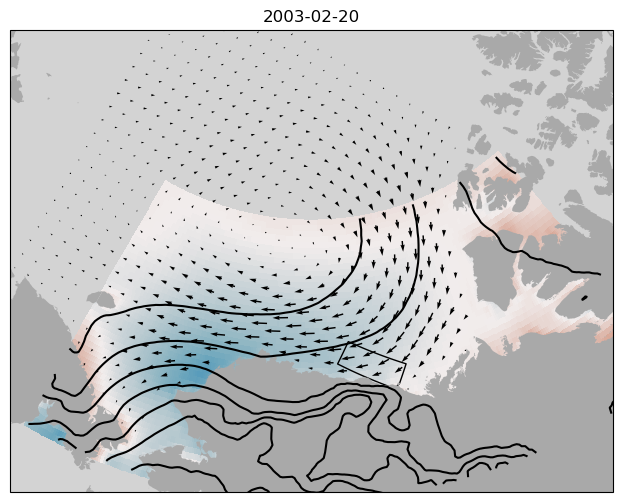

In [230]:
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)

fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))

ax.set_ylim(-2800000,-500000)
ax.set_xlim(-1500000,1500000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)
ax.set_title(date.date())

# ax.pcolormesh(dse.longitude, dse.latitude, maps['all']['v10']['mean'] - bg_v, vmin=-10,vmax=10, 
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

# ax.pcolormesh(dse.longitude, dse.latitude, maps['start']['s10']['mean'] - bg_s, vmin=-8,vmax=8, 
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

# ax.pcolormesh(dse.longitude, dse.latitude, total_vec_anom, vmin=5,vmax=10, 
#               cmap=cmocean.cm.haline, transform=ccrs.PlateCarree())



# ax.pcolormesh(dse.longitude, dse.latitude, bg_t, vmin=-40,vmax=-10, 
#               cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree())

# ax.contour(dse.longitude, dse.latitude, maps['all']['dc'], levels=[0.85,0.875,0.9,0.95, 1],
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())



# ax.pcolormesh(dse.longitude, dse.latitude, maps['large']['u10']['mean'], vmin=-10, vmax=10,
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


cat = 'comp'

ax.pcolormesh(dse.longitude, dse.latitude, maps[cat]['u10']['mean'], vmin=-15, vmax=15,
              cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

ax.contour(dse.longitude, dse.latitude, maps[cat]['msl']['mean']/100,
           levels=np.arange(980,1060,2), colors=['k'], transform=ccrs.PlateCarree())


U, V = geomap.fix_cartopy_vectors( maps[cat]['e']['mean'], maps[cat]['n']['mean'],drift['lat'] )
sp = 3
ax.quiver(drift['lon'][::sp,::sp], drift['lat'][::sp,::sp], U[::sp,::sp], V[::sp,::sp], 
           angles='xy', scale_units='xy', scale=0.0001, color='k', transform=ccrs.PlateCarree() )


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None', crs=ccrs.PlateCarree())
# ax.add_geometries([reg_poly2], edgecolor='k', facecolor='None', crs=ccrs.PlateCarree(), zorder=100)


In [225]:
drift['lat'].shape

(100, 90)

In [116]:
maps['open']['u10']['mean']

array([[-6.33512393, -6.36056706, -6.3883199 , ..., -1.21951695,
        -1.16989599, -1.11996235],
       [-6.39658295, -6.41467033, -6.4327566 , ..., -1.43588181,
        -1.3507128 , -1.26545125],
       [-6.37686807, -6.40158582, -6.4272047 , ..., -1.55807365,
        -1.5720865 , -1.58564462],
       ...,
       [-2.24591205, -2.40830296, -2.49977137, ..., -2.35796946,
        -2.3575059 , -2.35848543],
       [-3.14440928, -3.02458917, -2.96083463, ..., -3.04862902,
        -3.0600121 , -3.0676348 ],
       [-3.62648185, -3.50531121, -3.4517708 , ..., -2.99433956,
        -3.10442169, -3.26097929]])

In [97]:
maps['inc']['u10']['mean']

array([[-7.78713138, -7.81529995, -7.84647426, ..., -1.05275406,
        -0.9856221 , -0.91814326],
       [-7.92723005, -7.94543972, -7.9635781 , ..., -1.30348433,
        -1.1972822 , -1.09091508],
       [-7.97375547, -8.0004393 , -8.02819538, ..., -1.47589582,
        -1.47406795, -1.47170381],
       ...,
       [-2.88182985, -3.04569132, -3.11768526, ..., -2.57410093,
        -2.56759202, -2.57202763],
       [-4.0380519 , -3.84992351, -3.71678929, ..., -3.23536674,
        -3.24158588, -3.25289817],
       [-4.8237599 , -4.63354461, -4.50517245, ..., -3.21208103,
        -3.30128395, -3.44066225]])

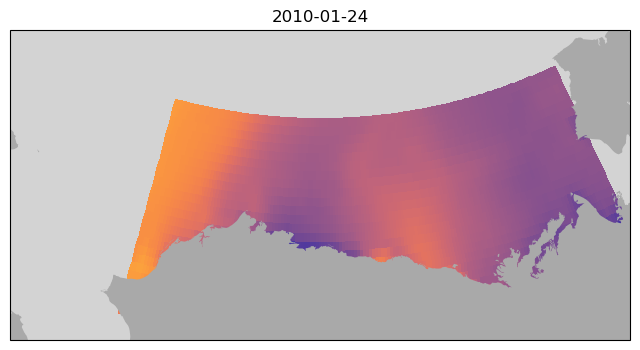

In [78]:
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)

fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))

ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-1000000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)
ax.set_title(date.date())


ax.pcolormesh(ds2.longitude, ds2.latitude, ds2.t2m-273.15, vmin=-40,vmax=0, 
              cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree())

In [11]:
GROUPS = {}
GROUPS['era'] = ['u10', 'v10', 'msl', 't2m', 's10']
GROUPS['ppd'] = ['e', 'n','s']
months = [12, 1, 2, 3, 4]

In [12]:

all_vals = {}

for key in ['era', 'ppd']:
    
    filename = f'../data/forcing/regional_{key}_v0.nc'
    ds = xr.open_dataset(filename)
    all_time = pd.to_datetime(ds.date.values.flatten())

    for group in GROUPS[key]:
        all_vals[group] = ds[group].values.flatten()


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [13]:


# start dict to store event times
cats = ['start', 'final', 'all']

seq_times = {}

for cat in cats:
    seq_times[cat] = np.array([])
    
for ss in all_seqs:
    seq_times['all'] = np.append(seq_times['all'], all_seqs[ss])
    seq_times['start'] = np.append(seq_times['start'], all_seqs[ss][0])
    seq_times['final'] = np.append(seq_times['final'], all_seqs[ss][-1])


# start empty arrays to store date
event_vals = {}
non_event_vals = {}

for cat in cats:
    event_vals[cat] = {}
    for key in ['era', 'ppd']:
        for group in GROUPS[key]:
            event_vals[cat][group] = np.array([])
            non_event_vals[group] = np.array([])

            
# grab values at event times           
for tt, time in enumerate(all_time):

    if time not in seq_times['all']:
        for key in ['era', 'ppd']:
            for group in GROUPS[key]:
                non_event_vals[group] = np.append(non_event_vals[group], all_vals[group][tt])
        
    for cat in cats:
        
        # look for date matches
        if time in seq_times[cat]:
#         date_ind = np.where(seq_times[cat] == time)[0]
        
        # if matched, add values
#         if len(date_ind) == 1:
            for key in ['era', 'ppd']:
                for group in GROUPS[key]:
                    event_vals[cat][group] = np.append(event_vals[cat][group], all_vals[group][tt])


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


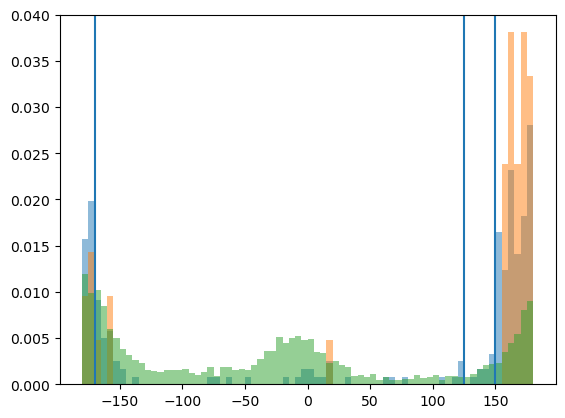

In [84]:

fig, ax = plt.subplots()

# bins = np.arange(-40,40)

# ax.hist(event_vals['all']['e'], bins=bins, alpha=0.5, density=True)
# ax.hist(event_vals['start']['e'], bins=bins, alpha=0.5, density=True)

# ax.hist(event_vals['all']['n'], bins=bins, alpha=0.5, density=True)
# ax.hist(event_vals['all']['e'], bins=bins, alpha=0.5, density=True)

key = 'ppd'
ds = xr.open_dataset(f'../data/forcing/regional_{key}_v0.nc') 
bins = np.arange(-180,181,5)
angles = vectors.vector_angle(event_vals['all']['u10'], event_vals['all']['v10'])
ax.hist(angles, bins=bins, alpha=0.5, density=True);

angles = vectors.vector_angle(event_vals['start']['u10'], event_vals['start']['v10'])
ax.hist(angles, bins=bins, alpha=0.5, density=True);

angles = vectors.vector_angle(non_event_vals['u10'], non_event_vals['v10'])
ax.hist(angles, bins=bins, alpha=0.5, density=True);

ax.axvline(125)
ax.axvline(150)
ax.axvline(-170)

# bins = np.arange(-180,181,5)
# angles = vectors.vector_angle(event_vals['all']['u10'], event_vals['all']['v10'])
# ax.hist(angles, bins=bins, alpha=0.5, density=True);

# angles = vectors.vector_angle(non_event_vals['u10'], non_event_vals['v10'])
# ax.hist(angles, bins=bins, alpha=0.5, density=True);

In [15]:


def grab_regiondata_bytime(dates):
    
    data = {}
    data['time'] = dates
    
    
    key = 'era'
    ds = xr.open_dataset(f'../data/forcing/regional_{key}_v0.nc')  
    cats = ['u10', 'v10', 's10', 'msl', 't2m']
    
    for cat in cats:
        data[cat] = np.array([])
    
    for date in dates:
        month = date.month
        if month == 12:
            YEAR = date.year+1
        else:
            YEAR = date.year
        monthlength = calendar.monthrange(YEAR, month)[-1]
        day = date.day
        for cat in cats:
            data[cat] = np.append(data[cat], ds[cat].sel(year = YEAR, month = date.month, day = day))
        
    key = 'ppd'
    ds = xr.open_dataset(f'../data/forcing/regional_{key}_v0.nc')  
    cats = ['e', 'n', 's']
    
    for cat in cats:
        data[cat] = np.array([])
    
    for date in dates:
        month = date.month
        if month == 12:
            YEAR = date.year+1
        else:
            YEAR = date.year
        monthlength = calendar.monthrange(YEAR, month)[-1]
        day = date.day
        for cat in cats:
            data[cat] = np.append(data[cat], ds[cat].sel(year = YEAR, month = date.month, day = day))
        
    return data

In [584]:
time_range

slice(datetime.datetime(2013, 12, 1, 0, 0), datetime.datetime(2014, 4, 30, 0, 0), None)

In [237]:



year = 2023

DS = xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic15_v5.nc')
time_range = slice(datetime(year-1,12,1), datetime(year,4,30))
DS = DS.sel(time = time_range)
DS['length'] = DS.l_per95 - DS.l_per5
DS['width'] = DS.w_per95 - DS.w_per5

dates = pd.date_range(time_range.start, time_range.stop)
regdata = grab_regiondata_bytime(dates)

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [238]:
len(regdata['n'])

151

In [239]:


# u = regdata['e']*units('cm/s').to('km/day')
# v = regdata['n']*units('cm/s').to('km/day')
# angles = vectors.vector_angle(u, v)
# along = vectors.comp_along_theta(u, v, (60+90)*units('degree')) 
# open_cond = (angles > 135 * units('degree')) + (angles < -170 * units('degree')) 

u = 0.03*regdata['u10']*units('m/s')
v = 0.03*regdata['v10']*units('m/s')
angles = vectors.vector_angle(u, v)
along = vectors.comp_along_theta(u, v, (25+60+90)*units('degree')) * units('m/s').to('km/day')
wind_speed = np.sqrt((regdata['u10'])**2+(regdata['v10'])**2)
open_angle = (angles > 145 * units('degree')) + (angles < -175 * units('degree')) 
open_cond = open_angle & (wind_speed > 3)


event_times = regdata['time']
consecutive_open = tseries.dates_to_sequences(event_times[open_cond], dt_max = 1 * units('day'))

cum_open = np.zeros(len(along))
for cc in consecutive_open:
    start = np.where(event_times == consecutive_open[cc][0])[0][0]
    final = np.where(event_times == consecutive_open[cc][-1])[0][0]
    cum_open[start:final+1] = np.cumsum(along[start:final+1])


Help on function running_mean in module timeseries.adjust:

running_mean(series, length=3, center=False, address_nans=False)
    Function to calculate running mean of a series (assumes evenly spaced data).

    INPUT:
    - series: (M x 1) array of data to calculate running mean
    - length: length of running mean window
        (either one-sided (window=length+1), or one side of two-sided if center=True (window=2*length + 1))
    - center: if True, calculate two-sided running mean
    - address_nans: if True, address nans in data by taking mean of non-nan values in window
        (else carry any nans to final data)

    OUTPUT:
    - running_mean: (M x 1) array of running mean values

    Latest recorded update:
    01-30-2025



In [240]:


# fig, ax = plt.subplots(figsize=(3,3))

# ax.set_xlim(-1,60)
# ax.set_ylim(-1,60)

# ax.plot(ax.get_xlim(), ax.get_ylim(), lw=0.5, c='k', zorder=-1)

# # ax.bar(years, num_wind_events)
# # ax.scatter(years, num_poly_events, c='k', marker='*')

# ax.scatter(num_wind_events, num_poly_events, c='k', marker='*')

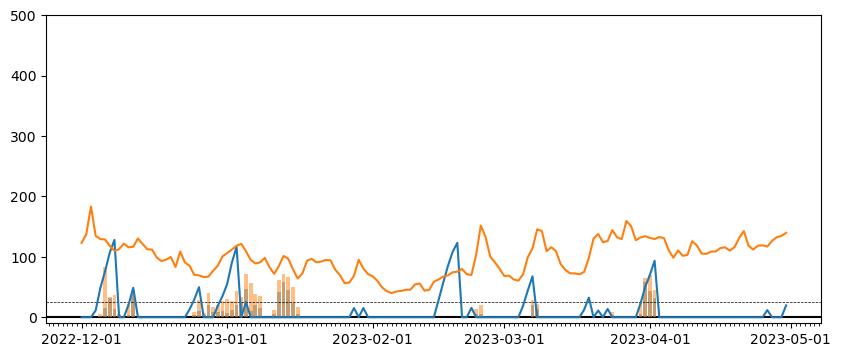

In [241]:


fig, ax = plt.subplots(figsize=(10,4))
ax.set_ylim(-10,500)

plt.axhline(1000/40, c='k', lw=0.5, ls='dashed')

plt.bar(DS.time, DS.extent.values/40, alpha=0.5)
plt.bar(DS.time, DS.length.values, alpha=0.5)
# plt.bar(DS.time, DS.polynya_extent.values / 50)

# plt.plot(event_times, open_along, marker='.')
# plt.plot(event_times, cum_open2, marker='.')
plt.plot(event_times, cum_open)
# plt.plot(event_times, u, marker='.')
# plt.plot(event_times, v, marker='.')


ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.axhline(0, c='k', zorder=-1)


# ax.plot(event_times, -20*regdata['u10'])
# ax.plot(event_times, 20*regdata['v10'])

ax.plot(event_times, 5*(regdata['t2m'] + 40))
# plt.bar(DS.time, DS.extent.values/DS.width.values, alpha=0.5)

In [190]:
cum_open2 = cum_open

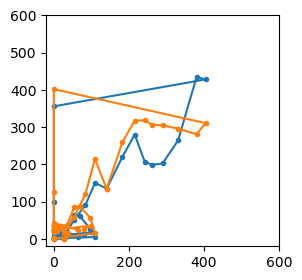

In [236]:
fig, ax = plt.subplots(figsize=(3,3))
ax.set_xlim(-20,600)
ax.set_ylim(-20,600)


ax.plot(cum_open, DS.extent.values/40, marker='.')
ax.plot(cum_open, DS.length.values, marker='.')

In [101]:
np.nanmean(DS['width'])

20.977675430946313

In [ ]:

key = 'era'
mainpath = '../data/forcing/'
filename = f"dailymaps_{key}_v0.nc"
ds = xr.open_dataset(mainpath+filename)

In [61]:
DS.extent > 100

<xarray.DataArray 'extent' (time: 26)>
array([False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 2023-12-31 2024-01-01 ... 2024-01-25

In [219]:
stats = {}

stats['polynya'] = {}
months = [12,1,2,3,4]

for month in months:
    stats['polynya'][month] = 0

for ss in all_seqs:
    
    for date in all_seqs[ss]:
        
        stats['polynya'][date.month] += 1

In [336]:
all_force = {}


dt_i = timedelta(hours=24)
dt_f = timedelta(hours=24)

for ii in all_seqs.keys():

    # define time range
    ti = all_seqs[ii][0]
    tf = all_seqs[ii][-1] + timedelta(hours=23)
    time_range = slice(ti - dt_i, tf + dt_f)


    # open ERA5 data
    dse = grab_atm(time_range, lat = 70.5 , lon = -140, dt = 'hourly')
    dt = ((pd.to_datetime(dse.time.values) - pd.to_datetime(ti)) / np.timedelta64(1, 's')) * units('s').to('day')
    
    
    all_force[ii] = {}
    all_force[ii]['dt'] = dt
    all_force[ii]['u10'] = dse.u10.values
    all_force[ii]['v10'] = dse.v10.values
    all_force[ii]['msl'] = dse.msl.values / 100
    

In [389]:
stats['ESE_winds'] = {}
stats['strong_winds'] = {}
stats['strong_ESE_winds'] = {}

for month in months:
    stats['ESE_winds'][month] = 0
    stats['strong_winds'][month] = 0
    stats['strong_ESE_winds'][month] = 0

    
for year in years:
    
    print(year)
    
    # open ERA5 data
    time_range = slice(datetime(year,1,1) - timedelta(days=31), datetime(year,1,1) + timedelta(days=120))
    dse = grab_atm(time_range, lat = 70.5 , lon = -140, dt = 'daily')
    year_months = np.array([date.month for date in pd.to_datetime(dse.time.values)])
    
    wind_angles = vectors.vector_angle(dse.u10.values, dse.v10.values)
    wind_speeds = np.sqrt(dse.u10.values**2 + dse.v10.values**2)
    
    for month in months:
        month_angles = wind_angles[year_months == month].magnitude
        month_speeds = wind_speeds[year_months == month]
        
        within_angle_range = (month_angles > 135) & (month_angles < 180)
        within_speed_range = (month_speeds > 7.5)
        
        
        stats['ESE_winds'][month] += np.sum(within_angle_range)
        stats['strong_winds'][month] += np.sum(within_speed_range)
        stats['strong_ESE_winds'][month] += np.sum(within_angle_range&within_speed_range)
        

2018
2019
2020
2021
2022
2023
2024


In [344]:
back_u = np.array([])
back_v = np.array([])
back_m = np.array([])

for year in years:
    
    print(year)
    
    # open ERA5 data
    time_range = slice(datetime(year,1,1) - timedelta(days=31), datetime(year,1,1) + timedelta(days=120))
    dse = grab_atm(time_range, lat = 70.5 , lon = -140, dt = 'daily')
    
    back_u = np.append(back_u, dse.u10.values)
    back_v = np.append(back_v, dse.v10.values)
    back_m = np.append(back_m, dse.msl.values/100)
    
back_u = np.reshape(back_u, (len(years), int(back_u.size/len(years))))
back_v = np.reshape(back_v, (len(years), int(back_v.size/len(years))))
back_m = np.reshape(back_m, (len(years), int(back_m.size/len(years))))

2018
2019
2020
2021
2022
2023
2024


In [ ]:

key = 'era'
mainpath = '../data/forcing/'
filename = f"dailymaps_{key}_v0.nc"
ds = xr.open_dataset(mainpath+filename)

In [309]:
stats

{'polynya': {12: 8, 1: 17, 2: 0, 3: 9, 4: 7}}

In [305]:
stats['polynya']

{12: 8, 1: 17, 2: 0, 3: 9, 4: 7}

[Text(0, 0, '12'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4')]

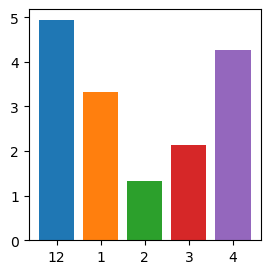

In [220]:
fig, ax = plt.subplots(figsize=(3,3))

for mm, month in enumerate(months):
    
    ax.bar(mm, stats['polynya'][month] / len(years))
#     ax.scatter(mm, stats['ESE_winds'][month] / len(years), c='gray')
#     ax.scatter(mm, stats['strong_ESE_winds'][month] / len(years), c='k')
#     ax.scatter(mm, stats['strong_winds'][month] / len(years), c='lightgray')
    
ax.set_xticks(range(len(months)))
ax.set_xticklabels(months)

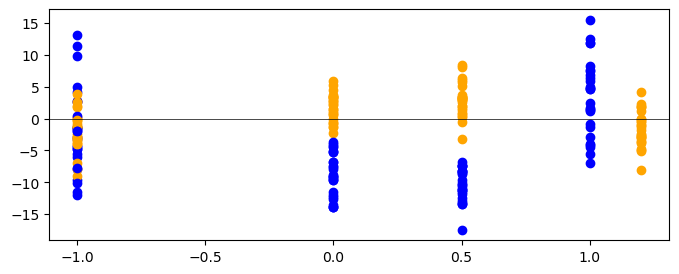

In [237]:
fig, ax = plt.subplots(figsize=(8,3))
ax.axhline(0, c='k', lw=0.5)


u_start = np.array([])
v_start = np.array([])

u_end = np.array([])
v_end = np.array([])

for ii in all_seqs.keys():

    seq = all_force[ii]
    
    
#     event_length = np.max(seq['dt']) - dt_f.days
#     dt_norm = (seq['dt']) / event_length

    dt = seq['dt']
    
    ind_start = np.where(dt == dt[dt_i.days*24])
    ind_end = np.where(dt == dt[-dt_f.days*24])
    
    ind_first = np.where((dt < 1) & (dt > -0.5))
    
    ind_final = np.where((dt > dt.max()-dt_f.days) & (dt < dt.max()))
    
    
    u_start = np.append(u_start, seq['u10'][ind_first])
    v_start = np.append(v_start, seq['v10'][ind_first])
    
    u_end = np.append(u_end, seq['u10'][ind_final])
    v_end = np.append(v_end, seq['v10'][ind_final])
    
    
    ax.scatter([-1], seq['u10'][0], c='b')
    ax.scatter([-1], seq['v10'][0], c='orange')
    
    
    
    ax.scatter([0], seq['u10'][24], c='b')
    ax.scatter([0], seq['v10'][24], c='orange')
    
    ax.scatter([0.5], seq['u10'][24+12], c='b')
    ax.scatter([0.5], seq['v10'][24+12], c='orange')
    
    
    ax.scatter([1], seq['u10'][-1], c='b')
    ax.scatter([1.2], seq['v10'][-1], c='orange')
    
    

In [224]:
dt.max()-dt_f.days

2.9583333333333326

In [340]:
np.nanmean(u_start) + np.nanmean(u_start)

-9.071467411619526

In [382]:
back_u

array([[  3.8389461 ,  -2.82555103,  -9.8918848 , ..., -10.26326752,
        -10.4566555 ,  -2.6198113 ],
       [ -6.86123133,  -3.49951482,  -2.09327817, ...,  -3.21595359,
         -0.82638049,   1.24201941],
       [ -7.43496084,  -9.48820591,  -1.15085363, ...,   4.88615179,
          3.07102418,  -4.65210772],
       ...,
       [ -1.63067245,   5.38300133,   4.05156994, ...,  -7.25163078,
         -2.97059369,  -6.49904585],
       [  1.69804752,   3.3758955 ,  17.41368866, ...,  -3.81374931,
         -6.7414031 ,  -7.88210106],
       [ -9.14648151,  -7.8623395 ,  -4.47210836, ...,  -5.46022844,
         -3.33055878,   1.97247684]])

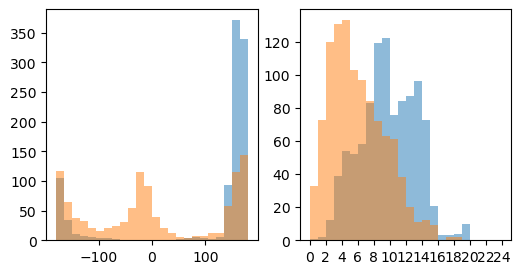

In [385]:
fig, axs = plt.subplots(1,2, figsize=(6,3))

start_angles = vectors.vector_angle(u_start, v_start)
back_angles = vectors.vector_angle(back_u.flatten(), back_v.flatten())

start_speeds = np.sqrt(u_start**2 + v_start**2)
back_speeds = np.sqrt(back_u.flatten()**2 + back_v.flatten()**2)


# bins = np.arange(-25,25,1)
# ax = axs[0]
# ax.hist(u_start, bins=bins, alpha=0.5)
# ax.hist(v_start, bins=bins, alpha=0.5)

# ax = axs[1]
# ax.hist(back_u.flatten(), bins=bins, alpha=0.5)
# ax.hist(back_v.flatten(), bins=bins, alpha=0.5)

bins = np.arange(-180,181,15)
ax = axs[0]
ax.hist(start_angles, bins=bins, alpha=0.5)
ax.hist(back_angles, bins=bins, alpha=0.5)
# ax.set_xticks(bins[::2])


bins = np.arange(0,25,1)
ax = axs[1]
ax.hist(start_speeds, bins=bins, alpha=0.5)
ax.hist(back_speeds, bins=bins, alpha=0.5)
ax.set_xticks(bins[::2])

In [386]:
np.nanpercentile(start_speeds, 25)

7.488388434840175

In [388]:
np.nanpercentile(back_speeds, 75)

8.234381331488112

In [348]:
back_angles

<Quantity([ -47.29289544 -136.85631304 -179.70275804 ... -179.72167549 -179.18563574
  -25.92228881], 'degree')>

In [316]:
vectors.vector_angle(np.nanmean(u_start), np.nanmean(v_start))

<Quantity(165.294017, 'degree')>

In [315]:
vectors.vector_angle(np.nanmean(back_u.flatten()), np.nanmean(back_v.flatten()))

<Quantity(-170.122596, 'degree')>

In [ ]:

year = 2020

f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc'
# year1
DS1 = xr.open_dataset(file_name(time_range.start.year, dt))
DS1.close()
time_slice = slice(time_range.start, datetime(time_range.start.year, 12, 31, 23))
DS1 = DS1.sel(latitude = lat, longitude = lon, time=time_slice)


In [515]:
all_seqs

{0: [Timestamp('2017-12-03 00:00:00'),
  Timestamp('2017-12-04 00:00:00'),
  Timestamp('2017-12-05 00:00:00'),
  Timestamp('2017-12-06 00:00:00'),
  Timestamp('2017-12-07 00:00:00'),
  Timestamp('2017-12-08 00:00:00'),
  Timestamp('2017-12-09 00:00:00'),
  Timestamp('2017-12-10 00:00:00'),
  Timestamp('2017-12-11 00:00:00'),
  Timestamp('2017-12-12 00:00:00'),
  Timestamp('2017-12-13 00:00:00'),
  Timestamp('2017-12-14 00:00:00'),
  Timestamp('2017-12-15 00:00:00'),
  Timestamp('2017-12-16 00:00:00'),
  Timestamp('2017-12-17 00:00:00'),
  Timestamp('2017-12-18 00:00:00'),
  Timestamp('2017-12-19 00:00:00'),
  Timestamp('2017-12-20 00:00:00'),
  Timestamp('2017-12-21 00:00:00'),
  Timestamp('2017-12-22 00:00:00'),
  Timestamp('2017-12-23 00:00:00'),
  Timestamp('2017-12-24 00:00:00'),
  Timestamp('2017-12-25 00:00:00'),
  Timestamp('2017-12-26 00:00:00'),
  Timestamp('2017-12-27 00:00:00')],
 1: [Timestamp('2018-01-01 00:00:00'),
  Timestamp('2018-01-02 00:00:00'),
  Timestamp('2018-01-

array([2006, 2007, 2008, 2009, 2010, 2011, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023, 2024])

In [114]:

u_bg_sum = np.zeros((29, 161))
v_bg_sum = np.zeros((29, 161))
s_bg_sum = np.zeros((29, 161))
m_bg_sum = np.zeros((29, 161))
t_bg_sum = np.zeros((29, 161))

days_counter = 0

for year in years:
    
    print(year)
    
    # december
    ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year-1}_daily.nc')
    ds.close()
    ds = ds.sel(time = slice(datetime(year-1,12,1), datetime(year-1,12,31)), 
                latitude = lat_range, longitude = lon_range)
    speed = np.sqrt(ds.u10**2+ds.v10**2)
    
    u_bg_sum += ds.u10.sum(dim='time').values
    v_bg_sum += ds.v10.sum(dim='time').values
    s_bg_sum += speed.sum(dim='time').values
    m_bg_sum += ds.msl.sum(dim='time').values/100
    
    days_counter+=len(ds.time.values)
    
    ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily_t2m/ERA5_T2m_daily_{year-1}.nc')
    ds.close()
    ds = ds.sel(valid_time = slice(datetime(year-1,12,1), datetime(year-1,12,31)), 
                latitude = lat_range, longitude = lon_range)
    t_bg_sum += (ds.t2m - 273.15).sum(dim='valid_time').values

    
    # december
    ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
    ds.close()
    ds = ds.sel(time = slice(datetime(year,1,1), datetime(year,4,30)), 
                latitude = lat_range, longitude = lon_range)
    speed = np.sqrt(ds.u10**2+ds.v10**2)
    
    u_bg_sum += ds.u10.sum(dim='time').values
    v_bg_sum += ds.v10.sum(dim='time').values
    s_bg_sum += speed.sum(dim='time').values
    m_bg_sum += ds.msl.sum(dim='time').values/100
    
    days_counter+=len(ds.time.values)
    
    ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily_t2m/ERA5_T2m_daily_{year}.nc')
    ds.close()
    ds = ds.sel(valid_time = slice(datetime(year,1,1), datetime(year,4,30)), 
                latitude = lat_range, longitude = lon_range)
    t_bg_sum += (ds.t2m - 273.15).sum(dim='valid_time').values
    
    
    
    
u_bg_mean = u_bg_sum / days_counter
v_bg_mean = v_bg_sum / days_counter
s_bg_mean = s_bg_sum / days_counter
m_bg_mean = m_bg_sum / days_counter
t_bg_mean = t_bg_sum / days_counter
        

2006
2007
2008
2009
2010
2011
2016
2017
2018
2019
2020
2021
2022
2023
2024


In [123]:
u_sum = np.zeros((29, 161))
v_sum = np.zeros((29, 161))
s_sum = np.zeros((29, 161))
m_sum = np.zeros((29, 161))
t_sum = np.zeros((29, 161))

lat_range = slice(75,68)
lon_range = slice(-165,-125)
    
    
counter = 0

for ss in all_seqs:
    
    date = all_seqs[ss][-1]
    
    print(date)
    
    u_event_sum = np.zeros((29, 161))
    v_event_sum = np.zeros((29, 161))
    s_event_sum = np.zeros((29, 161))
    m_event_sum = np.zeros((29, 161))
    t_event_sum = np.zeros((29, 161))
    
    event_counter = 0
    
    for date in all_seqs[ss]:
        year = date.year
        ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
        ds.close()
        ds = ds.sel(time = date, latitude = lat_range, longitude = lon_range)
        speed = np.sqrt(ds.u10**2+ds.v10**2)
        
        u_event_sum += ds.u10.values
        v_event_sum += ds.v10.values
        s_event_sum += speed.values
        m_event_sum += ds.msl.values/100
        
        ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily_t2m/ERA5_T2m_daily_{year}.nc')
        ds.close()
        ds = ds.sel(valid_time = date, latitude = lat_range, longitude = lon_range)
        t_event_sum += (ds.t2m - 273.15).values

        event_counter+=1
        
        
        
    u_event_mean = u_event_sum / event_counter
    v_event_mean = v_event_sum / event_counter
    s_event_mean = s_event_sum / event_counter
    m_event_mean = m_event_sum / event_counter
    t_event_mean = t_event_sum / event_counter
    
    u_sum += u_event_mean
    v_sum += v_event_mean
    s_sum += s_event_mean
    m_sum += m_event_mean
    t_sum += t_event_mean
    
    counter+=1
    
    
u_mean = u_sum / counter
v_mean = v_sum / counter
s_mean = s_sum / counter
m_mean = m_sum / counter
t_mean = t_sum / counter


dc = np.sqrt(u_mean**2+v_mean**2) / s_mean

angles_mean = vectors.vector_angle(u_mean, v_mean).magnitude
angles_mean[angles_mean<0]+=360

2006-03-20 00:00:00
2007-02-10 00:00:00
2007-04-28 00:00:00
2007-12-15 00:00:00
2008-04-26 00:00:00
2008-12-11 00:00:00
2009-03-11 00:00:00
2009-12-30 00:00:00
2011-01-07 00:00:00
2016-02-17 00:00:00
2016-03-07 00:00:00
2016-04-14 00:00:00
2016-04-30 00:00:00
2016-12-08 00:00:00
2017-04-11 00:00:00
2017-04-19 00:00:00
2017-12-26 00:00:00
2018-01-03 00:00:00
2018-01-16 00:00:00
2018-04-12 00:00:00
2018-12-27 00:00:00
2019-01-19 00:00:00
2019-12-19 00:00:00
2020-12-03 00:00:00
2021-01-24 00:00:00
2021-04-30 00:00:00
2022-03-01 00:00:00
2022-03-29 00:00:00
2022-12-09 00:00:00
2022-12-12 00:00:00
2023-01-08 00:00:00
2023-01-15 00:00:00
2023-04-02 00:00:00
2024-01-18 00:00:00
2024-03-24 00:00:00
2024-04-01 00:00:00


In [163]:
dc_bg = np.sqrt(u_bg_mean**2+v_bg_mean**2) / s_bg_mean

In [164]:
total_vec_anom = np.sqrt((u_mean-u_bg_mean)**2 + (v_mean-v_bg_mean)**2)

angles_bg_mean = vectors.vector_angle(u_bg_mean, v_bg_mean).magnitude

angles_bg_mean[angles_bg_mean<0]+=360



In [165]:
total_vec_anom.shape

(29, 161)

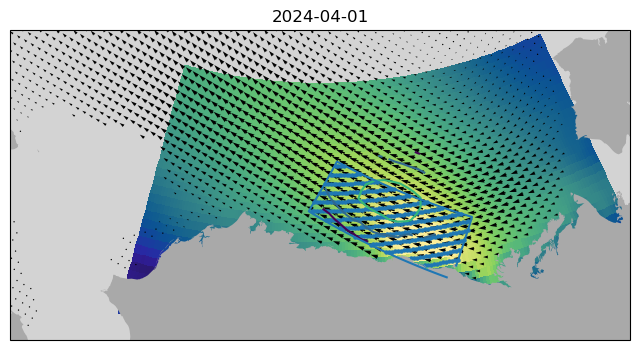

In [249]:
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)

fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))

ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-1000000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)
ax.set_title(date.date())
# geomap.scalebar(ax, loc=(0.55, 0.05), steps= [0,1,2,5,10,20], unit='km', label=None, 
#                 colors=['k', 'w'], edgecolor=None, textsize=9, lw=1, bar_width=0.025,
#                 labelpad=0.015, ticklabelpad=0.01, zorder=100)

# ax.pcolormesh(ds.longitude, ds.latitude, ds.msl/100, vmin=1010, vmax=1030, transform=ccrs.PlateCarree())


# ax.pcolormesh(ds.longitude, ds.latitude, angles_mean-angles_bg_mean, vmin=-60,vmax=60, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


# ax.pcolormesh(ds.longitude, ds.latitude, u_mean-u_bg_mean, vmin=-10,vmax=10, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

# ax.pcolormesh(ds.longitude, ds.latitude, angles_mean, vmin=165-15,vmax=165+15, cmap='RdBu_r', transform=ccrs.PlateCarree())


ax.pcolormesh(ds.longitude, ds.latitude, total_vec_anom, vmin=0,vmax=8, cmap=cmocean.cm.haline, transform=ccrs.PlateCarree())



# ax.pcolormesh(ds.longitude, ds.latitude, t_bg_mean, vmin=-40, vmax=-10, cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree())
# ax.pcolormesh(ds.longitude, ds.latitude, t_event_mean, vmin=-40, vmax=-10, cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree())


# ax.pcolormesh(ds.longitude, ds.latitude, t_event_mean - t_bg_mean, vmin=-10, vmax=10, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

# ax.pcolormesh(drift['xx'], drift['yy'], np.nanmean(drift['e'], axis=0), vmin=-10, vmax=10, cmap=cmocean.cm.balance, transform=drift['proj'])


ia=200
ib=300
ja=110
jb=200
# ax.pcolormesh(drift['xx'][ia:ib, ja:jb], drift['yy'][ia:ib, ja:jb], 
#               e_event_mean, vmin=-15, vmax=15, cmap=cmocean.cm.balance, transform=drift['proj'])

# ax.pcolormesh(drift['xx'][ia:ib, ja:jb], drift['yy'][ia:ib, ja:jb], 
#               n_event_mean, vmin=-5, vmax=5, cmap=cmocean.cm.balance, transform=drift['proj'])



# ax.pcolormesh(drift['xx'][ia:ib, ja:jb], drift['yy'][ia:ib, ja:jb], 
#               np.sqrt(e_event_mean**2+n_event_mean**2), vmin=-20, vmax=20, cmap=cmocean.cm.balance, transform=drift['proj'])


dlon_range = (drift['lon'][ia:ib, ja:jb] > 210) & (drift['lon'][ia:ib, ja:jb] < 220)
dlat_range = (drift['lat'][ia:ib, ja:jb] > 70.5) & (drift['lat'][ia:ib, ja:jb] < 73)
mask = (dlon_range & dlat_range)==False
ax.contour(drift['xx'][ia:ib, ja:jb], drift['yy'][ia:ib, ja:jb], 
         ma.masked_where(mask, s_event_mean),  levels=[17,19,21,23], transform=drift['proj'])



# ax.quiver(drift['xx'][ia:ib, ja:jb], drift['yy'][ia:ib, ja:jb],
#          np.mean(drift['u'][:,ia:ib, ja:jb], axis=0), np.mean(drift['v'][:,ia:ib, ja:jb], axis=0), transform=drift['proj'])

E, N = geomap.fix_cartopy_vectors(e_event_mean, n_event_mean, drift['lat'][ia:ib, ja:jb])
ax.quiver(drift['lon'][ia:ib, ja:jb], drift['lat'][ia:ib, ja:jb],
         E, N, transform=ccrs.PlateCarree())

# ax.contour(ds.longitude, ds.latitude, (1013.25 - ds.msl/100), levels=np.arange(-50,50), vmin=-30,vmax=30, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


ax.plot(df['lons'], df['lats'], transform=ccrs.PlateCarree())

ax.scatter(longrid[within_region], latgrid[within_region], s=5, transform=ccrs.PlateCarree())
